# Trainable activation layer implementations

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import logging
import inspect
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [ ]:
class LayerActivationSigmoid(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super().__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)

  def get_config(self):
    base_config = super().get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, *([1] * len(input_shape))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = keras.activations.sigmoid(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class LayerActivationWoSoftmax(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super().__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super().get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, *([1] * len(input_shape))),
        initializer="uniform",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    multiplied_by_weights = tensor_outputs * self.w
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class LayerActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(LayerActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super().get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, *([1] * len(input_shape))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      custom_objects = vars(tf.math)
      custom_objects['spatial_softmax'] = spatial_softmax
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=custom_objects)
    return cls(**config)

In [ ]:
class KernelActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(KernelActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(KernelActivation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    # Is conv layer
    if len(input_shape) > 2:
      self.w = self.add_weight(
          shape=(self.units, *([1] * len(input_shape[:-1])), input_shape[-1]),
          initializer="zeros",
          trainable=True,
      )
    # Is regular layer
    else:
      self.w = self.add_weight(
          shape=(self.units, *([1] * len(input_shape))),
          initializer="zeros",
          trainable=True,
      )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class NeuronActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(NeuronActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(NeuronActivation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, 1, *list(map(lambda shape: shape if shape is not None else 1, input_shape[1:]))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

# Functions

## Dataset functions

In [ ]:
def transform_image(train_images, test_images, color_transform=None, image_transform=None):
  if color_transform:
    new_train_images, new_test_images = [], []
    for image in train_images:
      new_train_images.append(cv.cvtColor(image, color_transform))
    for image in test_images:
      new_test_images.append(cv.cvtColor(image, color_transform))
    train_images = np.array(new_train_images)
    test_images = np.array(new_test_images)
    if len(train_images.shape) == 3:
      train_images = train_images[..., np.newaxis]
      test_images = test_images[..., np.newaxis]

  if image_transform:
    train_images = image_transform(train_images)
    test_images = image_transform(test_images)

  return train_images, test_images

In [ ]:
def get_cifar10_data(n=None, color_transform=None, image_transform=None):
  (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

  train_images, test_images = transform_image(train_images, test_images, color_transform, image_transform)

  if n is not None:
    return (train_images[:n], train_labels[:n]), (test_images[:n], test_labels[:n])
  else:
    return (train_images, train_labels), (test_images, test_labels)


In [ ]:
def get_mnist_data(n=None, color_transform=None, image_transform=None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  y_train = np.expand_dims(y_train, -1)
  y_test = np.expand_dims(y_test, -1)

  x_train, x_test = transform_image(x_train, x_test, color_transform, image_transform)

  if n is not None:
    return (x_train[:n], y_train[:n]), (x_test[:n], y_test[:n])
  else:
    return (x_train, y_train), (x_test, y_test)

In [ ]:
def get_imdb_data():
  import shutil
  import tensorflow_datasets as tfds
  
  train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

  train_text, train_labels = tfds.as_numpy(train_data)
  test_text, test_labels = tfds.as_numpy(test_data)

  return (train_text, train_labels), (test_text, test_labels)

## Model functions

In [ ]:
def get_model(
    activation_function, 
    input_shape,
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
):
  inputs = keras.Input(shape=input_shape)
  l1 = layers.Conv2D(32, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
  l2 = activation_function()(l1)
  l3 = layers.MaxPooling2D((2, 2))(l2)
  l4 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(l3)
  l5 = activation_function()(l4)
  l6 = layers.MaxPooling2D((2, 2))(l5)
  d1 = layers.Dropout(0.2)(l6)
  l7 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(d1)
  l8 = activation_function()(l7)
  l9 = layers.Flatten()(l8)
  l10 = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))(l9)
  l11 = activation_function()(l10)
  d2 = layers.Dropout(0.5)(l11)
  outputs = layers.Dense(10, activation=keras.activations.softmax)(d2)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
  
  return model

def get_model_smaller(
    activation_function, 
    input_shape,
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
):
  inputs = keras.Input(shape=input_shape)
  l1 = layers.Conv2D(32, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
  l2 = activation_function()(l1)
  l3 = layers.MaxPooling2D((2, 2))(l2)
  l4 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(l3)
  l5 = activation_function()(l4)
  l6 = layers.MaxPooling2D((2, 2))(l5)
  d1 = layers.Dropout(0.2)(l6)
  l7 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(d1)
  l8 = activation_function()(l7)
  l9 = layers.Flatten()(l8)
  outputs = layers.Dense(10, activation=keras.activations.softmax)(l9)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
  
  return model

def get_model_wo_dropouts(
    activation_function, 
    input_shape,
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
):
  inputs = keras.Input(shape=input_shape)
  l1 = layers.Conv2D(32, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
  l2 = activation_function()(l1)
  l3 = layers.MaxPooling2D((2, 2))(l2)
  l4 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(l3)
  l5 = activation_function()(l4)
  l6 = layers.MaxPooling2D((2, 2))(l5)
  l7 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(l6)
  l8 = activation_function()(l7)
  l9 = layers.Flatten()(l8)
  l10 = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))(l9)
  l11 = activation_function()(l10)
  outputs = layers.Dense(10, activation=keras.activations.softmax)(l11)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
  
  return model

def get_model_wo_reg(
    activation_function, 
    input_shape,
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
):
  inputs = keras.Input(shape=input_shape)
  l1 = layers.Conv2D(32, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
  l2 = activation_function()(l1)
  l3 = layers.MaxPooling2D((2, 2))(l2)
  l4 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(l3)
  l5 = activation_function()(l4)
  l6 = layers.MaxPooling2D((2, 2))(l5)
  l7 = layers.Conv2D(64, (3, 3), kernel_regularizer=keras.regularizers.l2(0.001))(l6)
  l8 = activation_function()(l7)
  l9 = layers.Flatten()(l8)
  l10 = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))(l9)
  l11 = activation_function()(l10)
  outputs = layers.Dense(10, activation=keras.activations.softmax)(l11)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
  
  return model

In [ ]:
model = get_model(lambda: keras.layers.Activation('relu'), (32, 32, 3))
model_wo_dropouts = get_model_wo_dropouts(lambda: keras.layers.Activation('relu'), (32, 32, 3))

In [ ]:
def plot_model_vertical(model):
  display(keras.utils.plot_model(model, show_layer_names=False, show_shapes=True))

def plot_model(model):
  from IPython.display import display
  n = len(model.layers)
  i = n // 3
  start_layer_1 = model.layers[0].get_config()['name']
  end_layer_1 = model.layers[i - 1].get_config()['name']
  start_layer_2 = model.layers[i].get_config()['name']
  end_layer_2 = model.layers[i * 2 - 1].get_config()['name']
  start_layer_3 = model.layers[i * 2].get_config()['name']
  end_layer_3 = model.layers[n - 1].get_config()['name']
  display(keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, rankdir="LR", layer_range=[start_layer_1, end_layer_1]))
  display(keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, rankdir="LR", layer_range=[start_layer_2, end_layer_2]))
  display(keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, rankdir="LR", layer_range=[start_layer_3, end_layer_3]))

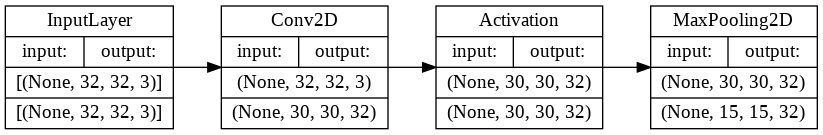

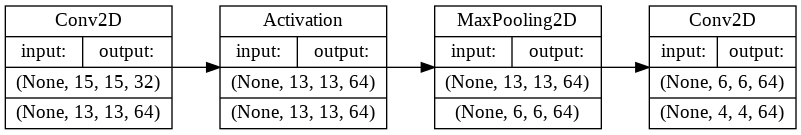

In [ ]:
plot_model(model_wo_dropouts)

In [ ]:
plot_model(model)

In [ ]:
def prune_model(model, n_act_functions=None, reset_weights=False, reset_weights_except_act=True):
  new_model = models.Sequential()
  weights_for_layers = []
  for i, layer in enumerate(model.layers):
    if is_activation_layer(layer):
      index = tuple([slice(None)] + [0] * (len(layer.get_weights()[0].shape) - 1))
      weights = layer.get_weights()
      weights = np.array(keras.activations.softmax(tf.convert_to_tensor(layer.get_weights()[0]), axis=0))[index]
      # Choose half the best
      if n_act_functions is None:
        n = len(weights) // 2
      elif n_act_functions == 'all':
        n = len(weights)
      else:
        n = n_act_functions
      best_indices = weights.argsort()[::-1][:n]
      new_activation_functions = np.array(layer.activation_functions)[best_indices]
      print(new_activation_functions)
      if len(new_activation_functions) == 1:
        new_layer = keras.layers.Activation(new_activation_functions[0])
      else:
        new_layer = type(layer)(activation_functions=new_activation_functions)
      weights_for_layers.append([layer.get_weights()[0][best_indices]])
      new_model.add(new_layer)
  
    else:
      weights_for_layers.append(layer.get_weights())
      new_model.add(model.layers[i])
  if reset_weights or reset_weights_except_act:
    new_model = tf.keras.models.clone_model(new_model)
  new_model.compile(
      optimizer=model.optimizer,
      loss=model.loss,
  )
  new_model.compiled_metrics = model.compiled_metrics
  new_model.build(model.input_shape)
  
  # Remove empty input layer weight
  if len(weights_for_layers[0]) == 0:
    weights_for_layers.pop(0)
  
  if not reset_weights and not reset_weights_except_act:
    for i, layer in enumerate(new_model.layers):
      layer.set_weights(weights_for_layers.pop(0))
  
  if reset_weights_except_act:
    for i, layer in enumerate(new_model.layers):
      weights = weights_for_layers.pop(0)
      if is_activation_layer(layer):
        layer.set_weights(weights)

  return new_model

In [ ]:
def disable_activation_layer_training(model):
  for layer in model.layers:
      if 'activation' in layer.get_config()['name']:
        layer.trainable = False
      else:
        layer.trainable = True
  return model

## Training functions

In [ ]:
import json
from google.colab import files
from sklearn.model_selection import train_test_split
from copy import deepcopy

def batches(X, y, batch_size=64):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
  return dataset

def dataset_into_batches(X, y, val_split):
  batch_size = 64
  x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=val_split)
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
  train_batches_len = train_dataset.cardinality().numpy()
  
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_dataset_len = val_dataset.cardinality().numpy()
  val_dataset_batch_size = val_dataset_len // train_batches_len
  val_dataset_batch_size += val_dataset_batch_size % 2
  print(val_dataset_batch_size)
  val_dataset = val_dataset.shuffle(buffer_size=1024).batch(val_dataset_batch_size)

  return train_dataset, val_dataset

def get_train_step_alt(model):
  @tf.function
  def train_step(x_batch_1, y_batch_1, x_batch_2, y_batch_2, val_layer_indices):
    trainable_layers = [layer for layer in model.layers if layer.trainable]
    disabled_layers = trainable_layers[val_layer_indices]

    # Disable training for odd layers
    for layer in disabled_layers:
      layer.trainable = False

    # Train odd layers
    with tf.GradientTape() as tape:
      y_pred = model(x_batch_1, training=True)
      loss = model.compiled_loss(y_batch_1, y_pred, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Disable even layers from training
    for layer in trainable_layers:
      layer.trainable = False

    for layer in disabled_layers:
      layer.trainable = True

    # Train activation layers
    with tf.GradientTape() as tape:
      y_pred_val = model(x_batch_2, training=True)
      loss = model.compiled_loss(y_batch_2, y_pred_val, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Enable training for all layers again
    for layer in trainable_layers:
      layer.trainable = True

    # Update metrics
    model.compiled_metrics.update_state(y_batch_1, model(x_batch_1))
    model.compiled_metrics.update_state(y_batch_2, model(x_batch_2))
  return train_step


def get_train_step_val_org(model, optimizer):
  def train_step(x_train_batch, y_train_batch, x_val_batch, y_val_batch):
    # Disable training for activation layers
    model_weights = []
    for layer in model.layers:
      if 'activation' in layer.get_config()['name']:
        layer.trainable = False
      else:
        model_weights.append(layer.get_weights())
        layer.trainable = True


    # Train other layers
    with tf.GradientTape() as tape:
      y_pred = model(x_train_batch, training=True)
      loss = model.compiled_loss(y_train_batch, y_pred, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Disable other layers from training
    for layer in model.layers:
      if 'activation' in layer.get_config()['name']:
        layer.trainable = True
      else:
        layer.trainable = False

    # Train activation layers
    with tf.GradientTape() as tape:
      y_pred_val = model(x_val_batch, training=True)
      loss = model.compiled_loss(y_val_batch, y_pred_val, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Put old weights back
    for layer in model.layers:
      if 'activation' in layer.get_config()['name']:
        layer.trainable = False
      else:
        layer.set_weights(model_weights.pop(0))
        layer.trainable = True

    # Train other layers again
    with tf.GradientTape() as tape:
      y_pred = model(x_train_batch, training=True)
      loss = model.compiled_loss(y_train_batch, y_pred, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Enable training for all layers again
    for layer in model.layers:
      layer.trainable = True

    # Update metrics
    model.compiled_metrics.update_state(y_train_batch, model(x_train_batch))
  return train_step

def get_train_step_val(model):
  @tf.function
  def train_step(x_train_batch, y_train_batch, x_val_batch, y_val_batch):
    # Disable training for activation layers
    for layer in model.layers:
      if 'activation' in layer.get_config()['name']:
        layer.trainable = False

    # Train other layers
    with tf.GradientTape() as tape:
      y_pred = model(x_train_batch, training=True)
      loss = model.compiled_loss(y_train_batch, y_pred, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Disable other layers from training
    for layer in model.layers:
      if 'activation' in layer.get_config()['name']:
        layer.trainable = True
      else:
        layer.trainable = False

    # Train activation layers
    with tf.GradientTape() as tape:
      y_pred_val = model(x_val_batch, training=True)
      loss = model.compiled_loss(y_val_batch, y_pred_val, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Enable training for all layers again
    for layer in model.layers:
      layer.trainable = True

    # Update metrics
    model.compiled_metrics.update_state(y_train_batch, model(x_train_batch))
  return train_step

def get_train_step(model):
  @tf.function
  def train_step(x_train_batch, y_train_batch):
    # Train layers
    with tf.GradientTape() as tape:
      y_pred = model(x_train_batch, training=True)
      loss = model.compiled_loss(y_train_batch, y_pred, regularization_losses=model.losses)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    model.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update metrics
    model.compiled_metrics.update_state(y_train_batch, model(x_train_batch))
  return train_step


def calculate_metrics(model, history, val_dataset, val_acc_metric):
  for x_batch_val, y_batch_val in val_dataset:
    val_acc_metric.update_state(y_batch_val, model(x_batch_val, training=False))

  metrics = {m.name: m.result() for m in model.metrics}
  metrics.update({'val_accuracy': val_acc_metric.result()})
  history.append(metrics)
  
  model.compiled_metrics.reset_state()
  val_acc_metric.reset_state()
  
  print("Validation accuracy for epoch:", metrics['val_accuracy'].numpy())
  print("Training accuracy for epoch:", metrics['accuracy'].numpy())

def save_model(model, filepath, epoch):
  model_file = filepath.format(epoch=epoch + 1)
  print("Saving model to", model_file)
  print()
  models.save_model(model, model_file)

def model_train_alt(model, filepath, epochs, X, y, data_split=0.2, val_split=0.1, prune_model_epochs=[]):
  train_step = get_train_step_alt(model)
  #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split)
  #val_dataset = batches(X_val, y_val)
  train_dataset_1, train_dataset_2 = dataset_into_batches(X, y, data_split)
  val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

  # Metrics for each epoch
  history = []
  for epoch in range(epochs):
    print("Epoch", epoch)
    if epoch in prune_model_epochs:
      print("Pruning model")
      model = prune_model(model)
      train_step = get_train_step_alt(model)
    print(f"Step / {len(train_dataset_1)}: ", end="")
    for step, ((x_batch_1, y_batch_1), (x_batch_2, y_batch_2)) in enumerate(zip(train_dataset_1, train_dataset_2)):
      train_step(x_batch_1, y_batch_1, x_batch_2, y_batch_2, epoch % 2)
      if step % 100 == 0:
        print(step, end=" ")
    print(step + 1)

    # After each epoch
    calculate_metrics(model, history, train_dataset_2, val_acc_metric)
    save_model(model, filepath, epoch)
    
  return model, history

def model_train_val(model, filepath, epochs, X, y, val_split=0.2, val_data=None, opt_split=0.2, prune_model_epochs=[], callbacks=[], save=True, **kwargs):
  train_step = get_train_step_val(model)
  
  if val_data is not None:
    val_dataset = batches(*val_data)
    print("Using given val data")
  else:
    X, X_val, y, y_val = train_test_split(X, y, test_size=val_split)
    val_dataset = batches(X_val, y_val)
  
  train_dataset, opt_dataset = dataset_into_batches(X, y, opt_split)
  val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

  for callback in callbacks:
    callback.set_model(model)
    callback.on_train_begin()
  
  # Metrics for each epoch
  history = []
  enum_dataset = list(enumerate(list(zip(train_dataset, opt_dataset))))
  for epoch in range(epochs):
    print("Epoch", epoch + 1)
    if epoch in prune_model_epochs:
      print("Pruning model")
      model = prune_model(model)
      train_step = get_train_step_val(model)
    print(f"Step / {len(train_dataset)}: ", end="")
    for step, ((x_train_batch, y_train_batch), (x_opt_batch, y_opt_batch)) in enum_dataset:
      train_step(x_train_batch, y_train_batch, x_opt_batch, y_opt_batch)

      if step % 100 == 0:
        print(step, end=" ")
    print(step + 1)

    # After each epoch
    # Update metrics
    metrics = calculate_metrics(model, history, val_dataset, val_acc_metric)
    if save:
      save_model(model, filepath, epoch)
    
    for callback in callbacks:
      callback.on_epoch_end(epoch, {key: metrics[key].numpy() for key in metrics})
  return model, history

def model_train_val_org(model, filepath, epochs, X, y, val_split=0.2, val_data=None, opt_split=0.2, prune_model_epochs=[], callbacks=[], save=True, **kwargs):
  optimizer = tf.keras.optimizers.Adam()
  train_step = get_train_step_val_org(model, optimizer)
  
  if val_data is not None:
    val_dataset = batches(*val_data)
    print("Using given val data")
  else:
    X, X_val, y, y_val = train_test_split(X, y, test_size=val_split)
    val_dataset = batches(X_val, y_val)
  
  train_dataset, opt_dataset = dataset_into_batches(X, y, opt_split)
  val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

  for callback in callbacks:
    callback.set_model(model)
    callback.on_train_begin()
  
  # Metrics for each epoch
  history = []
  enum_dataset = list(enumerate(list(zip(train_dataset, opt_dataset))))
  for epoch in range(epochs):
    print("Epoch", epoch + 1)
    if epoch in prune_model_epochs:
      print("Pruning model")
      model = prune_model(model)
      train_step = get_train_step_val_org(model)
    print(f"Step / {len(train_dataset)}: ", end="")
    for step, ((x_train_batch, y_train_batch), (x_opt_batch, y_opt_batch)) in enum_dataset:
      train_step(x_train_batch, y_train_batch, x_opt_batch, y_opt_batch)

      if step % 100 == 0:
        print(step, end=" ")
    print(step + 1)

    # After each epoch
    # Update metrics
    metrics = calculate_metrics(model, history, val_dataset, val_acc_metric)
    if save:
      save_model(model, filepath, epoch)
    
    for callback in callbacks:
      callback.on_epoch_end(epoch, {key: metrics[key].numpy() for key in metrics})
  return model, history

def model_train(model, filepath, epochs, X, y, val_split=0.2, val_data=None, prune_model_epochs=[]):
  train_step = get_train_step(model)
  train_dataset, val_dataset = dataset_into_batches(X, y, val_split)
  val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

  if val_data is not None:
    val_dataset = batches(*val_data)
    print("Using given val data")
  else:
    X, X_val, y, y_val = train_test_split(X, y, test_size=val_split)
    val_dataset = batches(X_val, y_val)

  # Metrics for each epoch
  history = []
  for epoch in range(epochs):
    print("Epoch", epoch)
    if epoch in prune_model_epochs:
      print("Pruning model")
      model = prune_model(model)
      train_step = get_train_step(model)
    print(f"Step / {len(train_dataset)}: ", end="")
    for step, (x_train_batch, y_train_batch) in enumerate(train_dataset):
      train_step(x_train_batch, y_train_batch)
      if step % 100 == 0:
        print(step, end=" ")
    print(step + 1)

    # After each epoch
    calculate_metrics(model, history, val_dataset, val_acc_metric)
    save_model(model, filepath, epoch)
    
  return model, history

def model_train_regular(model, filepath, epochs, X, y, val_split=0.2, val_data=None, prune_model_epochs=[]):
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_weights_only=False)
  if val_split is None and val_data is not None:
    print("Using given val data")
  history = model.fit(
    X, y,
    validation_split=val_split,
    validation_data=val_data,
    epochs=epochs,
    batch_size=64,
    callbacks=[checkpoint]
  )
  return model, history

## Result plotting functions

In [ ]:
def is_activation_layer(layer):
  return 'activation' in layer.get_config()['name']

In [ ]:
import math

def plot_activation_function_bars(layer):
  config = layer.get_config()

  if "wo_softmax" in layer.get_config()['name']:
    weights = tf.convert_to_tensor(layer.get_weights())
  else:
    weights = keras.activations.softmax(tf.convert_to_tensor(layer.get_weights()), axis=1)

  plt.tight_layout()
  labels = list(map(lambda fn: keras.activations.serialize(fn)[:8], layer.activation_functions))
  index = tuple([0, slice(None)] + [0] * (len(weights.shape) - 2))
  if len(labels) > 4:
    plt.xticks(rotation=55, ha="right")
  plt.ylim(0, 1.0)
  plt.bar(labels, weights[index])

def plot_activation_functions_bars(models, width=10, height=4, mode='grid'):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  width = width * len(models) # width - for each model / epoch
  height = height * len([layer for layer in models[0].layers if is_activation_layer(layer)]) # height - for each layer

  plt.figure(figsize=(width, height), dpi=300)
  count = 0
  for i, model in enumerate(models):
    activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
    for j, layer in enumerate(activation_layers):
      if mode == 'grid':
        plt.subplot(len(activation_layers) // 2, len(activation_layers) // 2, count + 1)
      else:
        plt.subplot(len(activation_layers), len(models), count + 1)
      plot_activation_function_bars(layer)
      plt.title(f'Activation layer {j + 1}')
      # plt.title(f'Model {i + 1} Layer {layer.get_config()["name"]}')
      count += 1

  plt.show()

In [ ]:
def plot_performance(history, val_acc_label='Test accuracy', test_accuracy=None):
  plt.figure(dpi=300)
  plt.grid(visible=True, axis='both', which='both')
  # test_acc_rounded = np.around(test_acc, decimals=1)
  # y_ticks = list(np.arange(0.1, test_acc_rounded, 0.1)) + [test_acc] + list(np.arange(test_acc_rounded, 1.0, 0.1))
  # label_doesnt_fit = abs(test_acc_rounded - test_acc) < 0.4
  # y_ticks_labels = list(map(lambda x: "{:.3f}".format(x) if type(x) != str else x, list(np.arange(0.1, test_acc_rounded, 0.1)) + [test_acc] + ([""] if label_doesnt_fit else [test_acc_rounded]) +
  #                           list(np.arange(test_acc_rounded + 0.1, 1.0, 0.1))))
  plt.yticks(np.arange(0.1, 1.1, 0.1))
  if history:
    # In case of val training
    if type(history) is list:
      epochs = range(1, len(history) + 1)
      plt.xticks(np.arange(1, len(history) + 1, 1))
      accuracy = [metric['accuracy'] for metric in history]
      plt.plot(epochs, accuracy, label='Train accuracy')

      if 'val_accuracy' in history[0]:
        val_accuracy = [metric['val_accuracy'] for metric in history]
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
    # Regular training
    else:
      plt.xticks(np.arange(1, len(history.history['accuracy']) + 1, 1))
      plt.plot(history.history['accuracy'], label='Train accuracy')
      plt.plot(history.history['val_accuracy'], label = val_acc_label)
    if test_accuracy:
      plt.axhline(y=test_accuracy, label='Test accuracy', color='r', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
  else:
    print("Could not plot performance: history not available")

In [ ]:
def plot_activation_function(layer, x_start, x_end, n=None):
  config = layer.get_config()
  x = np.arange(x_start * 10, x_end * 10) / 10
  initial_x_len = x.shape[0]
  x = x.reshape(tuple([x.shape[0]] + [1] * (len(layer.weights[0].shape) - 2)))
  y = np.array(layer(x))
  plt.tight_layout()
  plt.ylim(-10, 20)
  plt.plot(x.reshape(initial_x_len), y.reshape(initial_x_len))
  if n is None:
    plt.title(config['name'])
  else:
    plt.title(f'Activation layer {n + 1}')


def plot_activation_functions(models, x_start=-20, x_end=20, width=4, height=2, mode=None):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
  n_activation_layers = len(activation_layers)
  plt.figure(figsize=(width * len(models), height * n_activation_layers), dpi=300)
  count = 0
  for model in models:
    activation_layers = [layer for layer in model.layers if is_activation_layer(layer)]
    for i, layer in enumerate(activation_layers):
      count += 1
      if mode == 'grid':
        plt.subplot(n_activation_layers // 2, n_activation_layers // 2, count)
      else:
        plt.subplot(n_activation_layers, len(models), count)
      plot_activation_function(layer, x_start, x_end, i)
  plt.show()

In [ ]:
def get_max_accuracy(history):
  if type(history) == list:
    max_test_acc = max(history, key=lambda x: x['val_accuracy'])['val_accuracy'].numpy()
    max_train_acc = max(history, key=lambda x: x['accuracy'])['accuracy'].numpy()
  else:
    max_test_acc = max(history.history['val_accuracy'])
    max_train_acc = max(history.history['accuracy'])

  return {'accuracy': max_train_acc, 'val_accuracy': max_test_acc}

## Test running functions

In [ ]:
from types import SimpleNamespace
import pickle

def save_history(filepath, history):
  filepath = filepath + '.history.pickle'
  print("Saving history to", filepath)
  if type(history) == list:
    pickle.dump(history, open(filepath, 'wb'))
  else:
    pickle.dump(history.history, open(filepath, 'wb'))

def load_history(filepath):
  try:
    filepath = filepath + '.history.pickle'
    history = pickle.load(open(filepath, 'rb'))
    if type(history) == dict:
      h = SimpleNamespace()
      h.history = history
      return h
    return history
  except Exception as e:
    print(e)

In [ ]:
def load_model(filepath):
  custom_objects = {"LayerActivationWoSoftmax": LayerActivationWoSoftmax, "LayerActivation": LayerActivation, "NeuronActivation": NeuronActivation, "KernelActivation": KernelActivation}
  with keras.utils.custom_object_scope(custom_objects):
    return models.load_model(filepath)

def load_models(filepath, epochs):
  models_list = []
  for epoch in epochs:
    models_list.append(load_model(filepath.format(epoch=epoch)))
  return models_list

def load_models_from_weights(model, filepath, epochs):
  models_list = []
  for epoch in epochs:
    cloned_model = models.clone_model(model)
    cloned_model.load_weights(filepath.format(epoch=epoch))
    models_list.append(cloned_model)
  return models_list

In [ ]:
def plot_results(
    models,
    history=None,
    test_acc=None,
    mode=None,
    do_plot_performance=True,
    do_plot_activation_function_bars=True,
    do_plot_activation_functions=True,
):
  if do_plot_performance:
    plot_performance(history, test_acc)
  if do_plot_activation_function_bars:
    plot_activation_functions_bars(models, mode=mode)
  if do_plot_activation_functions:
    plot_activation_functions(models, mode=mode)

In [ ]:
def train_model(
    model,
    filepath_prefix, 
    filepath, 
    epochs,
    data,
    model_train_fn,
    use_test_as_val
):
  (train_X, train_y), (test_X, test_y) = data
  val_split = 0.2
  val_data = None
  if use_test_as_val:
    val_data = (test_X, test_y)
    val_split = None
  model, history = model_train_fn(model, filepath_prefix + filepath, epochs, train_X, train_y, val_split=val_split, val_data=val_data)
  save_history((filepath_prefix + filepath).format(epoch=0), history)
  test_loss, test_acc = model.evaluate(test_X, test_y, verbose=2)
  return model, history, test_acc, test_loss

In [ ]:
def train(
    activation_function,
    filepath_prefix, 
    filepath, 
    epochs,
    get_data_fn,
    model_train_fn,
    get_model_fn=get_model,
    input_shape=None,
    use_test_as_val=False
  ):
  data = get_data_fn()
  if input_shape is None:
    input_shape = data[0][0].shape[1:]
  model = get_model_fn(activation_function=activation_function, input_shape=input_shape)
  return train_model(
    model,
    filepath_prefix, 
    filepath, 
    epochs,
    data,
    model_train_fn,
    use_test_as_val
  )

In [ ]:
def train_or_read(
    activation_function,
    filepath_prefix, 
    filepath, 
    epochs,
    get_data_fn,
    model_train_fn,
    get_model_fn=get_model,
    input_shape=None,
    use_test_as_val=False
  ):
  data = get_data_fn()
  if input_shape is None:
    input_shape = data[0][0].shape[1:]
  model = get_model_fn(activation_function=activation_function, input_shape=input_shape)
  model_name = filepath.format(epoch=epochs)
  if model_name.replace("/", "") in listdir(filepath_prefix):
    print("Reading model from file")
    (train_X, train_y), (test_X, test_y) = data
    model = load_model(filepath_prefix + model_name)
    history = load_history(filepath_prefix + filepath.format(epoch=0))
    # test_loss, test_acc = model.evaluate(test_X, test_y)
    return model, history, None, None
  else:
    print("Training model")
    return train(
      activation_function,
      filepath_prefix,
      filepath,
      epochs,
      get_data_fn,
      model_train_fn,
      get_model_fn,
      input_shape,
      use_test_as_val
    )

In [ ]:
def mcnemar_test(model1, model2, alpha=0.05):
  (_, _), (X, y) = get_cifar10_data()
  y = y.flatten()
  pred_1 = np.argmax(model1.predict(X), axis=1)
  pred_2 = np.argmax(model2.predict(X), axis=1)
  contigency_matrix = [[0, 0], [0, 0]]
  contigency_matrix[0][0] = ((pred_1 == y) & (pred_2 == y)).sum()
  contigency_matrix[0][1] = ((pred_1 == y) & (pred_2 != y)).sum()
  contigency_matrix[1][0] = ((pred_1 != y) & (pred_2 == y)).sum()
  contigency_matrix[1][1] = ((pred_1 != y) & (pred_2 != y)).sum()
  
  from statsmodels.stats.contingency_tables import mcnemar

  result = mcnemar(contigency_matrix)
  if result.pvalue > alpha:
  	print('Same proportions of errors (fail to reject H0)')
  else:
  	print('Different proportions of errors (reject H0)')
  print(result)

# Tests

## Setup

Run these cells before running tests

In [ ]:
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
models_path = "drive/MyDrive/master-thesis/models/experiments-comparison-1/"
listdir(models_path)

## RELU baseline

In [ ]:
relu_train_output = train(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    get_model_fn=get_model,
    use_test_as_val=True
)
print(get_max_accuracy(relu_train_output[1]))

Using given val data
Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 2.5511 - accuracy: 0.1917
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-2-01.hdf5
782/782 [==============================] - 18s 18ms/step - loss: 2.5511 - accuracy: 0.1917 - val_loss: 2.0286 - val_accuracy: 0.3164
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.9072 - accuracy: 0.3498
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-2-02.hdf5
782/782 [==============================] - 10s 13ms/step - loss: 1.9071 - accuracy: 0.3498 - val_loss: 1.7497 - val_accuracy: 0.4116
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.6926 - accuracy: 0.4392
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-2-03.hdf5
782/782 [==============================] - 9s 11ms/step - loss: 1.6925 - accuracy: 0.4392 - val_loss: 1.534

In [ ]:
relu_train_output = train(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    get_model_fn=get_model,
    use_test_as_val=True
)
print(get_max_accuracy(relu_train_output[1]))

Using given val data
Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 2.3769 - accuracy: 0.2097
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-3-01.hdf5
782/782 [==============================] - 18s 18ms/step - loss: 2.3769 - accuracy: 0.2097 - val_loss: 1.7867 - val_accuracy: 0.3965
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.8055 - accuracy: 0.3843
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-3-02.hdf5
782/782 [==============================] - 12s 15ms/step - loss: 1.8054 - accuracy: 0.3843 - val_loss: 1.5534 - val_accuracy: 0.4835
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.6200 - accuracy: 0.4666
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-3-03.hdf5
782/782 [==============================] - 10s 12ms/step - loss: 1.6201 - accuracy: 0.4666 - val_loss: 1.42

In [ ]:
relu_train_output = train_or_read(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    get_model_fn=get_model,
    use_test_as_val=True
)

170508288/170498071 [==============================] - 2s 0us/step
Reading model from file


In [ ]:
print(get_max_accuracy(relu_train_output[1]))

{'accuracy': 0.6964799761772156, 'val_accuracy': 0.7132999897003174}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.71329, 0.71520, 0.71700]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7152 $\pm$ 0.0015
0.7151633333333334 +- 0.00151482305530675


In [ ]:
print("Train accuracy mean:")
train_accs = [0.69647, 0.70304, 0.69767]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.6991 $\pm$ 0.0029
0.6990599999999999 +- 0.0028566063782047265


Test acc: 0.7132999897003174


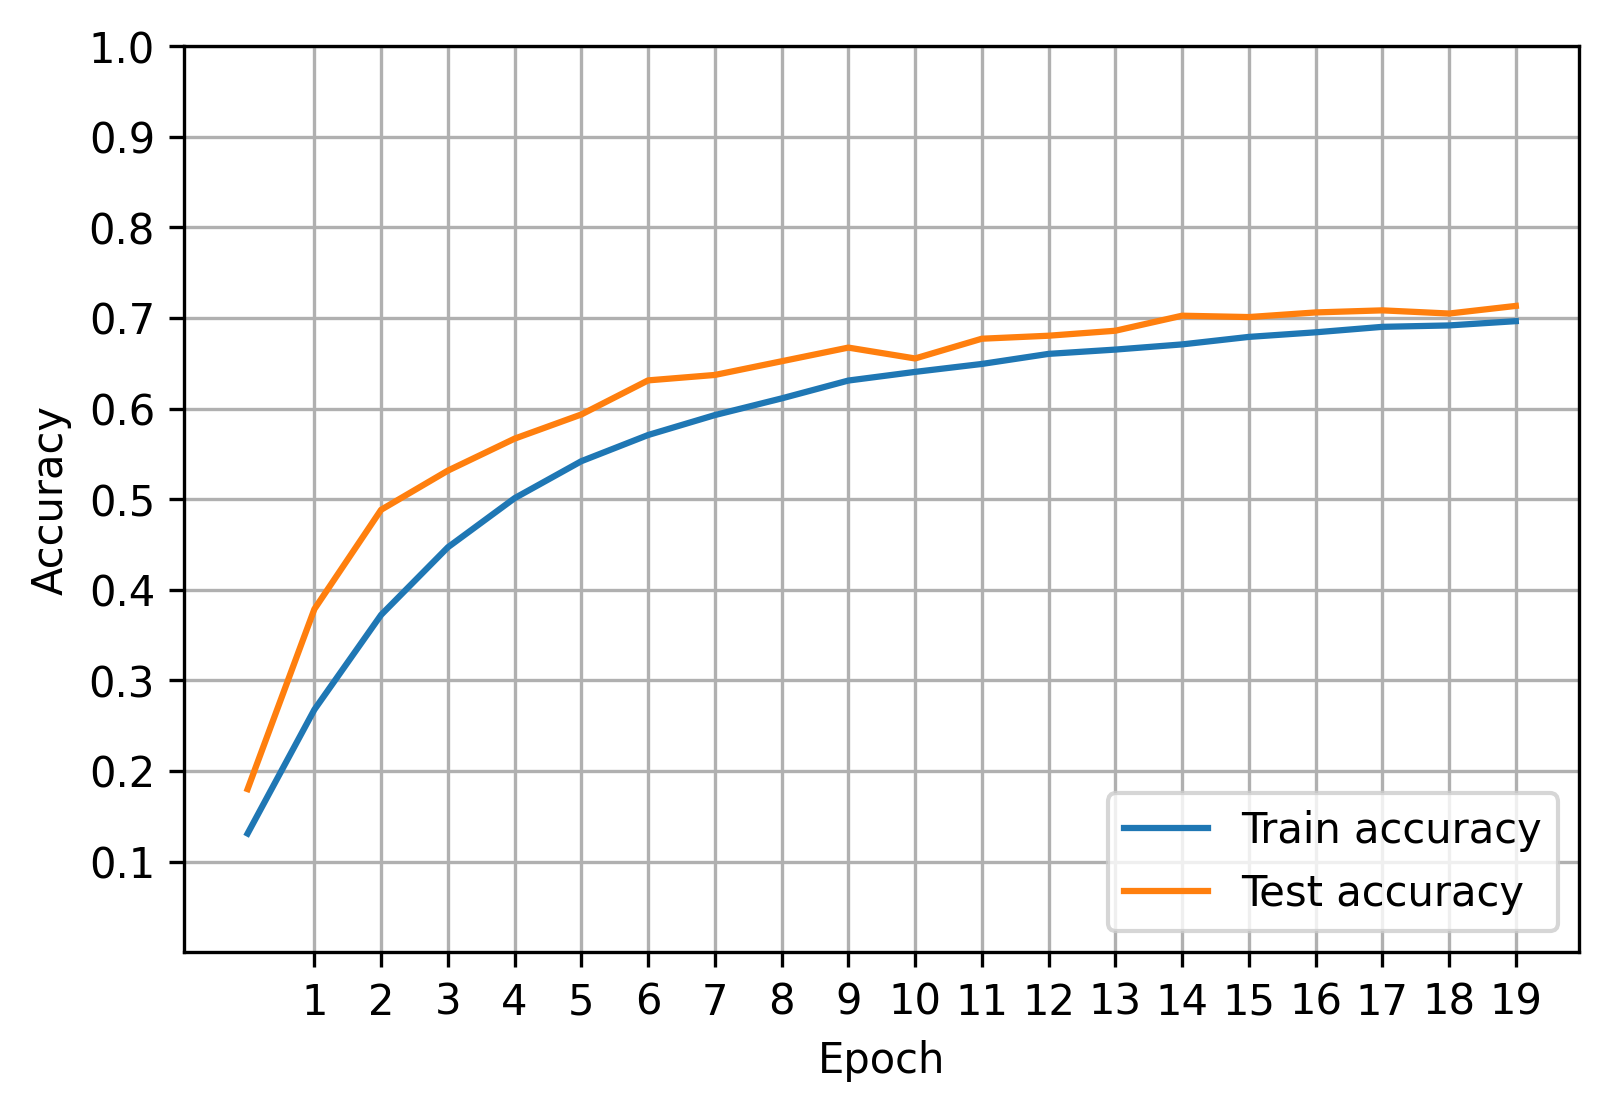

In [ ]:
model, history, test_acc, test_loss = relu_train_output
print("Test acc:", test_acc)
plot_performance(history)

In [ ]:
history.history

{'accuracy': [0.1309400051832199,
  0.267659991979599,
  0.37229999899864197,
  0.4468800127506256,
  0.5010799765586853,
  0.541920006275177,
  0.5708000063896179,
  0.5928000211715698,
  0.6111999750137329,
  0.6309199929237366,
  0.6404799818992615,
  0.6492400169372559,
  0.6603599786758423,
  0.6650999784469604,
  0.6708199977874756,
  0.679099977016449,
  0.6841599941253662,
  0.6901999711990356,
  0.6917600035667419,
  0.6964799761772156],
 'loss': [2.644526243209839,
  2.087198257446289,
  1.824508786201477,
  1.6550084352493286,
  1.5293495655059814,
  1.4400556087493896,
  1.3680126667022705,
  1.3190921545028687,
  1.285130500793457,
  1.2446714639663696,
  1.2136821746826172,
  1.188393473625183,
  1.174794316291809,
  1.1591116189956665,
  1.1474075317382812,
  1.1304765939712524,
  1.1173571348190308,
  1.108646273612976,
  1.0932658910751343,
  1.0857737064361572],
 'val_accuracy': [0.18000000715255737,
  0.37860000133514404,
  0.48829999566078186,
  0.531499981880188,
 

## RELU baseline - wo dropouts

In [ ]:
relu_train_wo_dropouts_output = train(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-wo-dropouts-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    get_model_fn=get_model_wo_dropouts,
    use_test_as_val=True
)

Using given val data
Epoch 1/20
779/782 [============================>.] - ETA: 0s - loss: 2.2858 - accuracy: 0.3565
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-wo-dropouts-2-01.hdf5
782/782 [==============================] - 10s 12ms/step - loss: 2.2844 - accuracy: 0.3566 - val_loss: 1.5846 - val_accuracy: 0.4829
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.4966 - accuracy: 0.5210
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-wo-dropouts-2-02.hdf5
782/782 [==============================] - 9s 12ms/step - loss: 1.4963 - accuracy: 0.5212 - val_loss: 1.4181 - val_accuracy: 0.5477
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 1.3216 - accuracy: 0.5865
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-wo-dropouts-2-03.hdf5
782/782 [==============================] - 9s 12ms/step - loss: 1.3216 -

In [ ]:
get_max_accuracy(relu_train_wo_dropouts_output[1])

{'accuracy': 0.824940025806427, 'val_accuracy': 0.7044000029563904}

In [ ]:
relu_train_wo_dropouts_output = train(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-wo-dropouts-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    get_model_fn=get_model_wo_dropouts,
    use_test_as_val=True
)
get_max_accuracy(relu_train_wo_dropouts_output[1])

Using given val data
Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 1.9334 - accuracy: 0.3908
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-wo-dropouts-3-01.hdf5
782/782 [==============================] - 11s 12ms/step - loss: 1.9326 - accuracy: 0.3910 - val_loss: 1.6178 - val_accuracy: 0.4732
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.4444 - accuracy: 0.5314
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-wo-dropouts-3-02.hdf5
782/782 [==============================] - 9s 11ms/step - loss: 1.4442 - accuracy: 0.5314 - val_loss: 1.3784 - val_accuracy: 0.5479
Epoch 3/20
778/782 [============================>.] - ETA: 0s - loss: 1.2699 - accuracy: 0.5961
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-relu-wo-dropouts-3-03.hdf5
782/782 [==============================] - 9s 12ms/step - loss: 1.2700 -

{'accuracy': 0.8161200284957886, 'val_accuracy': 0.7123000025749207}

In [ ]:
relu_train_wo_dropouts_output = train_or_read(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    get_model_fn=get_model_wo_dropouts,
    use_test_as_val=True
)

170508288/170498071 [==============================] - 2s 0us/step
Reading model from file


In [ ]:
print(get_max_accuracy(relu_train_wo_dropouts_output[1]))

{'accuracy': 0.8133800029754639, 'val_accuracy': 0.7121000289916992}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.71210, 0.71230, 0.70440]
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7096 +- 0.0036778616975991062


In [ ]:
print("Train accuracy mean:")
train_accs = [0.81338, 0.81612, 0.82494]
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8181466666666667 +- 0.004932134989591797


Test acc: 0.7121000289916992


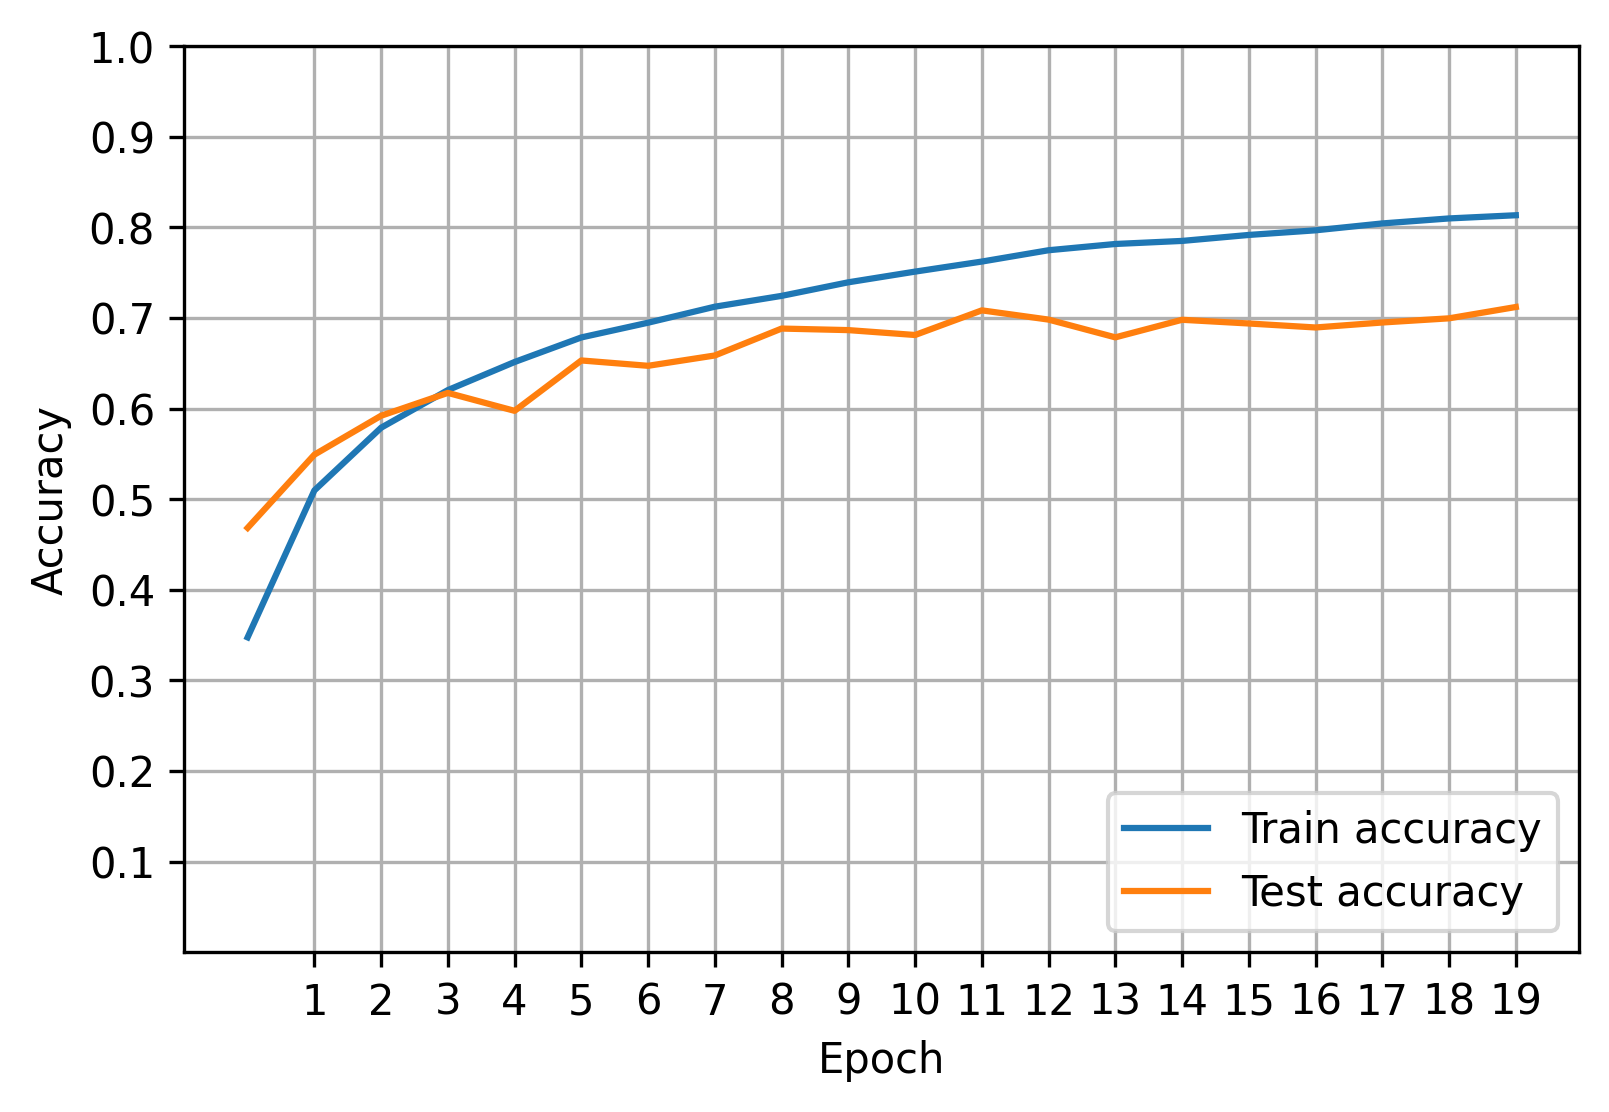

In [ ]:
model, history, test_acc, test_loss = relu_train_wo_dropouts_output
print("Test acc:", test_acc)
plot_performance(history)

In [ ]:
history.history

{'accuracy': [0.34747999906539917,
  0.5096399784088135,
  0.5788599848747253,
  0.6203799843788147,
  0.6514000296592712,
  0.6785200238227844,
  0.6947799921035767,
  0.712440013885498,
  0.7243800163269043,
  0.739359974861145,
  0.7511600255966187,
  0.7622600197792053,
  0.7747600078582764,
  0.7816600203514099,
  0.785040020942688,
  0.7916399836540222,
  0.7967399954795837,
  0.8043400049209595,
  0.8098599910736084,
  0.8133800029754639],
 'loss': [2.2007358074188232,
  1.506321668624878,
  1.3215398788452148,
  1.207939863204956,
  1.1220097541809082,
  1.0532780885696411,
  1.0052986145019531,
  0.9584422707557678,
  0.9273774027824402,
  0.8878909945487976,
  0.8599351048469543,
  0.841999351978302,
  0.8142617344856262,
  0.7995529174804688,
  0.7943828701972961,
  0.7830905318260193,
  0.7690432667732239,
  0.7547745108604431,
  0.7425511479377747,
  0.7321088910102844],
 'val_accuracy': [0.4683000147342682,
  0.5490999817848206,
  0.5921000242233276,
  0.6172999739646912,

## Alternative training

In [ ]:
relu_alt_output = train(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-alt-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_alt,
    get_model_fn=get_model_wo_dropouts
)

In [ ]:
model, history, test_acc, test_loss = relu_alt_output
print("Test acc:", test_acc)
plot_performance(history)

## Sigmoid

### Train - layer

In [ ]:
train_sigmoid_layer_output = train(
    activation_function=lambda: LayerActivationSigmoid(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-sigmoid-layer-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular
)

In [ ]:
model, history, test_acc, test_loss = relu_alt_output
print("Test acc:", test_acc)
plot_performance(history)

### Val - layer

In [ ]:
train_sigmoid_layer_output = train(
    activation_function=lambda: LayerActivationSigmoid(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-sigmoid-layer-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val
)

In [ ]:
model, history, test_acc, test_loss = relu_alt_output
print("Test acc:", test_acc)
plot_performance(history)

## Tests - train data basic - wo dropouts - 20 epochs

### Test - layer - wo dropouts

In [ ]:
output_train_layer_basic_wo_reg = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-wo-dropouts-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_layer_basic_wo_reg[1]))

Using given val data
Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.7148 - accuracy: 0.4801
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-wo-dropouts-2-01.hdf5
782/782 [==============================] - 20s 24ms/step - loss: 1.7148 - accuracy: 0.4801 - val_loss: 1.4655 - val_accuracy: 0.5552
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.3062 - accuracy: 0.6134
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-wo-dropouts-2-02.hdf5
782/782 [==============================] - 24s 31ms/step - loss: 1.3064 - accuracy: 0.6133 - val_loss: 1.3145 - val_accuracy: 0.6067
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.1596 - accuracy: 0.6610
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-wo-dropouts-2-03.hdf5
782/782 [=======================

In [ ]:
output_train_layer_basic_wo_reg = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-wo-dropouts-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_layer_basic_wo_reg[1]))

Using given val data
Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 1.6430 - accuracy: 0.5032
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-wo-dropouts-3-01.hdf5
782/782 [==============================] - 18s 21ms/step - loss: 1.6426 - accuracy: 0.5032 - val_loss: 1.3779 - val_accuracy: 0.5846
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.2737 - accuracy: 0.6236
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-wo-dropouts-3-02.hdf5
782/782 [==============================] - 16s 20ms/step - loss: 1.2741 - accuracy: 0.6234 - val_loss: 1.1776 - val_accuracy: 0.6543
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.1311 - accuracy: 0.6692
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-wo-dropouts-3-03.hdf5
782/782 [=======================

In [ ]:
output_train_layer_basic_wo_reg = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-wo-dropouts-1-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_layer_basic_wo_reg[1]))

170508288/170498071 [==============================] - 11s 0us/step
Reading model from file
{'accuracy': 0.8671000003814697, 'val_accuracy': 0.7336000204086304}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.73360, 0.73669, 0.72920]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7332 $\pm$ 0.0031
0.7331633333333333 +- 0.003073329718002214


In [ ]:
print("Train accuracy mean:")
train_accs = [0.86710, 0.86886, 0.86655]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8675 $\pm$ 0.0010
0.8675033333333334 +- 0.0009852354484532293


None


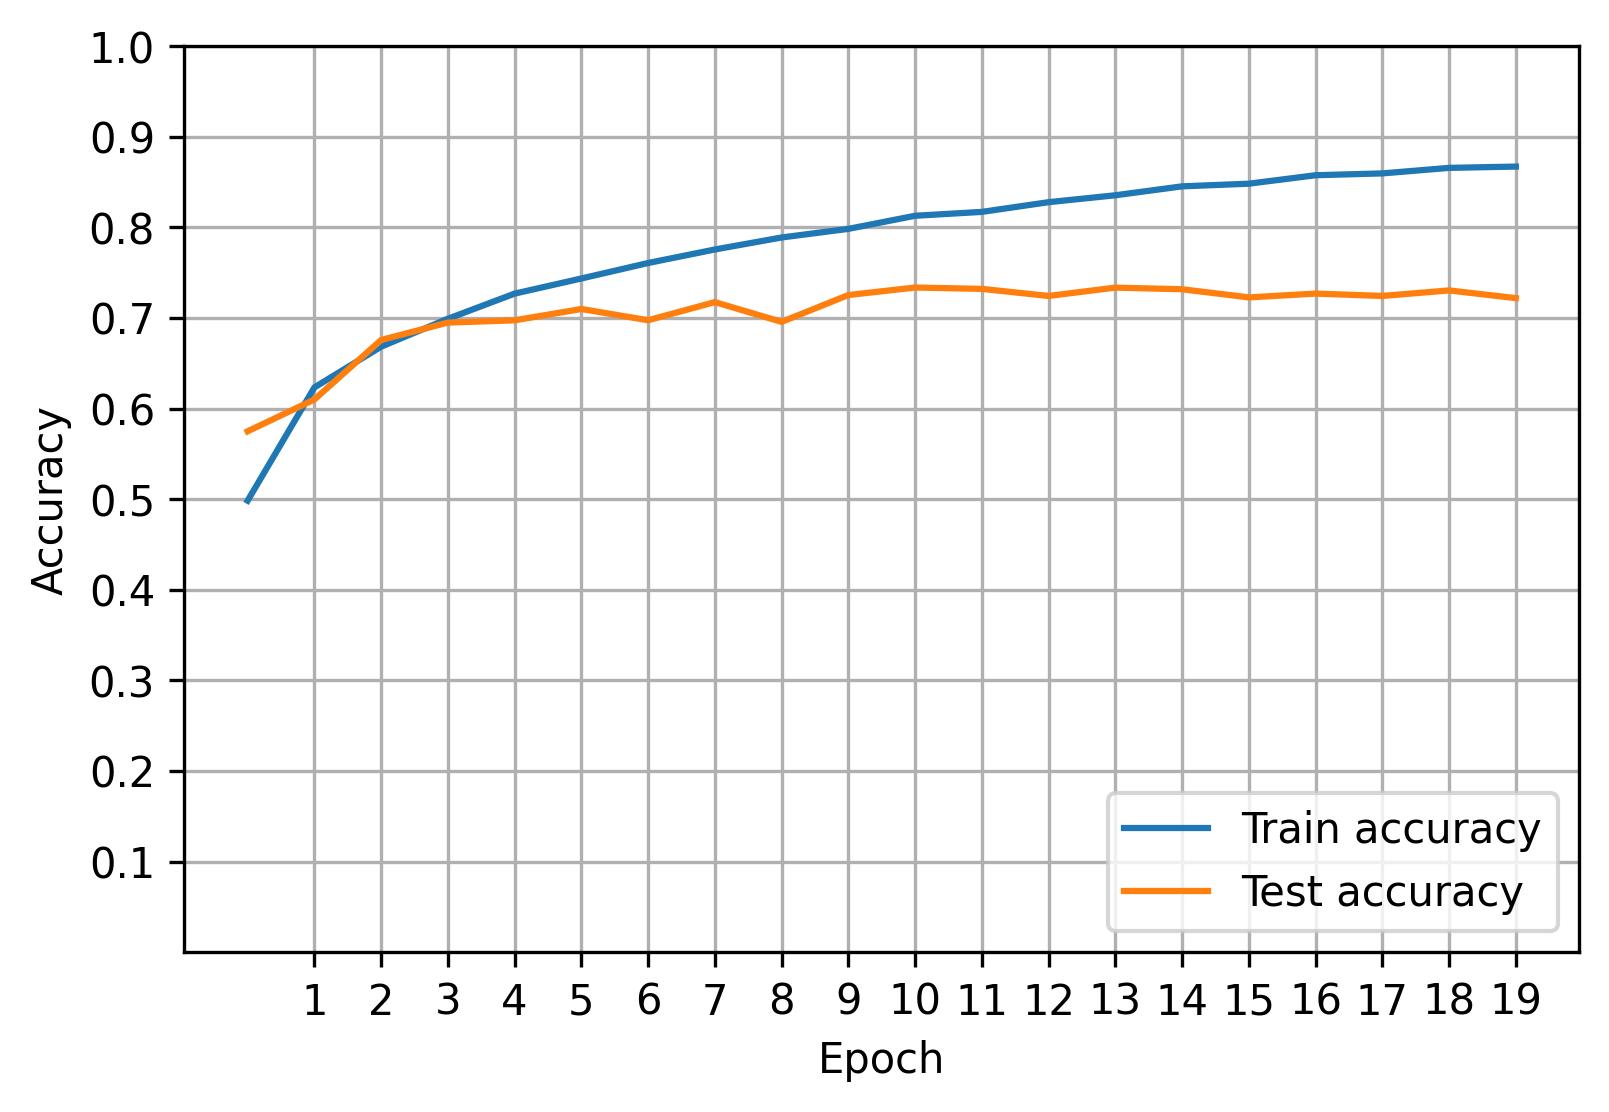

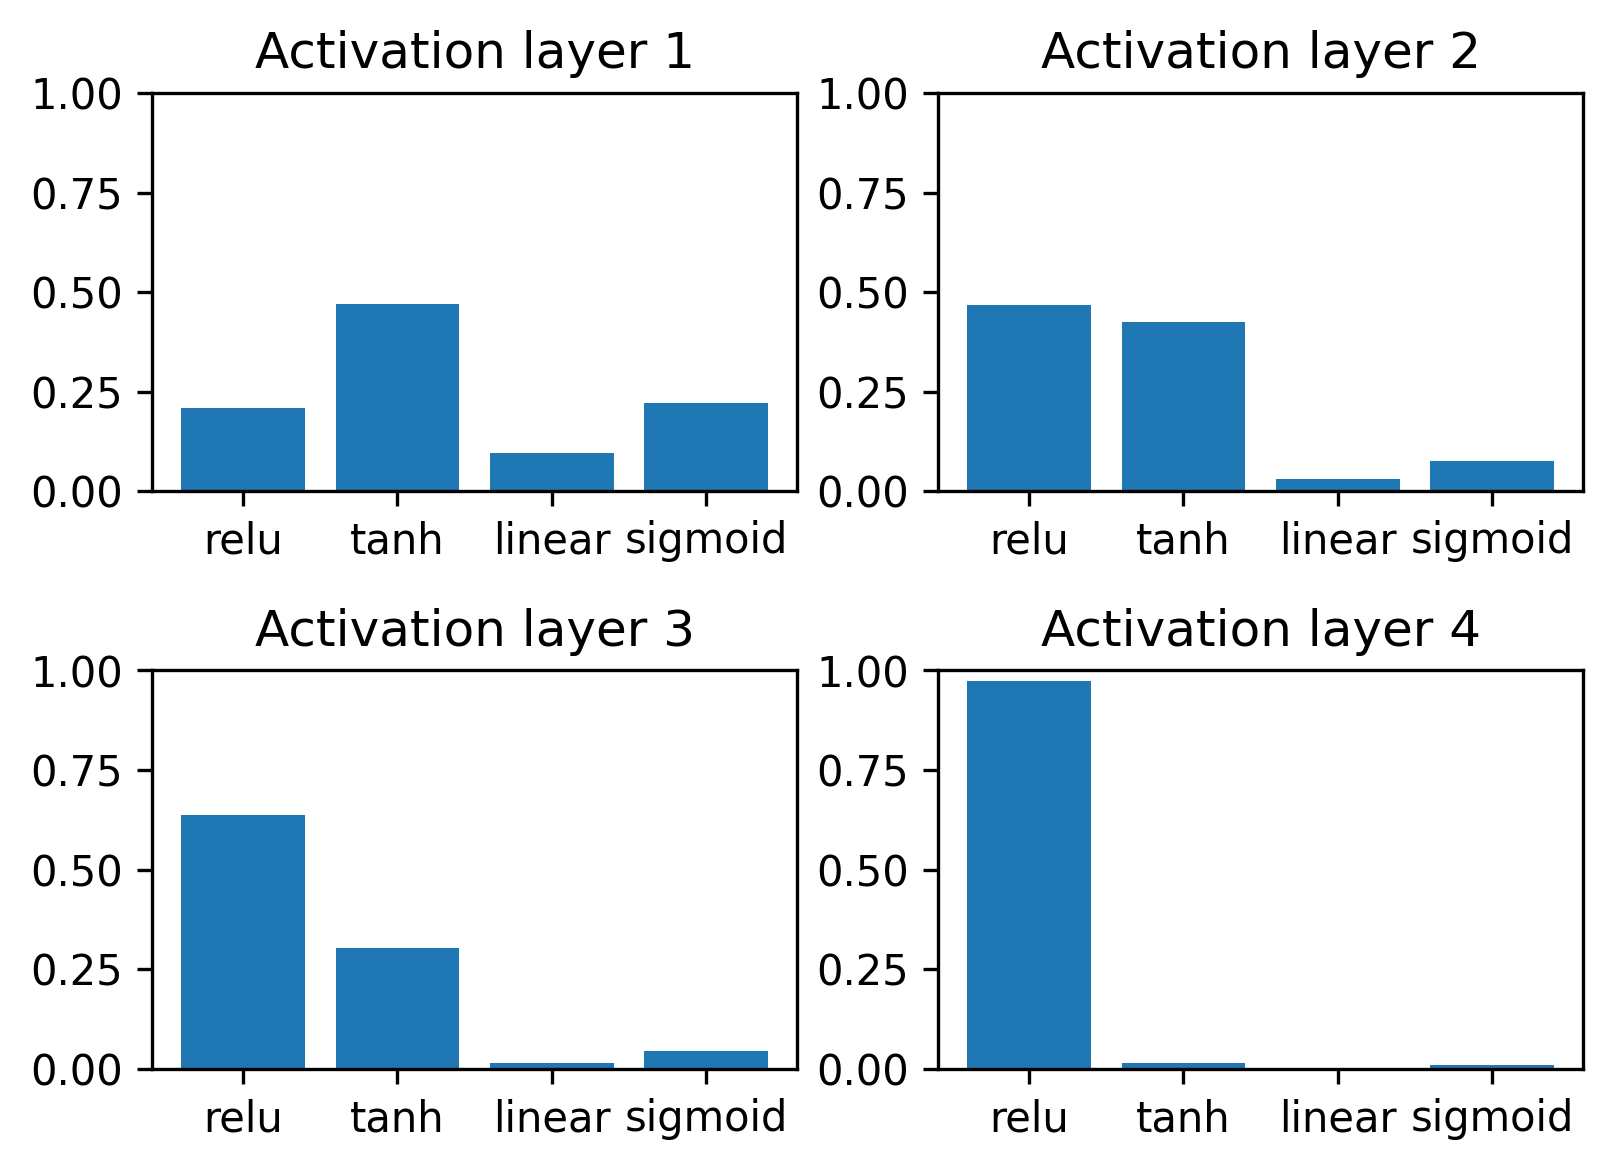

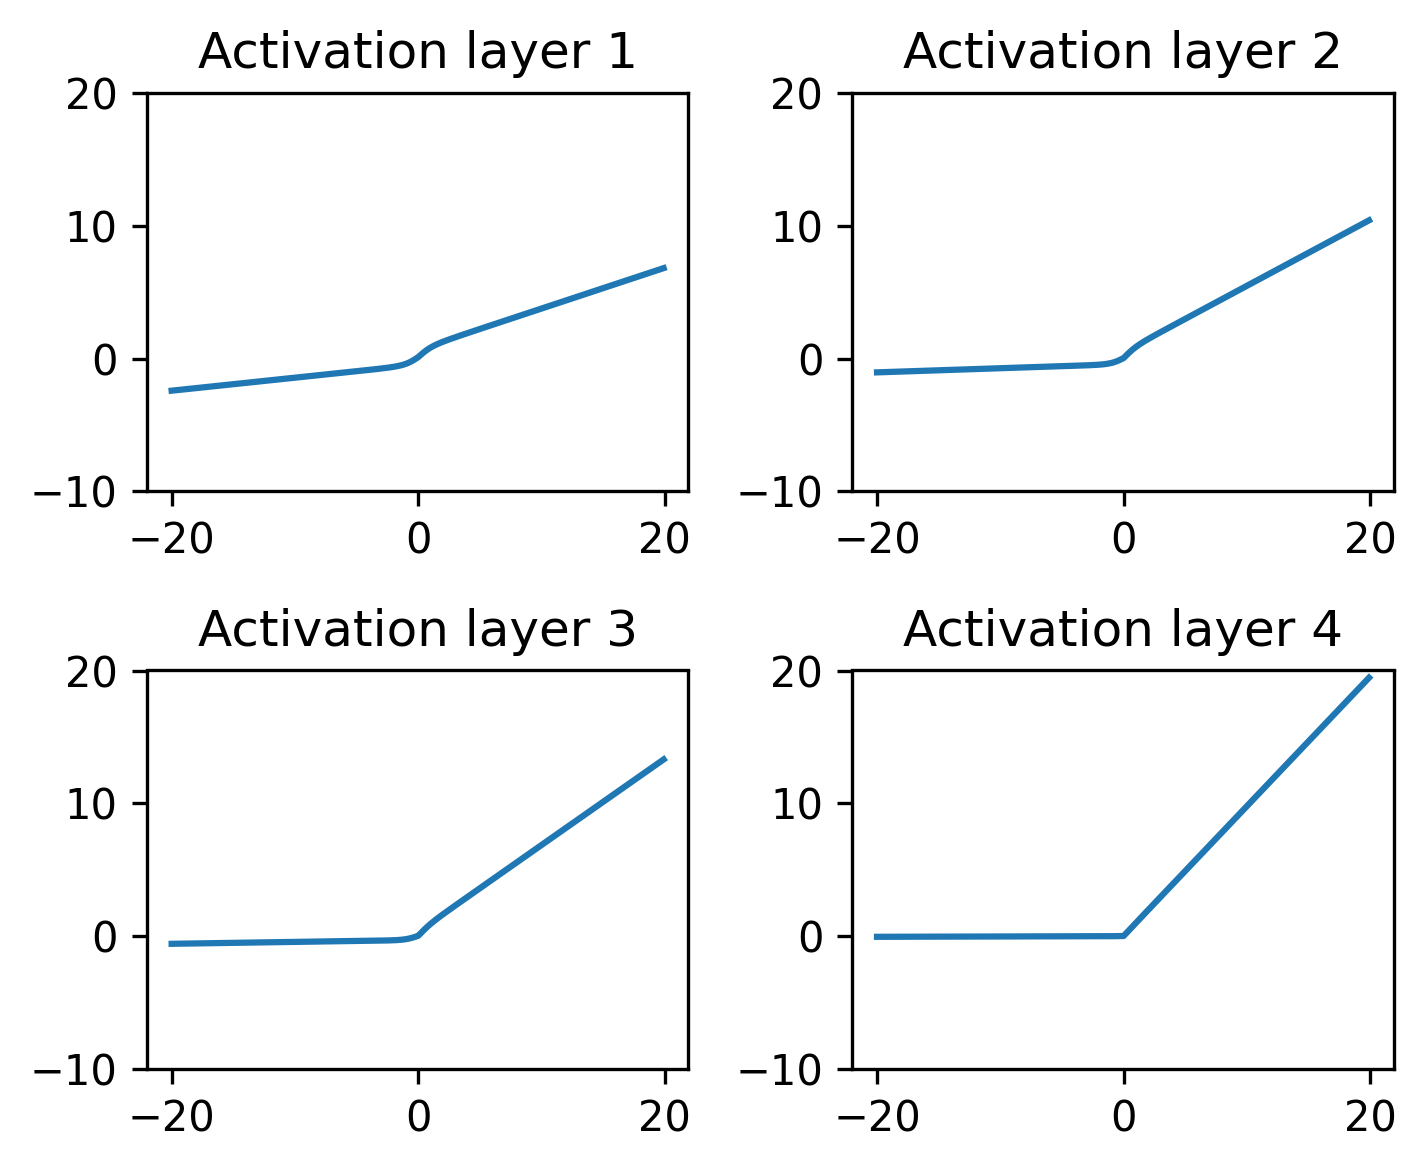

In [ ]:
model, history, test_acc, test_loss = output_train_layer_basic_wo_reg
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')

In [ ]:
history.history

{'accuracy': [0.4983200132846832,
  0.6233000159263611,
  0.6682999730110168,
  0.6991000175476074,
  0.726859986782074,
  0.7435799837112427,
  0.7606599926948547,
  0.7755799889564514,
  0.7888399958610535,
  0.7983400225639343,
  0.8127999901771545,
  0.817080020904541,
  0.8277999758720398,
  0.8354200124740601,
  0.8452799916267395,
  0.8482000231742859,
  0.8575400114059448,
  0.8595600128173828,
  0.8656600117683411,
  0.8671000003814697],
 'loss': [1.6622461080551147,
  1.2764695882797241,
  1.1330583095550537,
  1.0402432680130005,
  0.9738240838050842,
  0.9286696314811707,
  0.8878743648529053,
  0.8616560697555542,
  0.8298360705375671,
  0.8129034638404846,
  0.7832798361778259,
  0.7757669687271118,
  0.7557650804519653,
  0.7429190874099731,
  0.7241846323013306,
  0.7149696350097656,
  0.7004203200340271,
  0.6998593807220459,
  0.6887012720108032,
  0.6858445405960083],
 'val_accuracy': [0.5748999714851379,
  0.6100000143051147,
  0.6757000088691711,
  0.69489997625350

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f3a65f7d710> <function sigmoid at 0x7f3a65821f80>
 <function relu at 0x7f3a2a63c320> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
Epoch 1/20
782/782 [==============================] - 21s 14ms/step - loss: 2.5591 - accuracy: 0.1308 - val_loss: 2.2508 - val_accuracy: 0.2097
Epoch 2/20
782/782 [==============================] - 12s 15ms/step - loss: 2.1195 - accuracy: 0.2616 - val_loss: 1.9163 - val_accuracy: 0.3387
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.7940 - accuracy: 0.3856 - val_loss: 1.6776 - val_accuracy: 

In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f3a65f7d710> <function sigmoid at 0x7f3a65821f80>
 <function relu at 0x7f3a2a63c320> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.5932 - accuracy: 0.1186 - val_loss: 2.4407 - val_accuracy: 0.1202
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 2.2503 - accuracy: 0.2187 - val_loss: 2.0604 - val_accuracy: 0.3069
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.9078 - accuracy: 0.3468 - val_loss: 1.7506 - val_accuracy: 0

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0> <function sigmoid at 0x7f426ab6d680>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function relu at 0x7f422ea45d40> <function tanh at 0x7f426b33cdd0>
 <function sigmoid at 0x7f426ab6d680> <function linear at 0x7f422ea477a0>]
[<function relu at 0x7f422ea45d40> <function tanh at 0x7f426b33cdd0>
 <function sigmoid at 0x7f426ab6d680> <function linear at 0x7f422ea477a0>]
[<function relu at 0x7f422ea45d40> <function tanh at 0x7f426b33cdd0>
 <function sigmoid at 0x7f426ab6d680> <function linear at 0x7f422ea477a0>]
Epoch 1/20
782/782 [==============================] - 18s 21ms/step - loss: 2.6308 - accuracy: 0.1037 - val_loss: 2.4577 - val_accuracy: 0.1048
Epoch 2/20
782/782 [==============================] - 15s 19ms/step - loss: 2.2909 - accuracy: 0.2034 - val_loss: 2.1574 - val_accuracy: 0.2555
Epoch 3/20
782/782 [==============================] - 15s 19ms/step - loss: 2.0242 - accuracy: 0.3011 - val_loss: 1.9237 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7021, 0.7093, 0.7120]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7078 $\pm$ 0.0042
0.7078000000000001 +- 0.004178516483155254


In [ ]:
print("Train accuracy mean:")
train_accs = [0.7340, 0.7396, 0.7270]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7335 $\pm$ 0.0052
0.7335333333333334 +- 0.005154501808020744


In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=2, reset_weights_except_act=True))
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0> <function sigmoid at 0x7f426ab6d680>]
[<function relu at 0x7f422ea45d40> <function tanh at 0x7f426b33cdd0>]
[<function relu at 0x7f422ea45d40> <function tanh at 0x7f426b33cdd0>]
[<function relu at 0x7f422ea45d40> <function tanh at 0x7f426b33cdd0>]
Epoch 1/20
782/782 [==============================] - 13s 15ms/step - loss: 2.4035 - accuracy: 0.0963 - val_loss: 2.3275 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 12s 15ms/step - loss: 2.3173 - accuracy: 0.0998 - val_loss: 2.3085 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 12s 15ms/step - loss: 2.1161 - accuracy: 0.2075 - val_loss: 1.9227 - val_accuracy: 0.2930
Epoch 4/20
782/782 [==============================] - 12s 15ms/step - loss: 1.7769 - accuracy: 0.3635 - val_loss: 1.6482 - val_accuracy: 0.4193
Epoch 5/20
782/782 [==============================] - 12s 15ms/step - loss: 1.6022 - accuracy: 0.4413 - val_loss: 1.5365 - val_accuracy: 0.46

In [ ]:
model_4_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_4_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fec6ffd17a0>]
[<function relu at 0x7fec3368ac20>]
[<function relu at 0x7fec3368ac20>]
[<function relu at 0x7fec3368ac20>]
Epoch 1/20
782/782 [==============================] - 19s 11ms/step - loss: 2.0195 - accuracy: 0.2786 - val_loss: 1.8044 - val_accuracy: 0.3638
Epoch 2/20
782/782 [==============================] - 7s 10ms/step - loss: 1.6741 - accuracy: 0.3987 - val_loss: 1.6092 - val_accuracy: 0.4139
Epoch 3/20
782/782 [==============================] - 7s 10ms/step - loss: 1.5742 - accuracy: 0.4344 - val_loss: 1.5414 - val_accuracy: 0.4446
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 1.5342 - accuracy: 0.4512 - val_loss: 1.5020 - val_accuracy: 0.4600
Epoch 5/20
782/782 [==============================] - 7s 10ms/step - loss: 1.5033 - accuracy: 0.4670 - val_loss: 1.4817 - val_accuracy: 0.4708
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.4715 - accuracy: 0.4754 - val_loss: 1.4602 - val_accuracy: 0.477

In [ ]:
model_4_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f3a65f7d710>]
[<function relu at 0x7f3a2a63c320>]
[<function relu at 0x7f3a2a63c320>]
[<function relu at 0x7f3a2a63c320>]
Epoch 1/20
782/782 [==============================] - 5s 5ms/step - loss: 2.0485 - accuracy: 0.2713 - val_loss: 1.8956 - val_accuracy: 0.3210
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 1.8443 - accuracy: 0.3412 - val_loss: 1.7895 - val_accuracy: 0.3571
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7723 - accuracy: 0.3666 - val_loss: 1.7503 - val_accuracy: 0.3632
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7447 - accuracy: 0.3747 - val_loss: 1.7512 - val_accuracy: 0.3736
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7290 - accuracy: 0.3798 - val_loss: 1.7431 - val_accuracy: 0.3704
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7188 - accuracy: 0.3833 - val_loss: 1.7218 - val_accuracy: 0.3843
Epoc

In [ ]:
model_4 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0>]
[<function relu at 0x7f422ea45d40>]
[<function relu at 0x7f422ea45d40>]
[<function relu at 0x7f422ea45d40>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 2.0962 - accuracy: 0.2372 - val_loss: 1.8284 - val_accuracy: 0.3357
Epoch 2/20
782/782 [==============================] - 8s 11ms/step - loss: 1.7930 - accuracy: 0.3425 - val_loss: 1.7403 - val_accuracy: 0.3638
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7236 - accuracy: 0.3696 - val_loss: 1.6937 - val_accuracy: 0.3806
Epoch 4/20
782/782 [==============================] - 8s 11ms/step - loss: 1.6817 - accuracy: 0.3868 - val_loss: 1.6410 - val_accuracy: 0.4043
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6421 - accuracy: 0.4041 - val_loss: 1.6176 - val_accuracy: 0.4167
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6186 - accuracy: 0.4155 - val_loss: 1.5908 - val_accuracy: 0.425

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4693, 0.4088, 0.5157]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.4646 $\pm$ 0.0438
0.46460000000000007 +- 0.04376810101736959


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4774, 0.4187, 0.5194]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.4718 $\pm$ 0.0413
0.4718333333333333 +- 0.041298614450796696


### Test - kernel - wo dropouts

In [ ]:
output_train_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-basic-wo-dropouts-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_kernel[1]))

Using given val data
Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.7261 - accuracy: 0.4786
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-wo-dropouts-2-01.hdf5
782/782 [==============================] - 19s 23ms/step - loss: 1.7260 - accuracy: 0.4787 - val_loss: 1.4720 - val_accuracy: 0.5482
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 1.3277 - accuracy: 0.6040
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-wo-dropouts-2-02.hdf5
782/782 [==============================] - 17s 22ms/step - loss: 1.3277 - accuracy: 0.6040 - val_loss: 1.2397 - val_accuracy: 0.6358
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.1813 - accuracy: 0.6520
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-wo-dropouts-2-03.hdf5
782/782 [====================

In [ ]:
output_train_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-basic-wo-dropouts-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_kernel[1]))

Using given val data
Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 1.6894 - accuracy: 0.4882
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-wo-dropouts-3-01.hdf5
782/782 [==============================] - 20s 23ms/step - loss: 1.6894 - accuracy: 0.4882 - val_loss: 1.4027 - val_accuracy: 0.5830
Epoch 2/20
781/782 [============================>.] - ETA: 0s - loss: 1.2930 - accuracy: 0.6163
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-wo-dropouts-3-02.hdf5
782/782 [==============================] - 18s 22ms/step - loss: 1.2929 - accuracy: 0.6163 - val_loss: 1.2374 - val_accuracy: 0.6334
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.1492 - accuracy: 0.6630
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-wo-dropouts-3-03.hdf5
782/782 [====================

In [ ]:
output_train_kernel = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-basic-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_kernel[1]))

Reading model from file
{'accuracy': 0.8486800193786621, 'val_accuracy': 0.7365999817848206}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.73659, 0.72979, 0.72979]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7321 $\pm$ 0.0032
0.7320566666666667 +- 0.0032055507413789766


In [ ]:
print("Train accuracy mean:")
train_accs = [0.84868, 0.85170, 0.84750]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8493 $\pm$ 0.0018
0.8492933333333333 +- 0.0017686404068913714


0.730400025844574


{'accuracy': [0.4797399938106537,
  0.6100999712944031,
  0.6568999886512756,
  0.6855199933052063,
  0.7084199786186218,
  0.7246999740600586,
  0.735260009765625,
  0.7519999742507935,
  0.7642800211906433,
  0.7727199792861938,
  0.7836400270462036,
  0.7918000221252441,
  0.801360011100769,
  0.8080199956893921,
  0.8161799907684326,
  0.8240399956703186,
  0.8314999938011169,
  0.8394799828529358,
  0.8413400053977966,
  0.8486800193786621],
 'loss': [1.7270201444625854,
  1.3154127597808838,
  1.1726566553115845,
  1.083115816116333,
  1.017747163772583,
  0.9731168746948242,
  0.9437007308006287,
  0.9062409996986389,
  0.8814266920089722,
  0.863616943359375,
  0.8392196297645569,
  0.822101891040802,
  0.8020321726799011,
  0.7930328845977783,
  0.7761914730072021,
  0.7609617114067078,
  0.7472448945045471,
  0.7327880263328552,
  0.730525553226471,
  0.7145012617111206],
 'val_accuracy': [0.5788999795913696,
  0.6474000215530396,
  0.6599000096321106,
  0.6682999730110168,
 

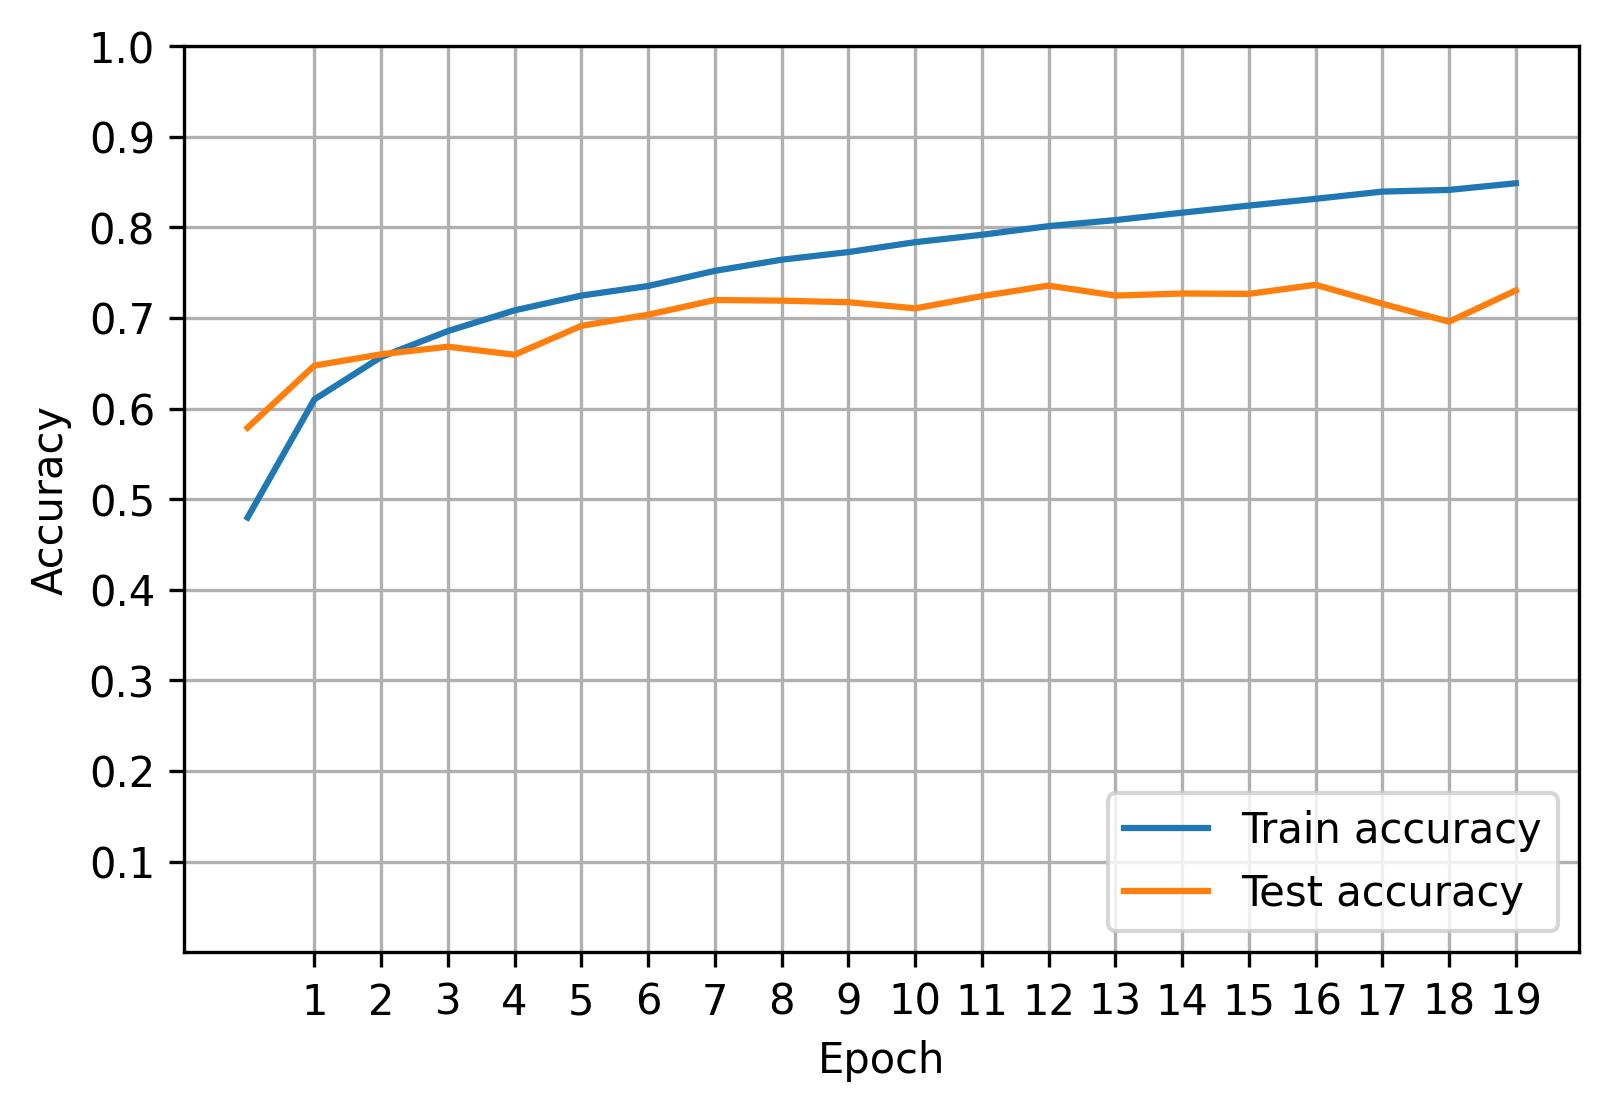

In [ ]:
model, history, test_acc, test_loss = output_train_layer
print(test_acc)
plot_performance(history)
display(history.history)

### Test - neuron - wo dropouts

In [ ]:
output_train_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-basic-wo-dropouts-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_neuron[1]))

Using given val data
Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 1.6782 - accuracy: 0.4922
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-wo-dropouts-2-01.hdf5
782/782 [==============================] - 19s 23ms/step - loss: 1.6782 - accuracy: 0.4922 - val_loss: 1.4410 - val_accuracy: 0.5767
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 1.2956 - accuracy: 0.6150
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-wo-dropouts-2-02.hdf5
782/782 [==============================] - 18s 23ms/step - loss: 1.2956 - accuracy: 0.6150 - val_loss: 1.2380 - val_accuracy: 0.6396
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 1.1604 - accuracy: 0.6575
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-wo-dropouts-2-03.hdf5
782/782 [====================

In [ ]:
output_train_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-basic-wo-dropouts-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_neuron[1]))

Using given val data
Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.7325 - accuracy: 0.4808
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-wo-dropouts-3-01.hdf5
782/782 [==============================] - 19s 23ms/step - loss: 1.7323 - accuracy: 0.4808 - val_loss: 1.4504 - val_accuracy: 0.5658
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.3236 - accuracy: 0.6051
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-wo-dropouts-3-02.hdf5
782/782 [==============================] - 17s 22ms/step - loss: 1.3232 - accuracy: 0.6052 - val_loss: 1.3276 - val_accuracy: 0.6093
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.1873 - accuracy: 0.6504
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-wo-dropouts-3-03.hdf5
782/782 [====================

In [ ]:
output_train_neuron = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-basic-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_neuron[1]))

Reading model from file
{'accuracy': 0.8527399897575378, 'val_accuracy': 0.722000002861023}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.72200, 0.72000, 0.72320]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7217 $\pm$ 0.0013
0.7217333333333333 +- 0.0013199326582148817


In [ ]:
print("Train accuracy mean:")
train_accs = [0.85273, 0.84589, 0.85013]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8496 $\pm$ 0.0028
0.8495833333333334 +- 0.002819046332046024


## Tests - train data basic - 20 epochs

### Test - layer

In [ ]:
output_train_layer_smaller = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-smaller-1-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_smaller,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Using given val data
Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 1.7278 - accuracy: 0.4508
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-smaller-1-01.hdf5
782/782 [==============================] - 18s 21ms/step - loss: 1.7271 - accuracy: 0.4510 - val_loss: 1.3445 - val_accuracy: 0.5607
Epoch 2/20
779/782 [============================>.] - ETA: 0s - loss: 1.2915 - accuracy: 0.5839
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-smaller-1-02.hdf5
782/782 [==============================] - 15s 20ms/step - loss: 1.2909 - accuracy: 0.5841 - val_loss: 1.1671 - val_accuracy: 0.6264
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.1567 - accuracy: 0.6304
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-smaller-1-03.hdf5
782/782 [==============================] - 1

0.7475000023841858


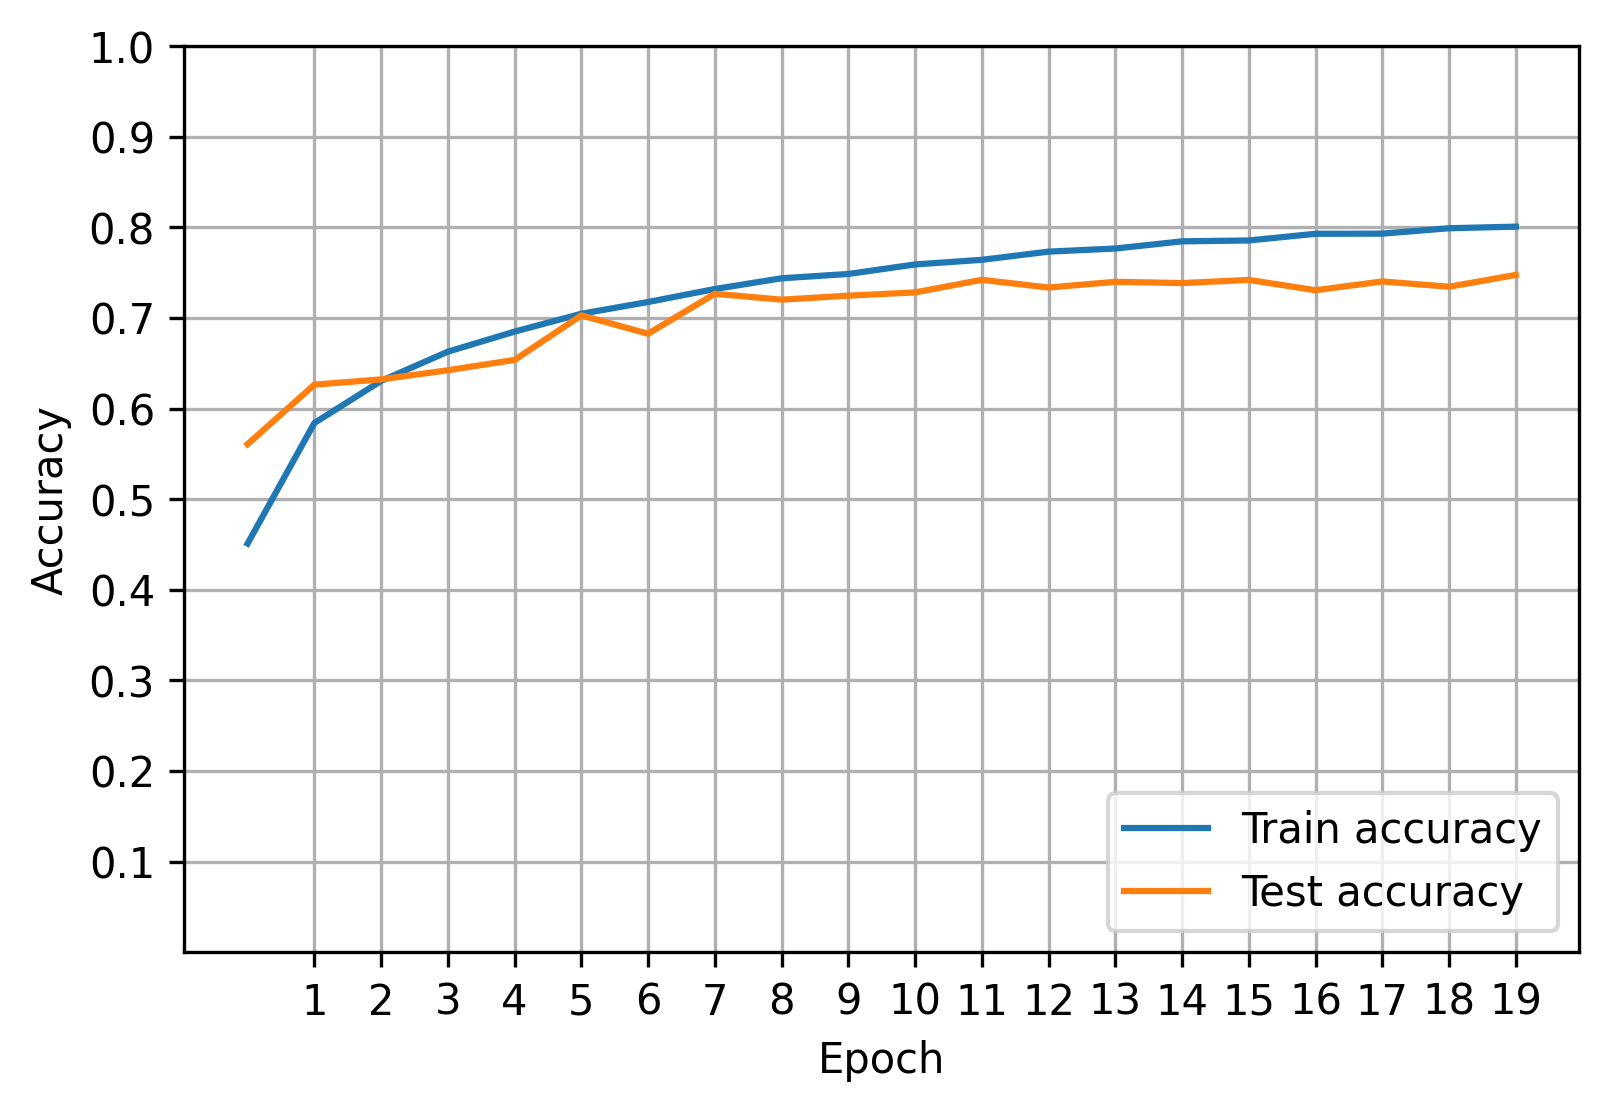

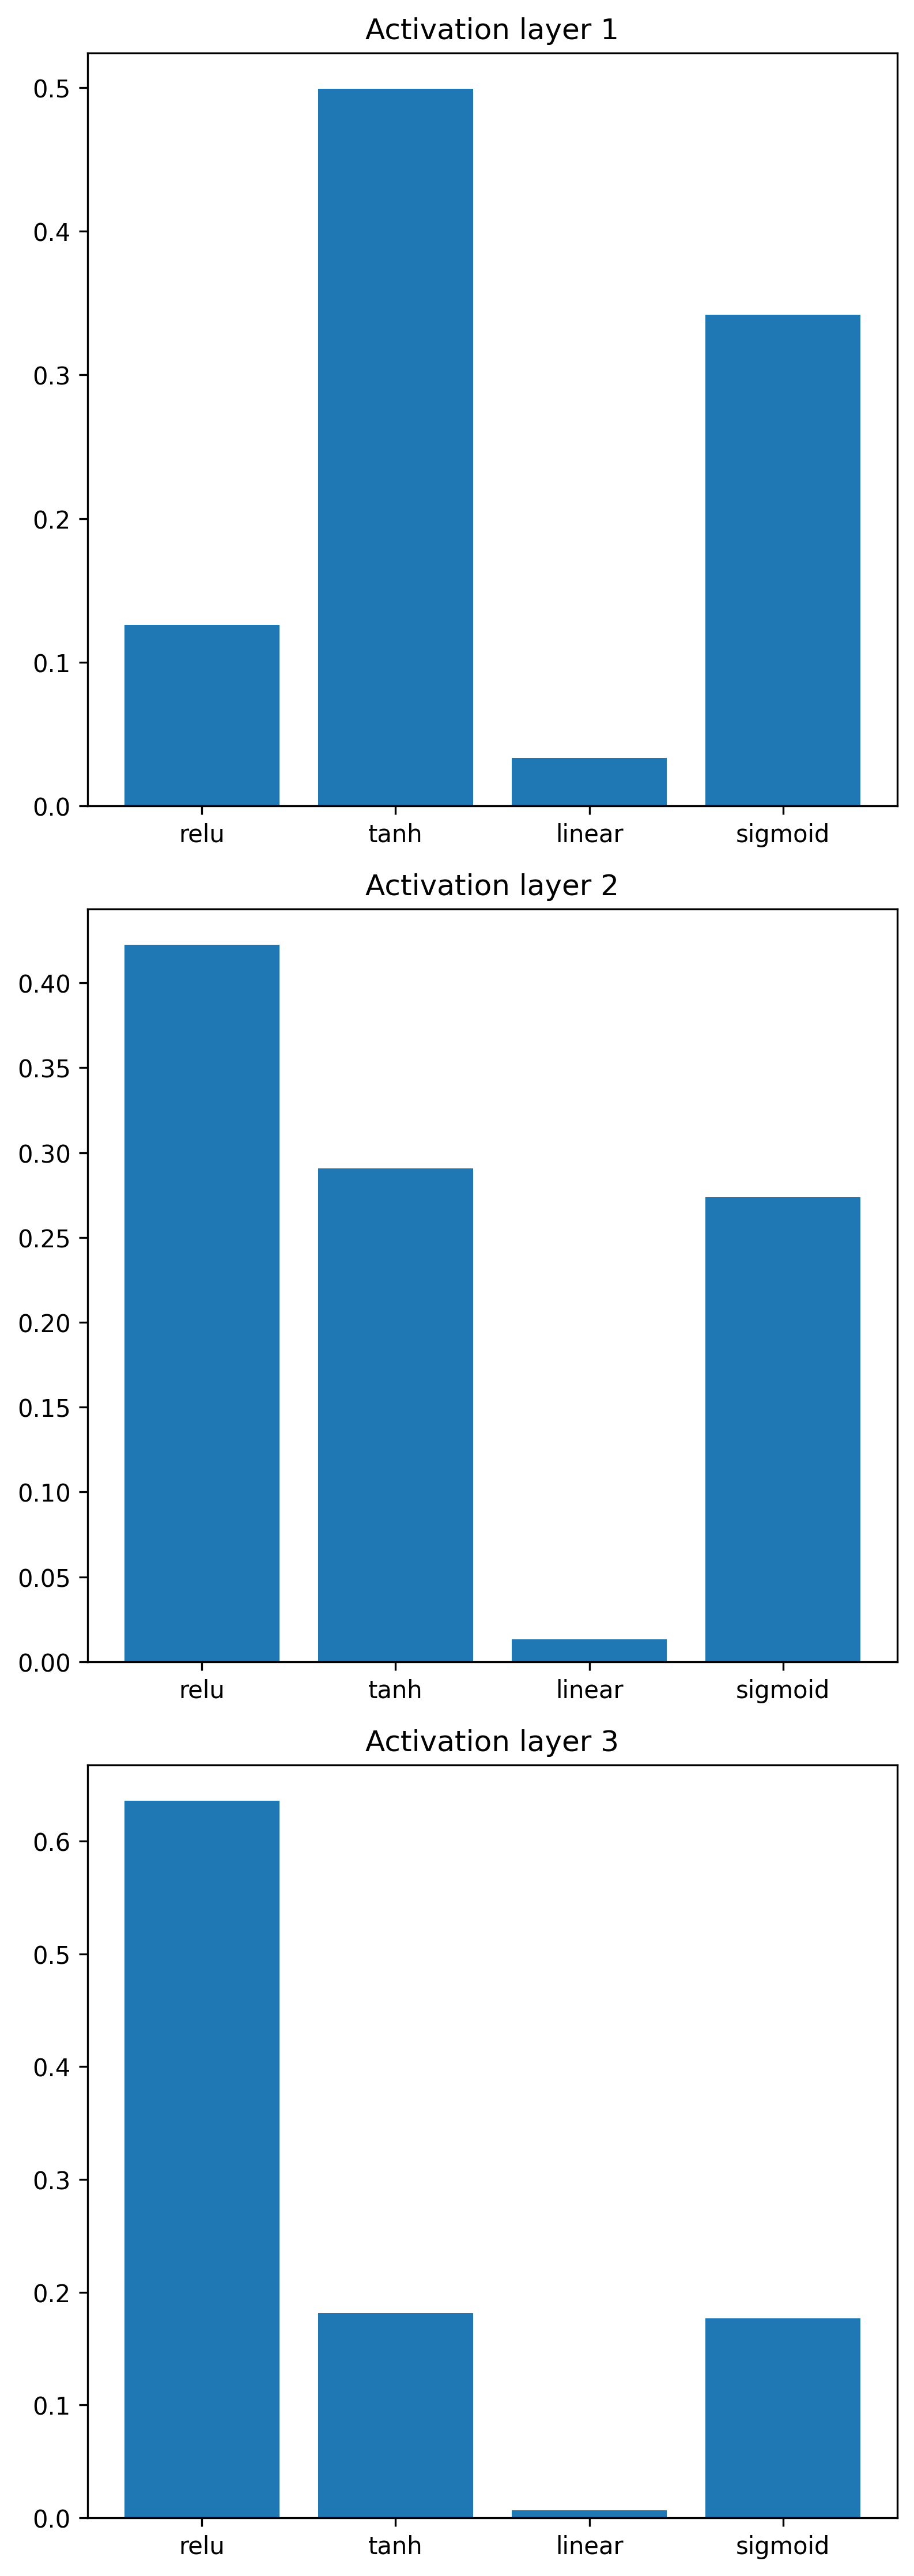

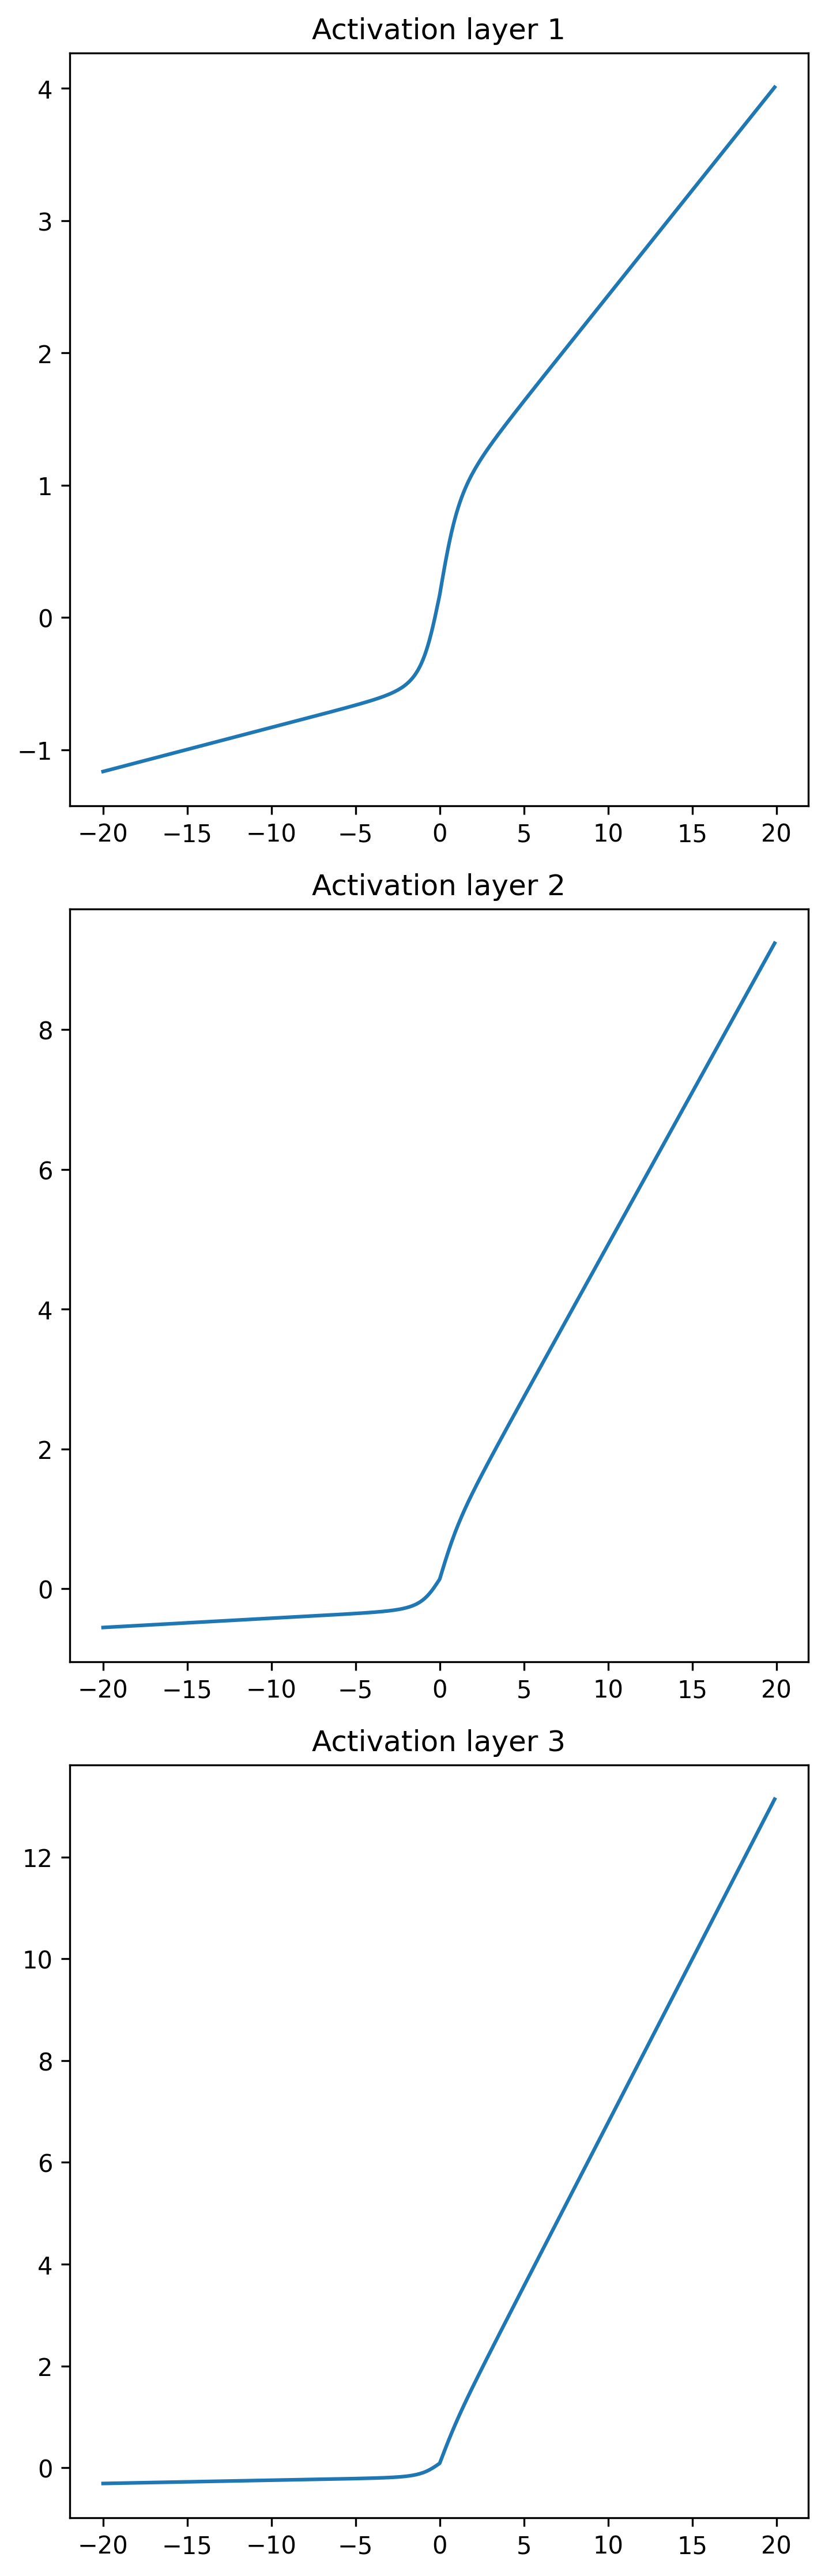

In [ ]:
model, history, test_acc, test_loss = output_train_layer_smaller
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=5, mode='default')
plot_activation_functions([model], width=5, height=5, mode='default')

In [ ]:
output_train_layer_basic = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_layer_basic[1]))

Using given val data
Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 1.8972 - accuracy: 0.4221
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-2-01.hdf5
782/782 [==============================] - 18s 21ms/step - loss: 1.8966 - accuracy: 0.4222 - val_loss: 1.4479 - val_accuracy: 0.5605
Epoch 2/20
779/782 [============================>.] - ETA: 0s - loss: 1.4526 - accuracy: 0.5562
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-2-02.hdf5
782/782 [==============================] - 16s 20ms/step - loss: 1.4528 - accuracy: 0.5562 - val_loss: 1.2725 - val_accuracy: 0.6215
Epoch 3/20
780/782 [============================>.] - ETA: 0s - loss: 1.3175 - accuracy: 0.6005
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-2-03.hdf5
782/782 [==============================] - 16s 20ms/step - loss: 1.3

In [ ]:
output_train_layer_basic = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_layer_basic[1]))

Using given val data
Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 1.9158 - accuracy: 0.4155
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-3-01.hdf5
782/782 [==============================] - 22s 26ms/step - loss: 1.9155 - accuracy: 0.4156 - val_loss: 1.4747 - val_accuracy: 0.5546
Epoch 2/20
781/782 [============================>.] - ETA: 0s - loss: 1.4638 - accuracy: 0.5539
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-3-02.hdf5
782/782 [==============================] - 21s 26ms/step - loss: 1.4638 - accuracy: 0.5539 - val_loss: 1.2586 - val_accuracy: 0.6214
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.3211 - accuracy: 0.6006
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-layer-basic-3-03.hdf5
782/782 [==============================] - 20s 26ms/step - loss: 1.3

In [ ]:
output_train_layer_basic = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-1-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_layer_basic[1]))

Reading model from file
{'accuracy': 0.7717800140380859, 'val_accuracy': 0.7602999806404114}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.76029, 0.77120, 0.75940]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7636 $\pm$ 0.0054
0.76363 +- 0.0053651157179194844


In [ ]:
print("Train accuracy mean:")
train_accs = [0.77178, 0.77333, 0.77208]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7724 $\pm$ 0.0007
0.7723966666666667 +- 0.0006712343521867197


None


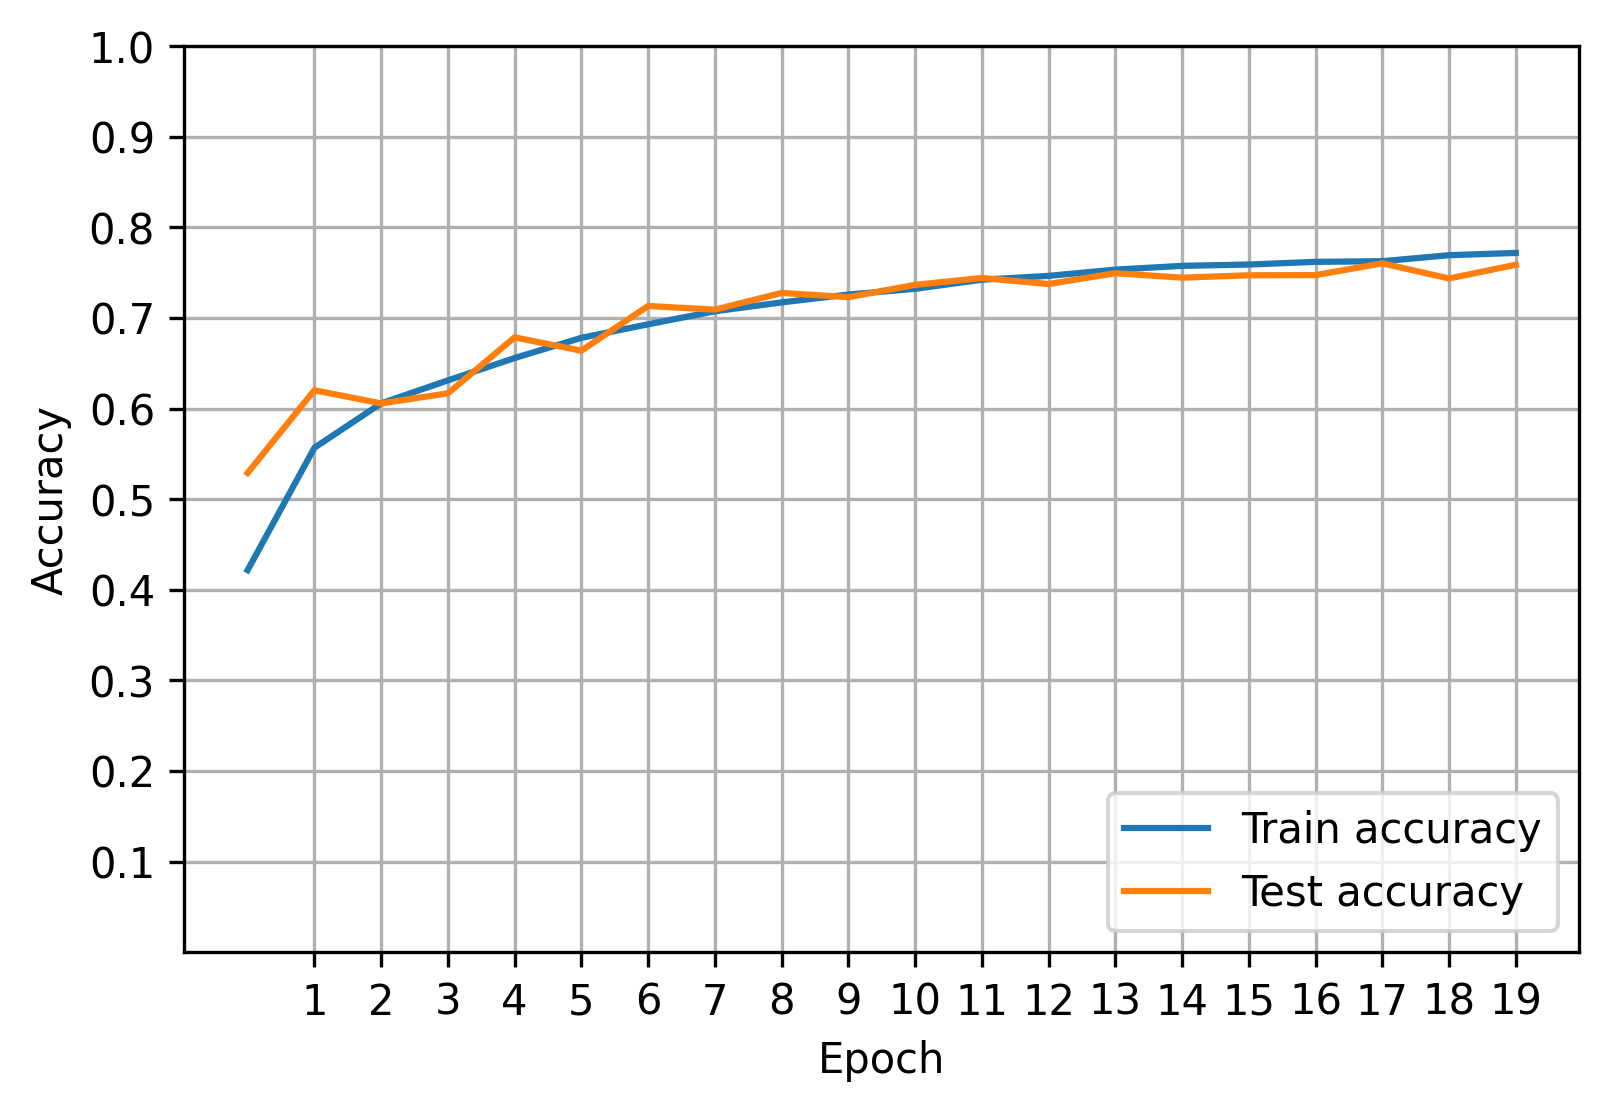

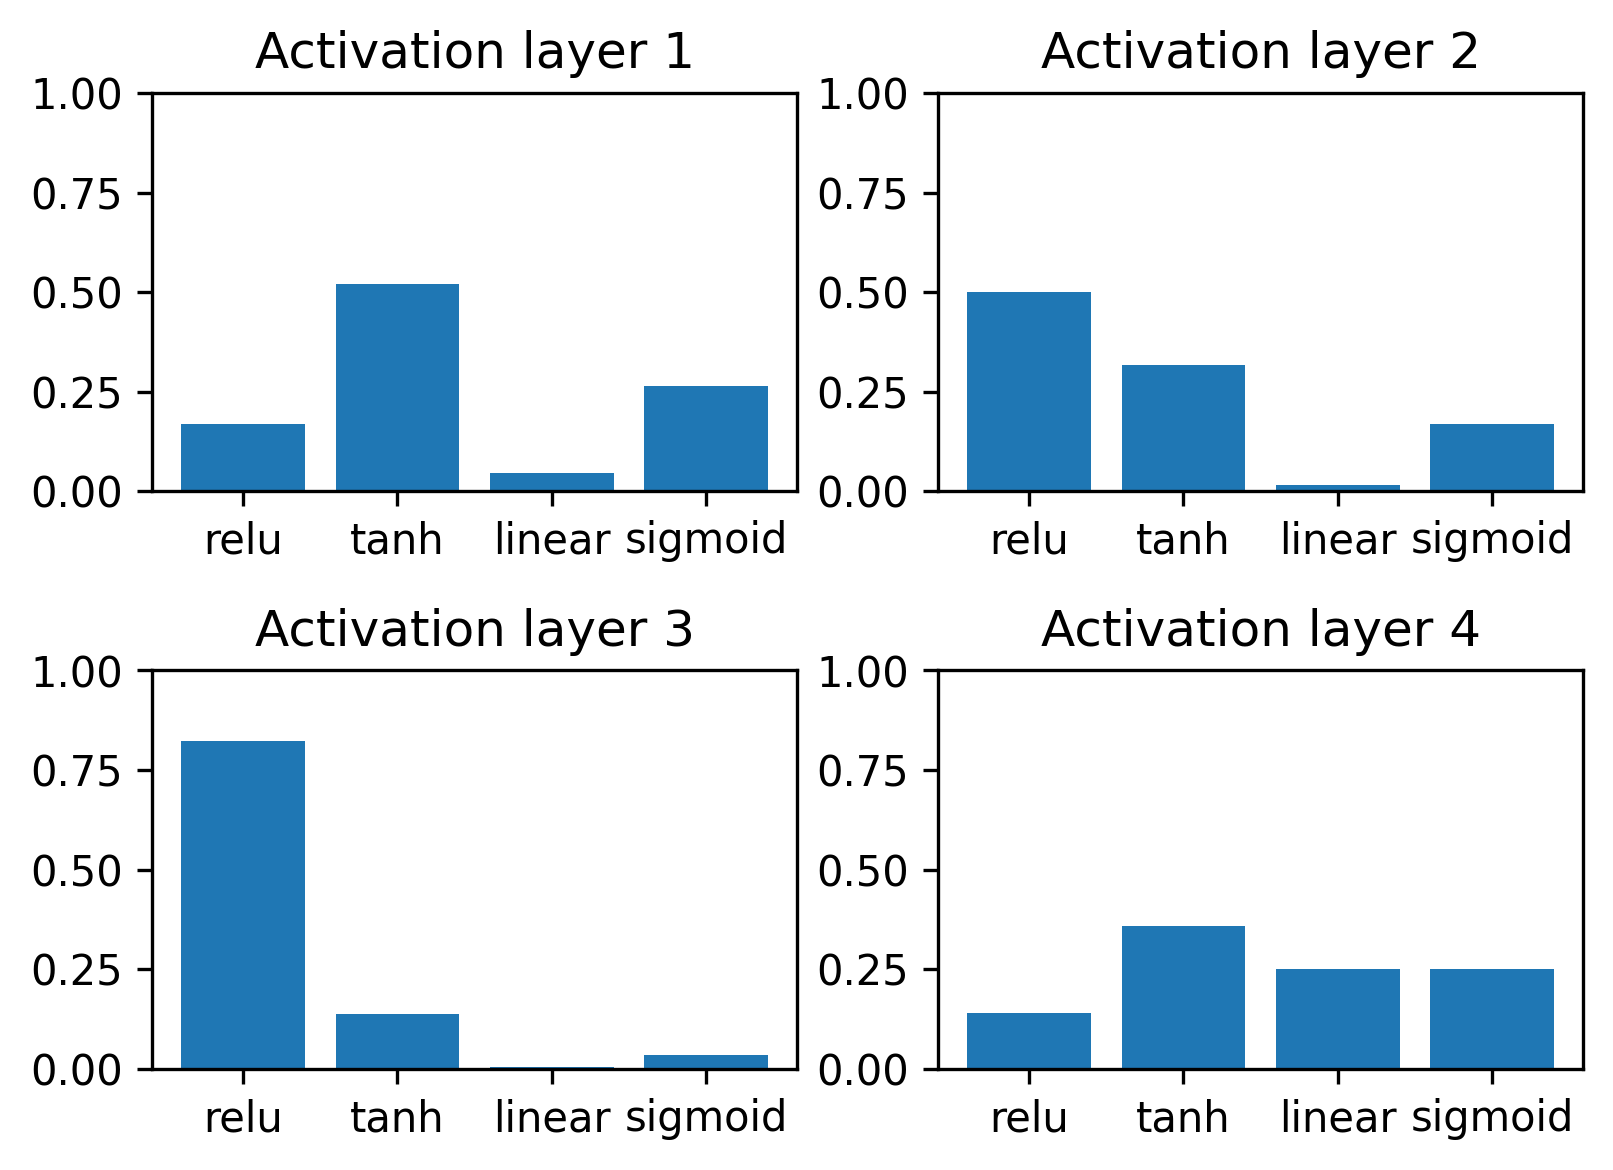

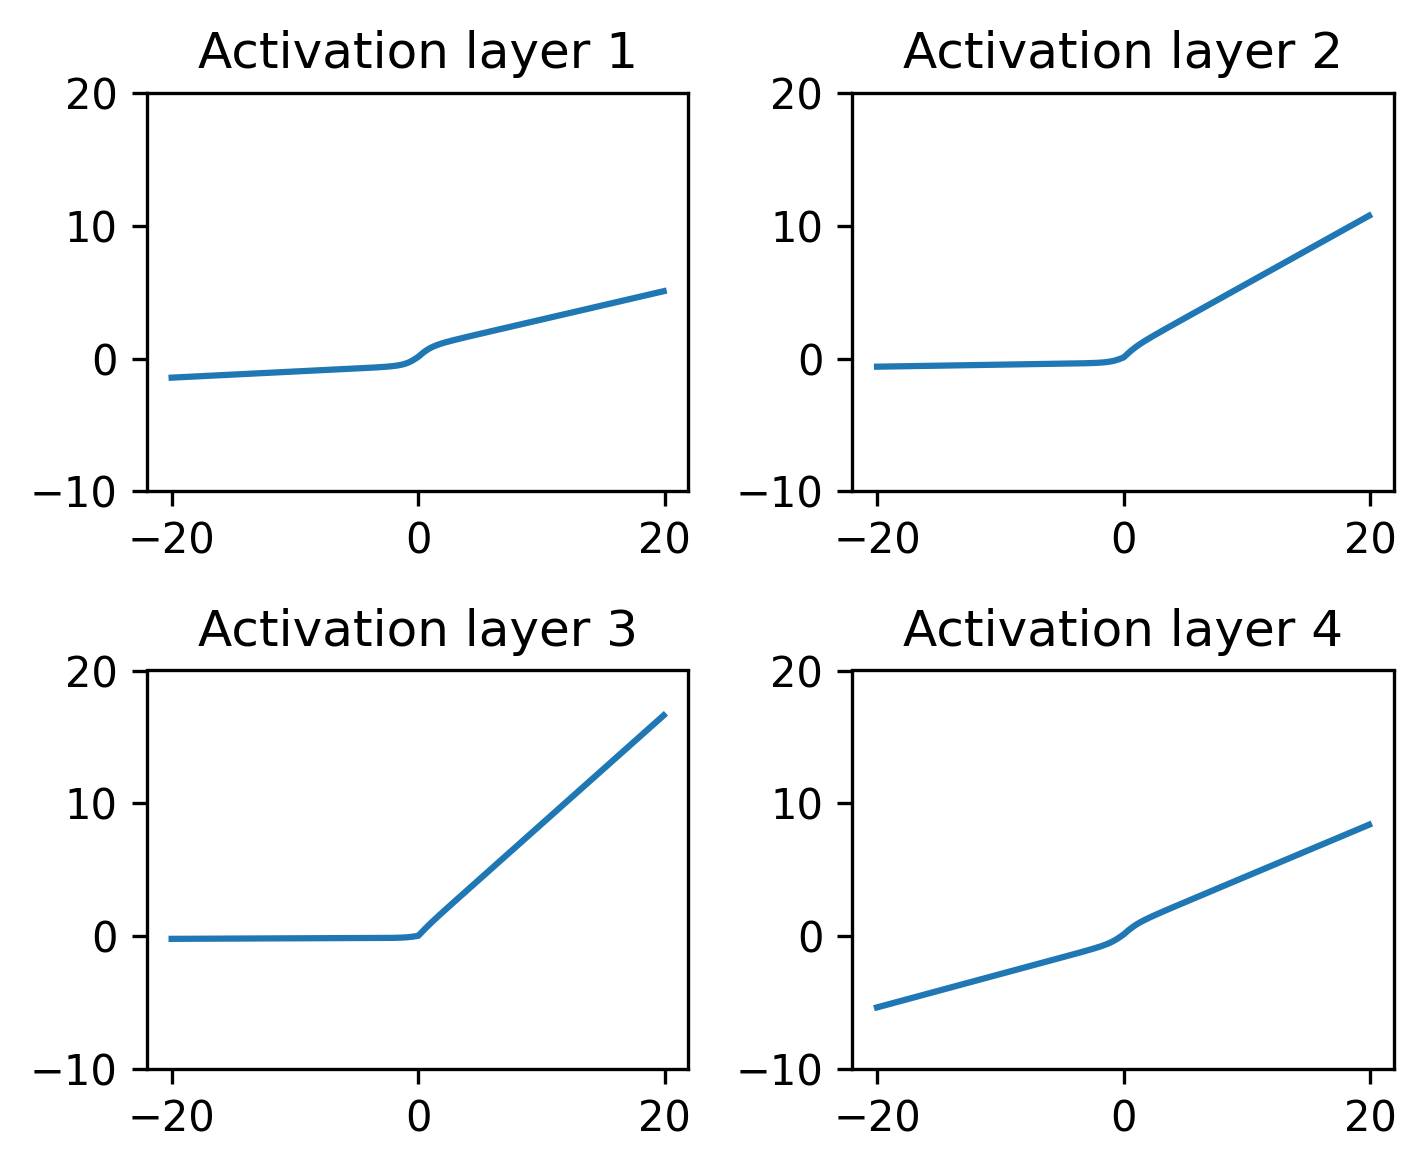

In [ ]:
model, history, test_acc, test_loss = output_train_layer_basic
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')

In [ ]:
history.history

{'accuracy': [0.42166000604629517,
  0.5566999912261963,
  0.6057400107383728,
  0.6310999989509583,
  0.655780017375946,
  0.678059995174408,
  0.6930000185966492,
  0.7074000239372253,
  0.7171599864959717,
  0.7258599996566772,
  0.7321599721908569,
  0.7422400116920471,
  0.7464600205421448,
  0.7533400058746338,
  0.7575200200080872,
  0.7589600086212158,
  0.7619400024414062,
  0.762660026550293,
  0.7692800164222717,
  0.7717800140380859],
 'loss': [1.8940112590789795,
  1.4563080072402954,
  1.3089656829833984,
  1.224333643913269,
  1.1651511192321777,
  1.1083565950393677,
  1.0764108896255493,
  1.0419189929962158,
  1.0185246467590332,
  1.0006606578826904,
  0.9879315495491028,
  0.9721360206604004,
  0.9617385268211365,
  0.9497970342636108,
  0.9395433068275452,
  0.9327472448348999,
  0.9266589283943176,
  0.9233680367469788,
  0.9109688401222229,
  0.9069167971611023],
 'val_accuracy': [0.5289000272750854,
  0.620199978351593,
  0.6057000160217285,
  0.6168000102043152

In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f3a65f7d710> <function sigmoid at 0x7f3a65821f80>
 <function relu at 0x7f3a2a63c320> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function tanh at 0x7f3a65f7d710> <function linear at 0x7f3a2a63cd40>
 <function sigmoid at 0x7f3a65821f80> <function relu at 0x7f3a2a63c320>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 2.0513 - accuracy: 0.3145 - val_loss: 1.6337 - val_accuracy: 0.4406
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5429 - accuracy: 0.4824 - val_loss: 1.3474 - val_accuracy: 0.5492
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.3274 - accuracy: 0.5753 - val_loss: 1.1844 - val_accuracy: 0.

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f3a65f7d710> <function sigmoid at 0x7f3a65821f80>
 <function relu at 0x7f3a2a63c320> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function relu at 0x7f3a2a63c320> <function tanh at 0x7f3a65f7d710>
 <function sigmoid at 0x7f3a65821f80> <function linear at 0x7f3a2a63cd40>]
[<function tanh at 0x7f3a65f7d710> <function linear at 0x7f3a2a63cd40>
 <function sigmoid at 0x7f3a65821f80> <function relu at 0x7f3a2a63c320>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.1492 - accuracy: 0.2837 - val_loss: 1.6362 - val_accuracy: 0.4493
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5419 - accuracy: 0.4921 - val_loss: 1.3526 - val_accuracy: 0.5552
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.3330 - accuracy: 0.5761 - val_loss: 1.1738 - val_accuracy: 0

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))

[<function tanh at 0x7f1047af9dd0> <function sigmoid at 0x7f10473a9680>
 <function relu at 0x7f100b195ef0> <function linear at 0x7f100b199950>]
[<function relu at 0x7f100b195ef0> <function tanh at 0x7f1047af9dd0>
 <function sigmoid at 0x7f10473a9680> <function linear at 0x7f100b199950>]
[<function relu at 0x7f100b195ef0> <function tanh at 0x7f1047af9dd0>
 <function sigmoid at 0x7f10473a9680> <function linear at 0x7f100b199950>]
[<function tanh at 0x7f1047af9dd0> <function linear at 0x7f100b199950>
 <function sigmoid at 0x7f10473a9680> <function relu at 0x7f100b195ef0>]


In [ ]:
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

Epoch 1/20
782/782 [==============================] - 26s 33ms/step - loss: 1.4285 - accuracy: 0.5420 - val_loss: 1.2942 - val_accuracy: 0.5765
Epoch 2/20
782/782 [==============================] - 19s 24ms/step - loss: 1.2695 - accuracy: 0.6076 - val_loss: 1.1180 - val_accuracy: 0.6541
Epoch 3/20
782/782 [==============================] - 15s 20ms/step - loss: 1.1749 - accuracy: 0.6480 - val_loss: 1.0691 - val_accuracy: 0.6824
Epoch 4/20
782/782 [==============================] - 15s 20ms/step - loss: 1.1226 - accuracy: 0.6715 - val_loss: 1.0564 - val_accuracy: 0.6872
Epoch 5/20
782/782 [==============================] - 16s 20ms/step - loss: 1.0844 - accuracy: 0.6883 - val_loss: 1.0151 - val_accuracy: 0.7090
Epoch 6/20
782/782 [==============================] - 16s 20ms/step - loss: 1.0562 - accuracy: 0.7012 - val_loss: 0.9998 - val_accuracy: 0.7203
Epoch 7/20
782/782 [==============================] - 16s 20ms/step - loss: 1.0344 - accuracy: 0.7115 - val_loss: 1.0086 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7597, 0.7494, 0.7555]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7549 $\pm$ 0.0042
0.7548666666666667 +- 0.00422873766297018


In [ ]:
print("Train accuracy mean:")
train_accs = [0.7661, 0.7650, 0.7609]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7640 $\pm$ 0.0022
0.7639999999999999 +- 0.0022375581929117813


In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=2, reset_weights_except_act=True))
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f1047af9dd0> <function sigmoid at 0x7f10473a9680>]
[<function relu at 0x7f100b195ef0> <function tanh at 0x7f1047af9dd0>]
[<function relu at 0x7f100b195ef0> <function tanh at 0x7f1047af9dd0>]
[<function tanh at 0x7f1047af9dd0> <function linear at 0x7f100b199950>]
Epoch 1/20
782/782 [==============================] - 15s 17ms/step - loss: 2.3388 - accuracy: 0.1786 - val_loss: 2.0089 - val_accuracy: 0.2799
Epoch 2/20
782/782 [==============================] - 12s 16ms/step - loss: 1.9349 - accuracy: 0.3065 - val_loss: 1.7774 - val_accuracy: 0.3641
Epoch 3/20
782/782 [==============================] - 12s 15ms/step - loss: 1.8056 - accuracy: 0.3567 - val_loss: 1.7127 - val_accuracy: 0.3899
Epoch 4/20
782/782 [==============================] - 12s 16ms/step - loss: 1.6985 - accuracy: 0.4014 - val_loss: 1.6075 - val_accuracy: 0.4296
Epoch 5/20
782/782 [==============================] - 13s 16ms/step - loss: 1.6060 - accuracy: 0.4424 - val_loss: 1.6376 - val_accuracy: 0.

In [ ]:
model_4_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fec6ffd17a0>]
[<function relu at 0x7fec3368ac20>]
[<function relu at 0x7fec3368ac20>]
[<function tanh at 0x7fec6ffd17a0>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 2.0315 - accuracy: 0.2856 - val_loss: 1.7295 - val_accuracy: 0.3884
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7781 - accuracy: 0.3671 - val_loss: 1.6760 - val_accuracy: 0.3979
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7289 - accuracy: 0.3793 - val_loss: 1.6733 - val_accuracy: 0.3993
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7046 - accuracy: 0.3865 - val_loss: 1.6070 - val_accuracy: 0.4243
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6861 - accuracy: 0.3946 - val_loss: 1.6135 - val_accuracy: 0.4193
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6731 - accuracy: 0.4011 - val_loss: 1.6201 - val_accuracy: 0.419

In [ ]:
model_4_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f3a65f7d710>]
[<function relu at 0x7f3a2a63c320>]
[<function relu at 0x7f3a2a63c320>]
[<function tanh at 0x7f3a65f7d710>]
Epoch 1/20
782/782 [==============================] - 5s 5ms/step - loss: 2.1149 - accuracy: 0.2463 - val_loss: 1.9727 - val_accuracy: 0.2944
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 1.9197 - accuracy: 0.3061 - val_loss: 1.8743 - val_accuracy: 0.3275
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 1.8714 - accuracy: 0.3218 - val_loss: 1.7743 - val_accuracy: 0.3637
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1.8426 - accuracy: 0.3361 - val_loss: 1.7677 - val_accuracy: 0.3747
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1.8095 - accuracy: 0.3519 - val_loss: 1.7282 - val_accuracy: 0.3879
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7769 - accuracy: 0.3624 - val_loss: 1.6999 - val_accuracy: 0.3936
Epoc

In [ ]:
model_4 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f1047af9dd0>]
[<function relu at 0x7f100b195ef0>]
[<function relu at 0x7f100b195ef0>]
[<function tanh at 0x7f1047af9dd0>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.1458 - accuracy: 0.2328 - val_loss: 1.9140 - val_accuracy: 0.3028
Epoch 2/20
782/782 [==============================] - 9s 12ms/step - loss: 1.9464 - accuracy: 0.2906 - val_loss: 1.8825 - val_accuracy: 0.2983
Epoch 3/20
782/782 [==============================] - 9s 12ms/step - loss: 1.8932 - accuracy: 0.3090 - val_loss: 1.8772 - val_accuracy: 0.3088
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 1.8695 - accuracy: 0.3174 - val_loss: 1.8258 - val_accuracy: 0.3209
Epoch 5/20
782/782 [==============================] - 9s 12ms/step - loss: 1.8606 - accuracy: 0.3259 - val_loss: 1.8211 - val_accuracy: 0.3259
Epoch 6/20
782/782 [==============================] - 8s 11ms/step - loss: 1.8545 - accuracy: 0.3266 - val_loss: 1.7876 - val_accuracy: 0.34

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4619, 0.4461, 0.4795]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.4625 $\pm$ 0.0136
0.46249999999999997 +- 0.013642091726222431


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4337, 0.4207, 0.4495]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.4346 $\pm$ 0.0118
0.43463333333333337 +- 0.011776058574733548


### Test - kernel

In [ ]:
output_train_kernel = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-basic-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_kernel[1]))

Training model
Using given val data
Epoch 1/20
780/782 [============================>.] - ETA: 0s - loss: 1.9372 - accuracy: 0.4110
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-2-01.hdf5
782/782 [==============================] - 20s 23ms/step - loss: 1.9367 - accuracy: 0.4113 - val_loss: 1.4449 - val_accuracy: 0.5560
Epoch 2/20
781/782 [============================>.] - ETA: 0s - loss: 1.4816 - accuracy: 0.5451
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-2-02.hdf5
782/782 [==============================] - 18s 23ms/step - loss: 1.4816 - accuracy: 0.5451 - val_loss: 1.2566 - val_accuracy: 0.6250
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.3409 - accuracy: 0.5929
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-2-03.hdf5
782/782 [==============================] - 18s 23m

In [ ]:
output_train_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-basic-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_kernel[1]))

Using given val data
Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.9168 - accuracy: 0.4151
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-3-01.hdf5
782/782 [==============================] - 20s 23ms/step - loss: 1.9165 - accuracy: 0.4152 - val_loss: 1.4372 - val_accuracy: 0.5593
Epoch 2/20
780/782 [============================>.] - ETA: 0s - loss: 1.4773 - accuracy: 0.5438
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-3-02.hdf5
782/782 [==============================] - 18s 23ms/step - loss: 1.4776 - accuracy: 0.5436 - val_loss: 1.2934 - val_accuracy: 0.6146
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.3439 - accuracy: 0.5916
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-kernel-basic-3-03.hdf5
782/782 [==============================] - 18s 23ms/step - loss: 

In [ ]:
output_train_kernel = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-basic-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_kernel[1]))

Reading model from file
{'accuracy': 0.7499399781227112, 'val_accuracy': 0.7426999807357788}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.74269, 0.75199, 0.75989]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7515 $\pm$ 0.0070
0.7515233333333334 +- 0.007029619872763786


In [ ]:
print("Train accuracy mean:")
train_accs = [0.74993, 0.75252, 0.75234]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7516 $\pm$ 0.0012
0.7515966666666666 +- 0.0011808001053899382


0.7332000136375427


{'accuracy': [0.4222800135612488,
  0.5524600148200989,
  0.5896000266075134,
  0.6118000149726868,
  0.6320599913597107,
  0.6515399813652039,
  0.6614999771118164,
  0.6785600185394287,
  0.6886199712753296,
  0.6919400095939636,
  0.7045000195503235,
  0.710319995880127,
  0.718999981880188,
  0.7254599928855896,
  0.7282800078392029,
  0.7353600263595581,
  0.7396199703216553,
  0.7419999837875366,
  0.7497599720954895,
  0.7499399781227112],
 'loss': [1.878818392753601,
  1.4611718654632568,
  1.3409076929092407,
  1.268492579460144,
  1.213063359260559,
  1.1630302667617798,
  1.1392933130264282,
  1.103849172592163,
  1.078253984451294,
  1.0719789266586304,
  1.042055606842041,
  1.0332788228988647,
  1.0125997066497803,
  0.9971100091934204,
  0.9900308847427368,
  0.9749274849891663,
  0.9691404104232788,
  0.9614062309265137,
  0.9453147649765015,
  0.9507232904434204],
 'val_accuracy': [0.5583999752998352,
  0.6180999875068665,
  0.6427000164985657,
  0.6712999939918518,
  

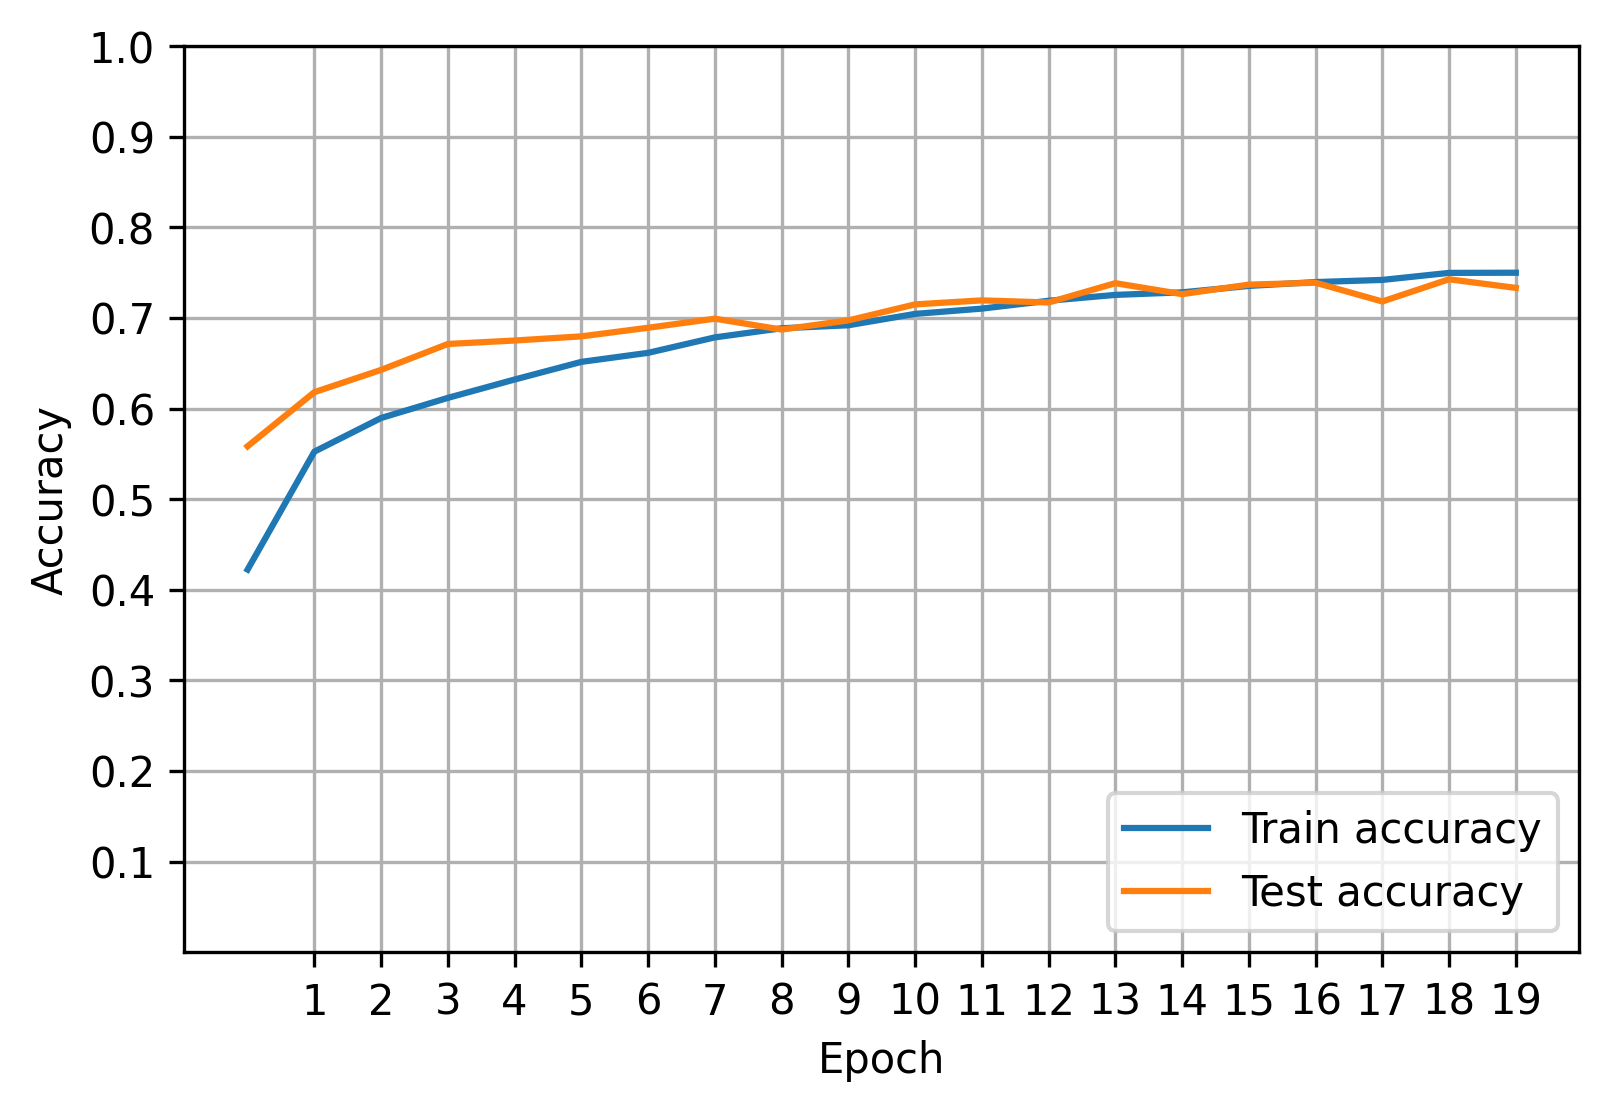

In [ ]:
model, history, test_acc, test_loss = output_train_kernel
print(test_acc)
plot_performance(history)
display(history.history)

### Test - neuron

In [ ]:
output_train_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-basic-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_neuron[1]))

Using given val data
Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 1.9082 - accuracy: 0.4189
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-2-01.hdf5
782/782 [==============================] - 21s 24ms/step - loss: 1.9082 - accuracy: 0.4189 - val_loss: 1.4122 - val_accuracy: 0.5679
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 1.4576 - accuracy: 0.5539
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-2-02.hdf5
782/782 [==============================] - 17s 22ms/step - loss: 1.4576 - accuracy: 0.5539 - val_loss: 1.3770 - val_accuracy: 0.5683
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.3346 - accuracy: 0.5909
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-2-03.hdf5
782/782 [==============================] - 17s 22ms/step - loss: 

In [ ]:
output_train_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-basic-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_neuron[1]))

Using given val data
Epoch 1/20
779/782 [============================>.] - ETA: 0s - loss: 1.9020 - accuracy: 0.4183
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-3-01.hdf5
782/782 [==============================] - 19s 23ms/step - loss: 1.9014 - accuracy: 0.4182 - val_loss: 1.4166 - val_accuracy: 0.5705
Epoch 2/20
781/782 [============================>.] - ETA: 0s - loss: 1.4747 - accuracy: 0.5479
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-3-02.hdf5
782/782 [==============================] - 18s 22ms/step - loss: 1.4746 - accuracy: 0.5479 - val_loss: 1.4831 - val_accuracy: 0.5418
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.3464 - accuracy: 0.5870
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-train-neuron-basic-3-03.hdf5
782/782 [==============================] - 17s 22ms/step - loss: 

In [ ]:
output_train_neuron = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-basic-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)
print(get_max_accuracy(output_train_neuron[1]))

Reading model from file
{'accuracy': 0.7466400265693665, 'val_accuracy': 0.7318999767303467}


In [ ]:
print("Test accuracy mean:")
test_accs = [0.73189, 0.74210, 0.74000]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7380 $\pm$ 0.0044
0.7379966666666666 +- 0.0044023503823399455


In [ ]:
print("Train accuracy mean:")
train_accs = [0.74664, 0.74795, 0.74614]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7469 $\pm$ 0.0008
0.7469100000000001 +- 0.00076319503841853


## Tests - val data org basic - wo dropouts

### Test - layer - wo dropouts

#### Opt = 0.5

In [ ]:
output_val_layer_wo_reg_05 = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-wo-dropouts-05-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val_org(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg_05[1]))

170508288/170498071 [==============================] - 13s 0us/step
Using given val data
64
Epoch 1
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.4917
Training accuracy for epoch: 0.4472
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-2-01.hdf5

Epoch 2
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5694
Training accuracy for epoch: 0.59412
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-2-02.hdf5

Epoch 3
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6063
Training accuracy for epoch: 0.6544
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-2-03.hdf5

Epoch 4
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6183
Training accuracy for epoch: 0.69264
Saving model to drive/MyDrive/master-thesis/models/experiments-comparis

In [ ]:
output_val_layer_wo_reg_05 = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-wo-dropouts-05-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val_org(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg_05[1]))

Using given val data
64
Epoch 1
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5188
Training accuracy for epoch: 0.45616
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-3-01.hdf5

Epoch 2
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5585
Training accuracy for epoch: 0.59464
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-3-02.hdf5

Epoch 3
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5966
Training accuracy for epoch: 0.65808
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-3-03.hdf5

Epoch 4
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6161
Training accuracy for epoch: 0.6992
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-05-3-04.hdf5

Epoch 5
S

In [ ]:
output_val_layer_wo_reg_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-wo-dropouts-05-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val_org(*x, **y, opt_split=0.5),
    use_test_as_val=True
)

170508288/170498071 [==============================] - 3s 0us/step
Reading model from file


{'accuracy': 0.85476, 'val_accuracy': 0.6915}


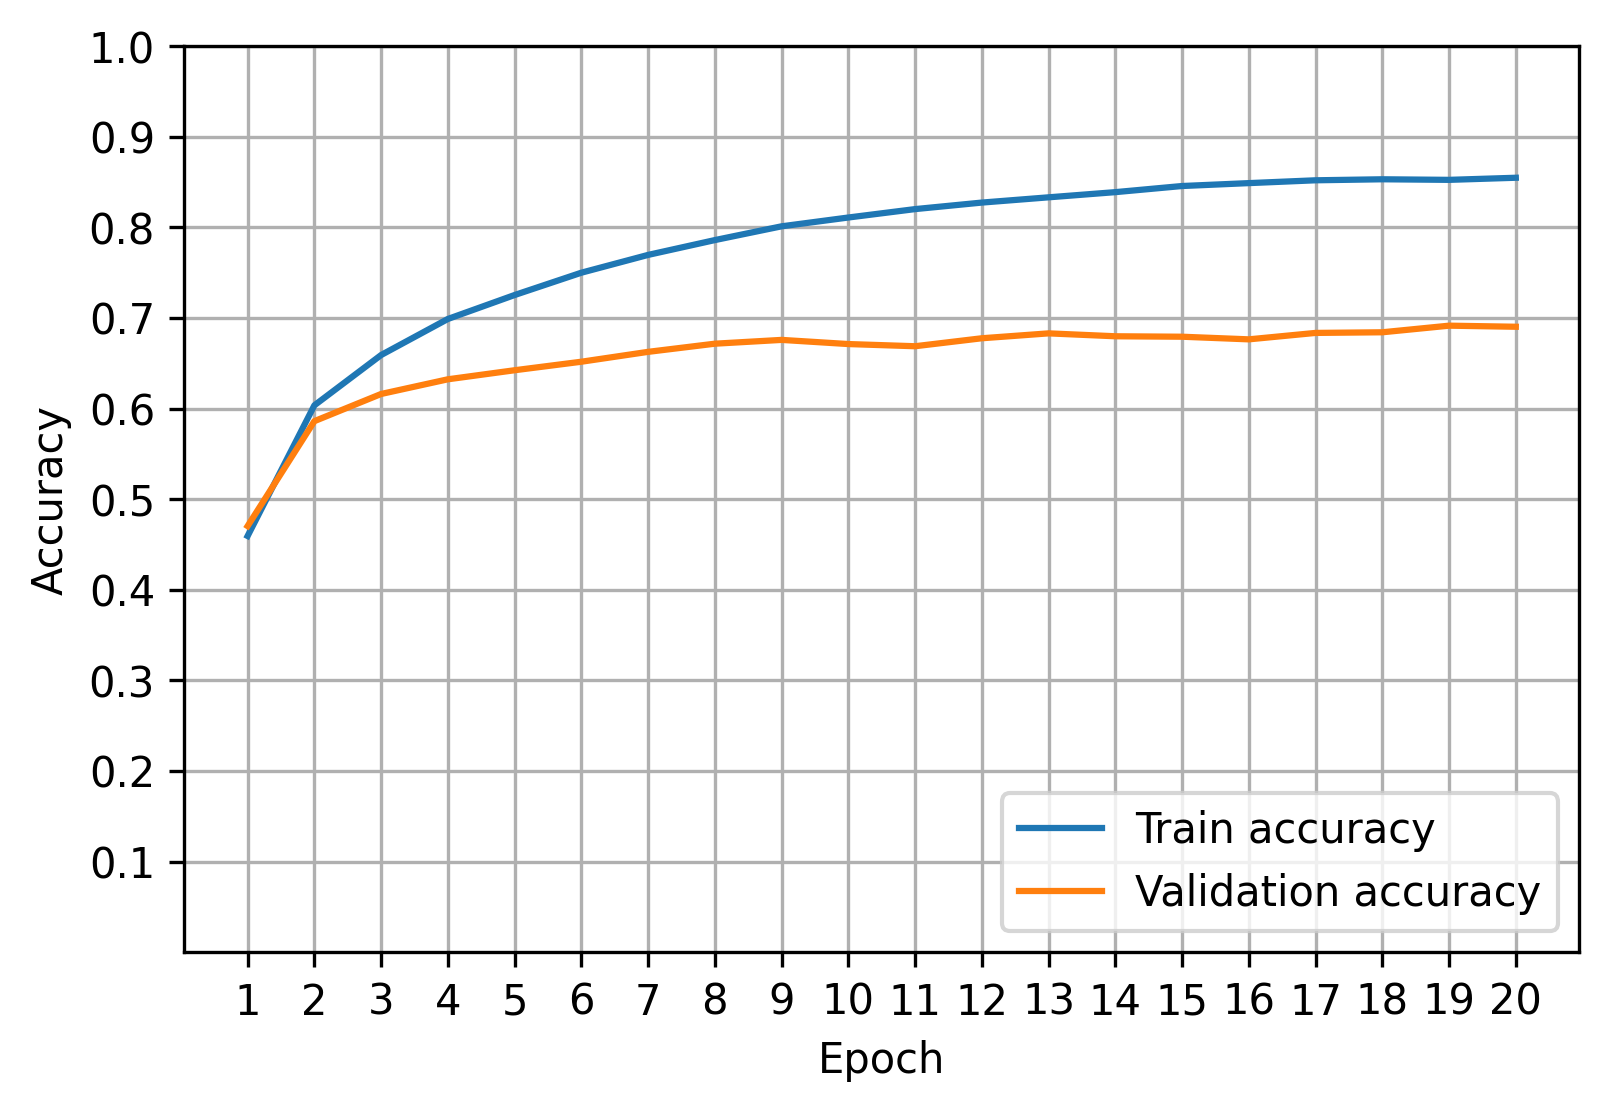

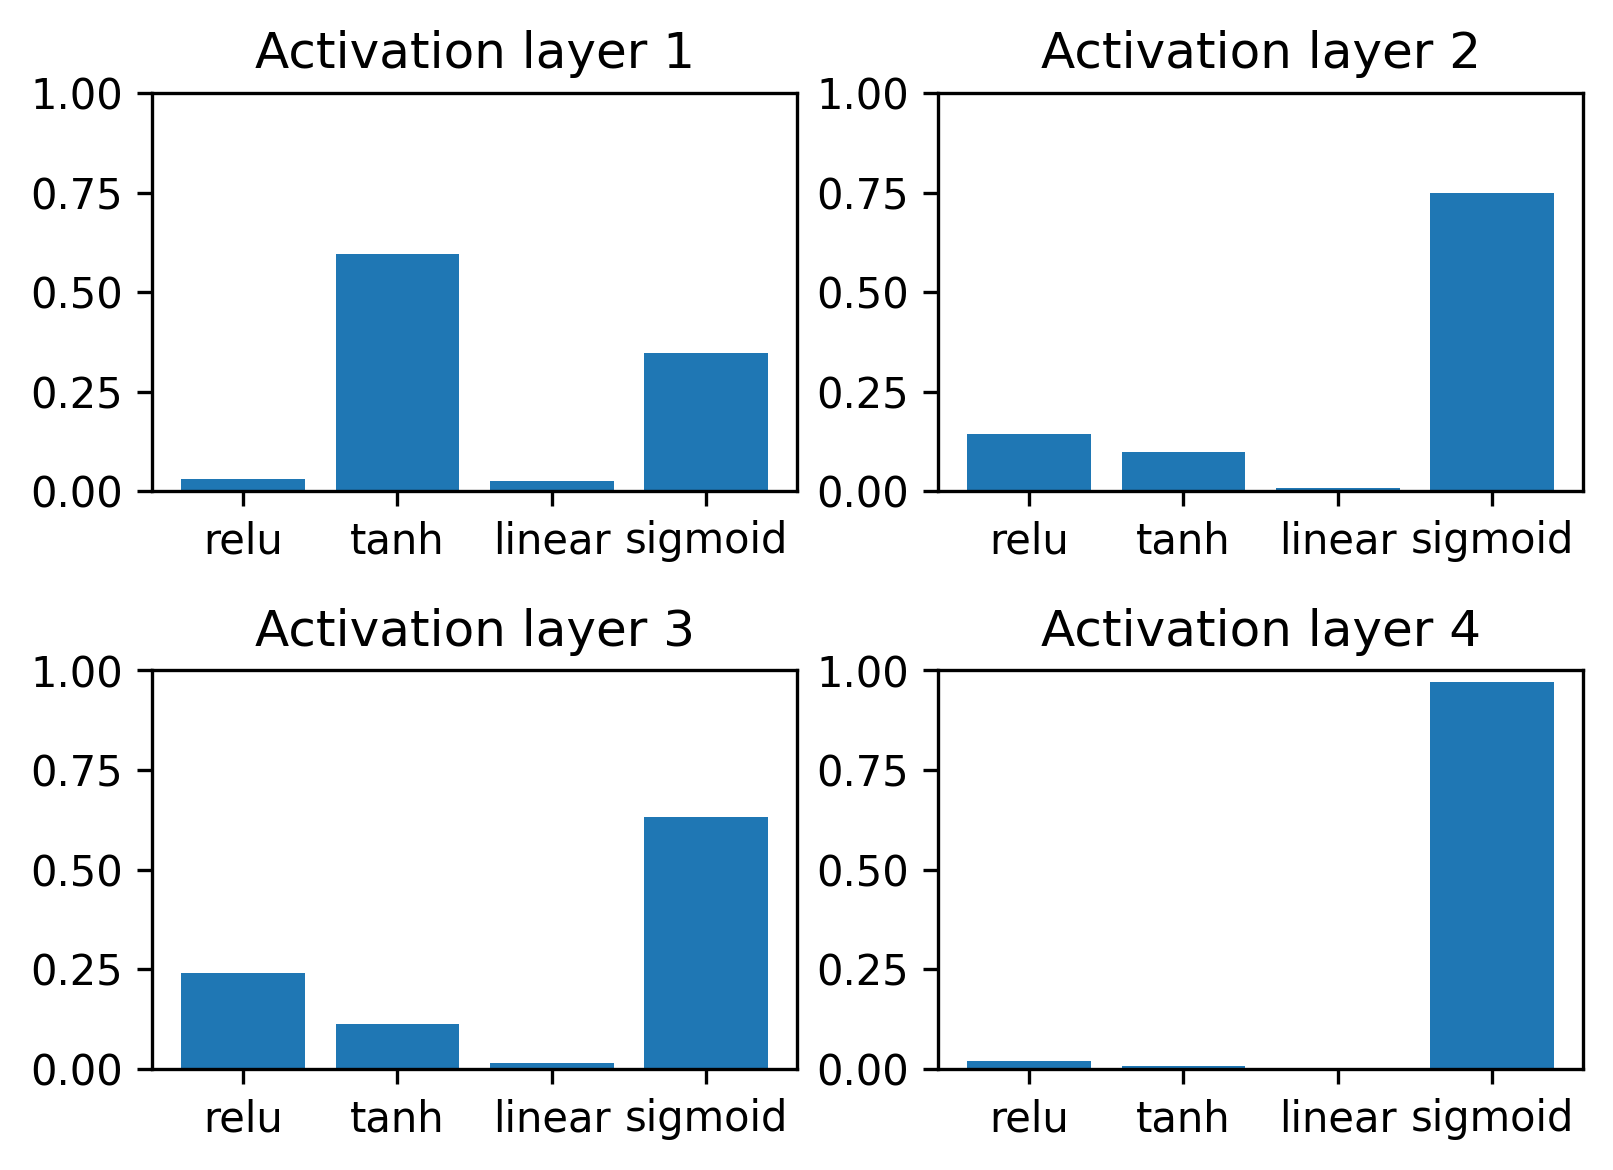

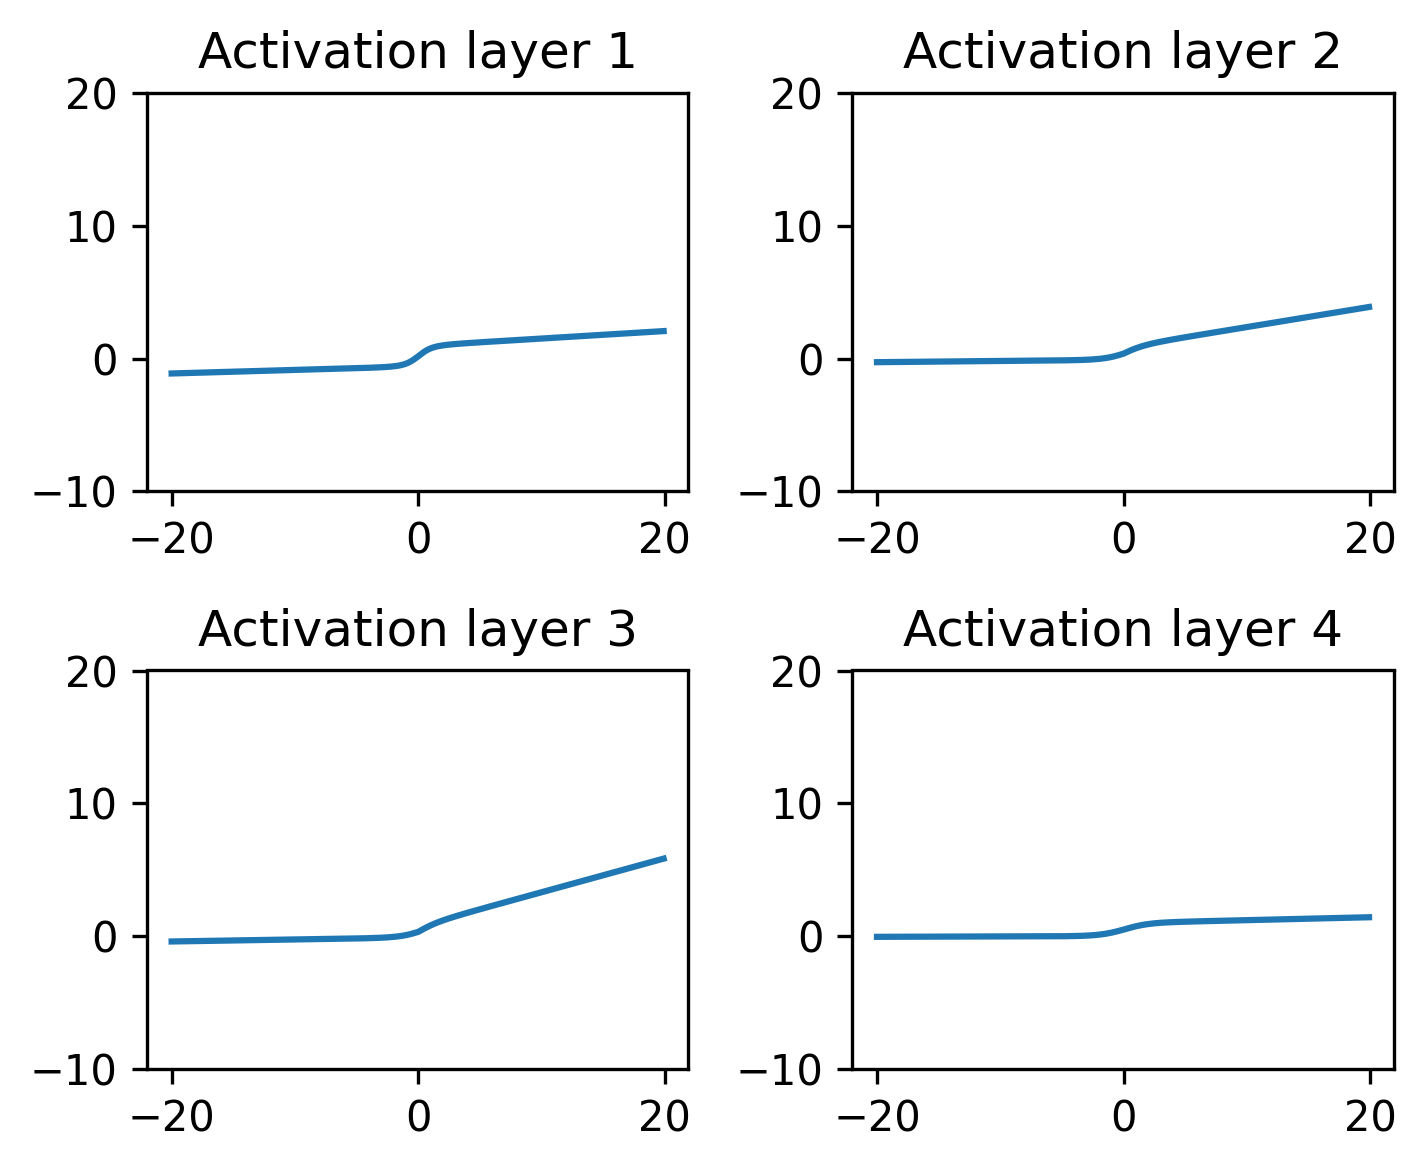

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.45936>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8499167>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.4703>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.60356>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6482158>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5861>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.65908>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5311779>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6161>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.69888>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4497218>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6323>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.72532>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.388218>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, nu

In [ ]:
model, history, test_acc, test_loss = output_val_layer_wo_reg_05
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.6814, 0.6831, 0.6915]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.6853 $\pm$ 0.0044
0.6853333333333333 +- 0.0044153771702489355


In [ ]:
print("Train accuracy mean:")
train_accs = [0.84816, 0.8534, 0.85476]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8521 $\pm$ 0.0028
0.8521066666666668 +- 0.0028454095584916185


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fcf37d5fef0> <function sigmoid at 0x7fcf37d620e0>
 <function relu at 0x7fcf37d5fb90> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.6544 - accuracy: 0.4466 - val_loss: 1.4114 - val_accuracy: 0.5321
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.2609 - accuracy: 0.6080 - val_loss: 1.1831 - val_accuracy: 0.6387
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.1044 - accuracy: 0.6678 - val_loss: 1.1326 - val_accuracy: 0.

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fcf37d5fef0> <function sigmoid at 0x7fcf37d620e0>
 <function relu at 0x7fcf37d5fb90> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.6753 - accuracy: 0.4380 - val_loss: 1.4055 - val_accuracy: 0.5498
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.2795 - accuracy: 0.5974 - val_loss: 1.1748 - val_accuracy: 0.6394
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.1299 - accuracy: 0.6585 - val_loss: 1.0860 - val_accuracy: 0.

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fcf37d5fef0> <function sigmoid at 0x7fcf37d620e0>
 <function relu at 0x7fcf37d5fb90> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf37d620e0> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf37d5fef0> <function linear at 0x7fcf37d625f0>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.7475 - accuracy: 0.4036 - val_loss: 1.3822 - val_accuracy: 0.5429
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.2752 - accuracy: 0.5967 - val_loss: 1.2167 - val_accuracy: 0.6288
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.1207 - accuracy: 0.6644 - val_loss: 1.1179 - val_accuracy: 0.

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7362, 0.7328, 0.7394]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7361 $\pm$ 0.0027
0.7361333333333332 +- 0.002694851057521007


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8502, 0.8485, 0.8556]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8514 $\pm$ 0.0030
0.8514333333333334 +- 0.003026916289265739


In [ ]:
model_3_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fcf37d5fef0>]
[<function sigmoid at 0x7fcf37d620e0>]
[<function sigmoid at 0x7fcf37d620e0>]
[<function sigmoid at 0x7fcf37d620e0>]
Epoch 1/20
782/782 [==============================] - 4s 5ms/step - loss: 2.1995 - accuracy: 0.1783 - val_loss: 2.0685 - val_accuracy: 0.2418
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 2.0460 - accuracy: 0.2500 - val_loss: 2.0204 - val_accuracy: 0.2712
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 1.8710 - accuracy: 0.3459 - val_loss: 1.7904 - val_accuracy: 0.3821
Epoch 4/20
782/782 [==============================] - 3s 4ms/step - loss: 1.7880 - accuracy: 0.3790 - val_loss: 1.7800 - val_accuracy: 0.3805
Epoch 5/20
782/782 [==============================] - 3s 4ms/step - loss: 1.7296 - accuracy: 0.4058 - val_loss: 1.6802 - val_accuracy: 0.4304
Epoch 6/20
782/782 [==============================] - 3s 4ms/step - loss: 1.6991 - accuracy: 0.4214 - val_loss: 1.6952 - val_accuracy: 0.

In [ ]:
model_3_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc2c32f6950>]
[<function sigmoid at 0x7fc2c2b2c200>]
[<function sigmoid at 0x7fc2c2b2c200>]
[<function sigmoid at 0x7fc2c2b2c200>]
Epoch 1/20
782/782 [==============================] - 15s 6ms/step - loss: 1.8931 - accuracy: 0.3537 - val_loss: 1.7490 - val_accuracy: 0.3945
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 1.6016 - accuracy: 0.4638 - val_loss: 1.5201 - val_accuracy: 0.4909
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 1.5153 - accuracy: 0.5029 - val_loss: 1.4630 - val_accuracy: 0.5137
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1.4505 - accuracy: 0.5355 - val_loss: 1.4105 - val_accuracy: 0.5478
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1.4043 - accuracy: 0.5608 - val_loss: 1.3752 - val_accuracy: 0.5740
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 1.3768 - accuracy: 0.5756 - val_loss: 1.3280 - val_accuracy: 0

In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc2c32f6950>]
[<function sigmoid at 0x7fc2c2b2c200>]
[<function sigmoid at 0x7fc2c2b2c200>]
[<function sigmoid at 0x7fc2c2b2c200>]
Epoch 1/20
782/782 [==============================] - 5s 5ms/step - loss: 2.3321 - accuracy: 0.1005 - val_loss: 2.3126 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3106 - accuracy: 0.1008 - val_loss: 2.3106 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3095 - accuracy: 0.1006 - val_loss: 2.3075 - val_accuracy: 0.1000
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3101 - accuracy: 0.1011 - val_loss: 2.3086 - val_accuracy: 0.1000
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3105 - accuracy: 0.1017 - val_loss: 2.3128 - val_accuracy: 0.0998
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3084 - accuracy: 0.1027 - val_loss: 2.2930 - val_accuracy: 0.

In [ ]:
print("Test accuracy mean:")
test_accs = [0.5428, 0.6492, 0.5034]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.5651 $\pm$ 0.0616
0.5651333333333333 +- 0.06158188766909383


In [ ]:
print("Train accuracy mean:")
train_accs = [0.5305, 0.6675, 0.5147]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.5709 $\pm$ 0.0686
0.5709 +- 0.06861039765710926


#### Opt =  0.2

In [ ]:
output_val_layer_wo_reg = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-wo-dropouts-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val_org,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg[1]))

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5568
Training accuracy for epoch: 0.50195
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-2-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5928
Training accuracy for epoch: 0.633975
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-2-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6148
Training accuracy for epoch: 0.683275
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-2-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6581
Training accuracy for epoch: 0.71455
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer

In [ ]:
output_val_layer_wo_reg = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-wo-dropouts-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val_org,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg[1]))

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5647
Training accuracy for epoch: 0.4963
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-3-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6101
Training accuracy for epoch: 0.630575
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-3-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6485
Training accuracy for epoch: 0.681975
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-wo-dropouts-3-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6673
Training accuracy for epoch: 0.712375
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer

In [ ]:
output_val_layer_wo_reg = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val_org,
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.851025, 'val_accuracy': 0.7199}


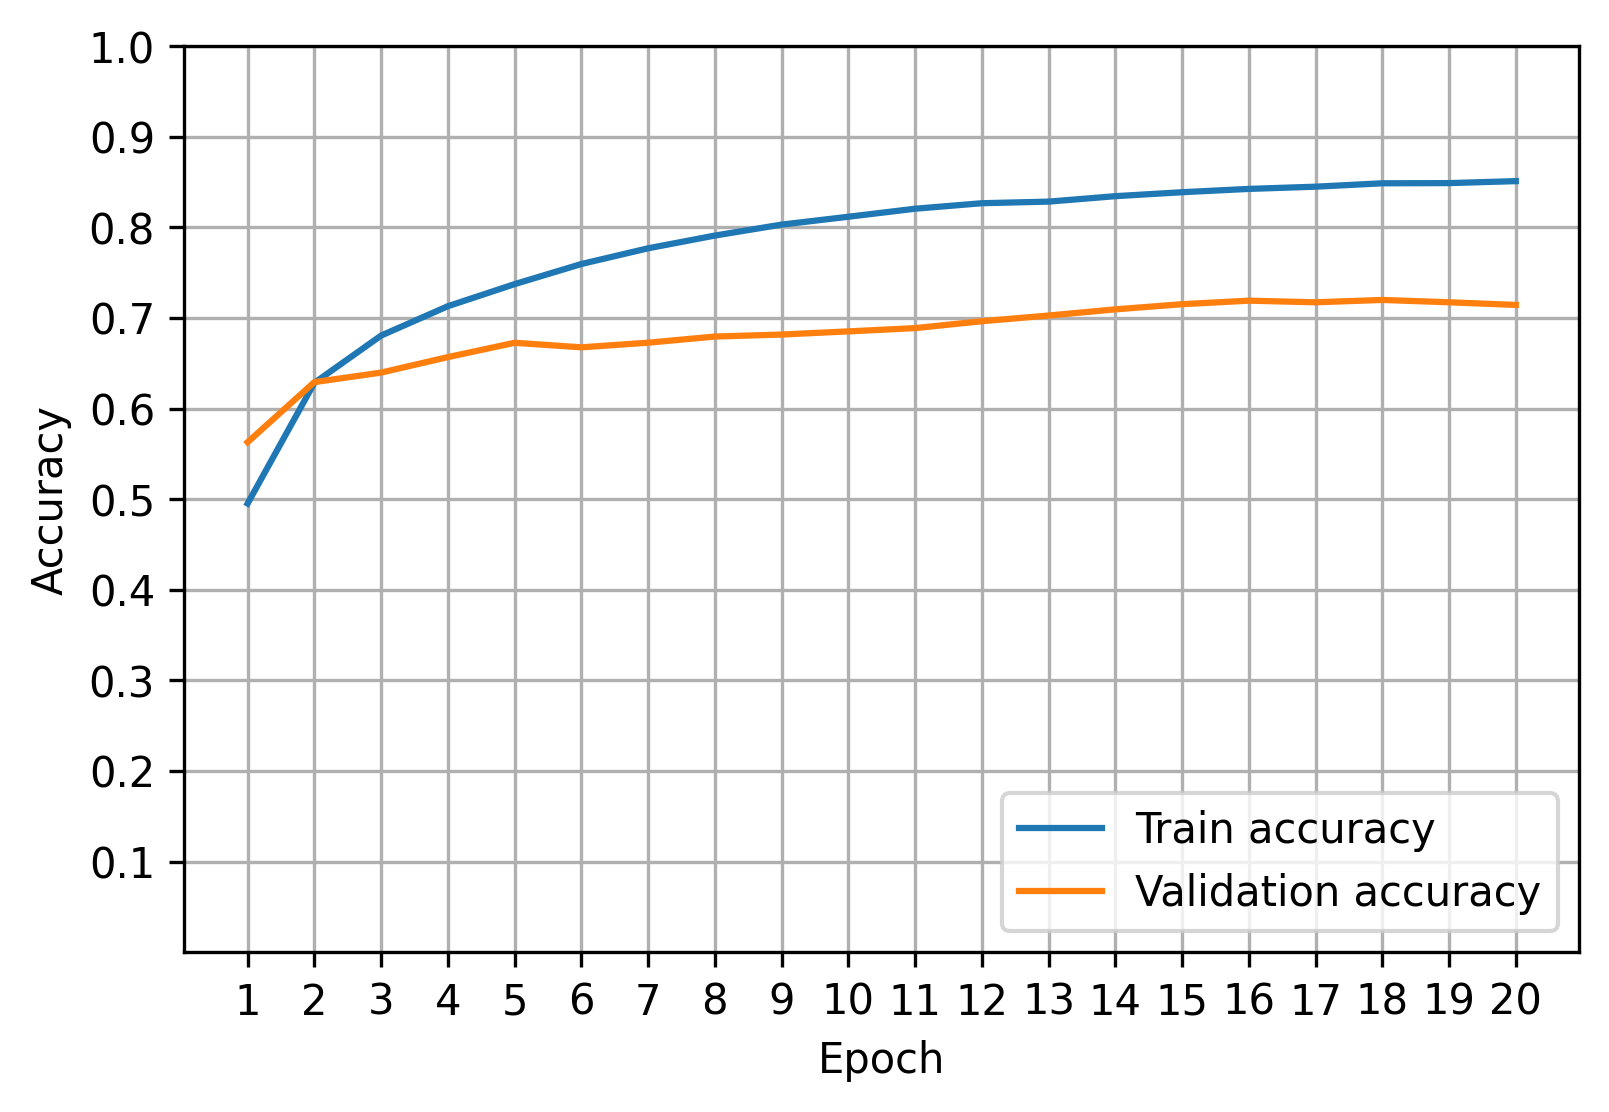

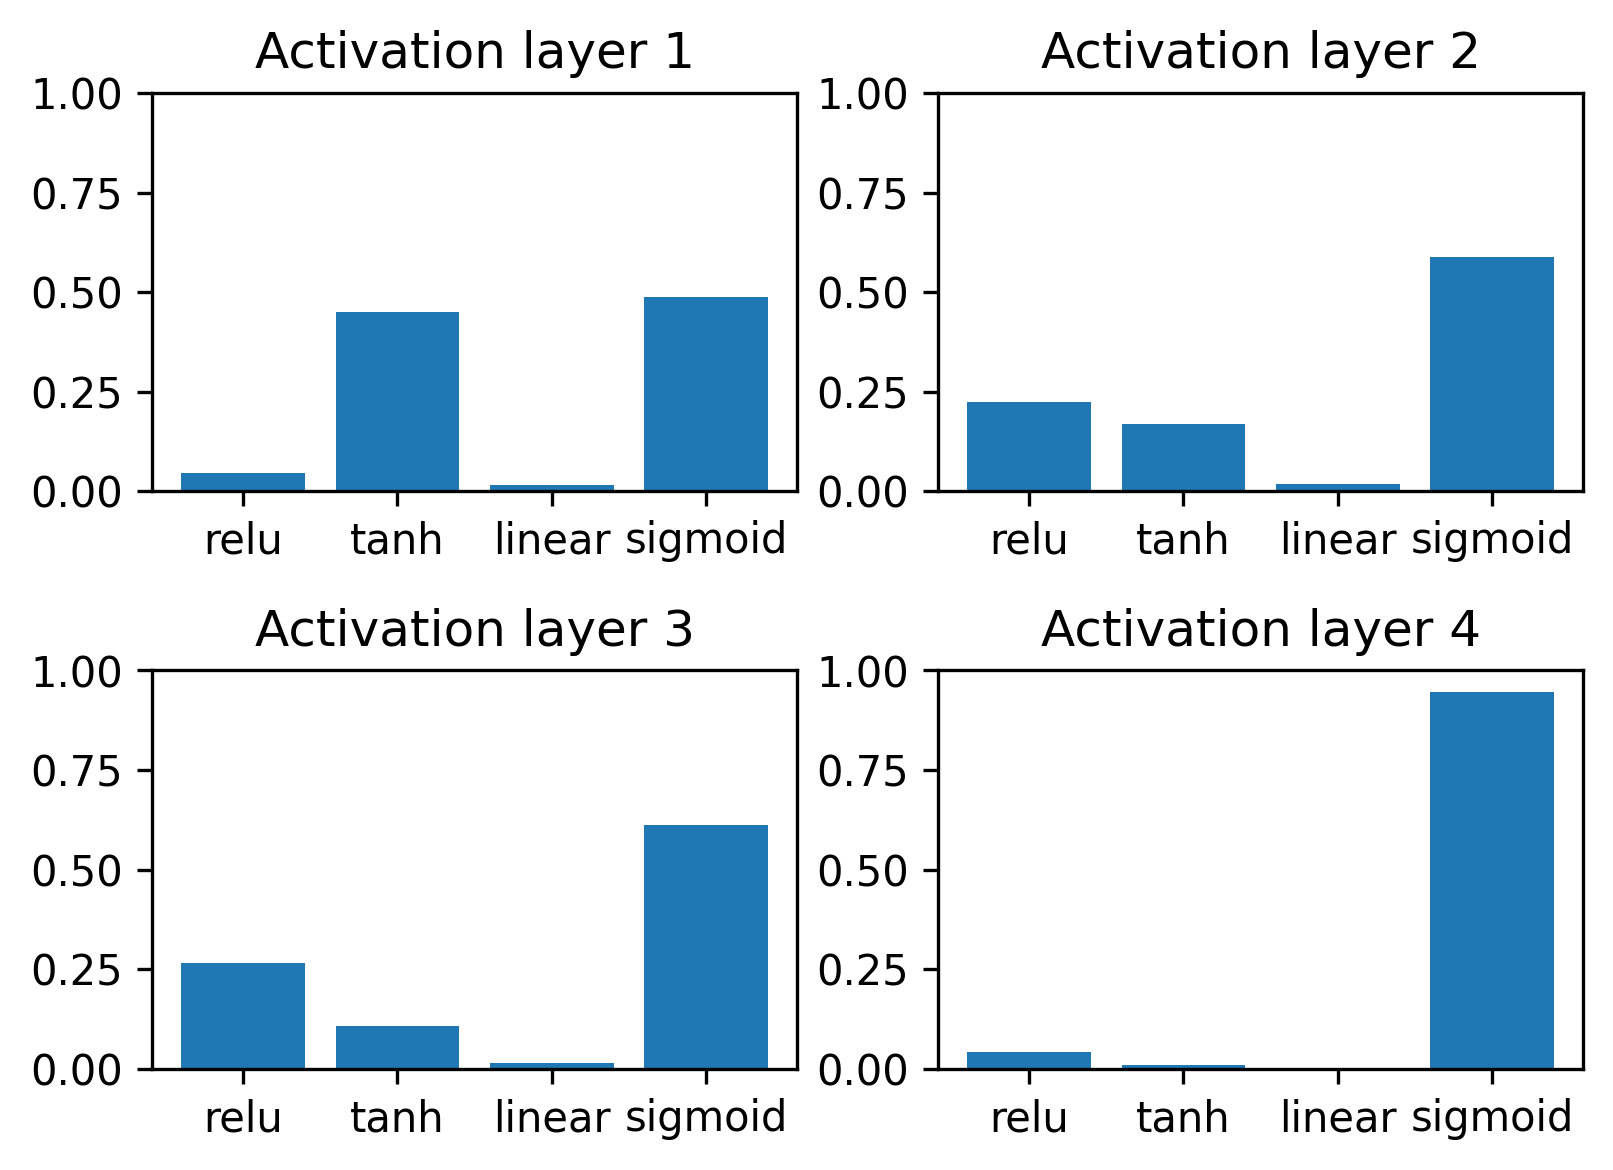

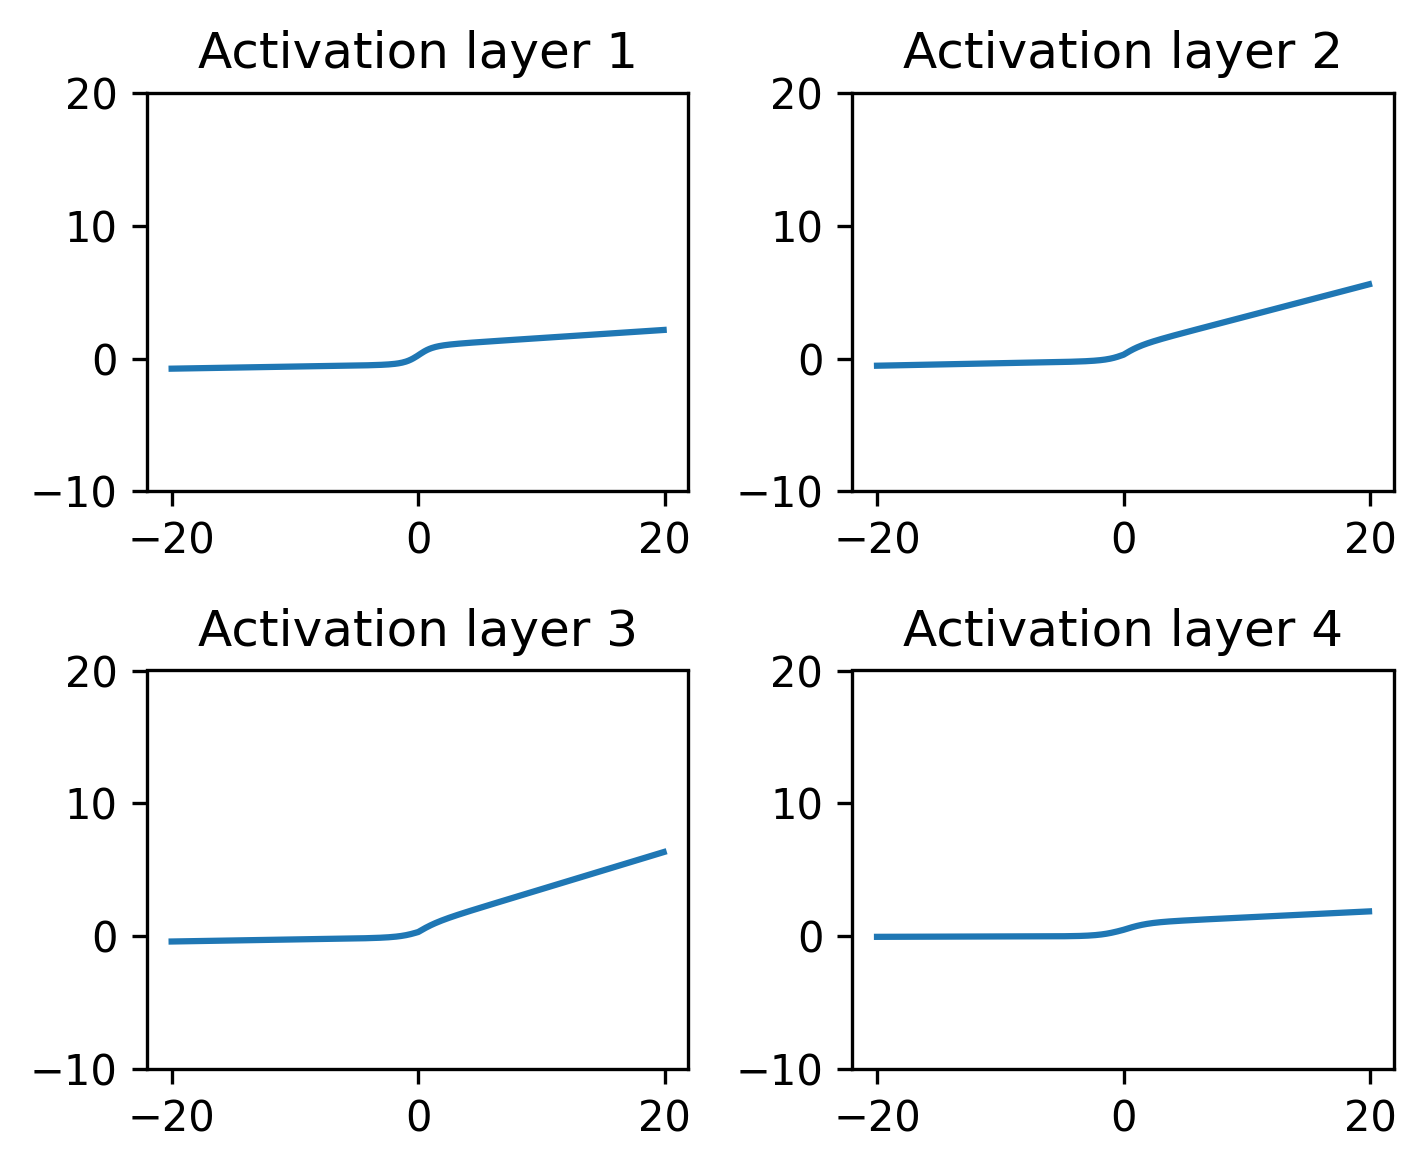

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.495175>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7712953>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5629>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6284>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5585649>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6292>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.680575>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4379022>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6397>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.712975>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3556617>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6568>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.73735>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2934107>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32,

In [ ]:
model, history, test_acc, test_loss = output_val_layer_wo_reg
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7284, 0.703, 0.7199]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7171 $\pm$ 0.0106
0.7171 +- 0.010556830332380425


In [ ]:
print("Train accuracy mean:")
train_accs = [0.851075, 0.84405, 0.851025]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8487 $\pm$ 0.0033
0.8487166666666667 +- 0.0032998947794673317


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcf725d3200> <function tanh at 0x7fcf72d9f950>
 <function relu at 0x7fcf37d5fb90> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.7106 - accuracy: 0.4373 - val_loss: 1.3863 - val_accuracy: 0.5578
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.2871 - accuracy: 0.5994 - val_loss: 1.3589 - val_accuracy: 0.5730
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.1179 - accuracy: 0.6678 - val_loss: 1.0966 - val_accuracy: 0.

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcf725d3200> <function tanh at 0x7fcf72d9f950>
 <function relu at 0x7fcf37d5fb90> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 1.7253 - accuracy: 0.4159 - val_loss: 1.3433 - val_accuracy: 0.5662
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.2685 - accuracy: 0.6030 - val_loss: 1.1759 - val_accuracy: 0.6400
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.1145 - accuracy: 0.6636 - val_loss: 1.1183 - val_accuracy: 0.

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcf725d3200> <function tanh at 0x7fcf72d9f950>
 <function relu at 0x7fcf37d5fb90> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
[<function sigmoid at 0x7fcf725d3200> <function relu at 0x7fcf37d5fb90>
 <function tanh at 0x7fcf72d9f950> <function linear at 0x7fcf37d625f0>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.6341 - accuracy: 0.4581 - val_loss: 1.3159 - val_accuracy: 0.5886
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.2330 - accuracy: 0.6193 - val_loss: 1.2401 - val_accuracy: 0.6180
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.0996 - accuracy: 0.6721 - val_loss: 1.1063 - val_accuracy: 0.

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7321, 0.7392, 0.7307]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7340 $\pm$ 0.0037
0.734 +- 0.0037211109452240944


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8631, 0.8477, 0.8514]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8541 $\pm$ 0.0066
0.8540666666666666 +- 0.006563704915839984


In [ ]:
model_4_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcf725d3200>]
[<function sigmoid at 0x7fcf725d3200>]
[<function sigmoid at 0x7fcf725d3200>]
[<function sigmoid at 0x7fcf725d3200>]
Epoch 1/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3290 - accuracy: 0.0972 - val_loss: 2.3117 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 2.3107 - accuracy: 0.1008 - val_loss: 2.3104 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3097 - accuracy: 0.0986 - val_loss: 2.3101 - val_accuracy: 0.1000
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 2.3099 - accuracy: 0.0998 - val_loss: 2.3090 - val_accuracy: 0.1000
Epoch 5/20
782/782 [==============================] - 4s 4ms/step - loss: 2.2278 - accuracy: 0.1544 - val_loss: 2.1289 - val_accuracy: 0.2178
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 2.0583 - accuracy: 0.2521 - val_loss: 1.9978 - val_accuracy:

In [ ]:
model_4_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_4_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fc579ffd200>]
[<function sigmoid at 0x7fc579ffd200>]
[<function sigmoid at 0x7fc579ffd200>]
[<function sigmoid at 0x7fc579ffd200>]
Epoch 1/20
782/782 [==============================] - 20s 11ms/step - loss: 1.9832 - accuracy: 0.3121 - val_loss: 1.7692 - val_accuracy: 0.3836
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7088 - accuracy: 0.4166 - val_loss: 1.6715 - val_accuracy: 0.4267
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6282 - accuracy: 0.4538 - val_loss: 1.6783 - val_accuracy: 0.4310
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 1.5833 - accuracy: 0.4749 - val_loss: 1.5273 - val_accuracy: 0.4881
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5571 - accuracy: 0.4848 - val_loss: 1.5633 - val_accuracy: 0.4773
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5241 - accuracy: 0.5011 - val_loss: 1.4927 - val_ac

In [ ]:
model_4 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcf725d3200>]
[<function sigmoid at 0x7fcf725d3200>]
[<function sigmoid at 0x7fcf725d3200>]
[<function sigmoid at 0x7fcf725d3200>]
Epoch 1/20
782/782 [==============================] - 5s 5ms/step - loss: 2.1311 - accuracy: 0.2244 - val_loss: 2.0347 - val_accuracy: 0.2591
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 1.9890 - accuracy: 0.2856 - val_loss: 1.8965 - val_accuracy: 0.3311
Epoch 3/20
782/782 [==============================] - 3s 4ms/step - loss: 1.8471 - accuracy: 0.3579 - val_loss: 1.8142 - val_accuracy: 0.3781
Epoch 4/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7920 - accuracy: 0.3833 - val_loss: 1.7553 - val_accuracy: 0.4029
Epoch 5/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7598 - accuracy: 0.3931 - val_loss: 1.7349 - val_accuracy: 0.4033
Epoch 6/20
782/782 [==============================] - 4s 5ms/step - loss: 1.7395 - accuracy: 0.4038 - val_loss: 1.7388 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4792, 0.6251, 0.5316]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.5453 $\pm$ 0.0603
0.5453 +- 0.06034605759009171


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4899, 0.6159, 0.5386]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.5481 $\pm$ 0.0519
0.5481333333333333 +- 0.051879111617511554


## Tests - val data org basic - 20 epochs

### Test - layer

#### Opt = 0.5

In [ ]:
output_val_layer_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-05-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val_org(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_05[1]))

Reading model from file
{'accuracy': 0.8122, 'val_accuracy': 0.7196}


In [ ]:
output_val_layer_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-05-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val_org(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_05[1]))

Training model
Using given val data
64
Epoch 1
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5089
Training accuracy for epoch: 0.45244
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-05-3-01.hdf5

Epoch 2
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5704
Training accuracy for epoch: 0.5872
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-05-3-02.hdf5

Epoch 3
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.584
Training accuracy for epoch: 0.63068
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-05-3-03.hdf5

Epoch 4
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6231
Training accuracy for epoch: 0.6618
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-05-3-04.hdf5

Epoch 5
Step / 391: 0 100 200 300 391
Valida

In [ ]:
output_val_layer_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-05-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val_org(*x, **y, opt_split=0.5),
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.81356, 'val_accuracy': 0.7166}


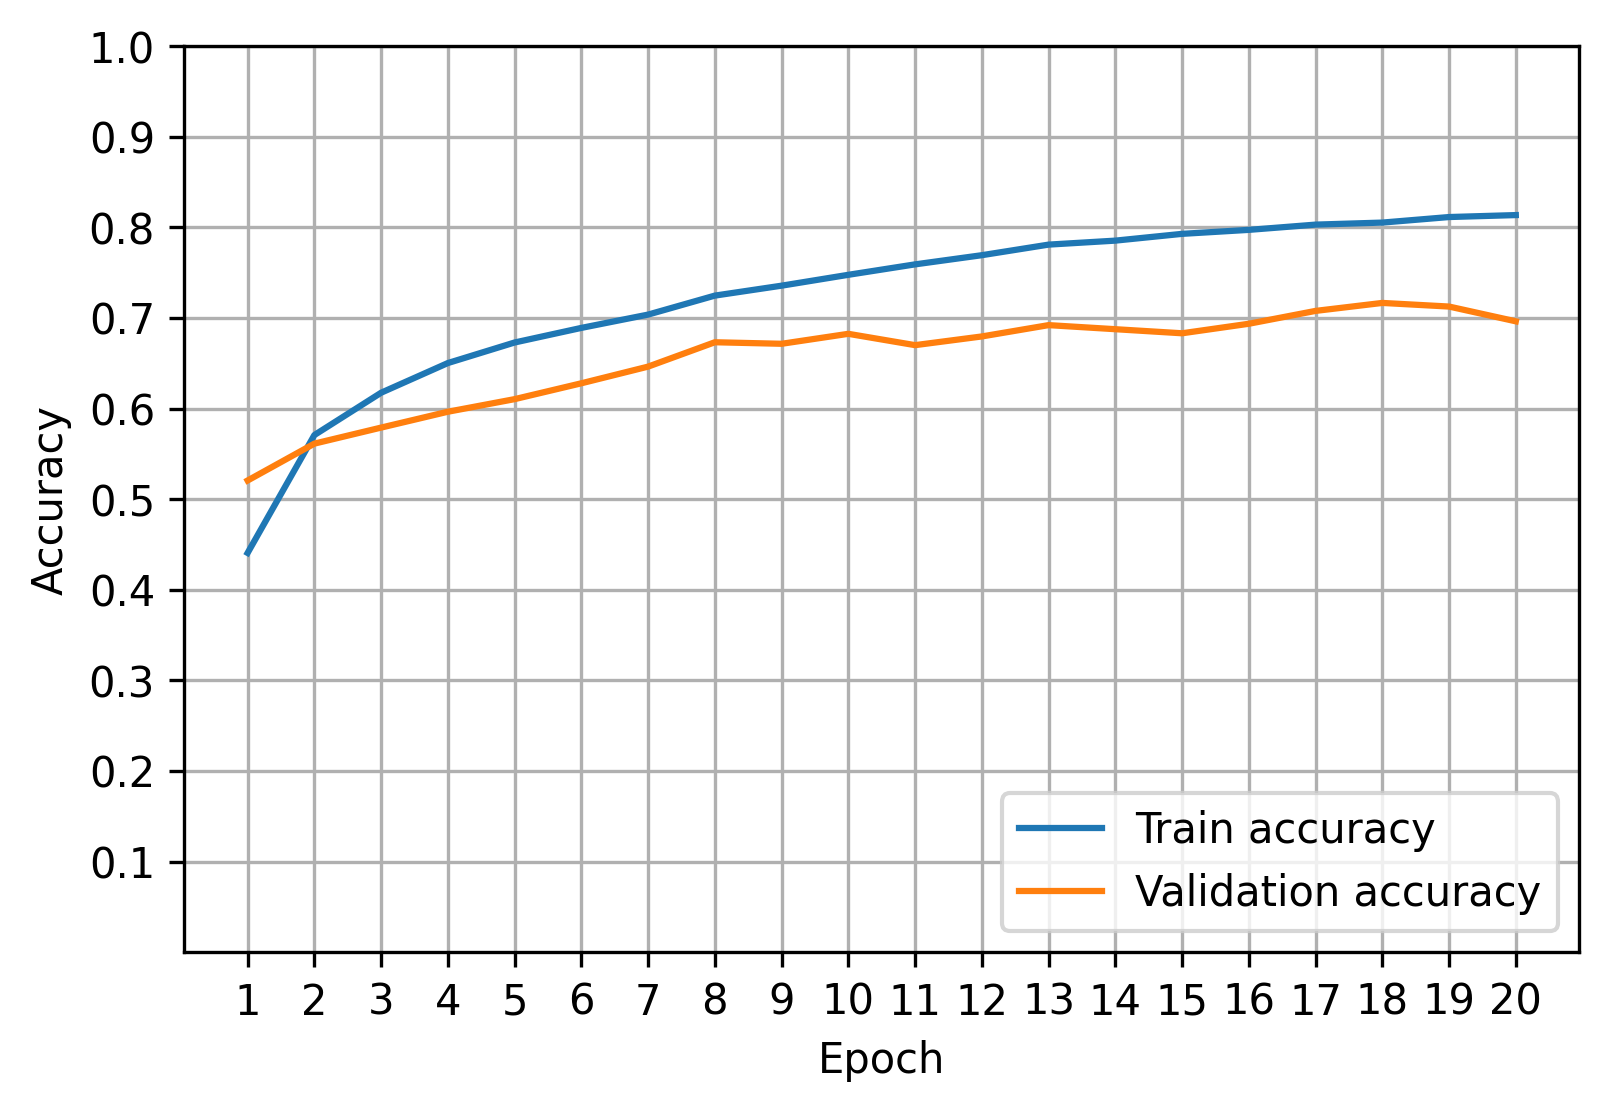

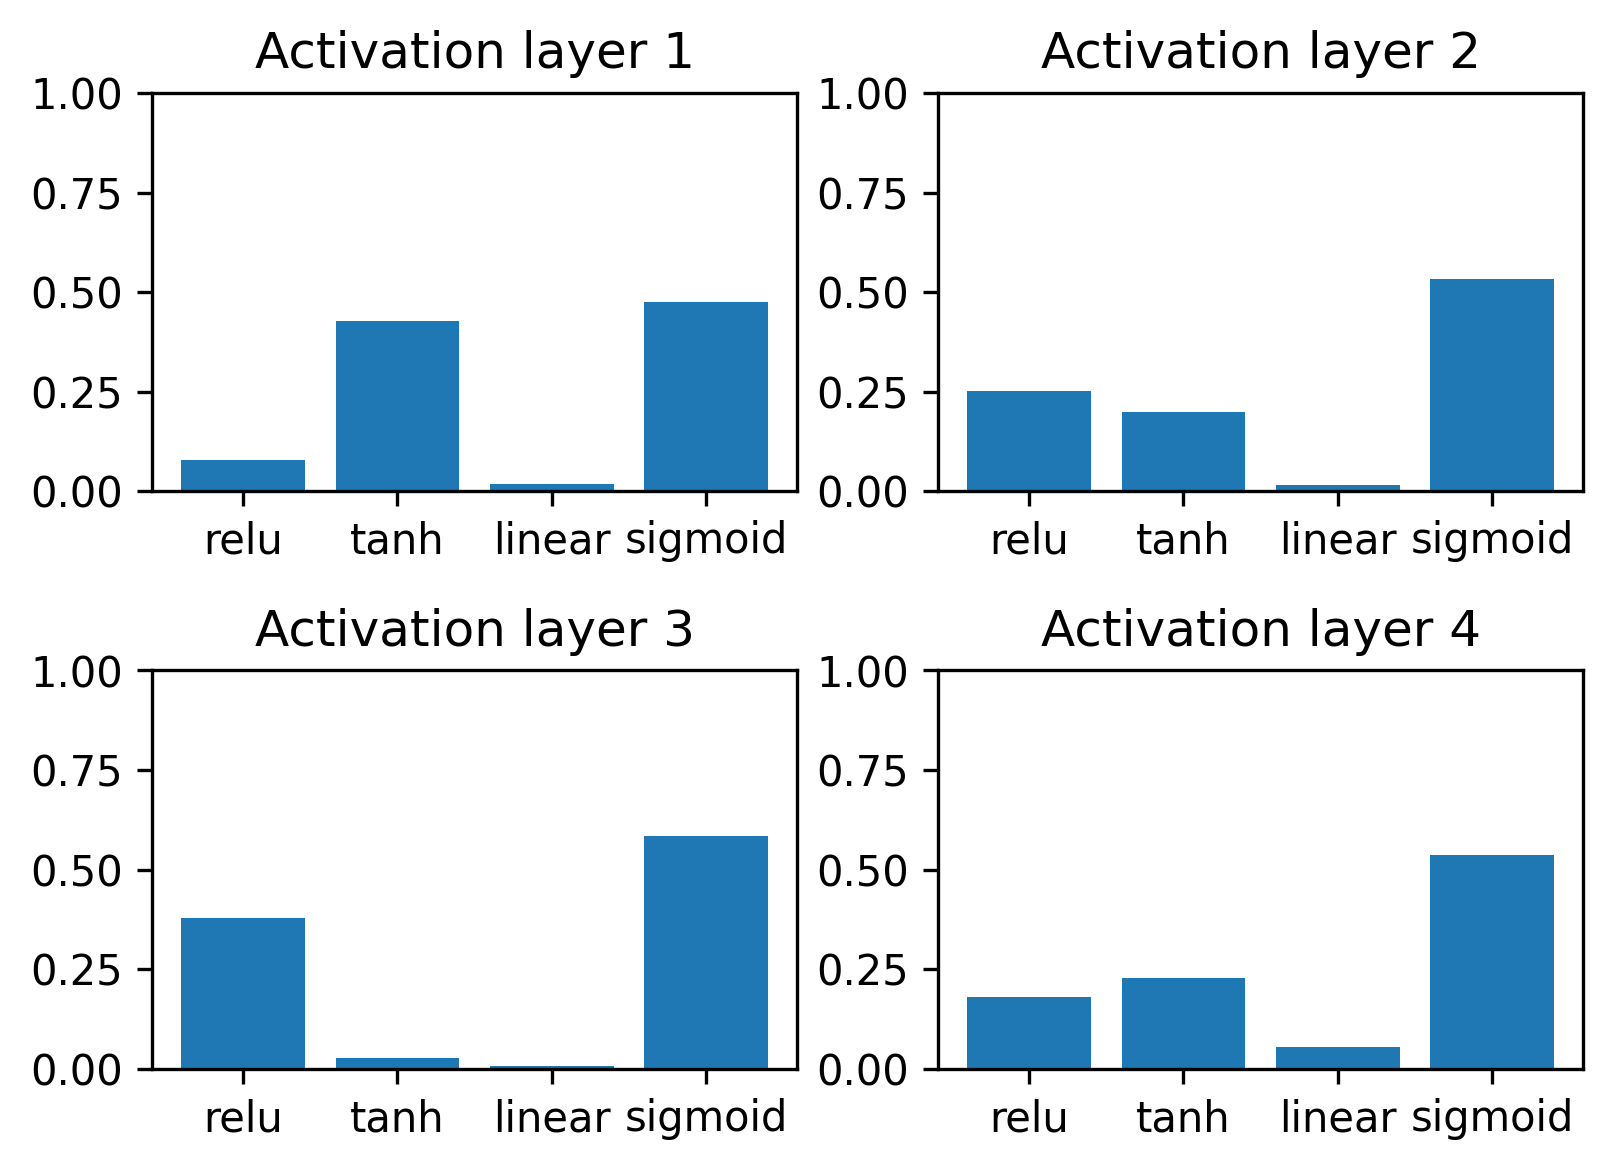

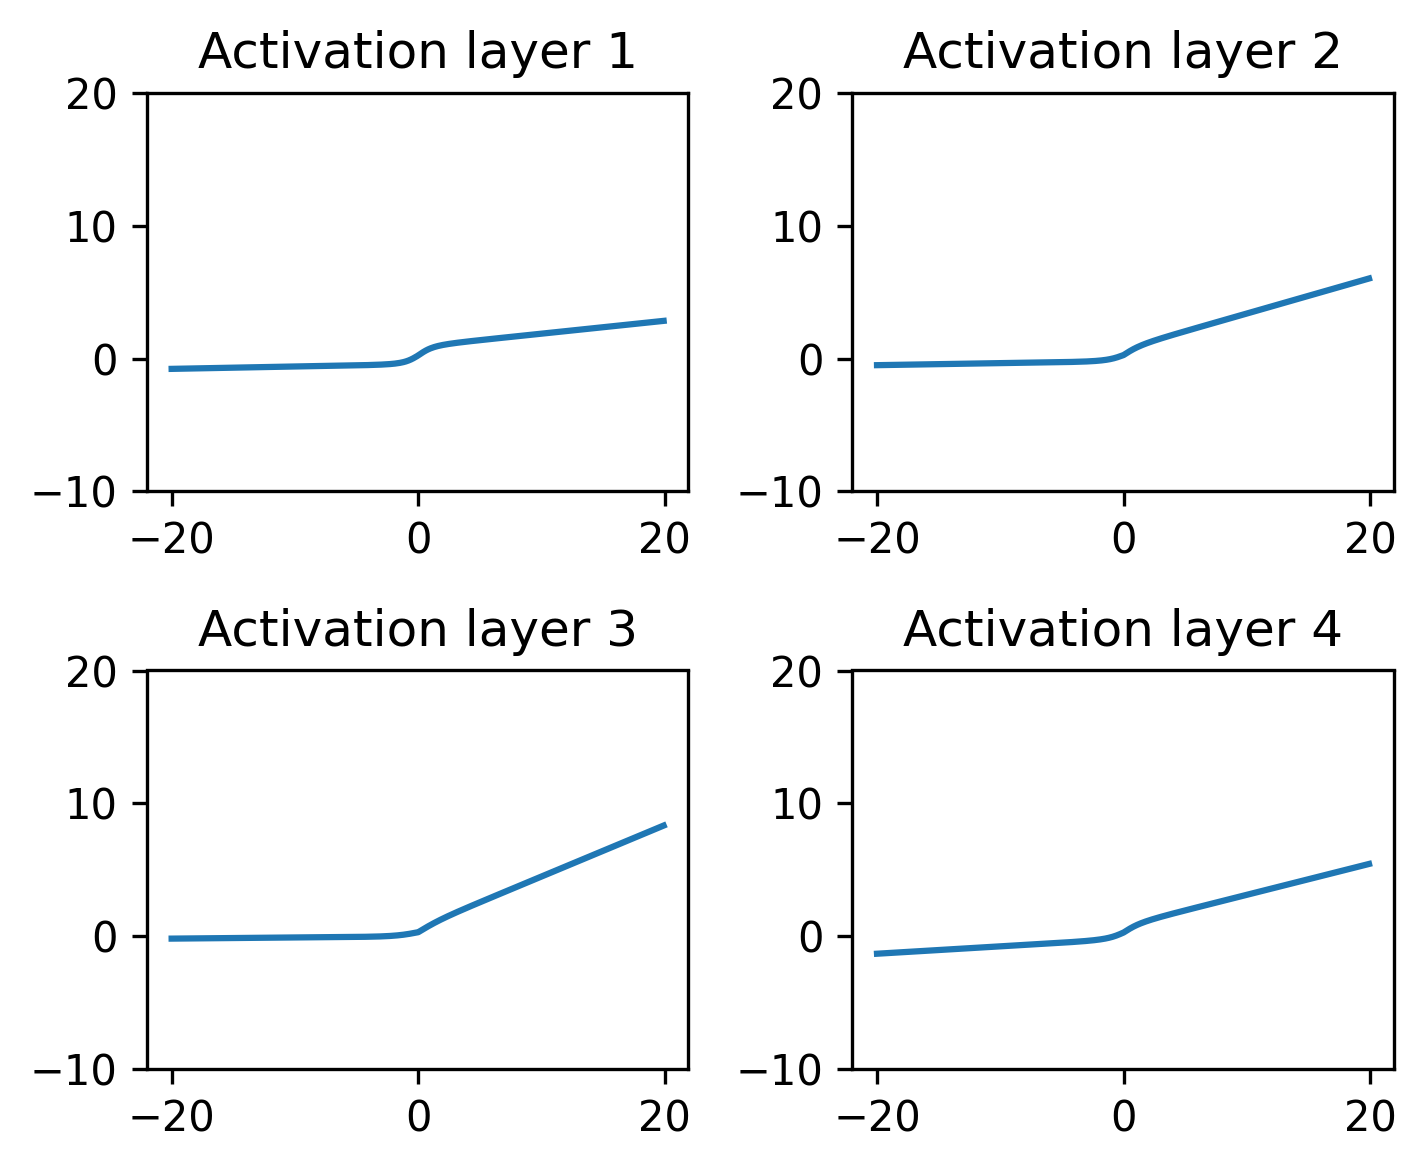

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.44064>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.0977721>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5206>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.57076>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8567894>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5613>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.61748>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7267064>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.579>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.65024>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6374178>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5965>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.67292>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5725825>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, nu

In [ ]:
model, history, test_acc, test_loss = output_val_layer_05
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7196, 0.7135, 0.7166]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7166 $\pm$ 0.0025
0.7165666666666667 +- 0.0024904261125803773


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8122, 0.8164, 0.81356]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8141 $\pm$ 0.0017
0.8140533333333333 +- 0.0017497682386215859


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
Epoch 1/20
782/782 [==============================] - 21s 25ms/step - loss: 1.7602 - accuracy: 0.4095 - val_loss: 1.4014 - val_accuracy: 0.5371
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 1.3762 - accuracy: 0.5612 - val_loss: 1.2261 - val_accuracy: 0.6176
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 1.2542 - accuracy: 0.6116 - val_loss: 1.1304 - val_accuracy:

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
Epoch 1/20
782/782 [==============================] - 21s 25ms/step - loss: 1.9355 - accuracy: 0.3285 - val_loss: 1.5764 - val_accuracy: 0.4568
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 1.5309 - accuracy: 0.4894 - val_loss: 1.3748 - val_accuracy: 0.5546
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 1.3744 - accuracy: 0.5564 - val_loss: 1.3163 - val_accuracy:

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
Epoch 1/20
782/782 [==============================] - 21s 25ms/step - loss: 1.8486 - accuracy: 0.3634 - val_loss: 1.4586 - val_accuracy: 0.5150
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 1.4217 - accuracy: 0.5369 - val_loss: 1.2560 - val_accuracy: 0.6023
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 1.2729 - accuracy: 0.6036 - val_loss: 1.1891 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7419, 0.7357, 0.7489]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7422 $\pm$ 0.0054
0.7421666666666668 +- 0.0053921754010376475


In [ ]:
print("Train accuracy mean:")
train_accs = [0.7494, 0.7397, 0.7513]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7468 $\pm$ 0.0051
0.7468 +- 0.0050800262466513275


In [ ]:
model_3_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1867 - accuracy: 0.1954 - val_loss: 1.9620 - val_accuracy: 0.2953
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.9039 - accuracy: 0.3190 - val_loss: 1.7870 - val_accuracy: 0.3836
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8421 - accuracy: 0.3504 - val_loss: 1.7467 - val_accuracy: 0.3922
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8023 - accuracy: 0.3716 - val_loss: 1.7233 - val_accuracy: 0.4017
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7591 - accuracy: 0.3946 - val_loss: 1.6340 - val_accuracy: 0.4474
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7327 - accuracy: 0.4089 - val_loss: 1.6312 - val_acc

In [ ]:
model_3_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcc8f332290>]
[<function sigmoid at 0x7fcc8f332290>]
[<function sigmoid at 0x7fcc8f332290>]
[<function sigmoid at 0x7fcc8f332290>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.2833 - accuracy: 0.1482 - val_loss: 2.0509 - val_accuracy: 0.2299
Epoch 2/20
782/782 [==============================] - 7s 10ms/step - loss: 2.0058 - accuracy: 0.2730 - val_loss: 1.8923 - val_accuracy: 0.3296
Epoch 3/20
782/782 [==============================] - 7s 10ms/step - loss: 1.8811 - accuracy: 0.3364 - val_loss: 1.7893 - val_accuracy: 0.3794
Epoch 4/20
782/782 [==============================] - 7s 10ms/step - loss: 1.8353 - accuracy: 0.3594 - val_loss: 1.7200 - val_accuracy: 0.4205
Epoch 5/20
782/782 [==============================] - 7s 10ms/step - loss: 1.8043 - accuracy: 0.3775 - val_loss: 1.7123 - val_accuracy: 0.4222
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7779 - accuracy: 0.3916 - val_loss: 1.6866 - val_ac

In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
Epoch 1/20
782/782 [==============================] - 13s 13ms/step - loss: 2.2357 - accuracy: 0.1723 - val_loss: 1.9811 - val_accuracy: 0.2694
Epoch 2/20
782/782 [==============================] - 11s 14ms/step - loss: 1.9617 - accuracy: 0.2926 - val_loss: 1.8402 - val_accuracy: 0.3591
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8642 - accuracy: 0.3453 - val_loss: 1.7735 - val_accuracy: 0.3784
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8202 - accuracy: 0.3683 - val_loss: 1.7763 - val_accuracy: 0.3881
Epoch 5/20
782/782 [==============================] - 12s 15ms/step - loss: 1.7788 - accuracy: 0.3885 - val_loss: 1.7158 - val_accuracy: 0.4117
Epoch 6/20
782/782 [==============================] - 10s 13ms/step - loss: 1.7681 - accuracy: 0.3935 - val_loss: 1.6989 - val

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4822, 0.5101, 0.5337]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.5087 $\pm$ 0.0210
0.5086666666666666 +- 0.021049201621175274


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4392, 0.4561, 0.4898]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.4617 $\pm$ 0.0210
0.4617 +- 0.02103346539842323


#### Opt = 0.2

In [ ]:
output_val_layer = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val_org,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer[1]))

Training model
Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5342
Training accuracy for epoch: 0.476475
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-2-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.599
Training accuracy for epoch: 0.601975
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-2-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.632
Training accuracy for epoch: 0.64895
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-2-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6624
Training accuracy for epoch: 0.675325
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-2-04.hdf5

Epoc

In [ ]:
output_val_layer = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val_org,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer[1]))

Training model
Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5614
Training accuracy for epoch: 0.483675
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-3-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6235
Training accuracy for epoch: 0.60815
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-3-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6375
Training accuracy for epoch: 0.647775
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-3-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.652
Training accuracy for epoch: 0.675725
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-org-layer-basic-3-04.hdf5

Epo

In [ ]:
output_val_layer = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-org-layer-basic-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val_org,
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.821625, 'val_accuracy': 0.7472}


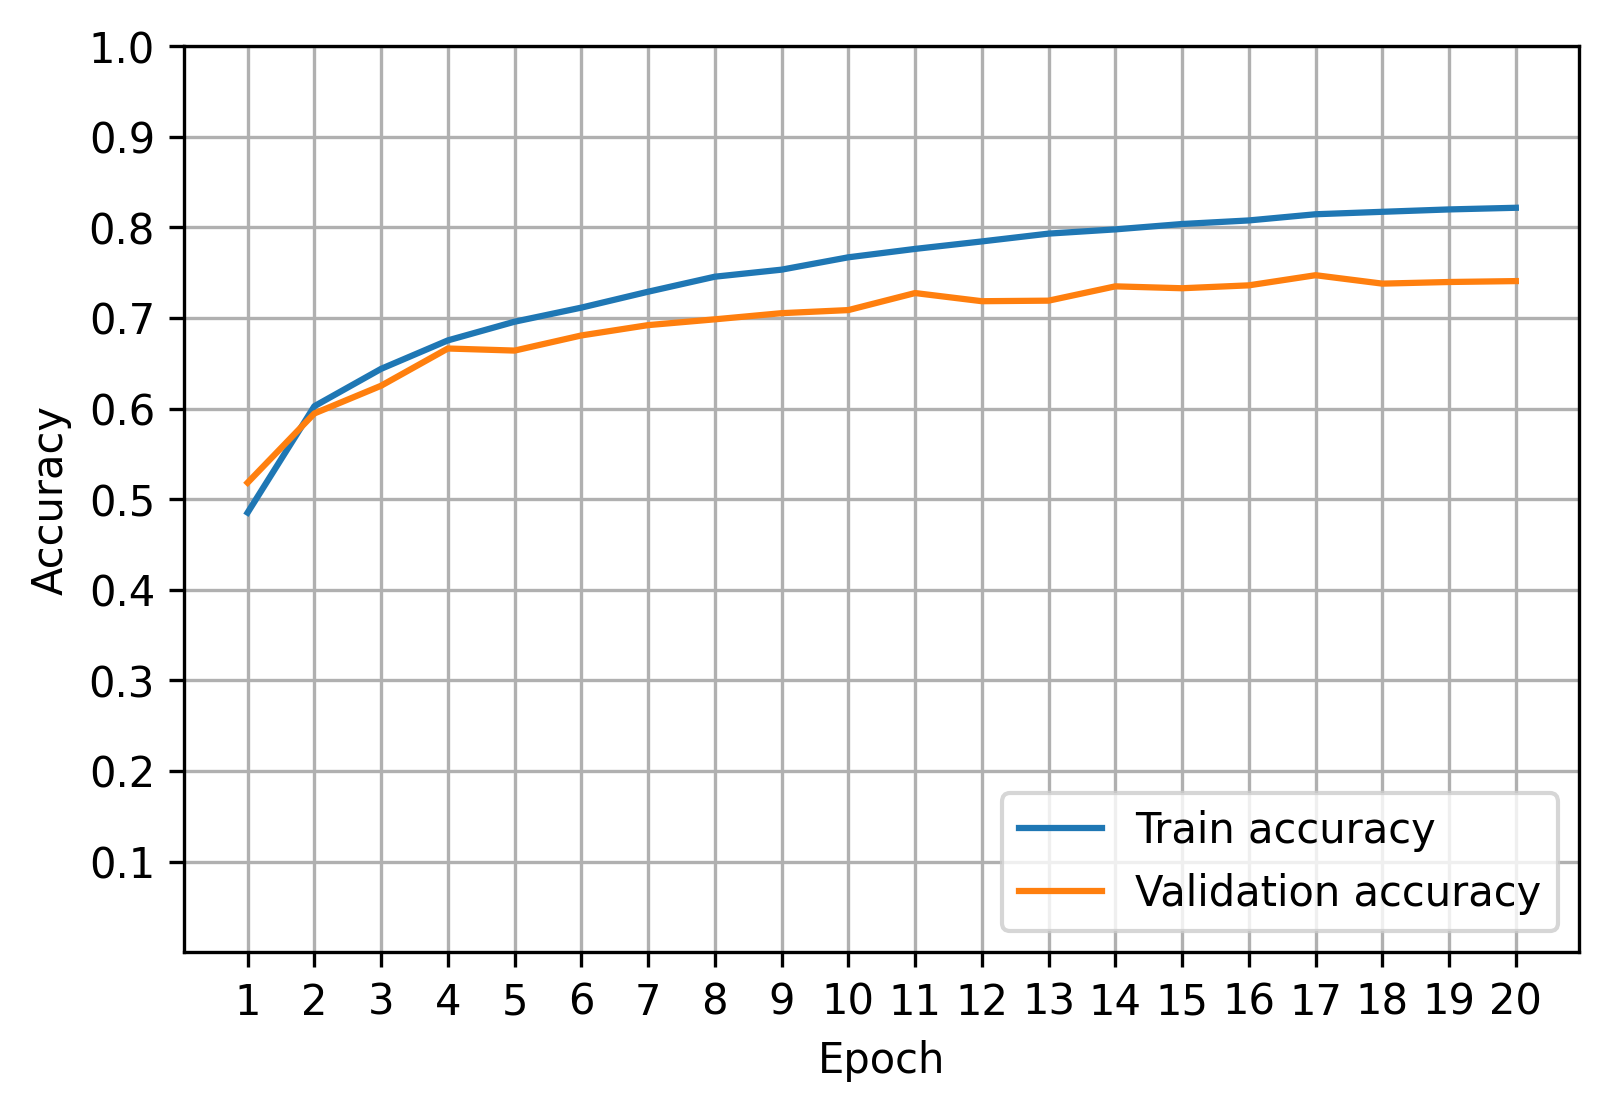

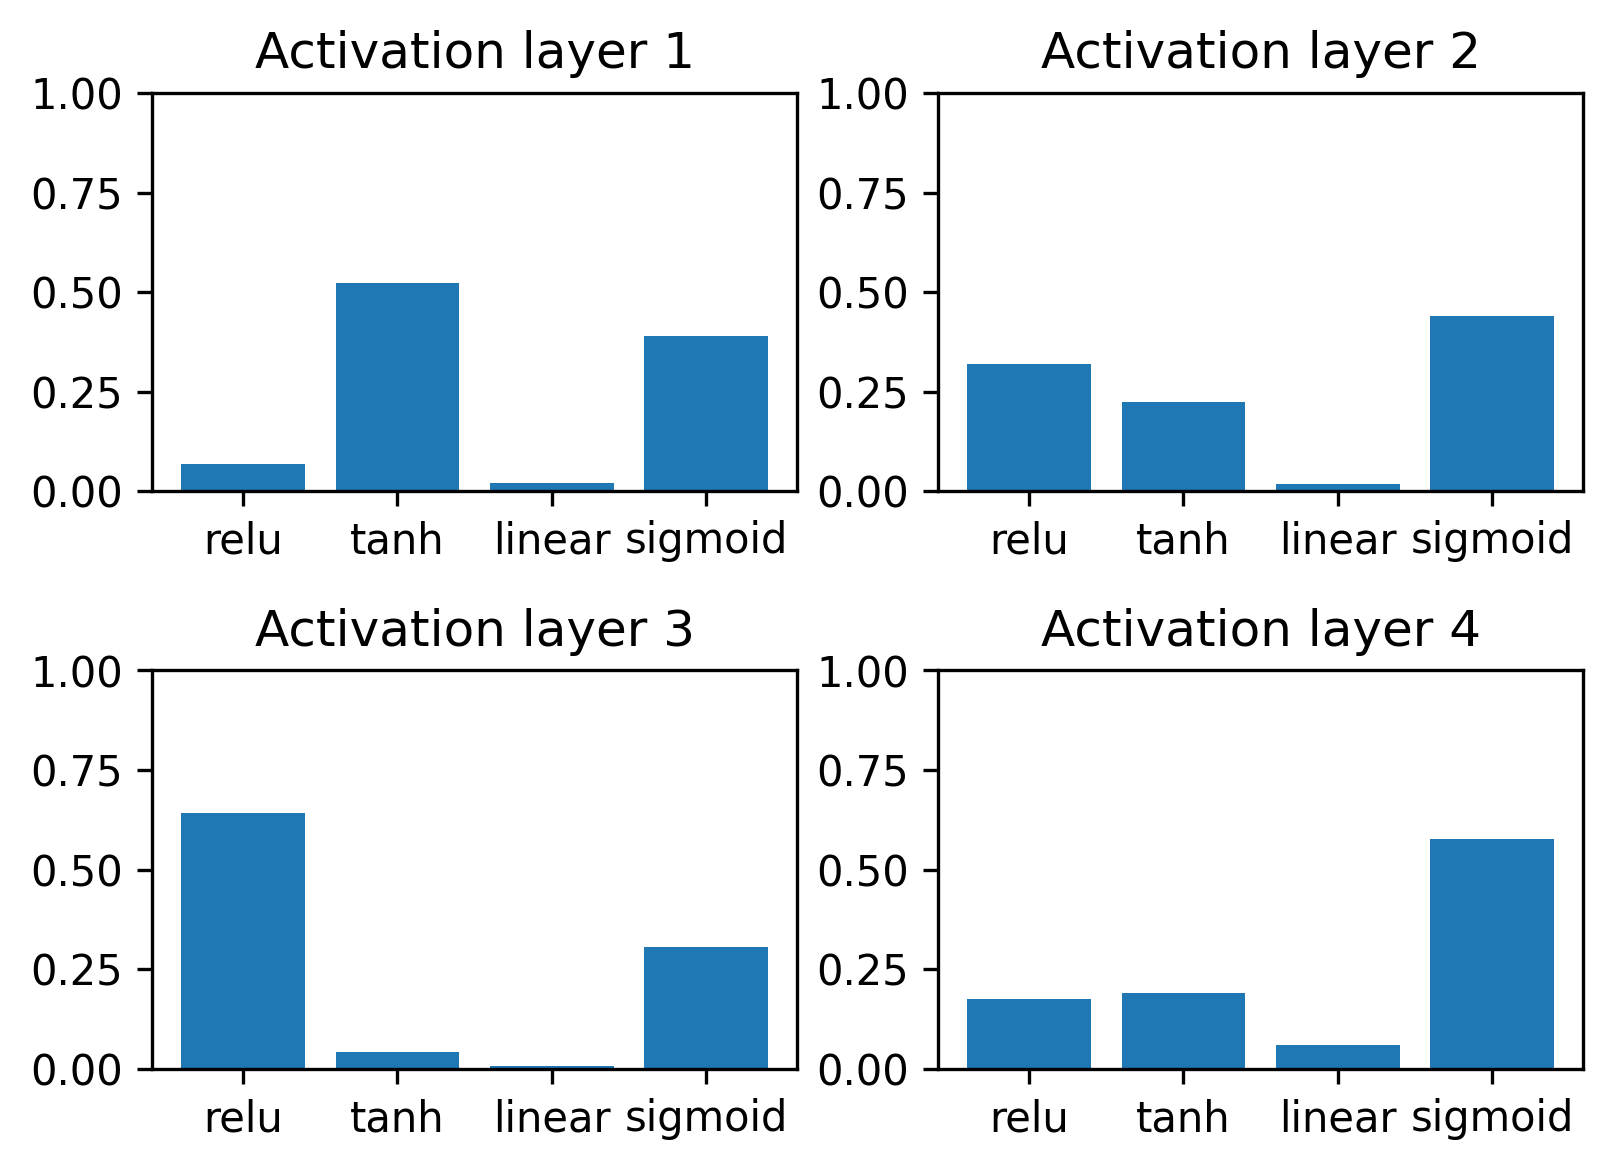

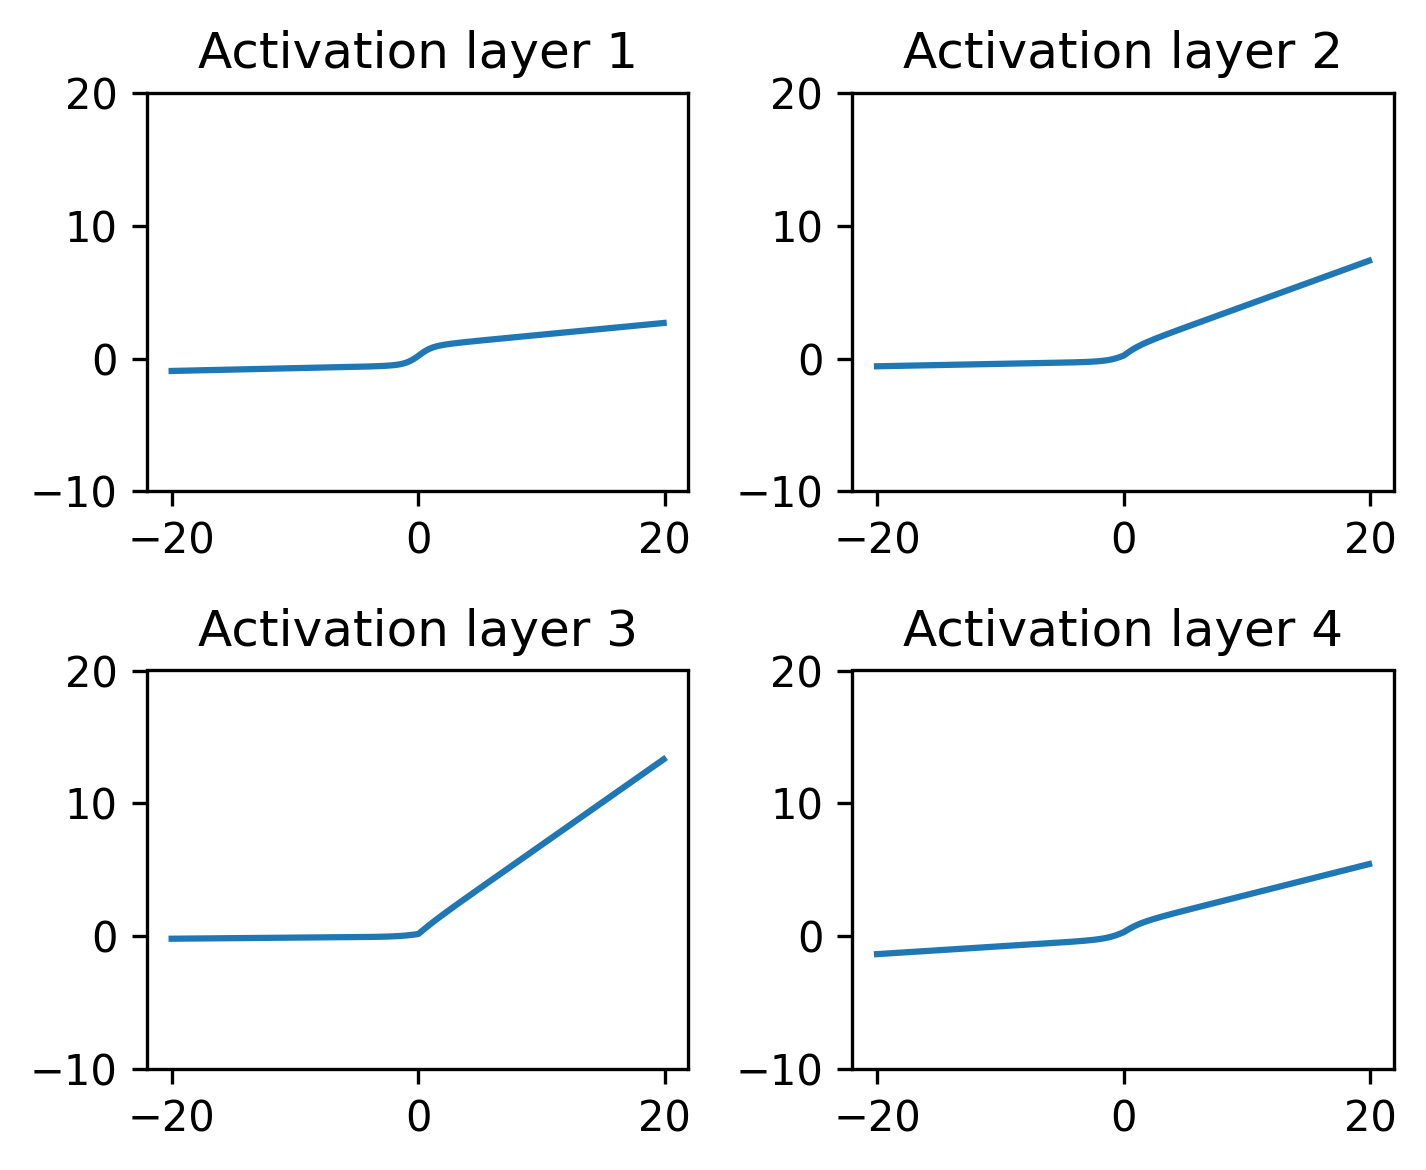

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.48515>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.9357744>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5182>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6026>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7160861>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5946>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.64385>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5976932>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6252>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.67525>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5169629>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6663>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.695875>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4552852>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, n

In [ ]:
model, history, test_acc, test_loss = output_val_layer
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7478, 0.7558, 0.7472]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7503 $\pm$ 0.0039
0.7502666666666666 +- 0.0039203174474637895


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8214, 0.8198, 0.821625]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8209 $\pm$ 0.0008
0.8209416666666667 +- 0.0008124893161691037


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc53ffa7170> <function sigmoid at 0x7fc53ffa7320>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function relu at 0x7fc53ffa2dd0> <function sigmoid at 0x7fc53ffa7320>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
Epoch 1/20
782/782 [==============================] - 21s 25ms/step - loss: 1.8381 - accuracy: 0.3713 - val_loss: 1.3995 - val_accuracy: 0.5375
Epoch 2/20
782/782 [==============================] - 19s 24ms/step - loss: 1.3917 - accuracy: 0.5503 - val_loss: 1.1925 - val_accuracy: 0.6240
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 1.2500 - accuracy: 0.6143 - val_loss: 1.1309 - val_accuracy:

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc53ffa7170> <function sigmoid at 0x7fc53ffa7320>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function relu at 0x7fc53ffa2dd0> <function sigmoid at 0x7fc53ffa7320>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
Epoch 1/20
782/782 [==============================] - 21s 25ms/step - loss: 1.8310 - accuracy: 0.3772 - val_loss: 1.5484 - val_accuracy: 0.4907
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 1.4415 - accuracy: 0.5313 - val_loss: 1.2715 - val_accuracy: 0.5952
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 1.2818 - accuracy: 0.5997 - val_loss: 1.1682 - val_accuracy:

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc53ffa7170> <function sigmoid at 0x7fc53ffa7320>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function relu at 0x7fc53ffa2dd0>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function relu at 0x7fc53ffa2dd0> <function sigmoid at 0x7fc53ffa7320>
 <function tanh at 0x7fc53ffa7170> <function linear at 0x7fc53ffa7830>]
[<function sigmoid at 0x7fc53ffa7320> <function tanh at 0x7fc53ffa7170>
 <function relu at 0x7fc53ffa2dd0> <function linear at 0x7fc53ffa7830>]
Epoch 1/20
782/782 [==============================] - 21s 25ms/step - loss: 1.8321 - accuracy: 0.3793 - val_loss: 1.4542 - val_accuracy: 0.5115
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 1.4477 - accuracy: 0.5299 - val_loss: 1.3750 - val_accuracy: 0.5578
Epoch 3/20
782/782 [==============================] - 19s 25ms/step - loss: 1.2787 - accuracy: 0.6039 - val_loss: 1.1783 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7572, 0.7434, 0.7473]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7493 $\pm$ 0.0058
0.7493 +- 0.005808614292583057


In [ ]:
print("Train accuracy mean:")
train_accs = [0.7615, 0.7487, 0.7531]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7544 $\pm$ 0.0053
0.7544333333333334 +- 0.00530994873379727


In [ ]:
model_4_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc53ffa7170>]
[<function sigmoid at 0x7fc53ffa7320>]
[<function relu at 0x7fc53ffa2dd0>]
[<function sigmoid at 0x7fc53ffa7320>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.3232 - accuracy: 0.1143 - val_loss: 2.1635 - val_accuracy: 0.2007
Epoch 2/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1156 - accuracy: 0.2199 - val_loss: 2.0492 - val_accuracy: 0.2575
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 2.0422 - accuracy: 0.2507 - val_loss: 1.9752 - val_accuracy: 0.2873
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.9484 - accuracy: 0.2925 - val_loss: 1.8113 - val_accuracy: 0.3582
Epoch 5/20
782/782 [==============================] - 9s 11ms/step - loss: 1.8820 - accuracy: 0.3248 - val_loss: 1.8178 - val_accuracy: 0.3500
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8592 - accuracy: 0.3324 - val_loss: 1.7669 - val_accuracy:

In [ ]:
model_4_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc53ffa7170>]
[<function sigmoid at 0x7fc53ffa7320>]
[<function relu at 0x7fc53ffa2dd0>]
[<function sigmoid at 0x7fc53ffa7320>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1687 - accuracy: 0.2072 - val_loss: 1.9999 - val_accuracy: 0.2765
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 2.0144 - accuracy: 0.2742 - val_loss: 1.8876 - val_accuracy: 0.3276
Epoch 3/20
782/782 [==============================] - 9s 11ms/step - loss: 1.8996 - accuracy: 0.3219 - val_loss: 1.8013 - val_accuracy: 0.3678
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8466 - accuracy: 0.3486 - val_loss: 1.7243 - val_accuracy: 0.3867
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8107 - accuracy: 0.3603 - val_loss: 1.7134 - val_accuracy: 0.3992
Epoch 6/20
782/782 [==============================] - 9s 11ms/step - loss: 1.7914 - accuracy: 0.3726 - val_loss: 1.6741 - val_accuracy:

In [ ]:
model_4 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fc53ffa7170>]
[<function sigmoid at 0x7fc53ffa7320>]
[<function relu at 0x7fc53ffa2dd0>]
[<function sigmoid at 0x7fc53ffa7320>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.3312 - accuracy: 0.1038 - val_loss: 2.1940 - val_accuracy: 0.1937
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 2.1236 - accuracy: 0.2156 - val_loss: 2.0257 - val_accuracy: 0.2644
Epoch 3/20
782/782 [==============================] - 9s 11ms/step - loss: 2.0531 - accuracy: 0.2477 - val_loss: 2.0101 - val_accuracy: 0.2660
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 2.0281 - accuracy: 0.2579 - val_loss: 1.9640 - val_accuracy: 0.2767
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 2.0042 - accuracy: 0.2682 - val_loss: 1.9498 - val_accuracy: 0.2858
Epoch 6/20
782/782 [==============================] - 9s 11ms/step - loss: 1.9780 - accuracy: 0.2811 - val_loss: 1.9029 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4887, 0.5471, 0.4554]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.4971 $\pm$ 0.0379
0.4970666666666667 +- 0.037900952787789155


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4486, 0.4985, 0.4167]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.4546 $\pm$ 0.0337
0.45460000000000006 +- 0.033663135128307146


## Tests - val data basic - wo dropouts - 20 epochs

### Test - layer - wo dropouts

#### Opt = 0.5

In [ ]:
output_val_layer_wo_reg_05 = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-wo-dropouts-05-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg_05[1]))

Using given val data
64
Epoch 1
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5249
Training accuracy for epoch: 0.43968
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-2-01.hdf5

Epoch 2
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5848
Training accuracy for epoch: 0.58928
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-2-02.hdf5

Epoch 3
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6154
Training accuracy for epoch: 0.64908
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-2-03.hdf5

Epoch 4
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.635
Training accuracy for epoch: 0.69
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-2-04.hdf5

Epoch 5
Step / 391: 0 100 20

In [ ]:
output_val_layer_wo_reg_05 = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-wo-dropouts-05-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg_05[1]))

Using given val data
64
Epoch 1
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5453
Training accuracy for epoch: 0.45148
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-3-01.hdf5

Epoch 2
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5703
Training accuracy for epoch: 0.60184
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-3-02.hdf5

Epoch 3
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6024
Training accuracy for epoch: 0.654
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-3-03.hdf5

Epoch 4
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6212
Training accuracy for epoch: 0.69416
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-05-3-04.hdf5

Epoch 5
Step / 391: 0 100 

In [ ]:
output_val_layer_wo_reg_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-wo-dropouts-05-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val(*x, **y, opt_split=0.5),
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.85436, 'val_accuracy': 0.6902}


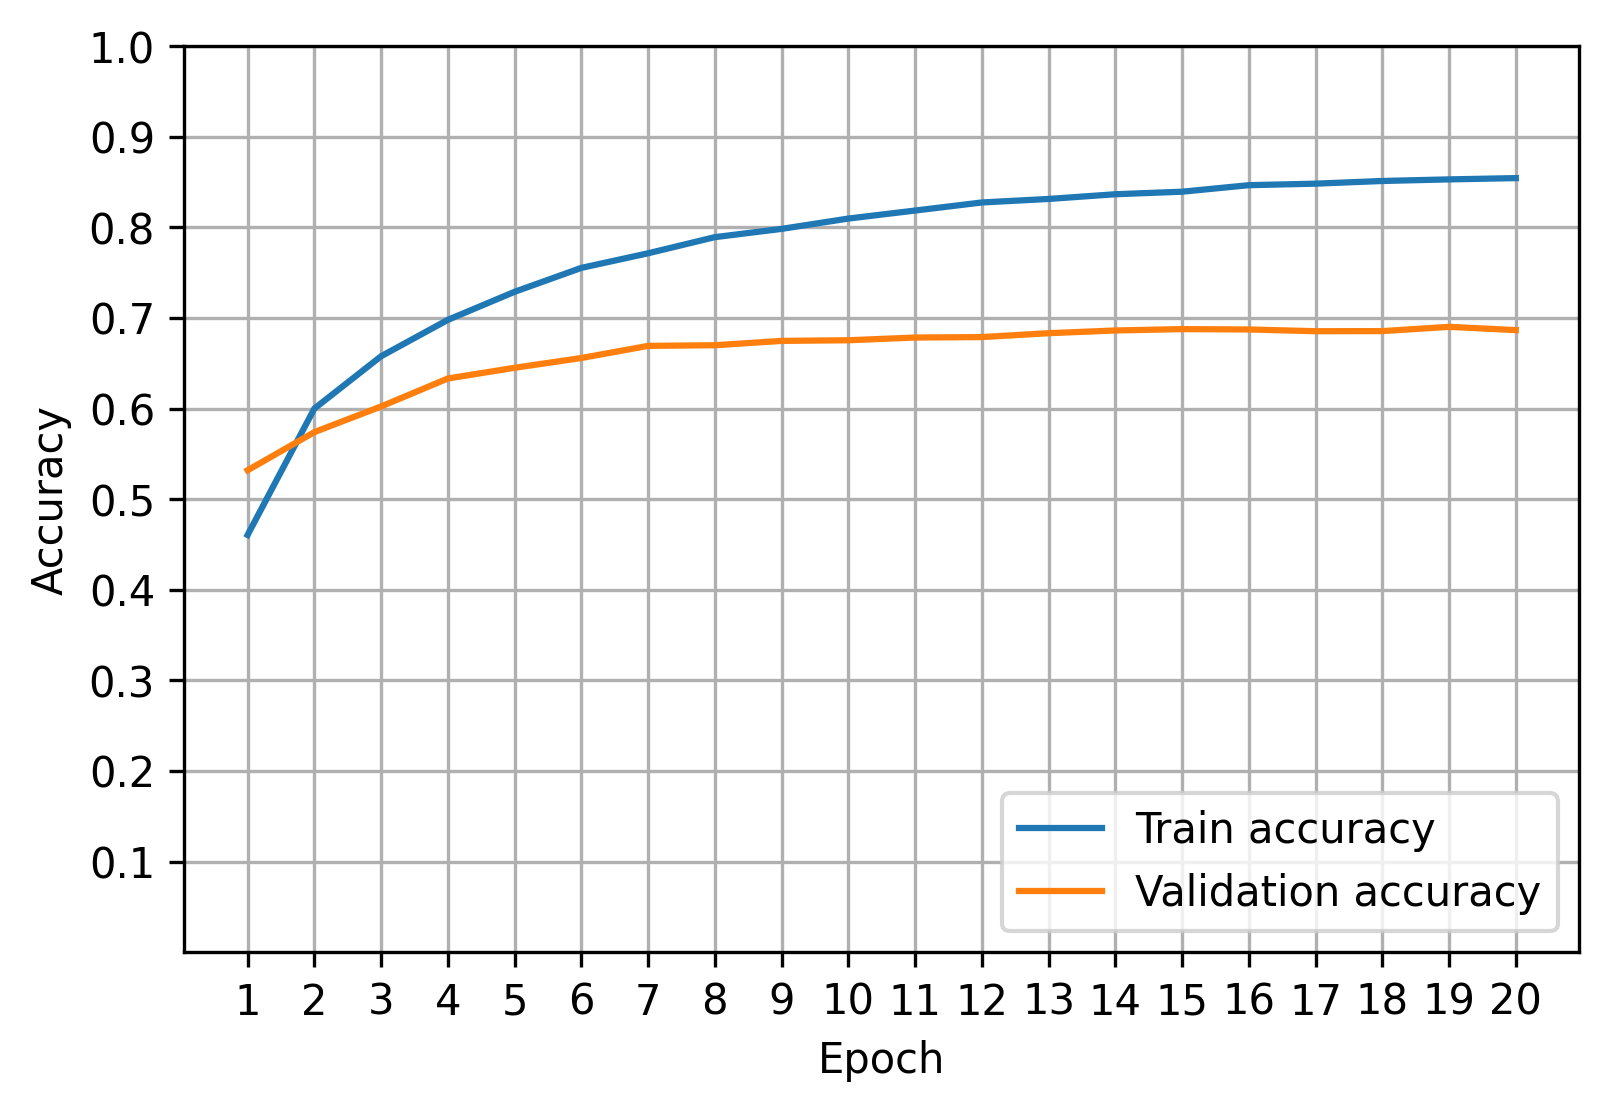

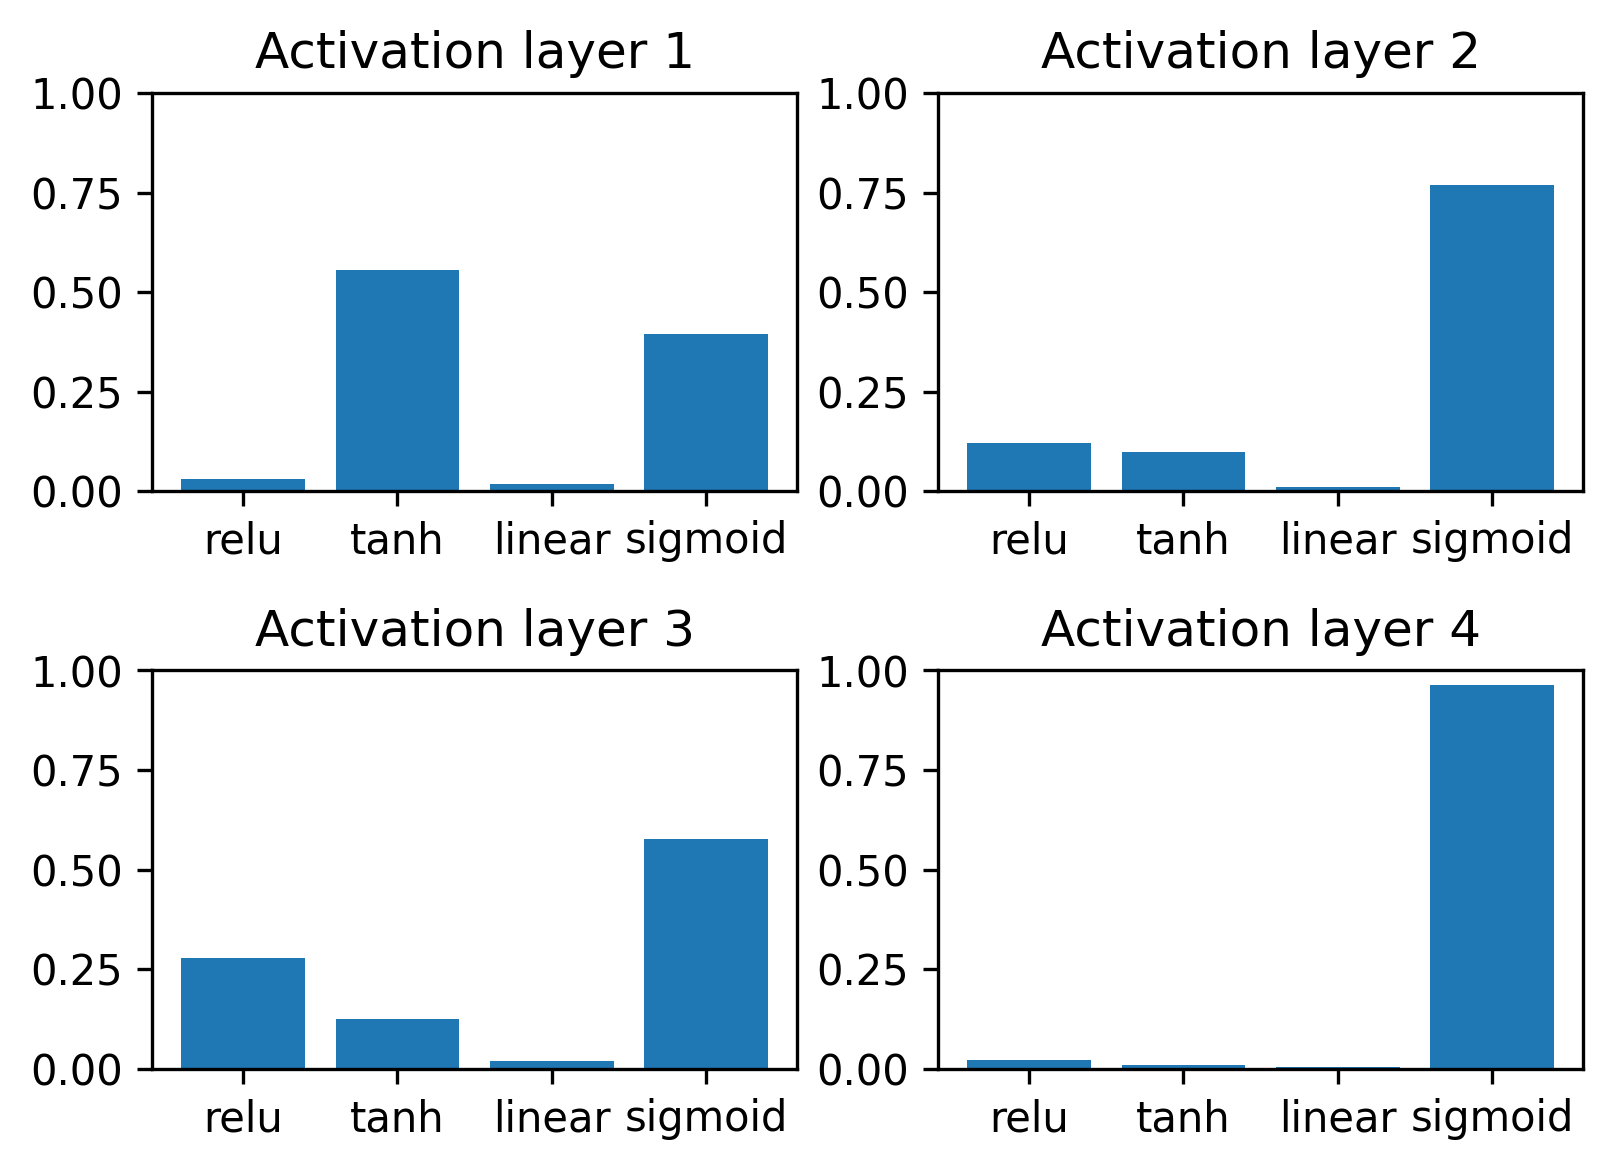

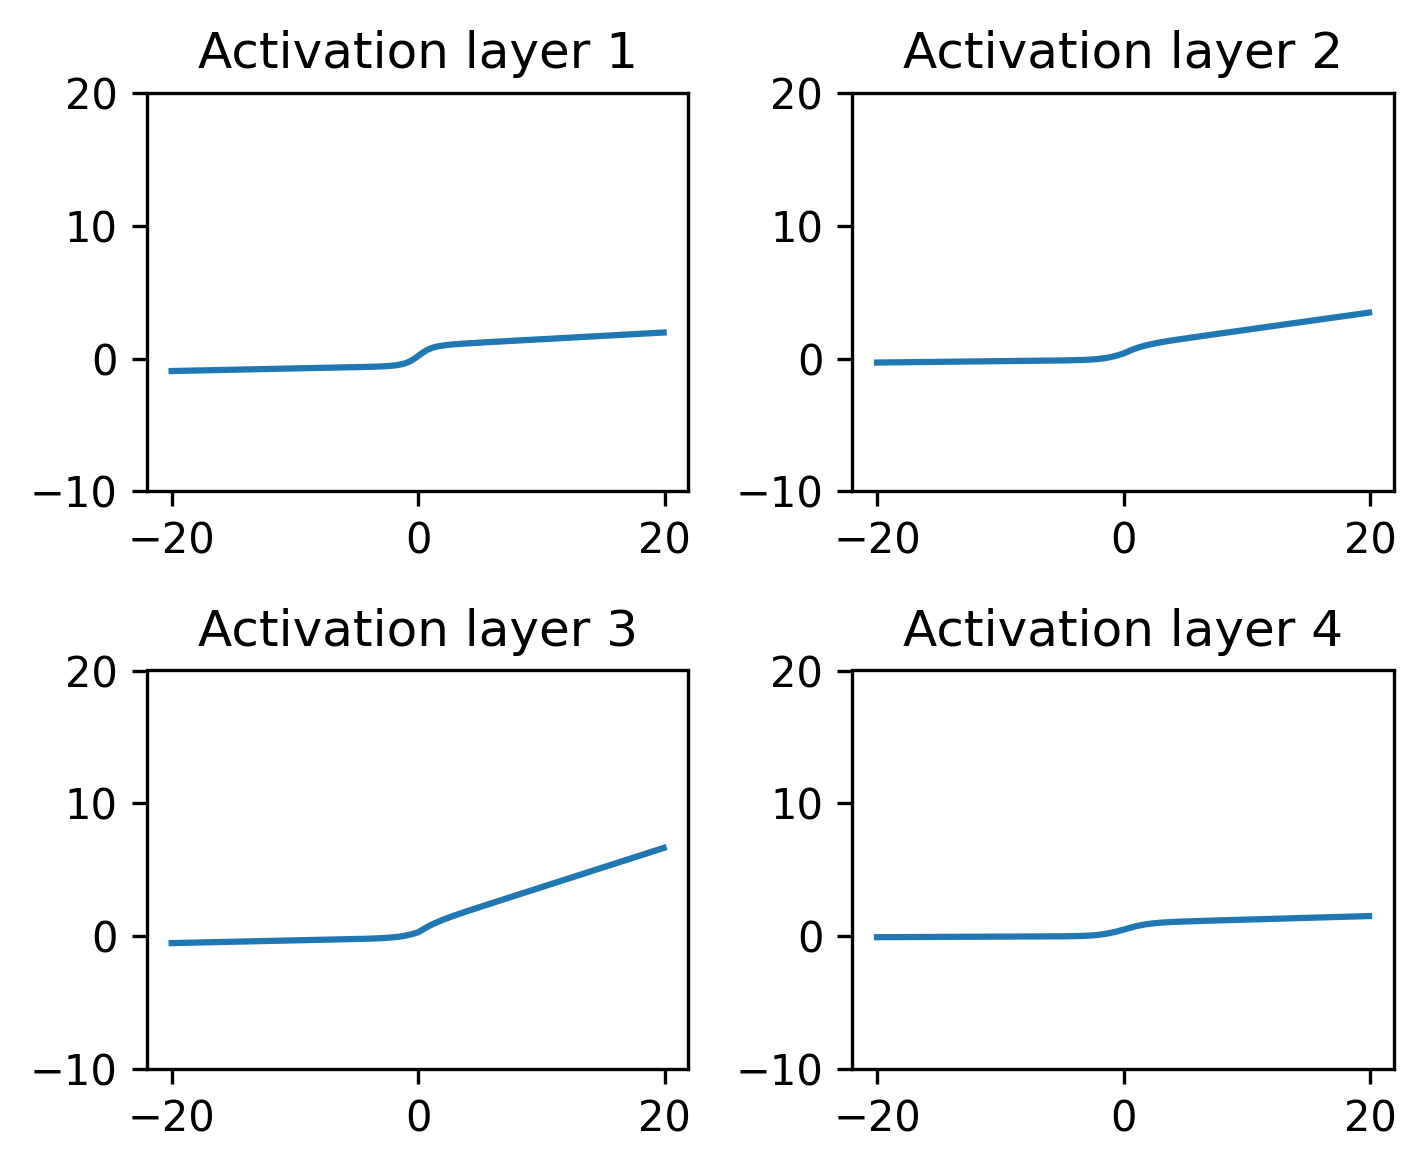

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.46052>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8662733>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5319>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6627209>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.574>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.65776>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5470346>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6023>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.69792>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4665883>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6332>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.72888>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.40585>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.

In [ ]:
model, history, test_acc, test_loss = output_val_layer_wo_reg_05
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.6902, 0.6976, 0.6847]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.6908 $\pm$ 0.0053
0.6908333333333333 +- 0.00528540968663316


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8543, 0.8469, 0.8468]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8493 $\pm$ 0.0035
0.8493333333333334 +- 0.0035122009560324724


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710> <function sigmoid at 0x7fd6b0b84f80>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 24s 29ms/step - loss: 1.7319 - accuracy: 0.4294 - val_loss: 1.4605 - val_accuracy: 0.5279
Epoch 2/20
782/782 [==============================] - 20s 26ms/step - loss: 1.2921 - accuracy: 0.5968 - val_loss: 1.2201 - val_accuracy: 0.6240
Epoch 3/20
782/782 [==============================] - 16s 21ms/step - loss: 1.1261 - accuracy: 0.6611 - val_loss: 1.1310 - val_accuracy:

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710> <function sigmoid at 0x7fd6b0b84f80>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 18s 21ms/step - loss: 1.6911 - accuracy: 0.4325 - val_loss: 1.4182 - val_accuracy: 0.5325
Epoch 2/20
782/782 [==============================] - 16s 20ms/step - loss: 1.2908 - accuracy: 0.5942 - val_loss: 1.2114 - val_accuracy: 0.6263
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 1.1471 - accuracy: 0.6509 - val_loss: 1.1120 - val_accuracy:

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f422ea470e0> <function sigmoid at 0x7f422ea47290>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f422ea47290> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f422ea470e0> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f422ea47290> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f422ea470e0> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f422ea47290> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f422ea470e0> <function linear at 0x7f422ea477a0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.6746 - accuracy: 0.4383 - val_loss: 1.4220 - val_accuracy: 0.5387
Epoch 2/20
782/782 [==============================] - 15s 19ms/step - loss: 1.2837 - accuracy: 0.5997 - val_loss: 1.2514 - val_accuracy: 0.6183
Epoch 3/20
782/782 [==============================] - 15s 19ms/step - loss: 1.1359 - accuracy: 0.6575 - val_loss: 1.1199 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7382, 0.7395, 0.7350]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7376 $\pm$ 0.0019
0.7375666666666666 +- 0.0018909139471577293


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8445, 0.8390, 0.8612]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8482 $\pm$ 0.0094
0.8482333333333333 +- 0.00943975046751177


In [ ]:
model_3_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710>]
[<function sigmoid at 0x7fd6b0b84f80>]
[<function sigmoid at 0x7fd6b0b84f80>]
[<function sigmoid at 0x7fd6b0b84f80>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.0857 - accuracy: 0.2376 - val_loss: 1.8807 - val_accuracy: 0.3365
Epoch 2/20
782/782 [==============================] - 9s 11ms/step - loss: 1.7764 - accuracy: 0.3845 - val_loss: 1.7250 - val_accuracy: 0.4001
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7048 - accuracy: 0.4157 - val_loss: 1.7084 - val_accuracy: 0.4242
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6492 - accuracy: 0.4390 - val_loss: 1.6013 - val_accuracy: 0.4564
Epoch 5/20
782/782 [==============================] - 9s 11ms/step - loss: 1.6181 - accuracy: 0.4516 - val_loss: 1.5830 - val_accuracy: 0.4597
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5848 - accuracy: 0.4705 - val_loss: 1.5890 - val_accur

In [ ]:
model_3_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fec6ffd17a0>]
[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.9240 - accuracy: 0.3330 - val_loss: 1.8224 - val_accuracy: 0.3826
Epoch 2/20
782/782 [==============================] - 8s 11ms/step - loss: 1.6244 - accuracy: 0.4517 - val_loss: 1.6055 - val_accuracy: 0.4663
Epoch 3/20
782/782 [==============================] - 8s 11ms/step - loss: 1.5584 - accuracy: 0.4829 - val_loss: 1.5282 - val_accuracy: 0.4935
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.4936 - accuracy: 0.5191 - val_loss: 1.4312 - val_accuracy: 0.5466
Epoch 5/20
782/782 [==============================] - 8s 11ms/step - loss: 1.4358 - accuracy: 0.5432 - val_loss: 1.4679 - val_accuracy: 0.5402
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.3952 - accuracy: 0.5649 - val_loss: 1.4141 - val_accura

In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f868a754dd0>]
[<function sigmoid at 0x7f868a002680>]
[<function sigmoid at 0x7f868a002680>]
[<function sigmoid at 0x7f868a002680>]
Epoch 1/20
782/782 [==============================] - 18s 11ms/step - loss: 1.9700 - accuracy: 0.3152 - val_loss: 1.7273 - val_accuracy: 0.4018
Epoch 2/20
782/782 [==============================] - 9s 12ms/step - loss: 1.6343 - accuracy: 0.4471 - val_loss: 1.5549 - val_accuracy: 0.4755
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5687 - accuracy: 0.4761 - val_loss: 1.5374 - val_accuracy: 0.4855
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 1.5207 - accuracy: 0.4997 - val_loss: 1.5186 - val_accuracy: 0.5035
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.4831 - accuracy: 0.5198 - val_loss: 1.4863 - val_accuracy: 0.5256
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.4514 - accuracy: 0.5368 - val_loss: 1.4456 - val_accur

In [ ]:
print("Test accuracy mean:")
test_accs = [0.6325, 0.6369, 0.5918]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.6204 $\pm$ 0.0203
0.6204000000000001 +- 0.020302873359863787


In [ ]:
print("Train accuracy mean:")
train_accs = [0.6475, 0.6609, 0.6000]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.6361 $\pm$ 0.0261
0.6361333333333333 +- 0.02612920885820228


#### Opt =  0.2

In [ ]:
output_val_layer_wo_reg = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-wo-dropouts-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg[1]))

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.57
Training accuracy for epoch: 0.511625
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-2-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6242
Training accuracy for epoch: 0.637575
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-2-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6493
Training accuracy for epoch: 0.687075
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-2-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.673
Training accuracy for epoch: 0.71875
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts

In [ ]:
output_val_layer_wo_reg = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-wo-dropouts-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_wo_reg[1]))

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5474
Training accuracy for epoch: 0.50235
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-3-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6069
Training accuracy for epoch: 0.635775
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-3-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6333
Training accuracy for epoch: 0.685275
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropouts-3-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6527
Training accuracy for epoch: 0.72075
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-wo-dropou

In [ ]:
output_val_layer_wo_reg = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.8432, 'val_accuracy': 0.7231}


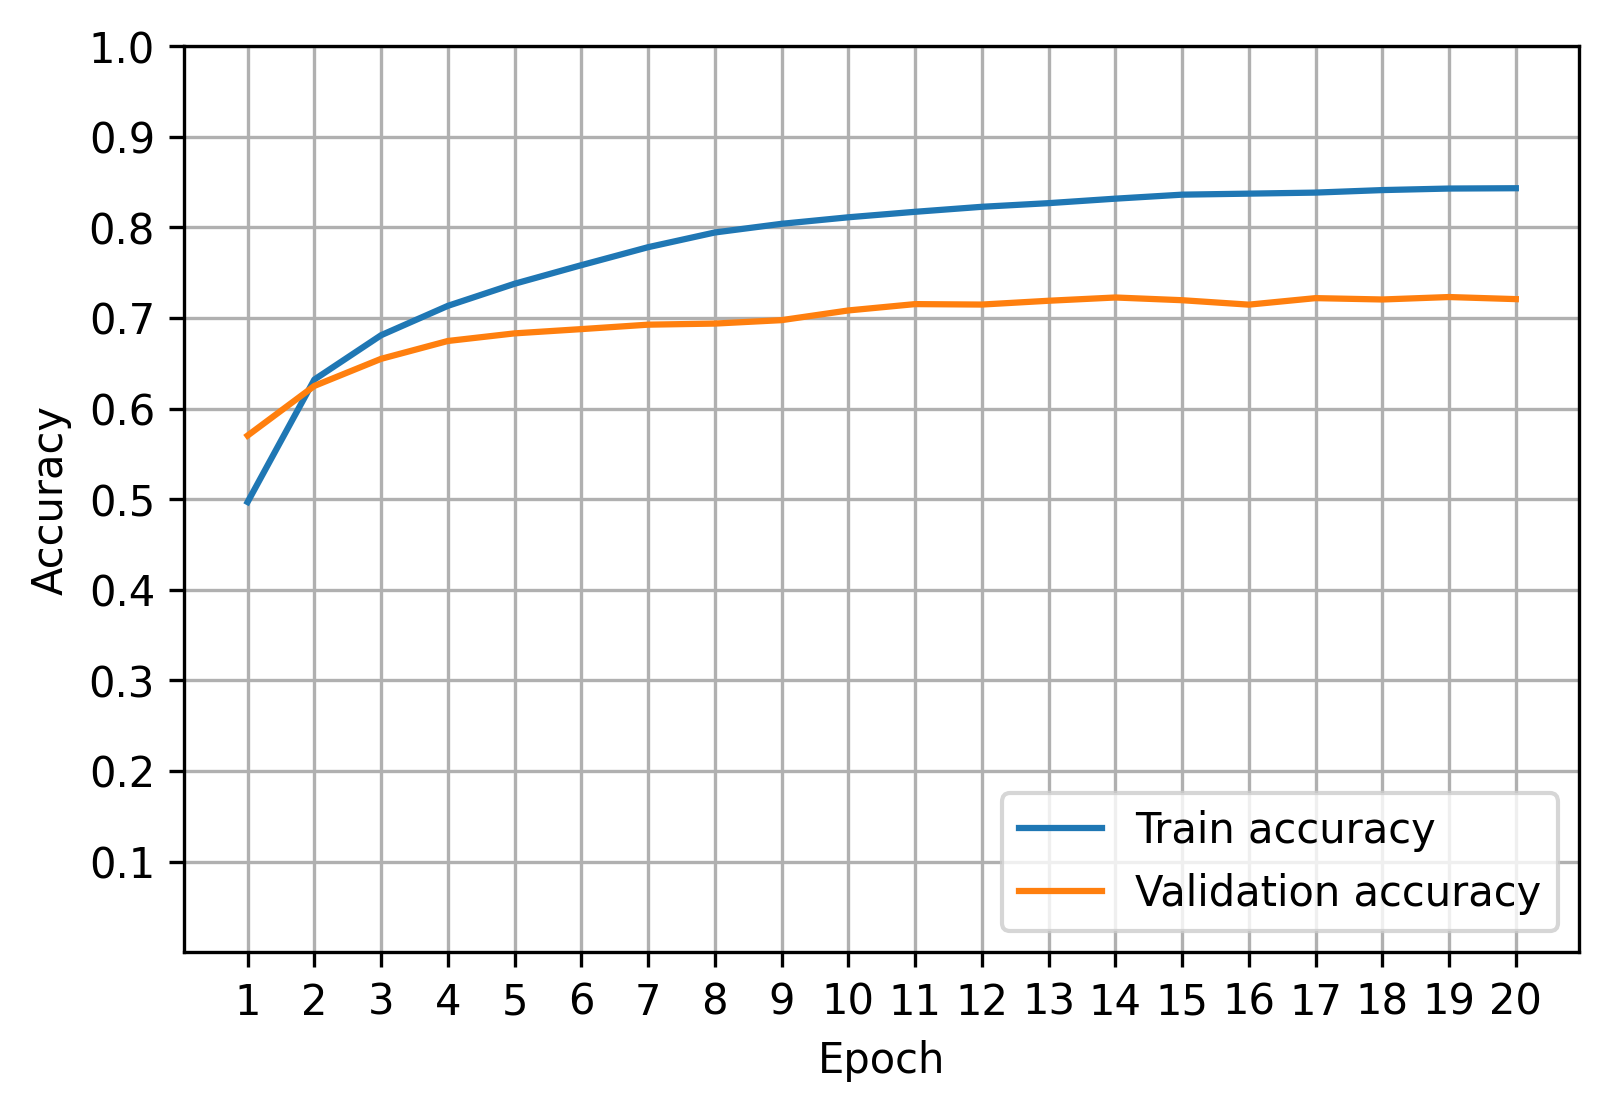

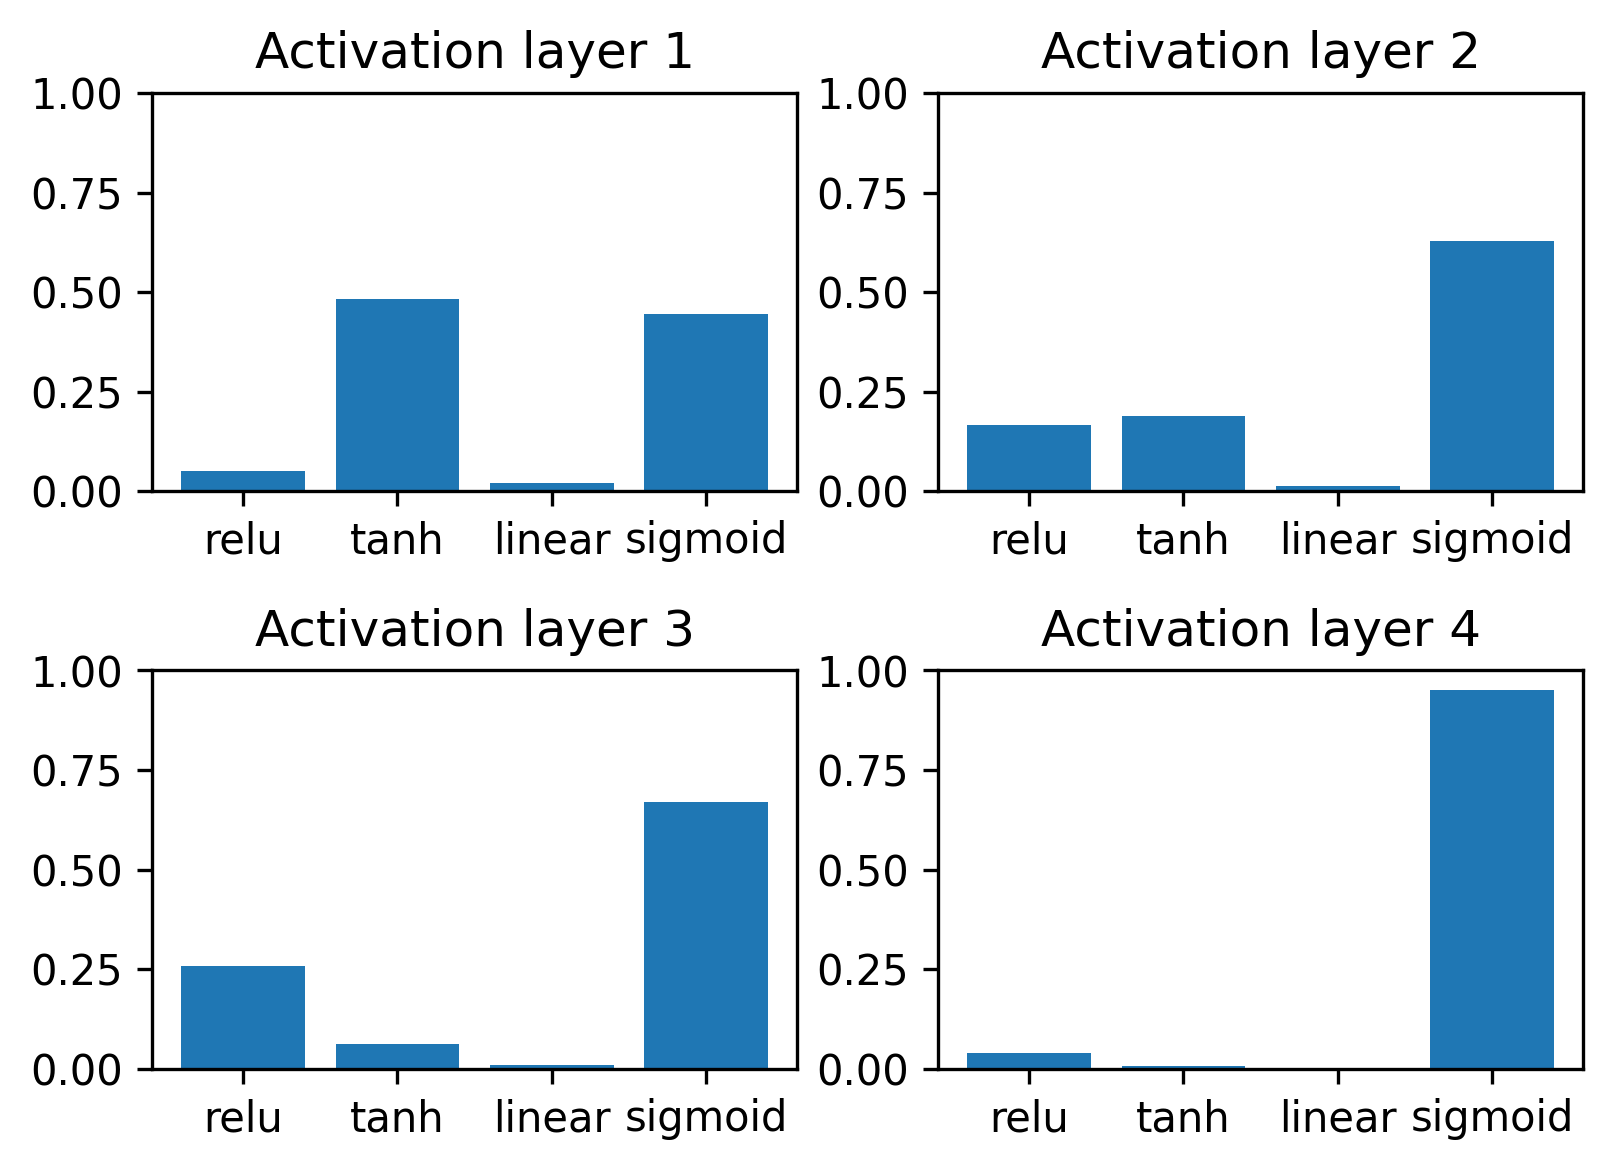

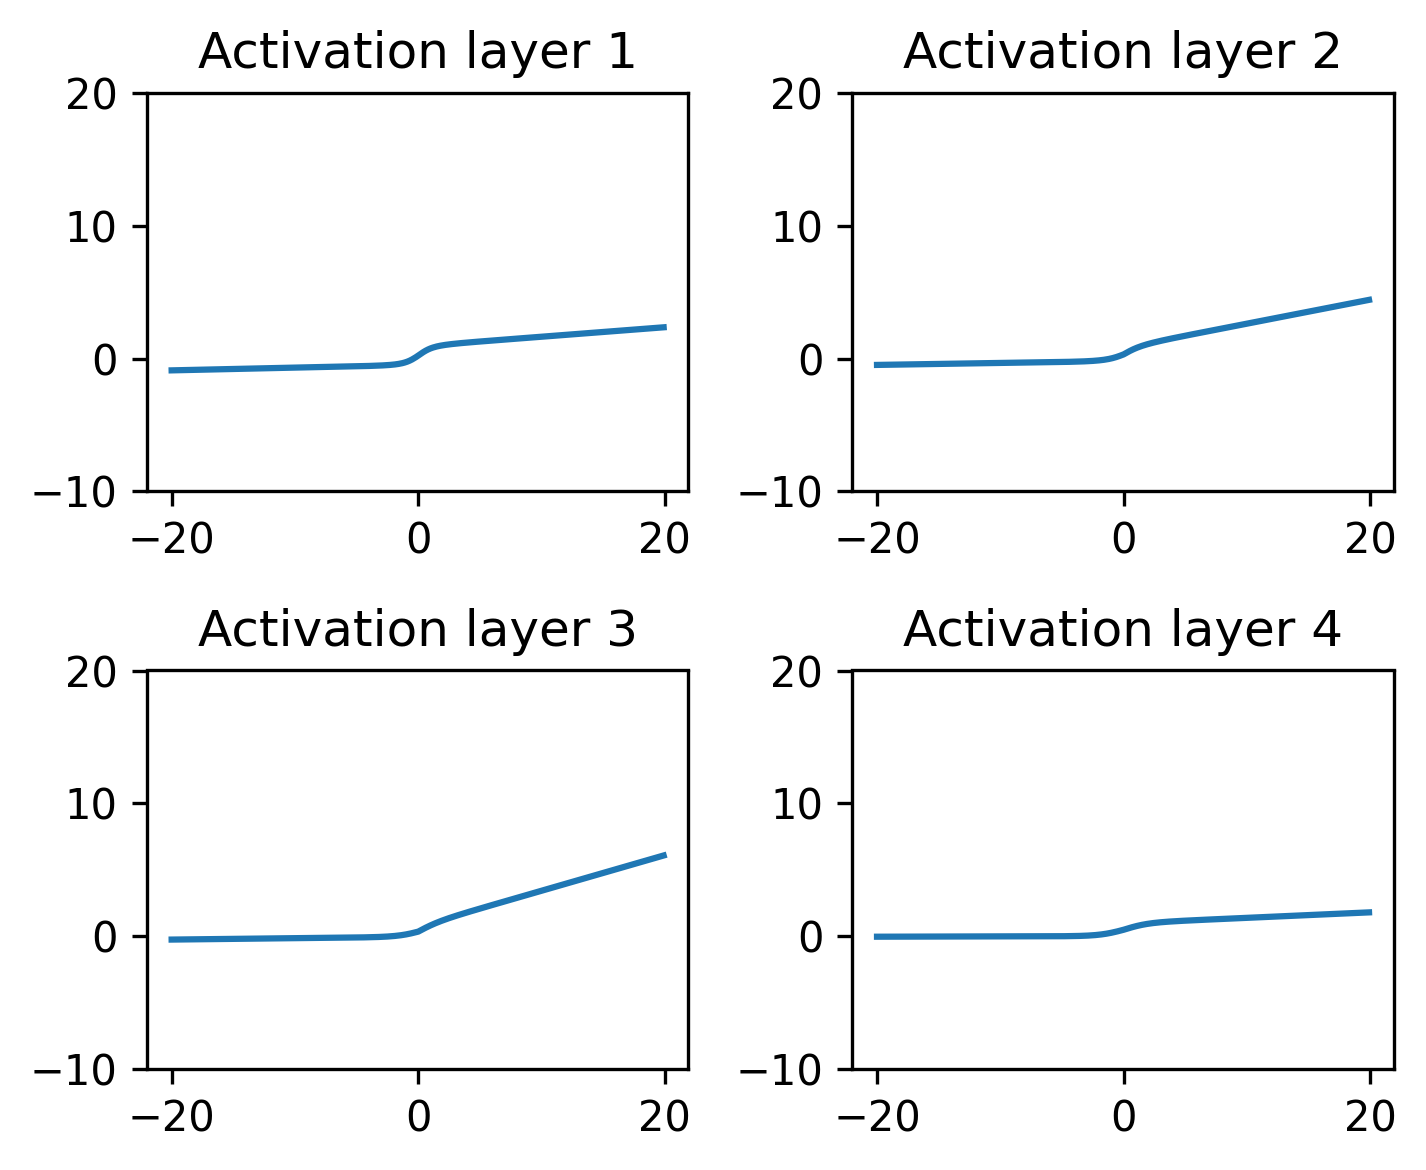

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.49685>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7505567>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5702>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.632025>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5449145>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.625>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.680975>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4294897>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6549>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.713375>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3502789>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6746>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.737775>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2918593>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32

In [ ]:
model, history, test_acc, test_loss = output_val_layer_wo_reg
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7231, 0.7026, 0.7282]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7180 $\pm$ 0.0111
0.7179666666666668 +- 0.011063553779063118


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8432, 0.8509, 0.8488]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8476 $\pm$ 0.0032
0.8476333333333333 +- 0.003249957264676314


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710> <function sigmoid at 0x7fd6b0b84f80>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 17s 21ms/step - loss: 1.6760 - accuracy: 0.4514 - val_loss: 1.3310 - val_accuracy: 0.5843
Epoch 2/20
782/782 [==============================] - 16s 20ms/step - loss: 1.2326 - accuracy: 0.6184 - val_loss: 1.1506 - val_accuracy: 0.6514
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 1.0958 - accuracy: 0.6731 - val_loss: 1.1479 - val_accuracy:

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710> <function sigmoid at 0x7fd6b0b84f80>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 17s 21ms/step - loss: 1.8870 - accuracy: 0.3301 - val_loss: 1.5946 - val_accuracy: 0.4492
Epoch 2/20
782/782 [==============================] - 16s 20ms/step - loss: 1.4199 - accuracy: 0.5279 - val_loss: 1.3023 - val_accuracy: 0.5763
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 1.2270 - accuracy: 0.6112 - val_loss: 1.2438 - val_accuracy:

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0> <function sigmoid at 0x7f426ab6d680>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f426ab6d680> <function tanh at 0x7f426b33cdd0>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f426b33cdd0> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f426b33cdd0> <function linear at 0x7f422ea477a0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.6785 - accuracy: 0.4547 - val_loss: 1.3325 - val_accuracy: 0.5865
Epoch 2/20
782/782 [==============================] - 15s 19ms/step - loss: 1.2517 - accuracy: 0.6151 - val_loss: 1.1406 - val_accuracy: 0.6599
Epoch 3/20
782/782 [==============================] - 15s 19ms/step - loss: 1.0991 - accuracy: 0.6757 - val_loss: 1.1593 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7357, 0.7300, 0.7489]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7382 $\pm$ 0.0079
0.7382 +- 0.007915806970865328


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8626, 0.8218, 0.8630]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8491 $\pm$ 0.0193
0.8491333333333334 +- 0.01932827520039548


In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=2, reset_weights_except_act=True))
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0> <function sigmoid at 0x7f426ab6d680>]
[<function sigmoid at 0x7f426ab6d680> <function tanh at 0x7f426b33cdd0>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>]
Epoch 1/20
782/782 [==============================] - 14s 16ms/step - loss: 2.1246 - accuracy: 0.2252 - val_loss: 1.8800 - val_accuracy: 0.3347
Epoch 2/20
782/782 [==============================] - 12s 15ms/step - loss: 1.7936 - accuracy: 0.3712 - val_loss: 1.8430 - val_accuracy: 0.3535
Epoch 3/20
782/782 [==============================] - 12s 15ms/step - loss: 1.6641 - accuracy: 0.4239 - val_loss: 1.5962 - val_accuracy: 0.4404
Epoch 4/20
782/782 [==============================] - 12s 15ms/step - loss: 1.5637 - accuracy: 0.4617 - val_loss: 1.5062 - val_accuracy: 0.4791
Epoch 5/20
782/782 [==============================] - 12s 15ms/step - loss: 1.4816 - accuracy: 0.4961 - val_loss: 1.4589 - val_accur

In [ ]:
model_4_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710>]
[<function sigmoid at 0x7fd6b0b84f80>]
[<function sigmoid at 0x7fd6b0b84f80>]
[<function sigmoid at 0x7fd6b0b84f80>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1388 - accuracy: 0.2126 - val_loss: 1.9733 - val_accuracy: 0.2816
Epoch 2/20
782/782 [==============================] - 9s 12ms/step - loss: 1.8877 - accuracy: 0.3337 - val_loss: 1.8043 - val_accuracy: 0.3895
Epoch 3/20
782/782 [==============================] - 9s 12ms/step - loss: 1.7470 - accuracy: 0.3985 - val_loss: 1.7617 - val_accuracy: 0.3941
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 1.6834 - accuracy: 0.4212 - val_loss: 1.6578 - val_accuracy: 0.4251
Epoch 5/20
782/782 [==============================] - 9s 12ms/step - loss: 1.6600 - accuracy: 0.4335 - val_loss: 1.6439 - val_accuracy: 0.4342
Epoch 6/20
782/782 [==============================] - 9s 12ms/step - loss: 1.6282 - accuracy: 0.4456 - val_loss: 1.6048 - val_accura

In [ ]:
model_4_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f9ff135c710>]
[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 1.9268 - accuracy: 0.3340 - val_loss: 1.6461 - val_accuracy: 0.4342
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.6196 - accuracy: 0.4508 - val_loss: 1.5628 - val_accuracy: 0.4704
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.5450 - accuracy: 0.4853 - val_loss: 1.5300 - val_accuracy: 0.4902
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.4947 - accuracy: 0.5116 - val_loss: 1.4369 - val_accuracy: 0.5332
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.4480 - accuracy: 0.5357 - val_loss: 1.4662 - val_accuracy: 0.5287
Epoch 6/20
782/782 [==============================] - 9s 11ms/step - loss: 1.4114 - accuracy: 0.5569 - val_loss: 1.4216 - val_accura

In [ ]:
model_4 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0>]
[<function sigmoid at 0x7f426ab6d680>]
[<function sigmoid at 0x7f426ab6d680>]
[<function sigmoid at 0x7f426ab6d680>]
Epoch 1/20
782/782 [==============================] - 8s 9ms/step - loss: 2.0721 - accuracy: 0.2489 - val_loss: 1.8716 - val_accuracy: 0.3388
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 1.8351 - accuracy: 0.3552 - val_loss: 1.7712 - val_accuracy: 0.3864
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 1.7685 - accuracy: 0.3884 - val_loss: 1.7264 - val_accuracy: 0.4038
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 1.7410 - accuracy: 0.3995 - val_loss: 1.7659 - val_accuracy: 0.3889
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 1.7237 - accuracy: 0.4079 - val_loss: 1.7371 - val_accuracy: 0.4034
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss: 1.6884 - accuracy: 0.4230 - val_loss: 1.7489 - val_accuracy: 0.

In [ ]:
print("Test accuracy mean:")
test_accs = [0.5393, 0.6629, 0.5833]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.5952 $\pm$ 0.0512
0.5951666666666666 +- 0.051152408436835994


In [ ]:
print("Train accuracy mean:")
train_accs = [0.5397, 0.6621, 0.5731]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.5916 $\pm$ 0.0517
0.5916333333333333 +- 0.05165948337161556


### Test - kernel - wo dropouts

In [ ]:
output_val_kernel_wo_reg = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-kernel-basic-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Reading model from file


In [ ]:
model, history, test_acc, test_loss = output_val_kernel_wo_reg
print(get_max_accuracy(history))
plot_performance(history)
display(history)

{'accuracy': 0.891725, 'val_accuracy': 0.6947}


[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.497675>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.765797>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5449>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.63075>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5573462>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6144>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.67415>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4440112>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6424>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.71025>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3645933>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6622>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.7338>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3069111>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, nu

### Test - neuron - wo dropouts

In [ ]:
output_val_neuron_wo_reg = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-neuron-basic-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.887425, 'val_accuracy': 0.6792}


[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.49545>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7662445>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5497>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.624375>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5656543>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5994>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.671525>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.454318>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.61>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.703875>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3770005>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6392>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.728325>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3182379>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, 

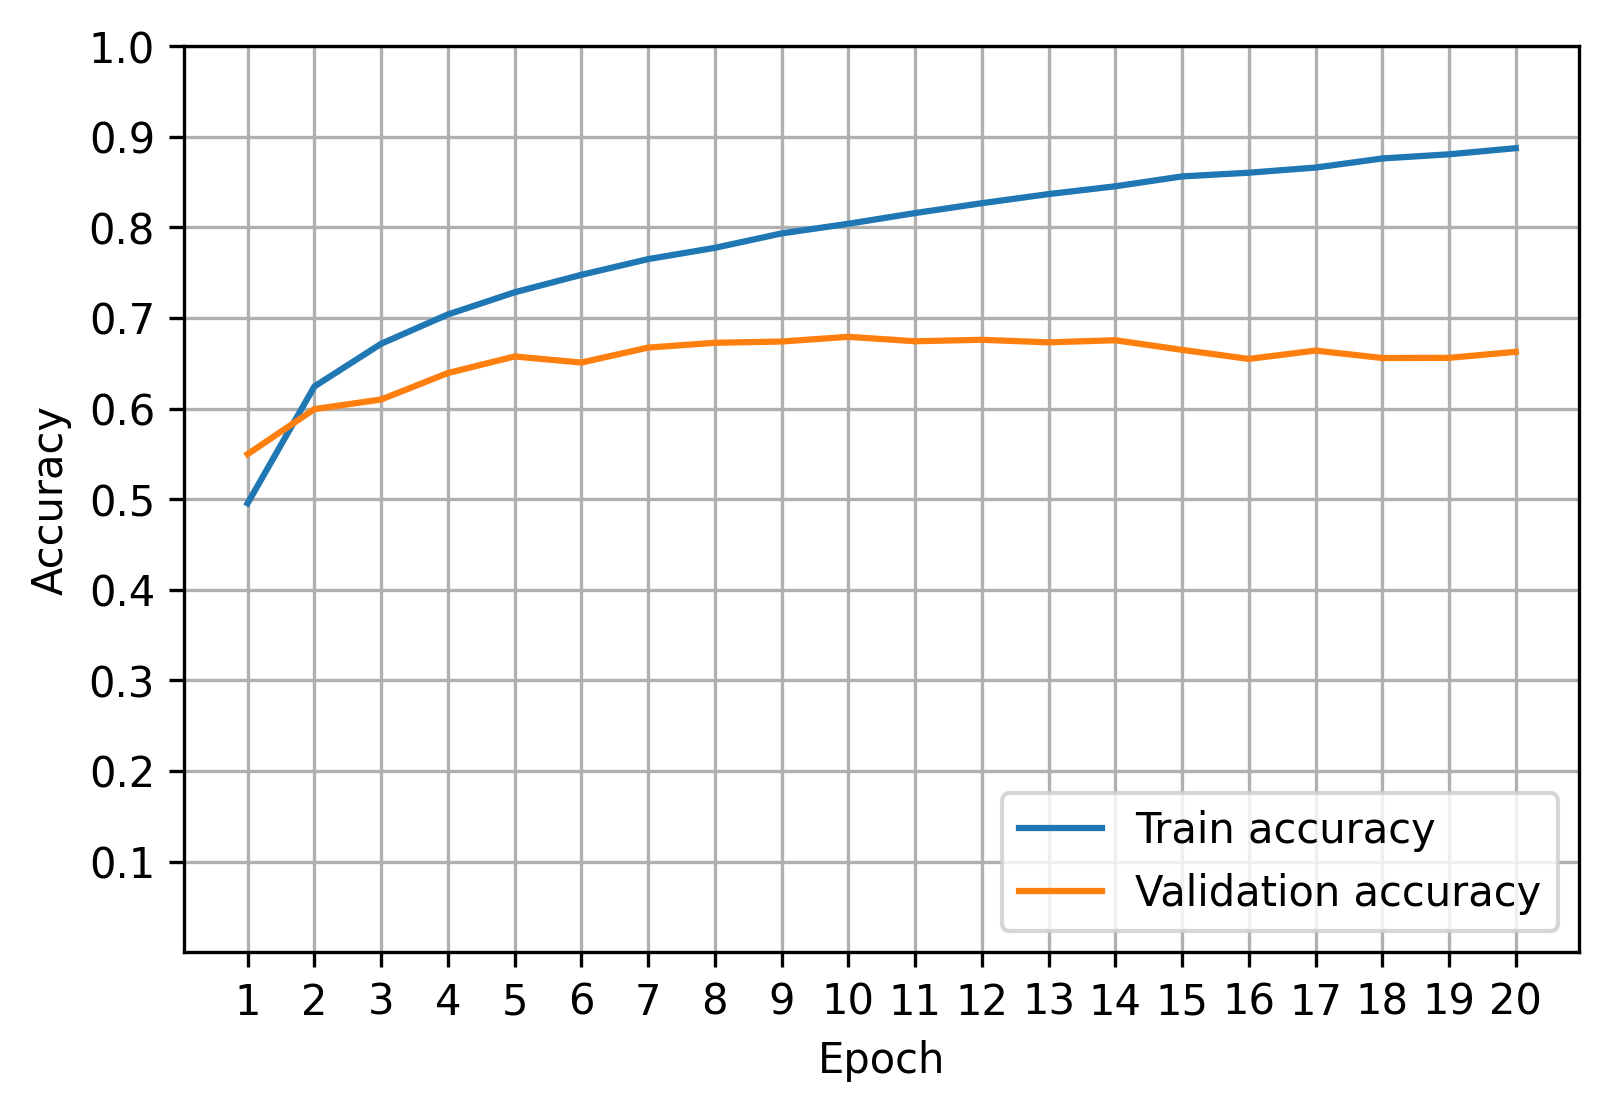

In [ ]:
model, history, test_acc, test_loss = output_val_neuron_wo_reg
print(get_max_accuracy(history))
plot_performance(history)
display(history)

## Tests - val data basic - 20 epochs

### Test - layer

#### Opt = 0.5

In [ ]:
output_val_layer_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-05-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_05[1]))

Reading model from file
{'accuracy': 0.8156, 'val_accuracy': 0.7246}


In [ ]:
output_val_layer_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-05-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val(*x, **y, opt_split=0.5),
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer_05[1]))

Training model
Using given val data
64
Epoch 1
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5016
Training accuracy for epoch: 0.45416
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-05-3-01.hdf5

Epoch 2
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5668
Training accuracy for epoch: 0.5782
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-05-3-02.hdf5

Epoch 3
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.5873
Training accuracy for epoch: 0.6194
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-05-3-03.hdf5

Epoch 4
Step / 391: 0 100 200 300 391
Validation accuracy for epoch: 0.6195
Training accuracy for epoch: 0.6498
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-05-3-04.hdf5

Epoch 5
Step / 391: 0 100 200 300 391
Validation accuracy fo

In [ ]:
output_val_layer_05 = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-05-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=lambda *x, **y: model_train_val(*x, **y, opt_split=0.5),
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.82148, 'val_accuracy': 0.7169}


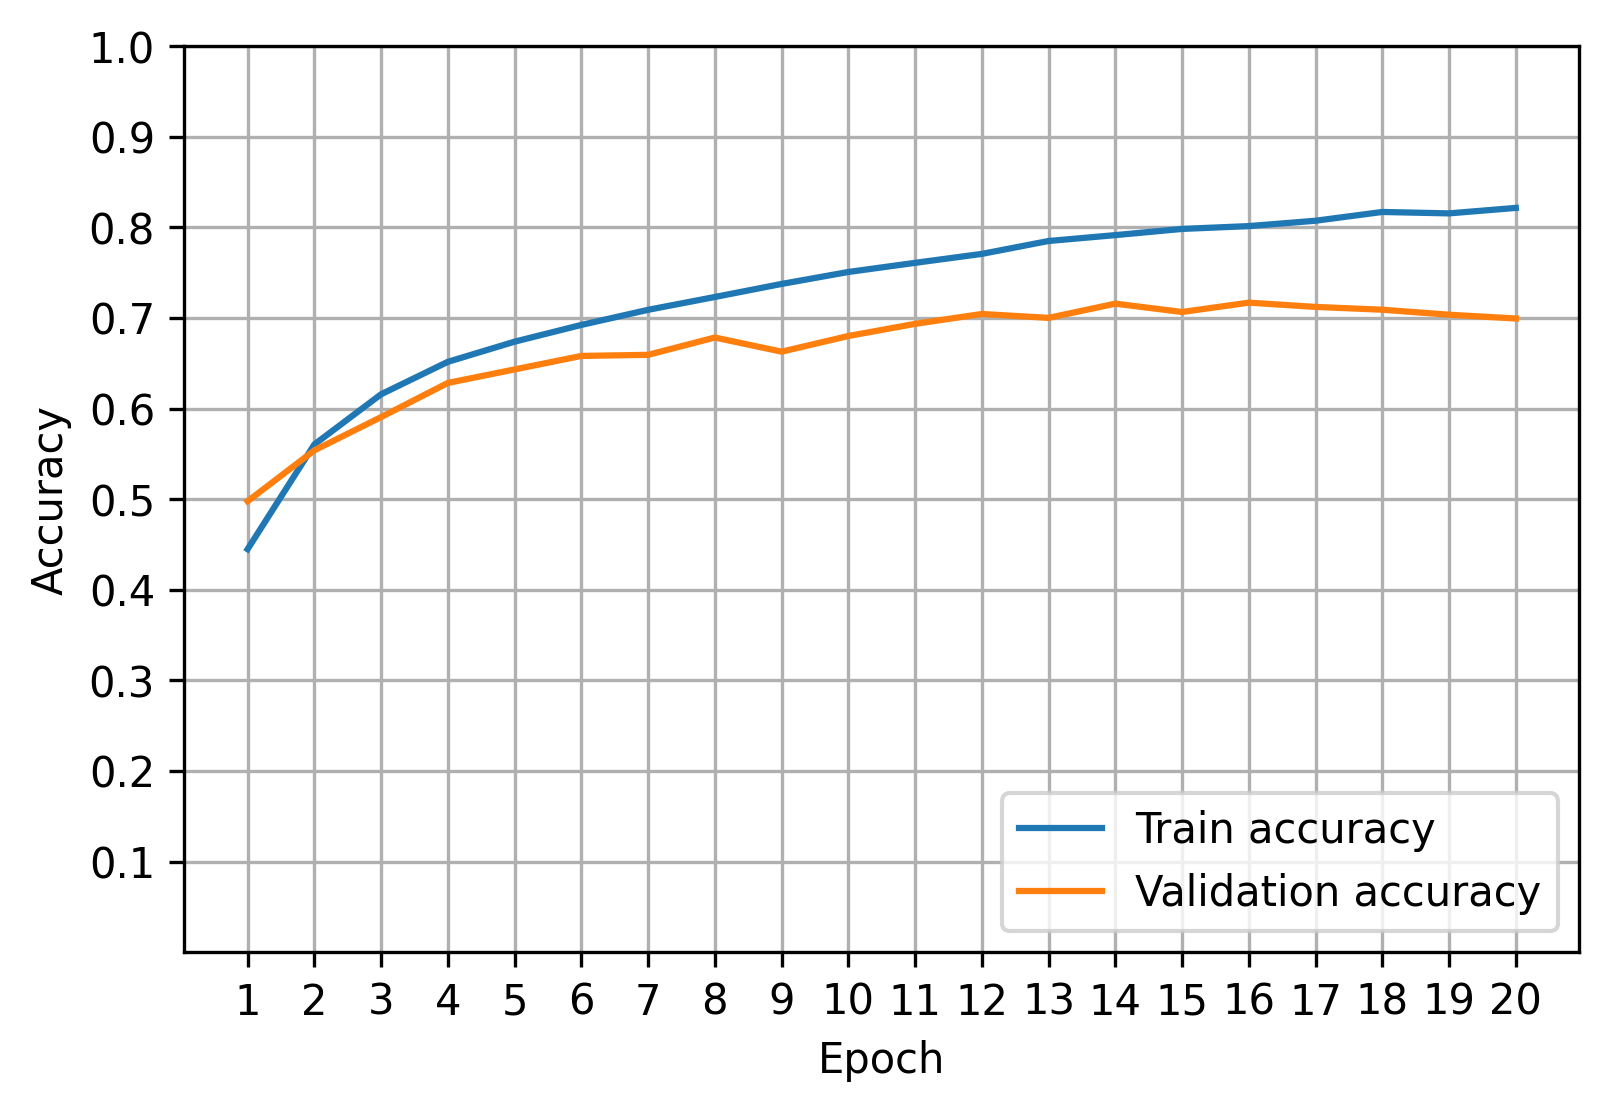

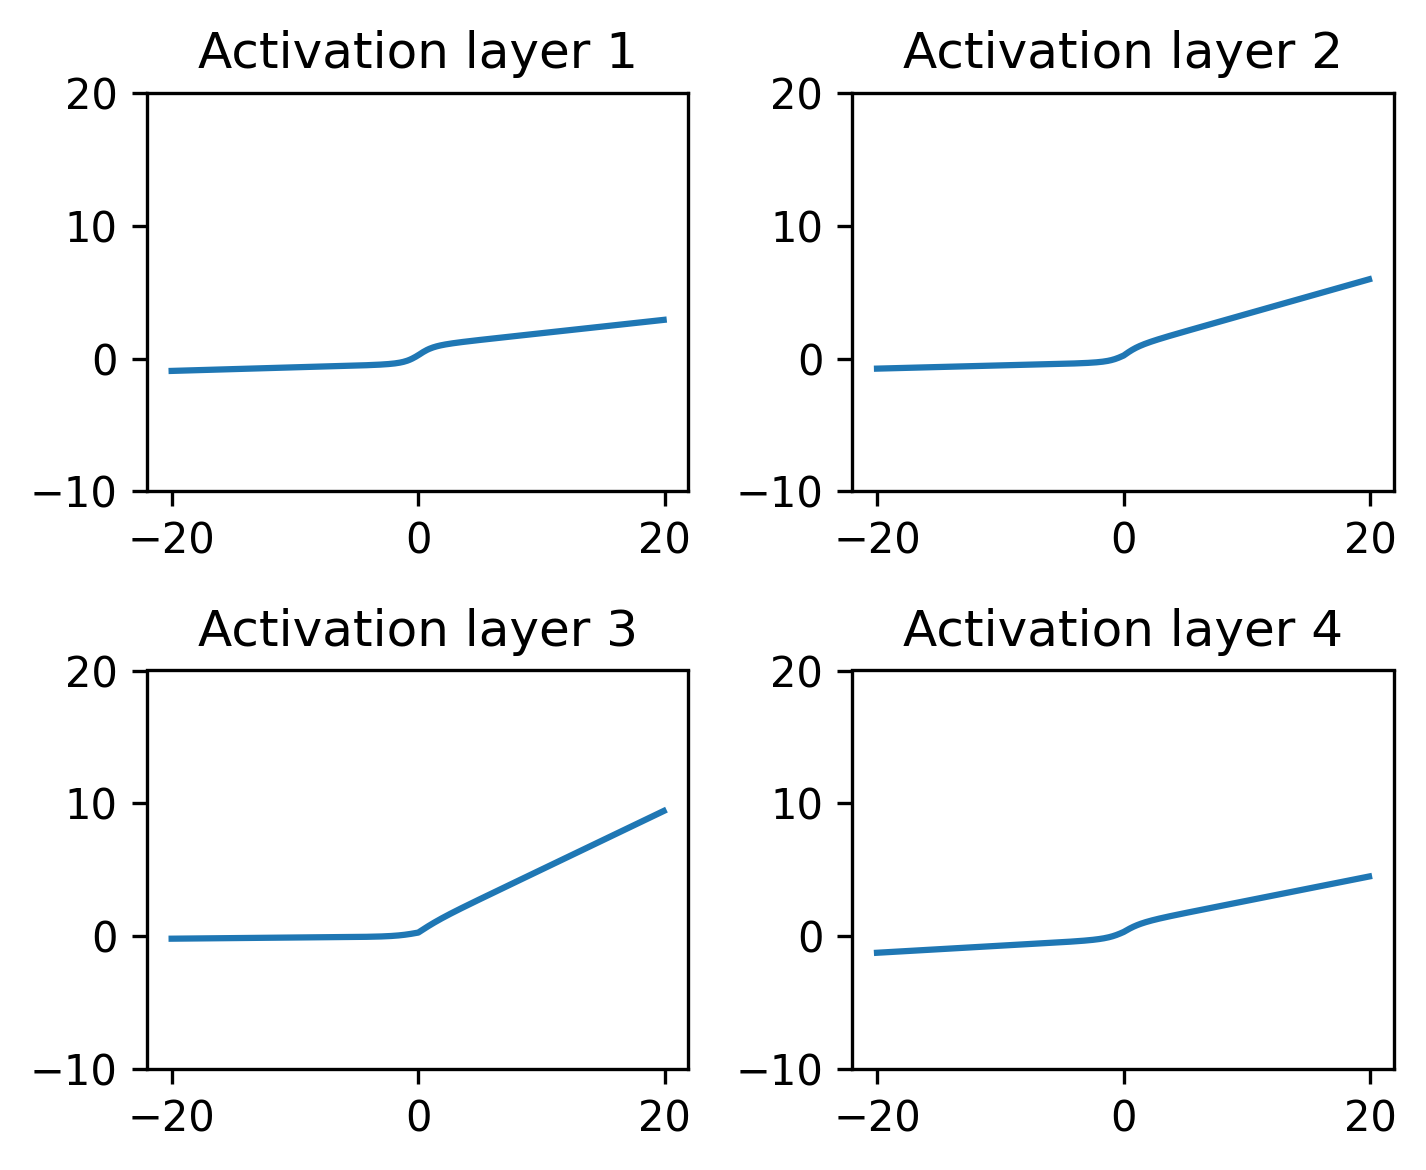

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.44484>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.080252>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.4977>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.56044>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8575696>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5539>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6158>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7299652>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5906>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6516>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6430393>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6283>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.67384>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5766045>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, nump

In [ ]:
model, history, test_acc, test_loss = output_val_layer_05
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7169, 0.6997, 0.7246]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7137 $\pm$ 0.0104
0.7137333333333333 +- 0.01040907723522547


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8214, 0.81132, 0.8156]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8161 $\pm$ 0.0041
0.8161066666666666 +- 0.004130708844200411


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 17s 21ms/step - loss: 1.7696 - accuracy: 0.4223 - val_loss: 1.3727 - val_accuracy: 0.5748
Epoch 2/20
782/782 [==============================] - 16s 20ms/step - loss: 1.3618 - accuracy: 0.5791 - val_loss: 1.1753 - val_accuracy: 0.6448
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 1.2249 - accuracy: 0.6347 - val_loss: 1.1941 - val_accuracy:

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function tanh at 0x7fd6b12e1710>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.7745 - accuracy: 0.3999 - val_loss: 1.4330 - val_accuracy: 0.5343
Epoch 2/20
782/782 [==============================] - 15s 20ms/step - loss: 1.3878 - accuracy: 0.5524 - val_loss: 1.2740 - val_accuracy: 0.6015
Epoch 3/20
782/782 [==============================] - 15s 20ms/step - loss: 1.2522 - accuracy: 0.6129 - val_loss: 1.1675 - val_accuracy:

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7f422ea47290> <function tanh at 0x7f422ea470e0>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f422ea47290> <function tanh at 0x7f422ea470e0>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f422ea47290> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f422ea470e0> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f422ea47290> <function tanh at 0x7f422ea470e0>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.8731 - accuracy: 0.3619 - val_loss: 1.5132 - val_accuracy: 0.4785
Epoch 2/20
782/782 [==============================] - 15s 19ms/step - loss: 1.4615 - accuracy: 0.5141 - val_loss: 1.2991 - val_accuracy: 0.5909
Epoch 3/20
782/782 [==============================] - 15s 19ms/step - loss: 1.3060 - accuracy: 0.5863 - val_loss: 1.1863 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7539, 0.7469, 0.7634]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7547 $\pm$ 0.0068
0.7547333333333333 +- 0.00676182092503358


In [ ]:
print("Train accuracy mean:")
train_accs = [0.7458, 0.7479, 0.7707]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7548 $\pm$ 0.0113
0.7548 +- 0.011275637454263968


In [ ]:
model_3_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
[<function sigmoid at 0x7fec6f805050>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1867 - accuracy: 0.1954 - val_loss: 1.9620 - val_accuracy: 0.2953
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 1.9039 - accuracy: 0.3190 - val_loss: 1.7870 - val_accuracy: 0.3836
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8421 - accuracy: 0.3504 - val_loss: 1.7467 - val_accuracy: 0.3922
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8023 - accuracy: 0.3716 - val_loss: 1.7233 - val_accuracy: 0.4017
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7591 - accuracy: 0.3946 - val_loss: 1.6340 - val_accuracy: 0.4474
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7327 - accuracy: 0.4089 - val_loss: 1.6312 - val_acc

In [ ]:
model_3_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7fcc8f332290>]
[<function sigmoid at 0x7fcc8f332290>]
[<function sigmoid at 0x7fcc8f332290>]
[<function sigmoid at 0x7fcc8f332290>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.2833 - accuracy: 0.1482 - val_loss: 2.0509 - val_accuracy: 0.2299
Epoch 2/20
782/782 [==============================] - 7s 10ms/step - loss: 2.0058 - accuracy: 0.2730 - val_loss: 1.8923 - val_accuracy: 0.3296
Epoch 3/20
782/782 [==============================] - 7s 10ms/step - loss: 1.8811 - accuracy: 0.3364 - val_loss: 1.7893 - val_accuracy: 0.3794
Epoch 4/20
782/782 [==============================] - 7s 10ms/step - loss: 1.8353 - accuracy: 0.3594 - val_loss: 1.7200 - val_accuracy: 0.4205
Epoch 5/20
782/782 [==============================] - 7s 10ms/step - loss: 1.8043 - accuracy: 0.3775 - val_loss: 1.7123 - val_accuracy: 0.4222
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.7779 - accuracy: 0.3916 - val_loss: 1.6866 - val_ac

In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
(X, y), (X_test, y_test) = get_cifar10_data()
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
[<function sigmoid at 0x7f9ff0bfdf80>]
Epoch 1/20
782/782 [==============================] - 13s 13ms/step - loss: 2.2357 - accuracy: 0.1723 - val_loss: 1.9811 - val_accuracy: 0.2694
Epoch 2/20
782/782 [==============================] - 11s 14ms/step - loss: 1.9617 - accuracy: 0.2926 - val_loss: 1.8402 - val_accuracy: 0.3591
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8642 - accuracy: 0.3453 - val_loss: 1.7735 - val_accuracy: 0.3784
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8202 - accuracy: 0.3683 - val_loss: 1.7763 - val_accuracy: 0.3881
Epoch 5/20
782/782 [==============================] - 12s 15ms/step - loss: 1.7788 - accuracy: 0.3885 - val_loss: 1.7158 - val_accuracy: 0.4117
Epoch 6/20
782/782 [==============================] - 10s 13ms/step - loss: 1.7681 - accuracy: 0.3935 - val_loss: 1.6989 - val

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4822, 0.5101, 0.5337]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.5087 $\pm$ 0.0210
0.5086666666666666 +- 0.021049201621175274


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4392, 0.4561, 0.4898]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.4617 $\pm$ 0.0210
0.4617 +- 0.02103346539842323


#### Opt = 0.2

In [ ]:
output_val_layer = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-2-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer[1]))

Training model
Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5797
Training accuracy for epoch: 0.482925
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-2-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6229
Training accuracy for epoch: 0.60365
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-2-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6505
Training accuracy for epoch: 0.6469
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-2-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6639
Training accuracy for epoch: 0.678525
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-2-04.hdf5

Epoch 5
Step / 625: 

In [ ]:
output_val_layer = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-3-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)
print(get_max_accuracy(output_val_layer[1]))

Training model
Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5463
Training accuracy for epoch: 0.492425
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-3-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6117
Training accuracy for epoch: 0.6138
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-3-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6452
Training accuracy for epoch: 0.653375
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-3-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6503
Training accuracy for epoch: 0.67925
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-basic-3-04.hdf5

Epoch 5
Step / 625: 

In [ ]:
output_val_layer = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-basic-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.819775, 'val_accuracy': 0.7566}


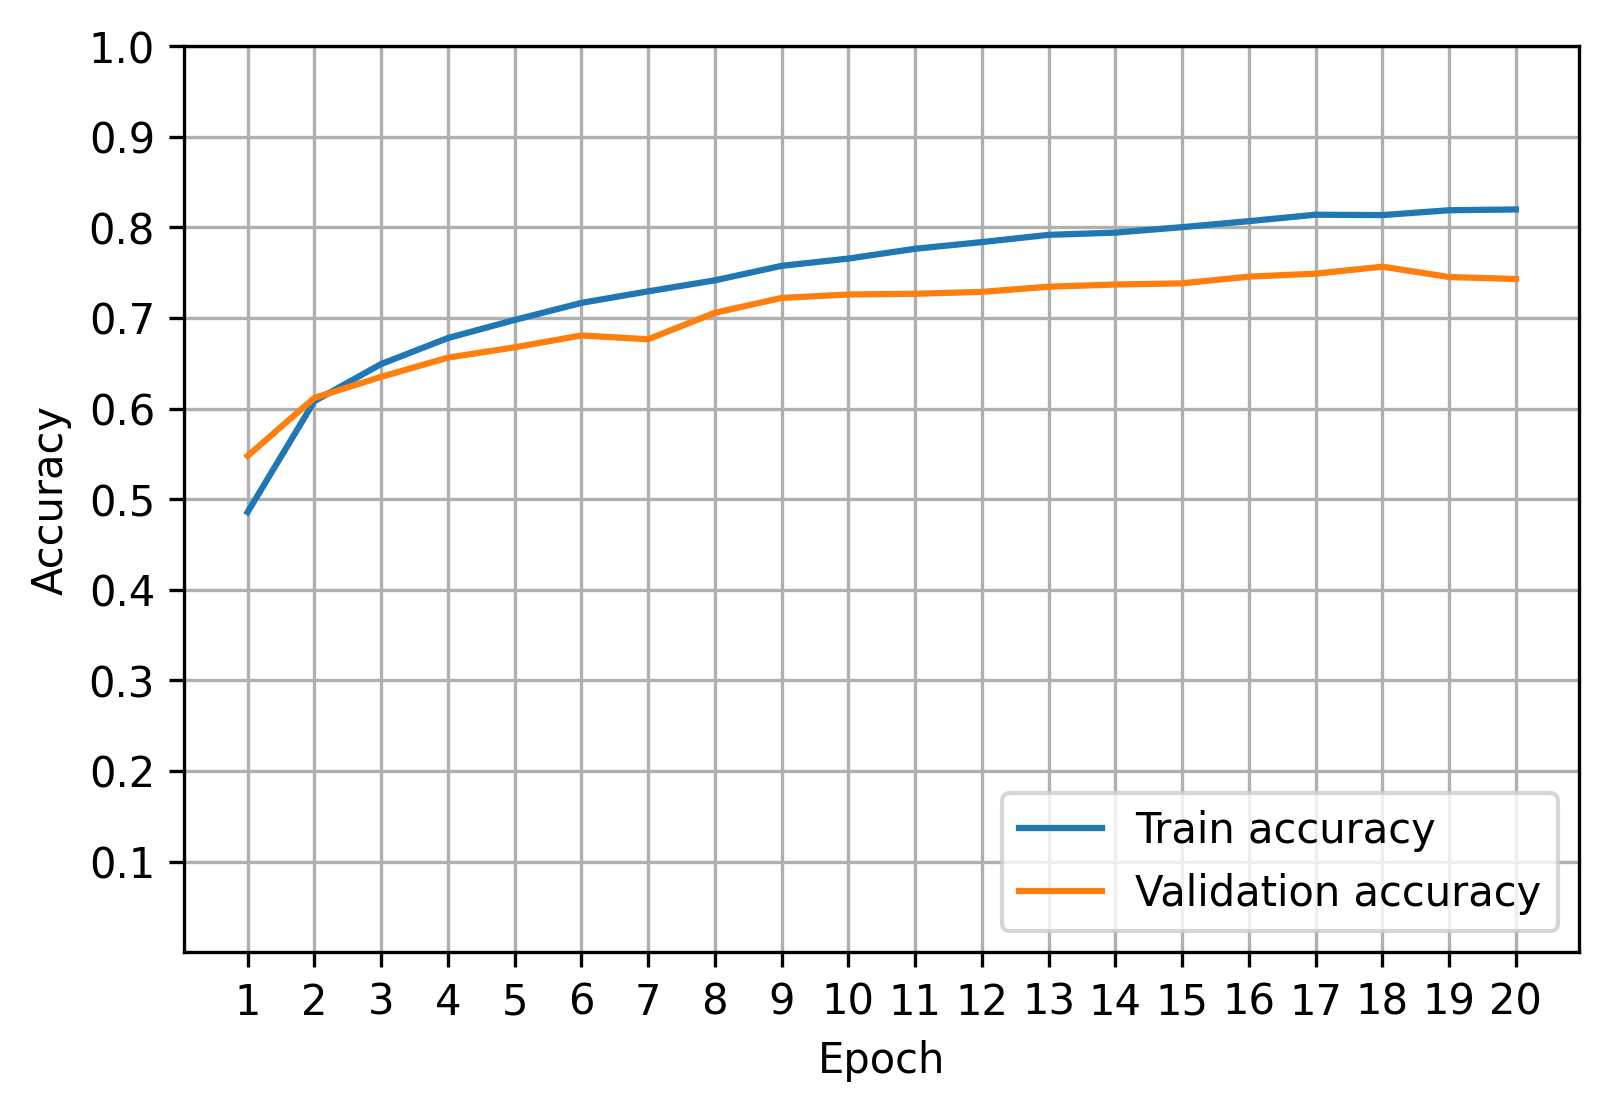

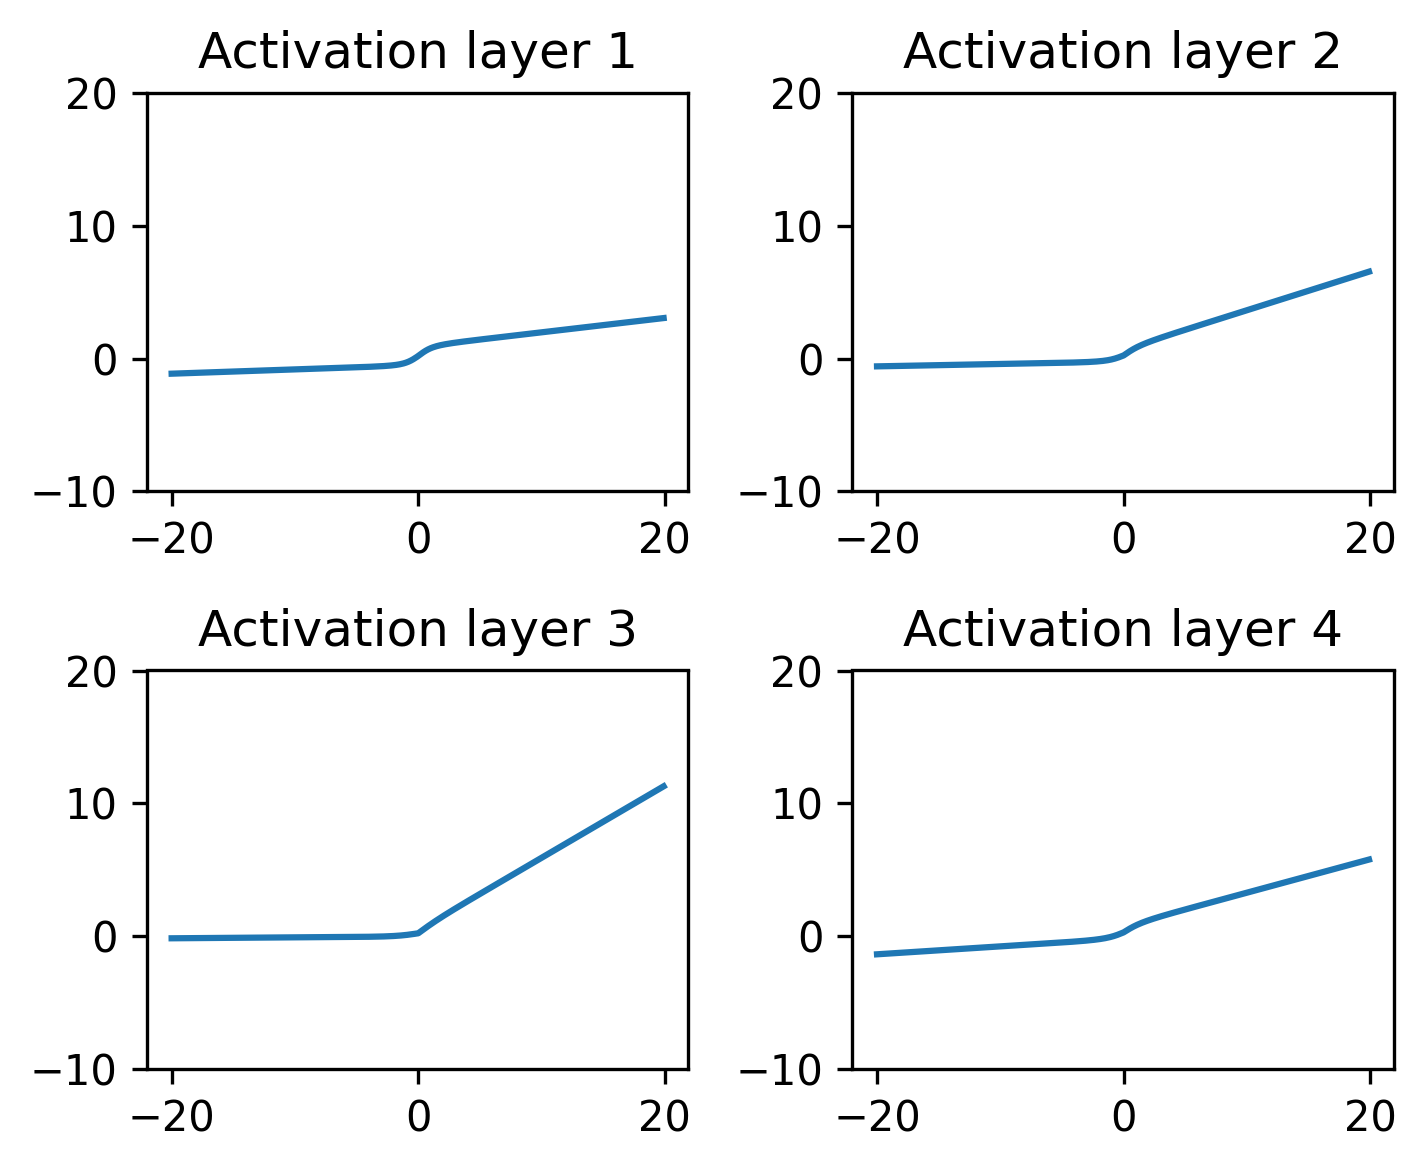

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.4857>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.9516697>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5477>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.608175>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7221178>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6118>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.64915>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5993263>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.635>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6778>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5162345>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6562>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6978>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4548142>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, nump

In [ ]:
model, history, test_acc, test_loss = output_val_layer
print(get_max_accuracy(history))
plot_performance(history)
plot_activation_functions_bars([model], width=5.5, height=1, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history)

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7566, 0.7521, 0.7495]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7527 $\pm$ 0.0029
0.7527333333333335 +- 0.0029329545209945272


In [ ]:
print("Train accuracy mean:")
train_accs = [0.8197, 0.8207, 0.8209]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.8204 $\pm$ 0.0005
0.8204333333333333 +- 0.000524933858267448


In [ ]:
model_2_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710> <function sigmoid at 0x7fd6b0b84f80>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function relu at 0x7fd674997a70> <function sigmoid at 0x7fd6b0b84f80>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.7899 - accuracy: 0.4133 - val_loss: 1.4224 - val_accuracy: 0.5375
Epoch 2/20
782/782 [==============================] - 15s 20ms/step - loss: 1.4048 - accuracy: 0.5616 - val_loss: 1.2234 - val_accuracy: 0.6262
Epoch 3/20
782/782 [==============================] - 16s 20ms/step - loss: 1.2549 - accuracy: 0.6215 - val_loss: 1.2109 - val_accuracy:

In [ ]:
model_2_3 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710> <function sigmoid at 0x7fd6b0b84f80>
 <function relu at 0x7fd674997a70> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function relu at 0x7fd674997a70> <function sigmoid at 0x7fd6b0b84f80>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
[<function sigmoid at 0x7fd6b0b84f80> <function relu at 0x7fd674997a70>
 <function tanh at 0x7fd6b12e1710> <function linear at 0x7fd67499b4d0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.8350 - accuracy: 0.3718 - val_loss: 1.4275 - val_accuracy: 0.5288
Epoch 2/20
782/782 [==============================] - 15s 20ms/step - loss: 1.4059 - accuracy: 0.5470 - val_loss: 1.2438 - val_accuracy: 0.6106
Epoch 3/20
782/782 [==============================] - 15s 20ms/step - loss: 1.2685 - accuracy: 0.6091 - val_loss: 1.1405 - val_accuracy:

In [ ]:
model_2 = disable_activation_layer_training(prune_model(model, n_act_functions='all', reset_weights_except_act=True))
(X, y), (X_test, y_test) = get_cifar10_data()
model_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0> <function sigmoid at 0x7f426ab6d680>
 <function relu at 0x7f422ea45d40> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f426b33cdd0> <function linear at 0x7f422ea477a0>]
[<function relu at 0x7f422ea45d40> <function sigmoid at 0x7f426ab6d680>
 <function tanh at 0x7f426b33cdd0> <function linear at 0x7f422ea477a0>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>
 <function tanh at 0x7f426b33cdd0> <function linear at 0x7f422ea477a0>]
Epoch 1/20
782/782 [==============================] - 17s 20ms/step - loss: 1.7584 - accuracy: 0.4333 - val_loss: 1.3926 - val_accuracy: 0.5669
Epoch 2/20
782/782 [==============================] - 15s 19ms/step - loss: 1.3527 - accuracy: 0.5824 - val_loss: 1.1605 - val_accuracy: 0.6532
Epoch 3/20
782/782 [==============================] - 15s 19ms/step - loss: 1.2143 - accuracy: 0.6378 - val_loss: 1.1069 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.7584, 0.7484, 0.7607]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.7558 $\pm$ 0.0053
0.7558333333333334 +- 0.005339371581833315


In [ ]:
print("Train accuracy mean:")
train_accs = [0.7724, 0.7511, 0.7655]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.7630 $\pm$ 0.0089
0.7629999999999999 +- 0.008873556220591598


In [ ]:
model_3 = disable_activation_layer_training(prune_model(model, n_act_functions=2, reset_weights_except_act=True))
model_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0> <function sigmoid at 0x7f426ab6d680>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>]
[<function relu at 0x7f422ea45d40> <function sigmoid at 0x7f426ab6d680>]
[<function sigmoid at 0x7f426ab6d680> <function relu at 0x7f422ea45d40>]
Epoch 1/20
782/782 [==============================] - 14s 16ms/step - loss: 2.1873 - accuracy: 0.2013 - val_loss: 2.0495 - val_accuracy: 0.2733
Epoch 2/20
782/782 [==============================] - 12s 15ms/step - loss: 1.9461 - accuracy: 0.2962 - val_loss: 1.7568 - val_accuracy: 0.3803
Epoch 3/20
782/782 [==============================] - 12s 15ms/step - loss: 1.7992 - accuracy: 0.3581 - val_loss: 1.7228 - val_accuracy: 0.3993
Epoch 4/20
782/782 [==============================] - 12s 15ms/step - loss: 1.7471 - accuracy: 0.3834 - val_loss: 1.7281 - val_accuracy: 0.3831
Epoch 5/20
782/782 [==============================] - 12s 15ms/step - loss: 1.6945 - accuracy: 0.4050 - val_loss: 1.6055 - val_accur

In [ ]:
model_4_2 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_2.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710>]
[<function sigmoid at 0x7fd6b0b84f80>]
[<function relu at 0x7fd674997a70>]
[<function sigmoid at 0x7fd6b0b84f80>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.3290 - accuracy: 0.1016 - val_loss: 2.3064 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 9s 11ms/step - loss: 2.3058 - accuracy: 0.1008 - val_loss: 2.3047 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 9s 11ms/step - loss: 2.2887 - accuracy: 0.1170 - val_loss: 2.1836 - val_accuracy: 0.2049
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1246 - accuracy: 0.2204 - val_loss: 2.0134 - val_accuracy: 0.2677
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 1.9777 - accuracy: 0.2843 - val_loss: 1.8559 - val_accuracy: 0.3524
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.8706 - accuracy: 0.3350 - val_loss: 1.7990 - val_accuracy

In [ ]:
model_4_3 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4_3.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7fd6b12e1710>]
[<function sigmoid at 0x7fd6b0b84f80>]
[<function relu at 0x7fd674997a70>]
[<function sigmoid at 0x7fd6b0b84f80>]
Epoch 1/20
782/782 [==============================] - 10s 11ms/step - loss: 2.3364 - accuracy: 0.1047 - val_loss: 2.3149 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 9s 11ms/step - loss: 2.1652 - accuracy: 0.1949 - val_loss: 2.0742 - val_accuracy: 0.2451
Epoch 3/20
782/782 [==============================] - 9s 11ms/step - loss: 2.0771 - accuracy: 0.2381 - val_loss: 2.0221 - val_accuracy: 0.2648
Epoch 4/20
782/782 [==============================] - 9s 12ms/step - loss: 2.0442 - accuracy: 0.2519 - val_loss: 2.0249 - val_accuracy: 0.2683
Epoch 5/20
782/782 [==============================] - 9s 11ms/step - loss: 1.9664 - accuracy: 0.2915 - val_loss: 1.8990 - val_accuracy: 0.3132
Epoch 6/20
782/782 [==============================] - 8s 11ms/step - loss: 1.8768 - accuracy: 0.3337 - val_loss: 1.7539 - val_accuracy

In [ ]:
model_4 = disable_activation_layer_training(prune_model(model, n_act_functions=1, reset_weights=True, reset_weights_except_act=False))
model_4.fit(X, y, validation_data=(X_test, y_test), batch_size=64, epochs=20)

[<function tanh at 0x7f426b33cdd0>]
[<function sigmoid at 0x7f426ab6d680>]
[<function relu at 0x7f422ea45d40>]
[<function sigmoid at 0x7f426ab6d680>]
Epoch 1/20
782/782 [==============================] - 9s 11ms/step - loss: 2.3359 - accuracy: 0.1003 - val_loss: 2.3061 - val_accuracy: 0.0997
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 2.3064 - accuracy: 0.0983 - val_loss: 2.3049 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 2.3052 - accuracy: 0.0976 - val_loss: 2.3059 - val_accuracy: 0.1006
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 2.2544 - accuracy: 0.1362 - val_loss: 2.0939 - val_accuracy: 0.2256
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 2.0431 - accuracy: 0.2429 - val_loss: 1.9539 - val_accuracy: 0.2933
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 1.9636 - accuracy: 0.2832 - val_loss: 1.8720 - val_accuracy:

In [ ]:
print("Test accuracy mean:")
test_accs = [0.4591, 0.5301, 0.4482]
print(f"{np.mean(test_accs):.4f} $\pm$ {np.std(test_accs):.4f}")
print(np.mean(test_accs), "+-", np.std(test_accs))

Test accuracy mean:
0.4791 $\pm$ 0.0363
0.47913333333333336 +- 0.03631256287047532


In [ ]:
print("Train accuracy mean:")
train_accs = [0.4210, 0.4726, 0.4126]
print(f"{np.mean(train_accs):.4f} $\pm$ {np.std(train_accs):.4f}")
print(np.mean(train_accs), "+-", np.std(train_accs))

Train accuracy mean:
0.4354 $\pm$ 0.0265
0.4354 +- 0.02652696741054281


### Test - kernel

In [ ]:
output_val_kernel = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-kernel-basic-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Reading model from file


{'accuracy': 0.791025, 'val_accuracy': 0.7204}


[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.485275>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.953397>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5346>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.597925>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7333897>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.56>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6404>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.617242>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.61>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.66305>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5401295>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6522>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.683025>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4821694>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy

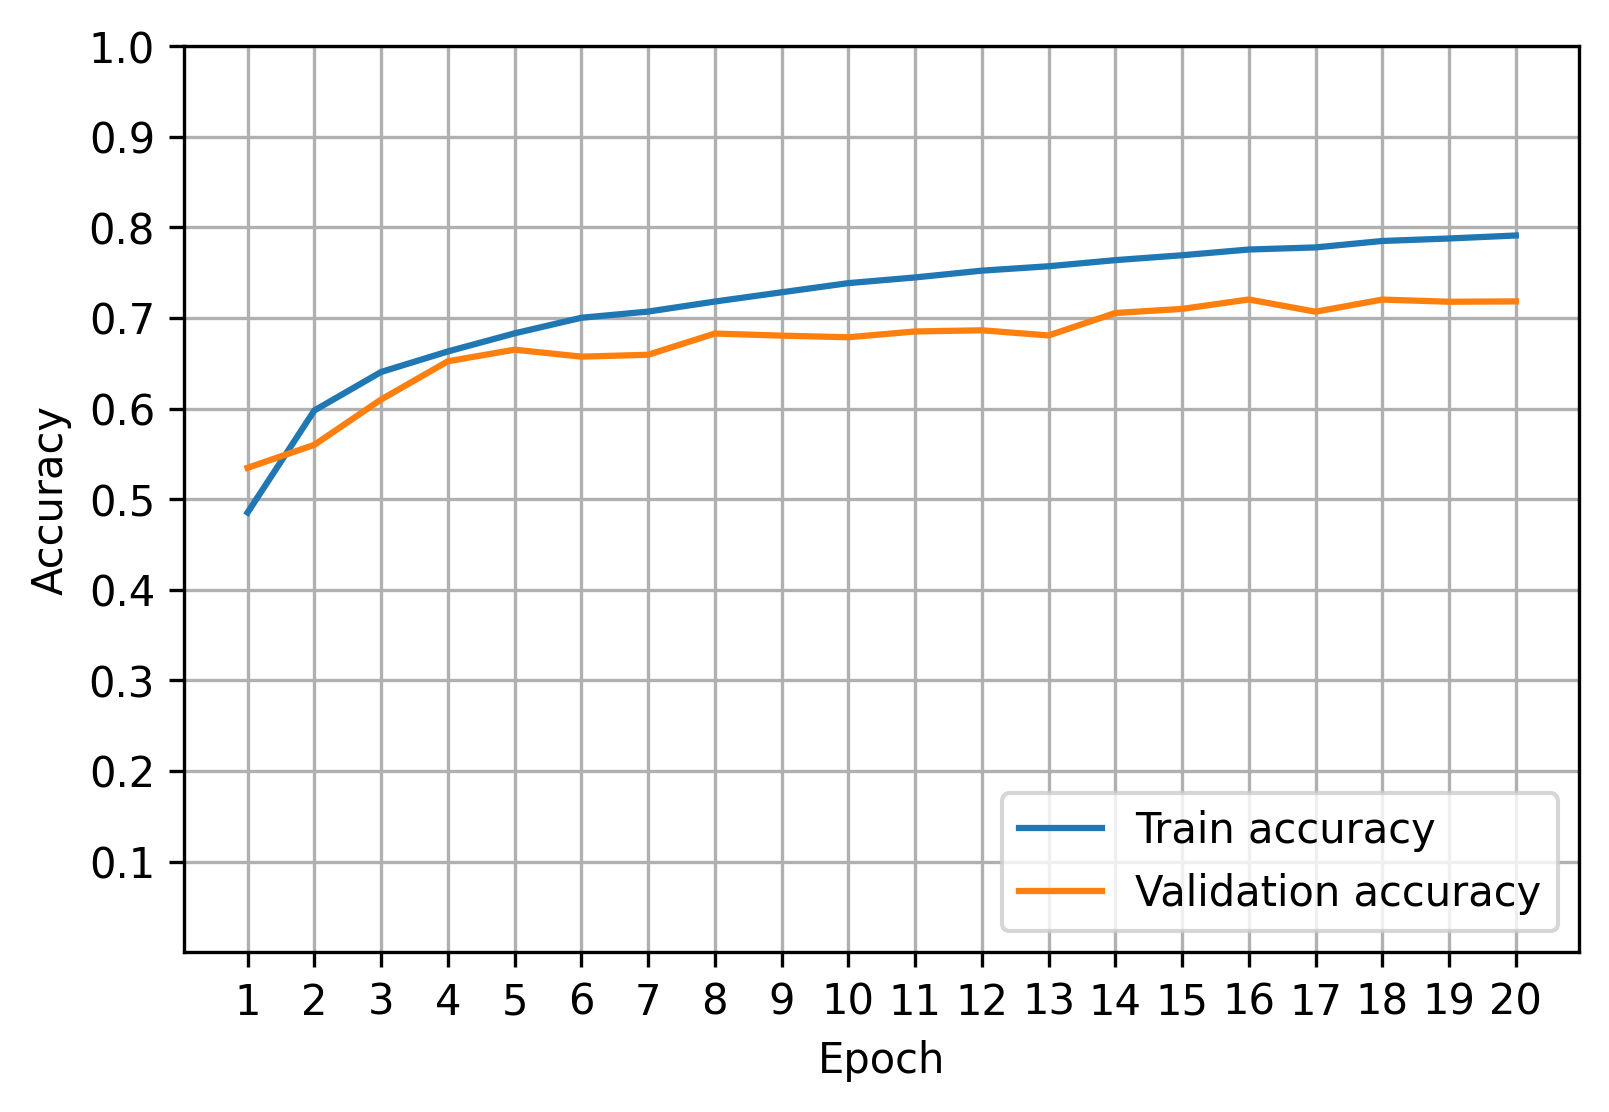

In [ ]:
model, history, test_acc, test_loss = output_val_kernel
print(get_max_accuracy(history))
plot_performance(history)
display(history)

### Test - neuron

In [ ]:
output_val_neuron = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-neuron-basic-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Reading model from file


In [ ]:
model, history, test_acc, test_loss = output_val_neuron
print(get_max_accuracy(history))
plot_performance(history)
display(history)

{'accuracy': 0.7656, 'val_accuracy': 0.7031}


[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.47145>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.0166178>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5563>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.59815>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7712414>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5813>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.64195>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6425967>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6193>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6644>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5585029>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6325>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.67745>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4989076>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, nu

## Tests - train data normal - 20 epochs

### Test - layer

In [ ]:
output_train_layer_normal = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-normal-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 24s 74ms/step - loss: 0.9383 - accuracy: 0.7576


0.7576000094413757


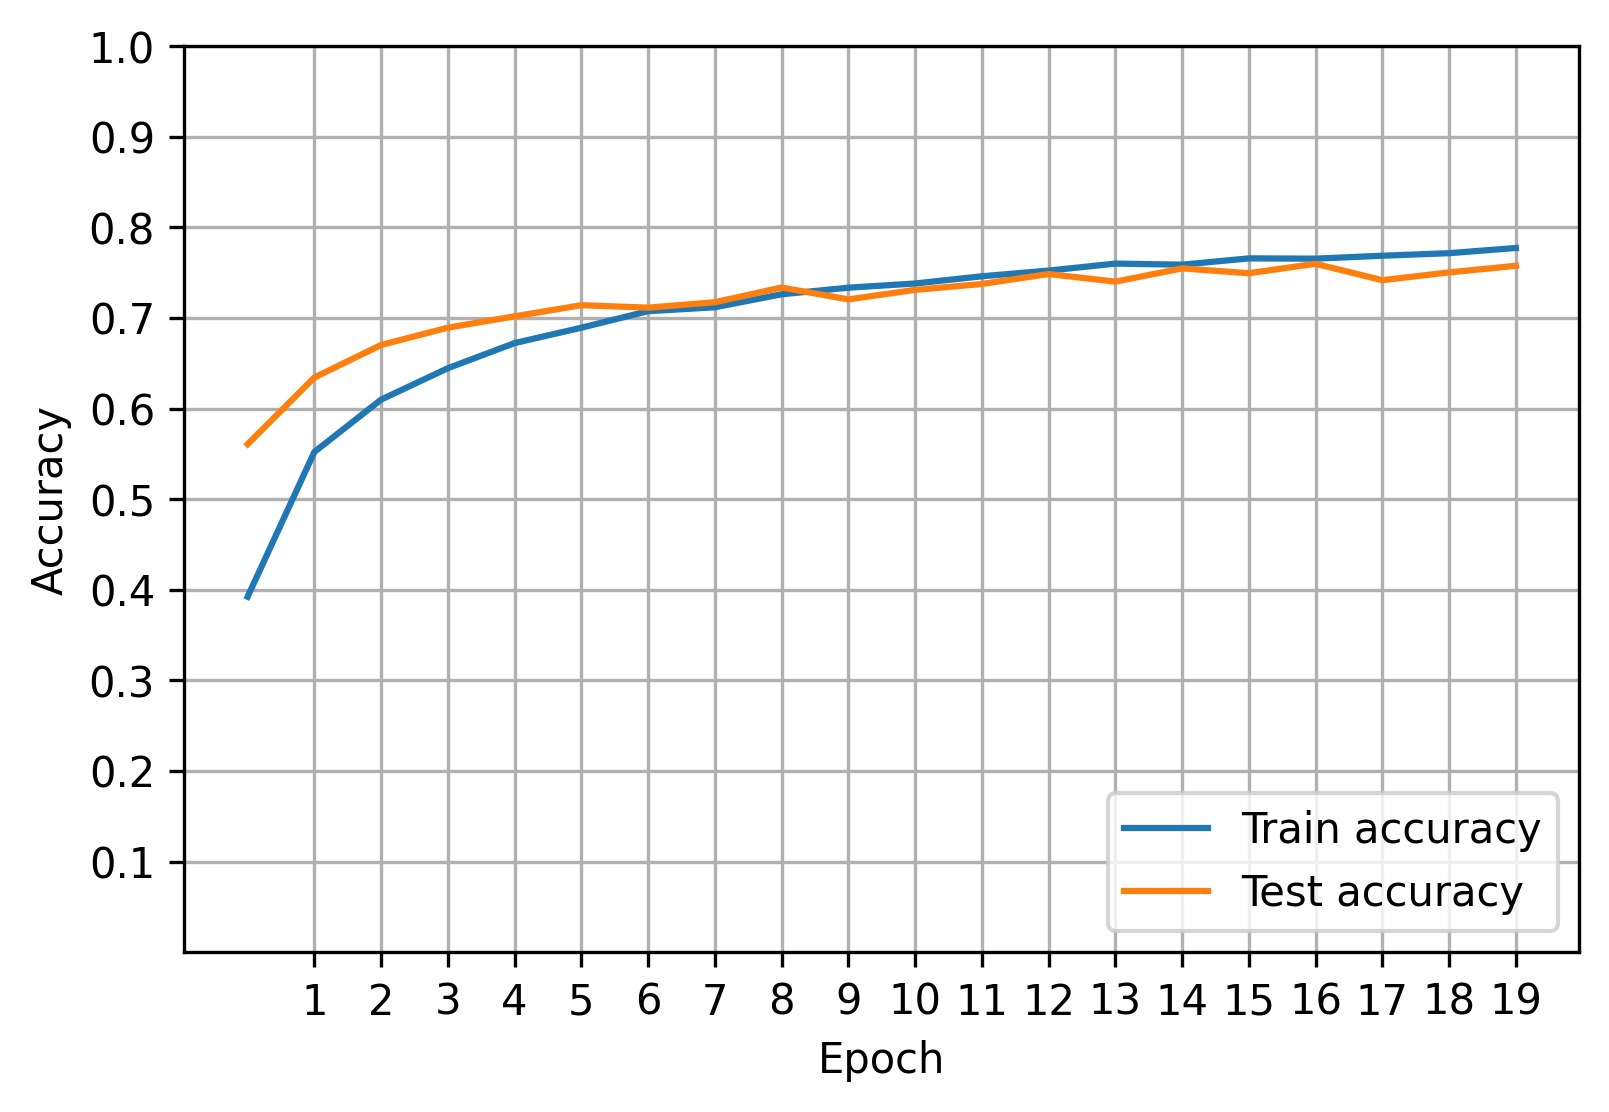

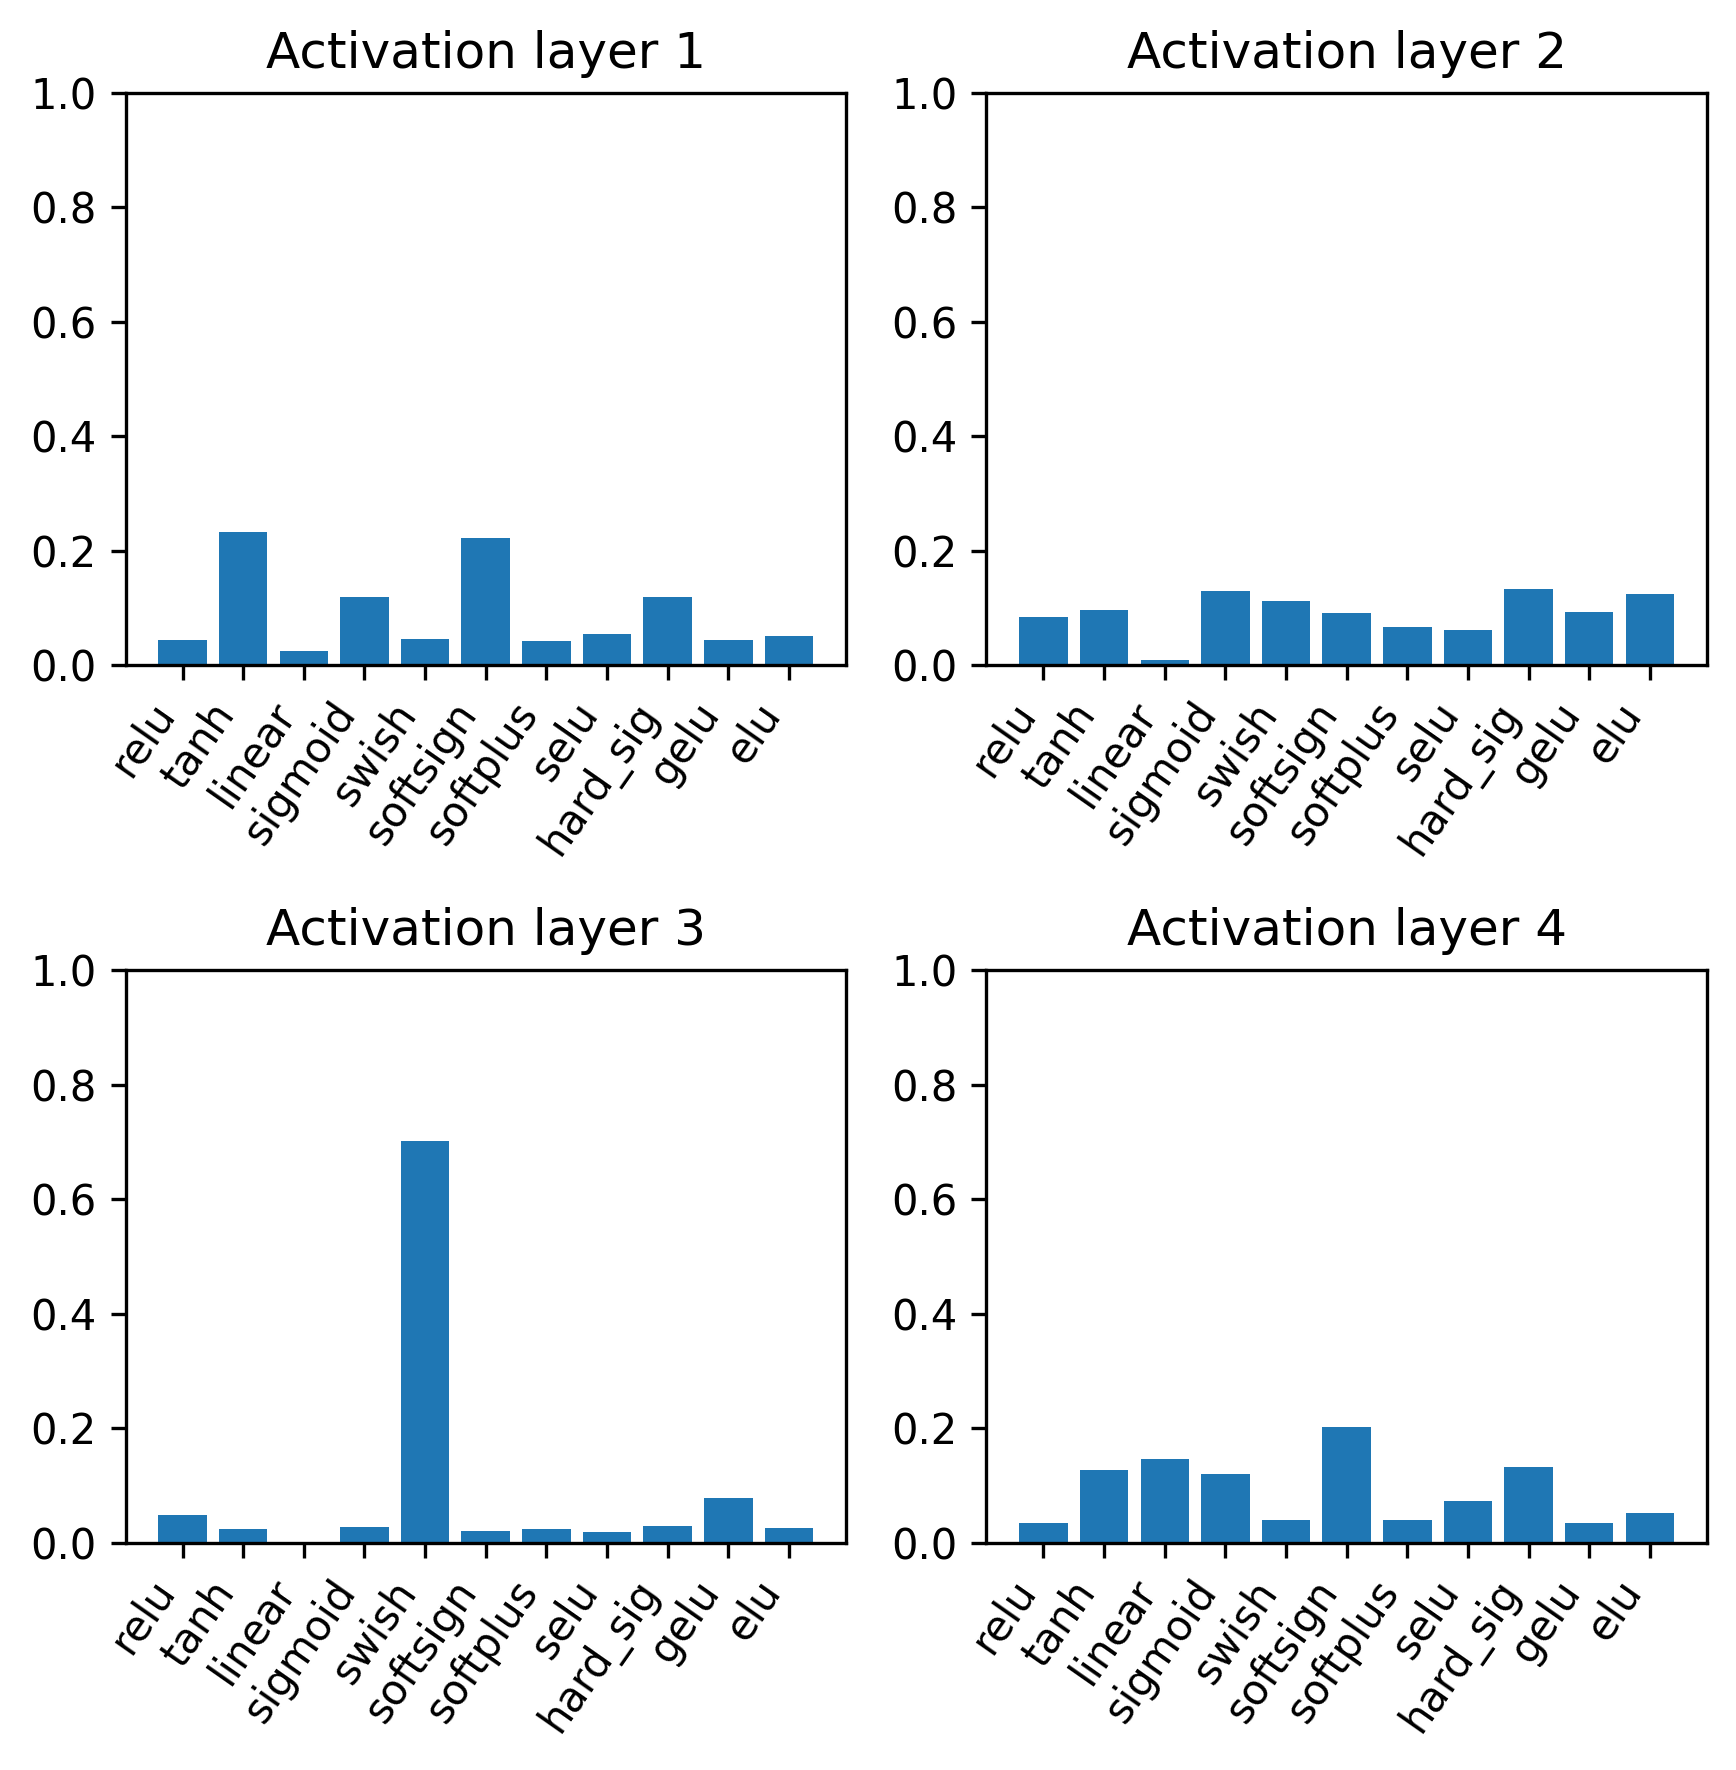

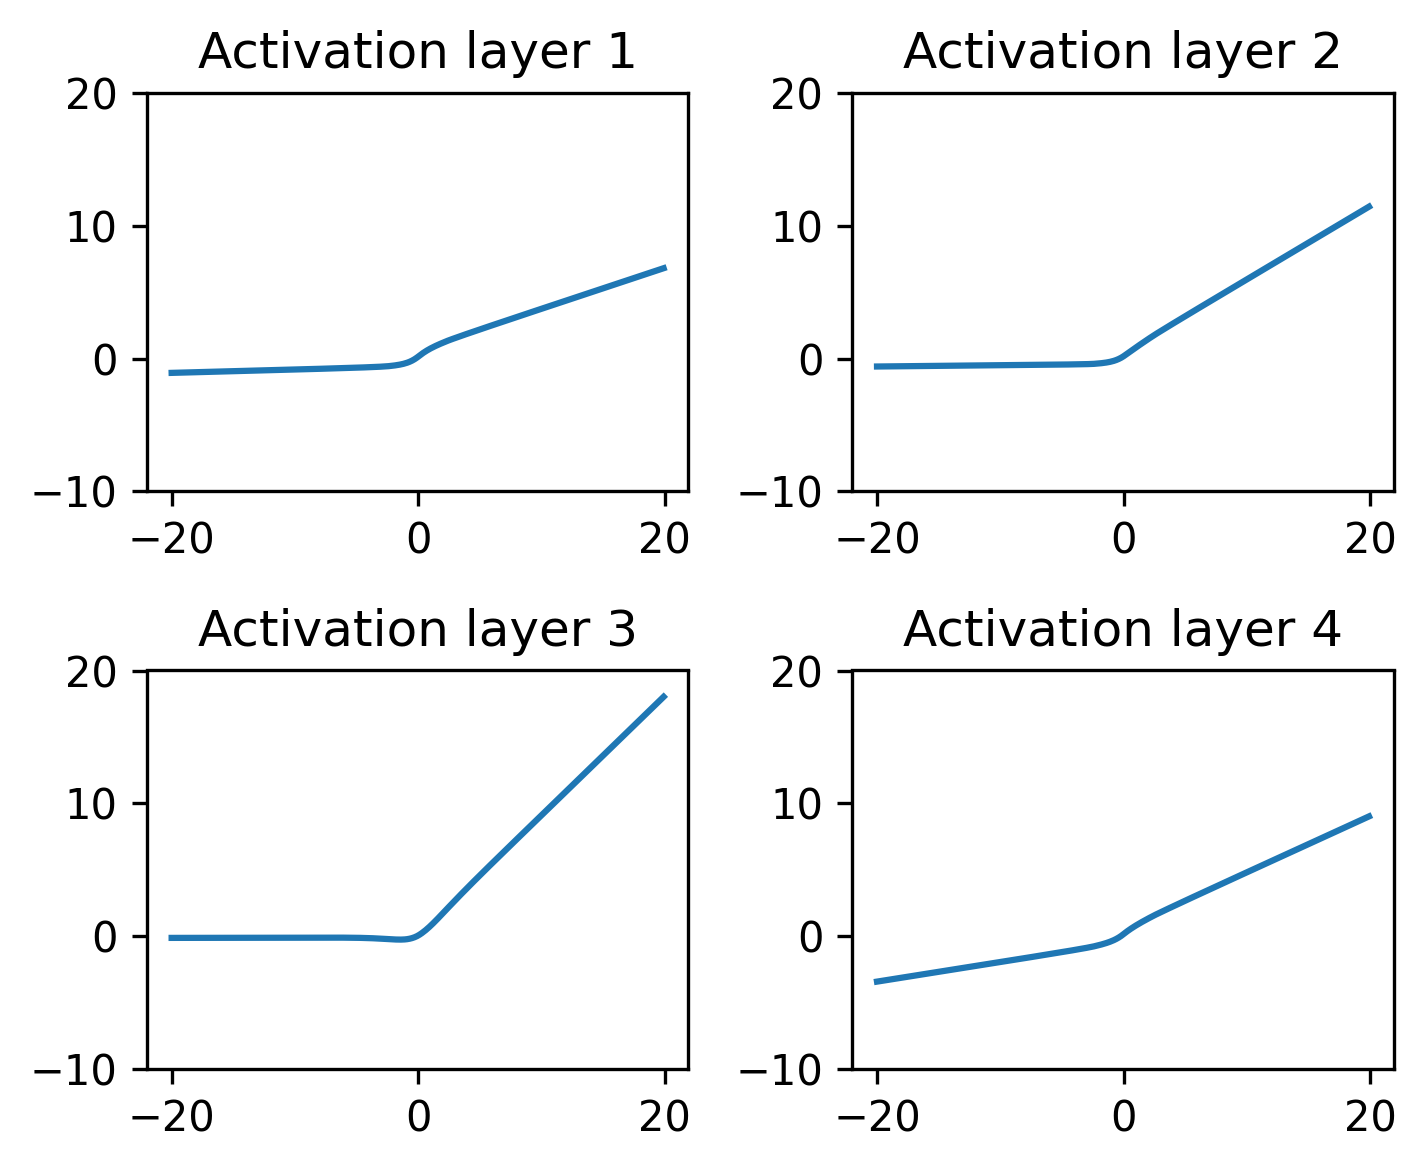

{'accuracy': [0.39232000708580017,
  0.5521399974822998,
  0.6098999977111816,
  0.6445599794387817,
  0.6722800135612488,
  0.6892600059509277,
  0.7074999809265137,
  0.7117999792098999,
  0.726140022277832,
  0.7334200143814087,
  0.7380399703979492,
  0.7459999918937683,
  0.7522799968719482,
  0.7599999904632568,
  0.7588199973106384,
  0.7657600045204163,
  0.7654799818992615,
  0.7687000036239624,
  0.7714999914169312,
  0.7772600054740906],
 'loss': [1.9500560760498047,
  1.4548256397247314,
  1.2836536169052124,
  1.1814357042312622,
  1.121077060699463,
  1.07489013671875,
  1.0379588603973389,
  1.0267843008041382,
  0.9946967959403992,
  0.9859466552734375,
  0.9739161133766174,
  0.9573003053665161,
  0.9426814913749695,
  0.927690327167511,
  0.9284663200378418,
  0.9191175103187561,
  0.9141002893447876,
  0.9072416424751282,
  0.8955472707748413,
  0.8911361694335938],
 'val_accuracy': [0.560699999332428,
  0.6342999935150146,
  0.670199990272522,
  0.689300000667572,
 

In [ ]:
model, history, test_acc, test_loss = output_train_layer_normal
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=6, height=1.5, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history.history)

### Test - kernel



In [ ]:
output_train_kernel_normal = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-normal-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 43s 136ms/step - loss: 0.9299 - accuracy: 0.7618


0.7617999911308289


{'accuracy': [0.39590001106262207,
  0.5587400197982788,
  0.6147000193595886,
  0.6465200185775757,
  0.6713399887084961,
  0.690339982509613,
  0.7028599977493286,
  0.7103999853134155,
  0.7188799977302551,
  0.7283599972724915,
  0.7396000027656555,
  0.7422000169754028,
  0.7481600046157837,
  0.7528799772262573,
  0.7561399936676025,
  0.7601400017738342,
  0.762660026550293,
  0.767520010471344,
  0.7695000171661377,
  0.7708600163459778],
 'loss': [1.954384684562683,
  1.4448542594909668,
  1.2759639024734497,
  1.1913437843322754,
  1.1172325611114502,
  1.0799896717071533,
  1.0455968379974365,
  1.0232810974121094,
  1.006850242614746,
  0.9887815117835999,
  0.9732749462127686,
  0.9685789942741394,
  0.9499795436859131,
  0.9423948526382446,
  0.9327389597892761,
  0.9240553379058838,
  0.919300377368927,
  0.9082484245300293,
  0.9035823941230774,
  0.9050320386886597],
 'val_accuracy': [0.5586000084877014,
  0.6349999904632568,
  0.6650000214576721,
  0.6873000264167786,

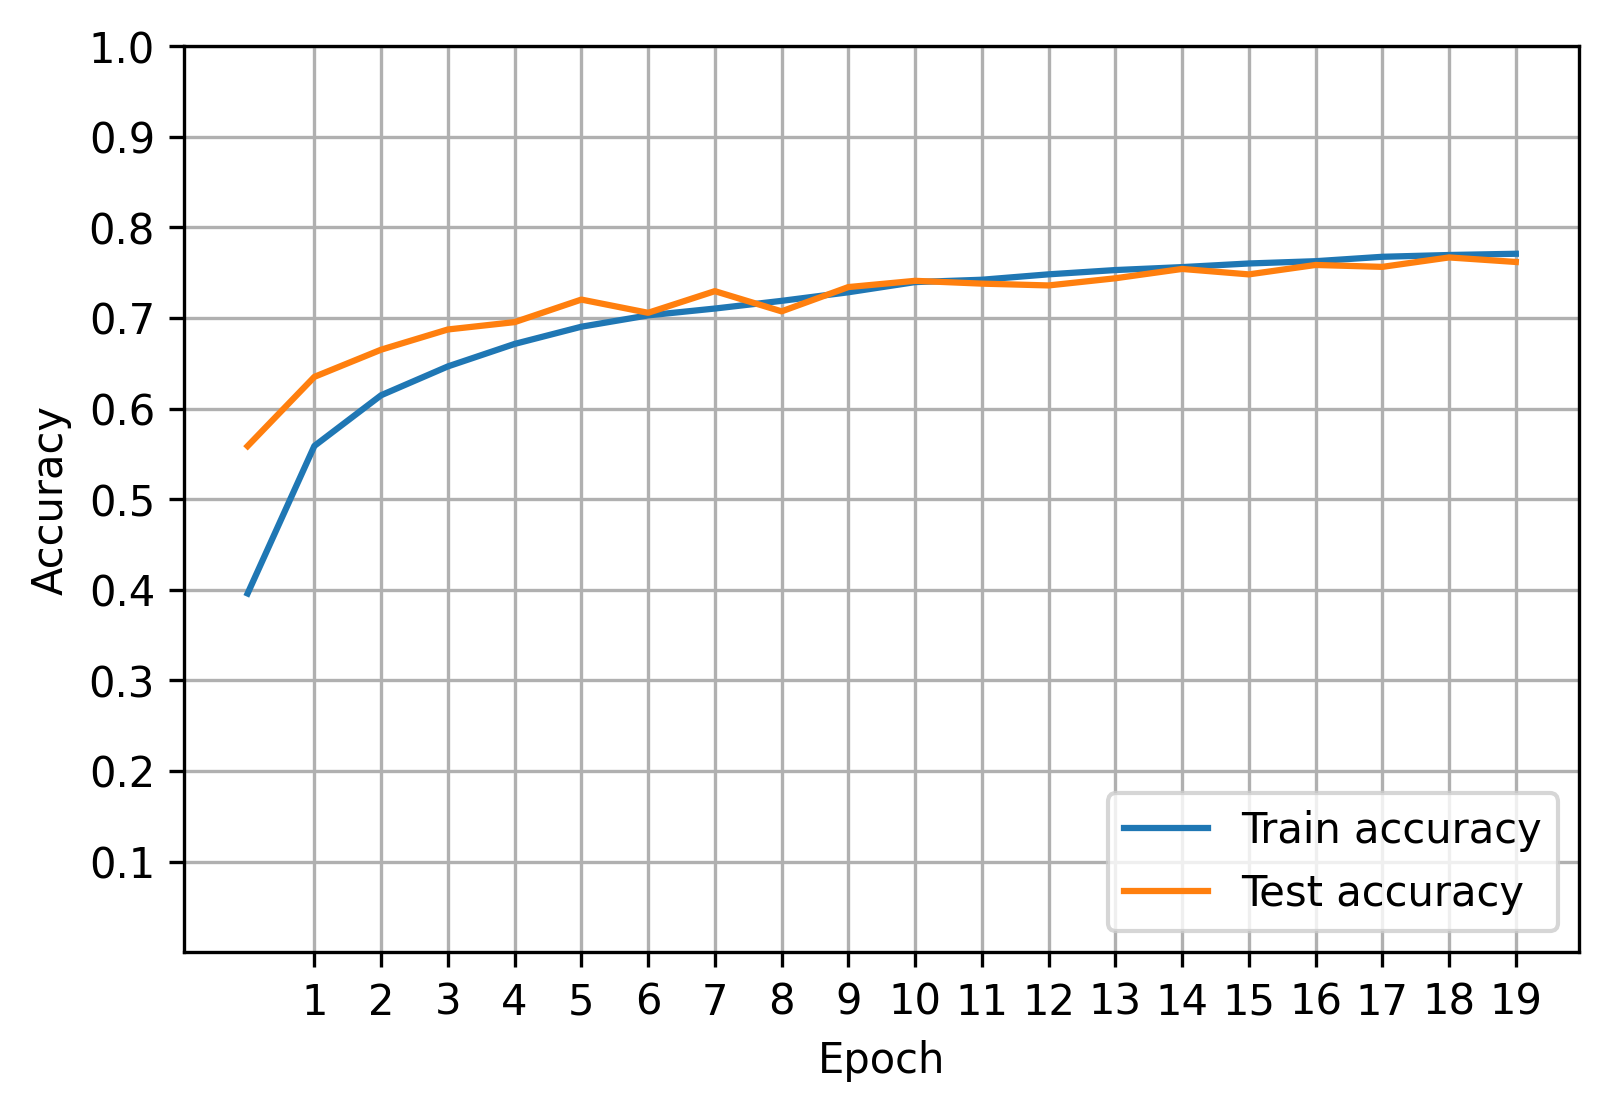

In [ ]:
model, history, test_acc, test_loss = output_train_kernel_normal
print(test_acc)
plot_performance(history)
display(history.history)

### Test - neuron



In [ ]:
output_train_neuron_normal = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-normal-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 38s 118ms/step - loss: 0.9320 - accuracy: 0.7564


0.7563999891281128


{'accuracy': [0.39625999331474304,
  0.5543000102043152,
  0.6139799952507019,
  0.6419399976730347,
  0.6698399782180786,
  0.6802999973297119,
  0.6959400177001953,
  0.708079993724823,
  0.7200199961662292,
  0.7269200086593628,
  0.7343199849128723,
  0.7420600056648254,
  0.7488800287246704,
  0.7560799717903137,
  0.7601799964904785,
  0.7642800211906433,
  0.7666800022125244,
  0.7722399830818176,
  0.7741600275039673,
  0.7768200039863586],
 'loss': [1.9362366199493408,
  1.455072045326233,
  1.2769161462783813,
  1.1979361772537231,
  1.1285436153411865,
  1.098238229751587,
  1.06144118309021,
  1.0309019088745117,
  0.999759316444397,
  0.9893171191215515,
  0.9739088416099548,
  0.9521623253822327,
  0.9394143223762512,
  0.9262540340423584,
  0.9165894389152527,
  0.9063330292701721,
  0.9013651013374329,
  0.8826605677604675,
  0.8827086687088013,
  0.8767861723899841],
 'val_accuracy': [0.5406000018119812,
  0.6370000243186951,
  0.6571000218391418,
  0.6747999787330627,

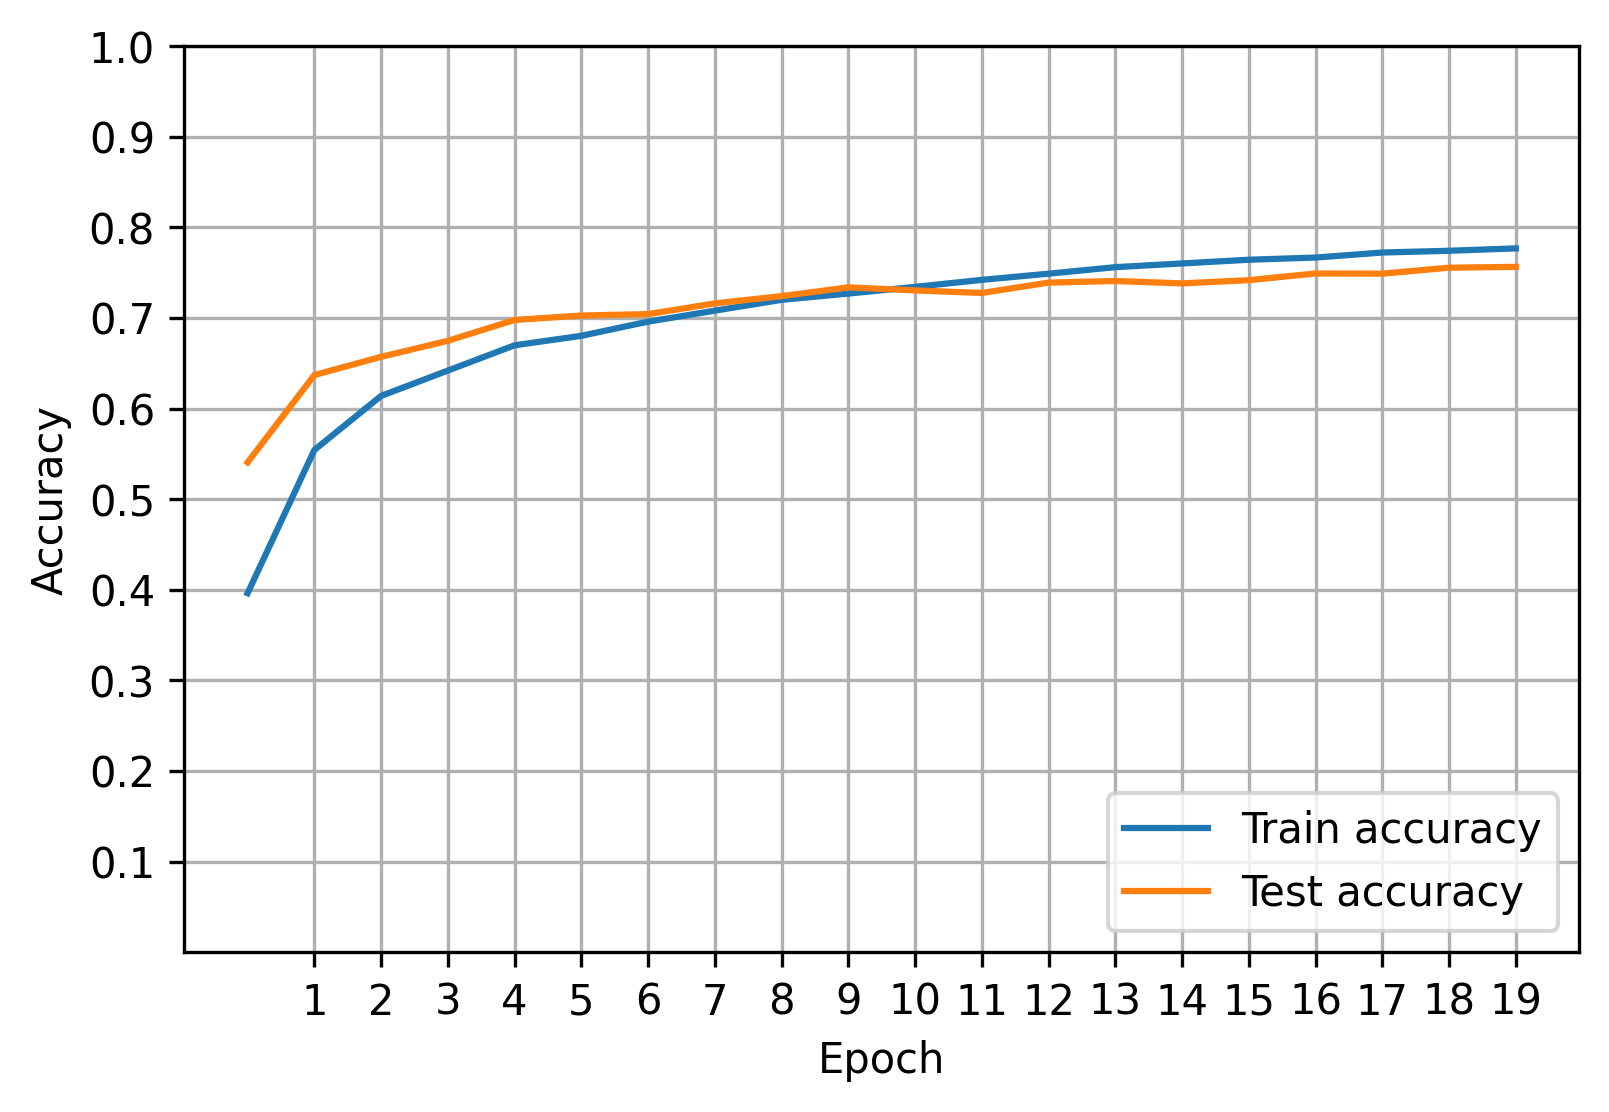

In [ ]:
model, history, test_acc, test_loss = output_train_neuron_normal
print(test_acc)
plot_performance(history)
display(history.history)

## Tests - train data normal - wo dropouts - 20 epochs

### Test - layer

In [ ]:
output_train_layer_normal_no_reg = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-normal-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 22s 70ms/step - loss: 1.3031 - accuracy: 0.7194


0.7193999886512756


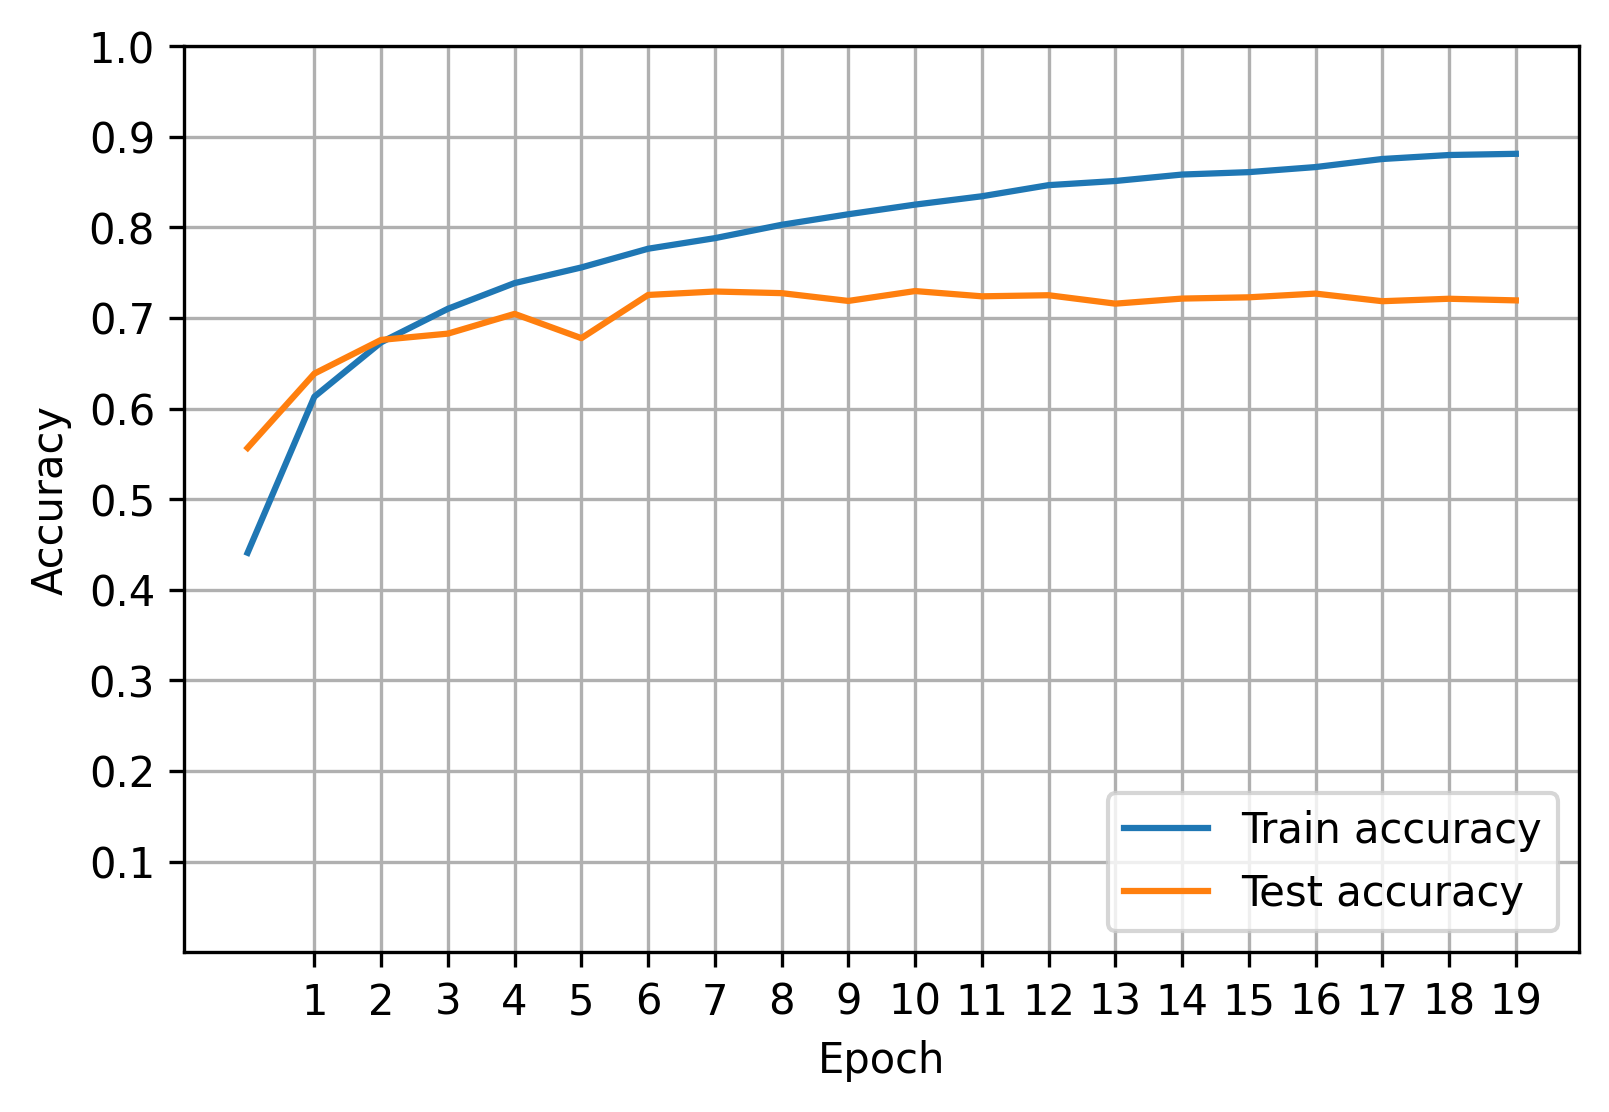

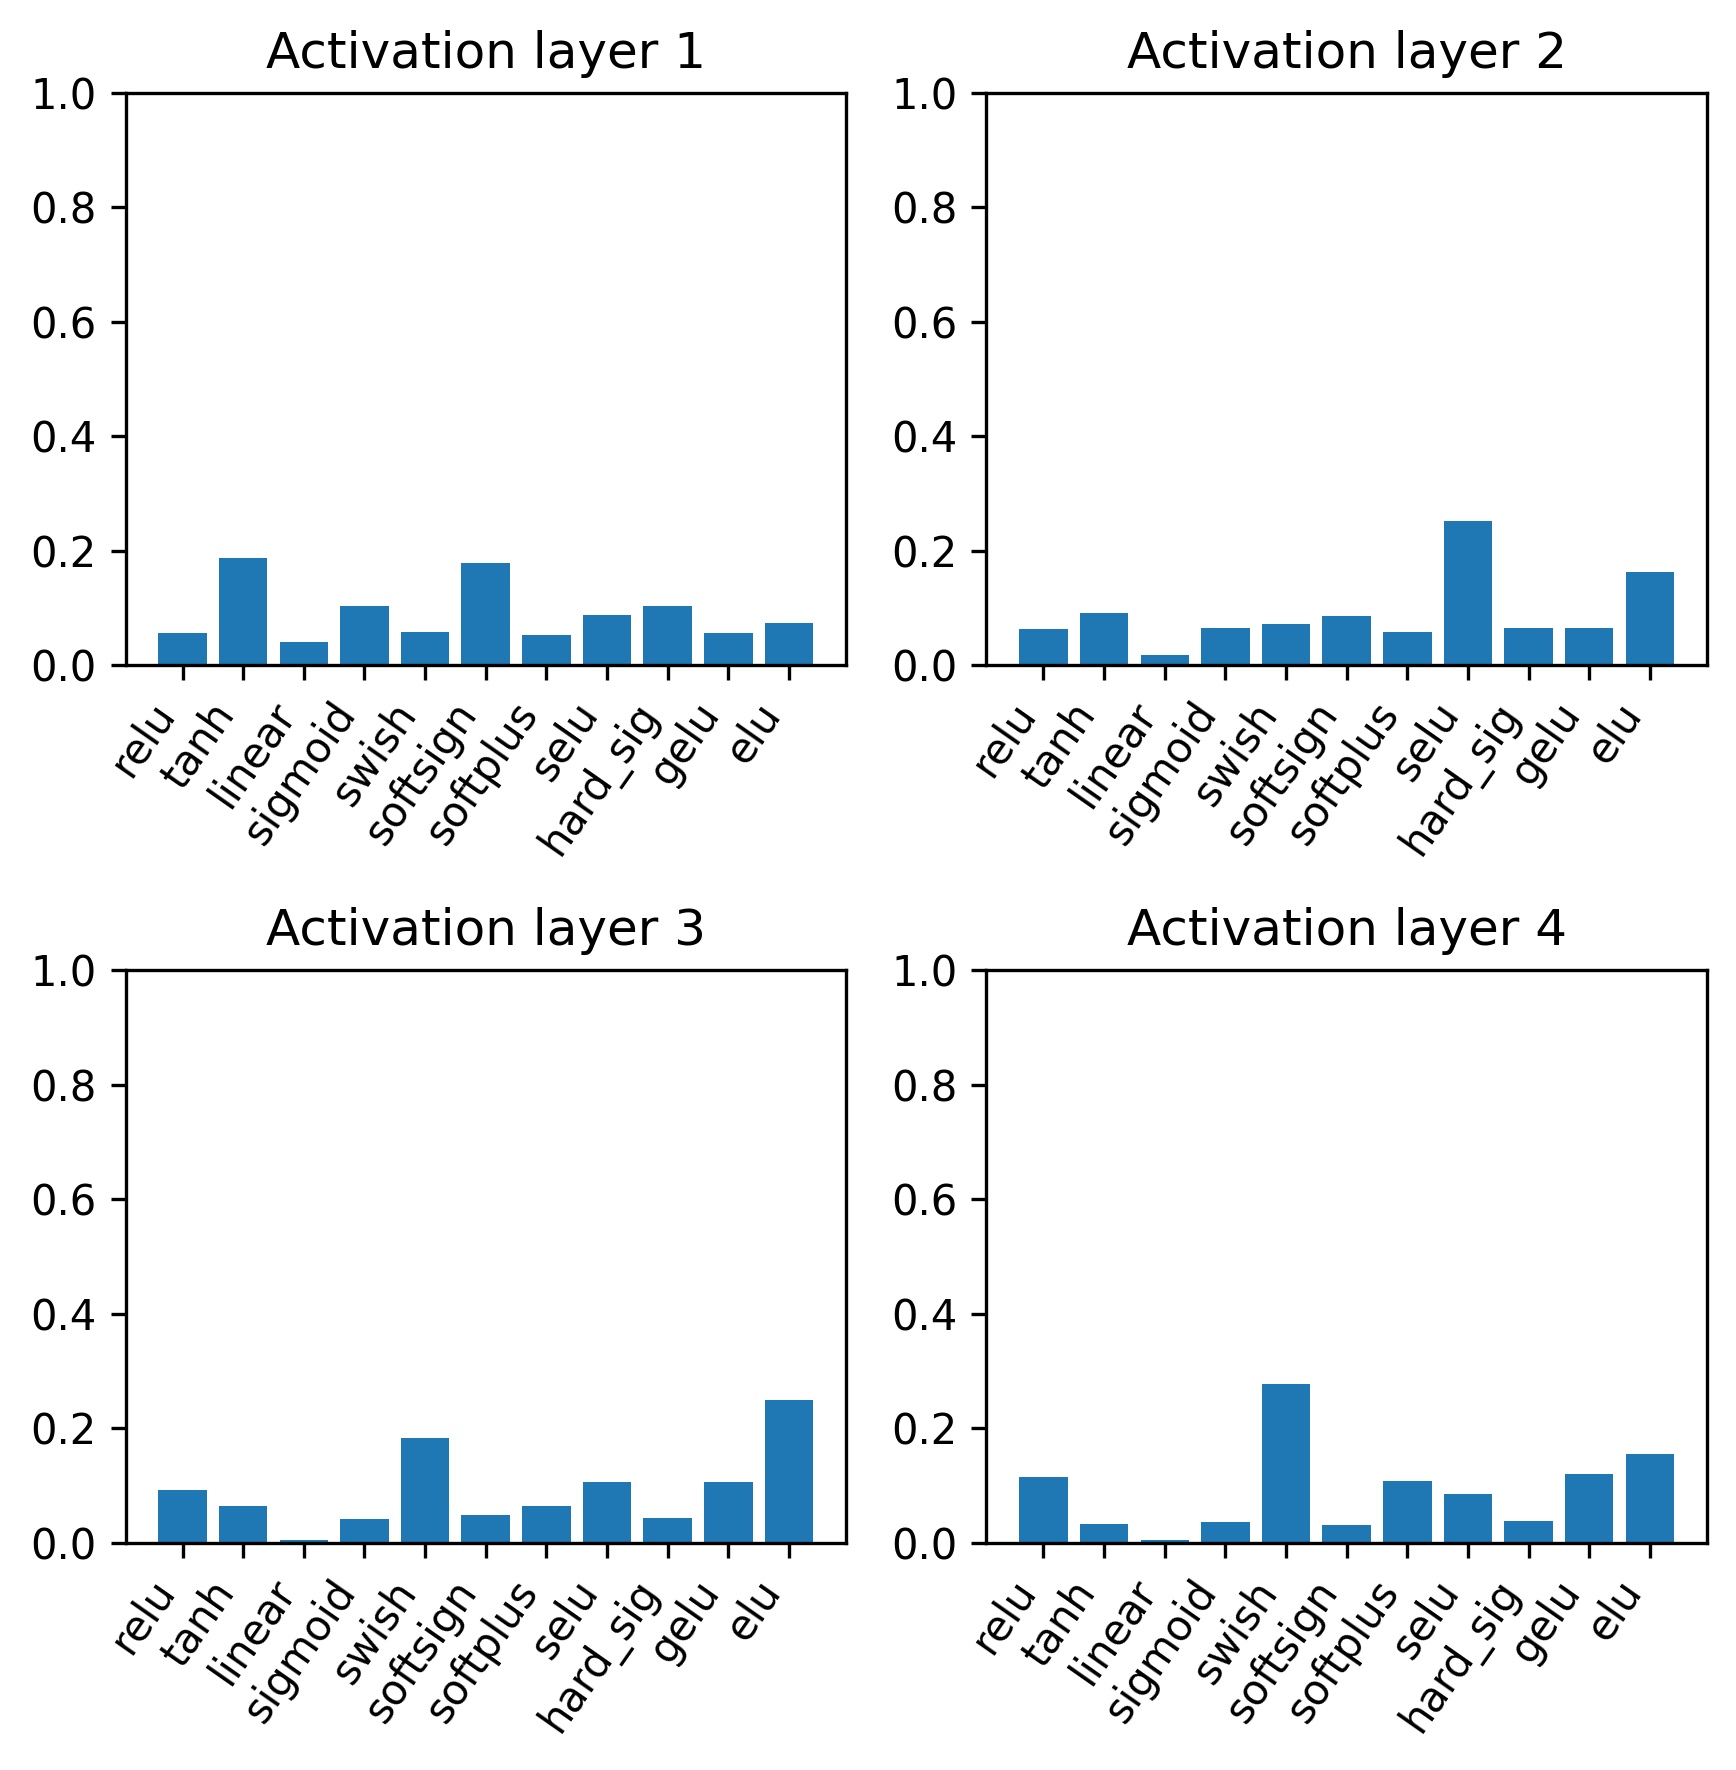

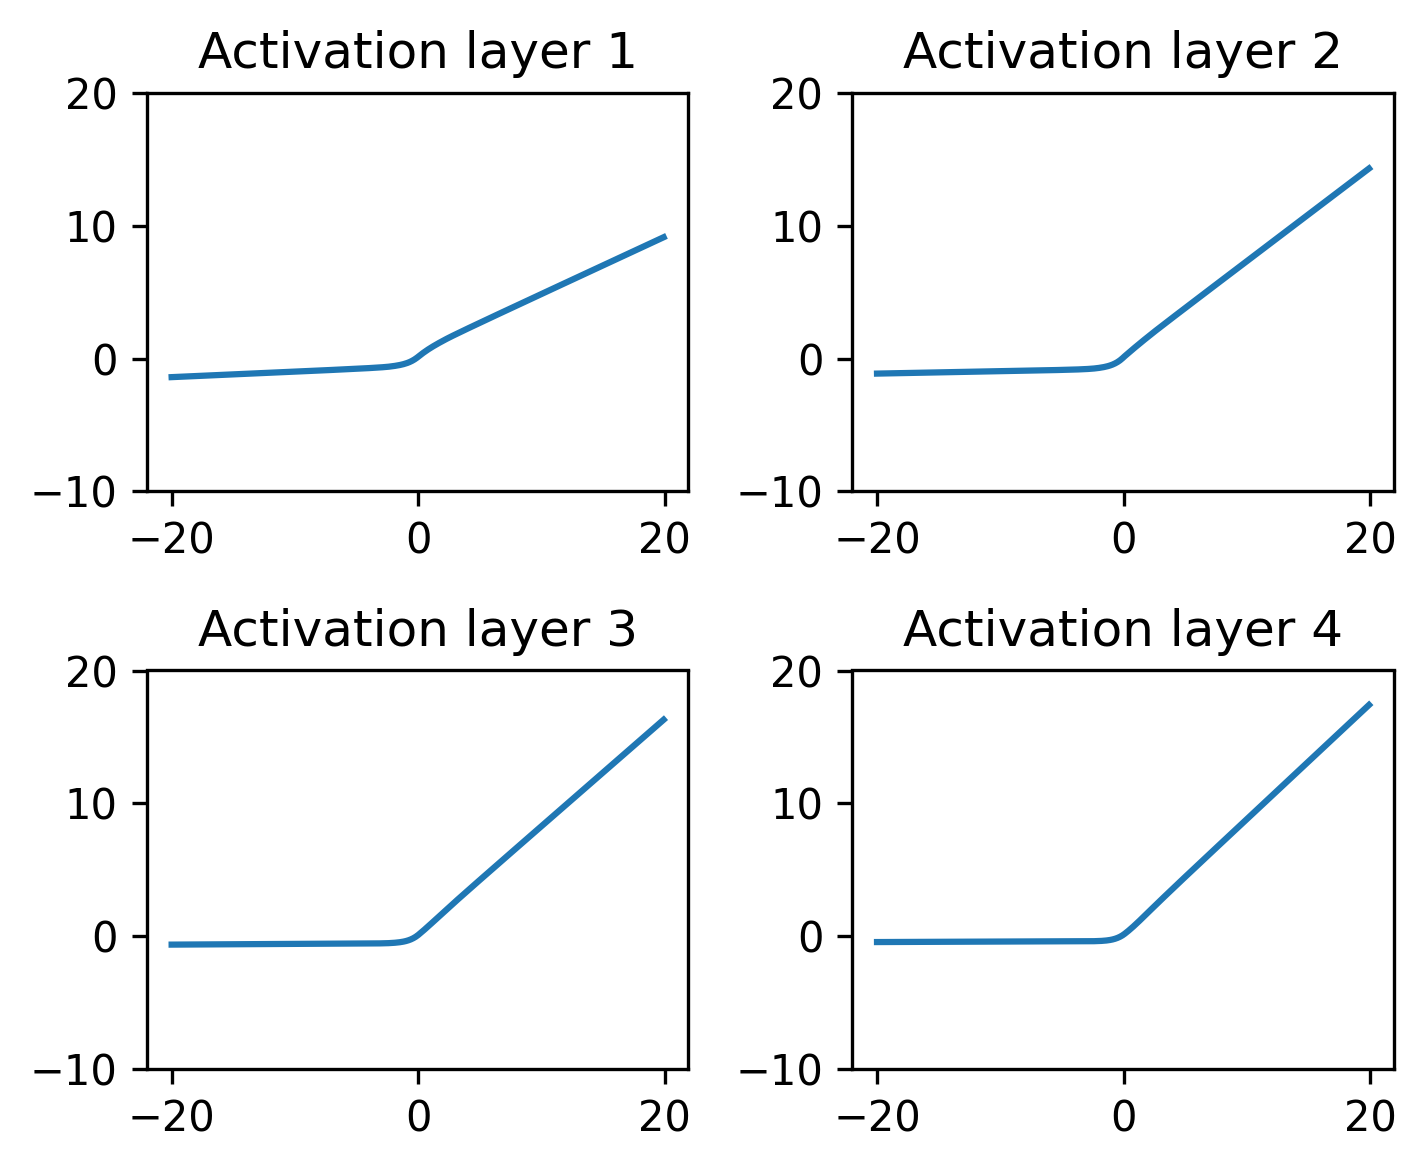

{'accuracy': [0.4408400058746338,
  0.6130800247192383,
  0.6731200218200684,
  0.710099995136261,
  0.7384999990463257,
  0.7557600140571594,
  0.776419997215271,
  0.7880799770355225,
  0.8028200268745422,
  0.8144599795341492,
  0.8251199722290039,
  0.8343200087547302,
  0.8465999960899353,
  0.8511800169944763,
  0.858299970626831,
  0.8609600067138672,
  0.8665599822998047,
  0.8754600286483765,
  0.879859983921051,
  0.8811799883842468],
 'loss': [1.8187040090560913,
  1.3023900985717773,
  1.1233834028244019,
  1.0198203325271606,
  0.9487211108207703,
  0.9010881185531616,
  0.8552575707435608,
  0.8230238556861877,
  0.7977593541145325,
  0.7752282023429871,
  0.7557273507118225,
  0.7387542128562927,
  0.7132079601287842,
  0.7065879702568054,
  0.6903578639030457,
  0.6902916431427002,
  0.6791988015174866,
  0.6577854156494141,
  0.6558997631072998,
  0.653267502784729],
 'val_accuracy': [0.5565999746322632,
  0.6385999917984009,
  0.6758000254631042,
  0.682699978351593,


In [ ]:
model, history, test_acc, test_loss = output_train_layer_normal_no_reg
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=6, height=1.5, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history.history)

### Test - kernel



In [ ]:
output_train_kernel_normal_no_reg = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-normal-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 29s 90ms/step - loss: 1.2921 - accuracy: 0.7247


0.7246999740600586


{'accuracy': [0.47609999775886536,
  0.6283599734306335,
  0.681879997253418,
  0.7192800045013428,
  0.7410600185394287,
  0.7583400011062622,
  0.7747600078582764,
  0.792140007019043,
  0.8032199740409851,
  0.8130599856376648,
  0.8237400054931641,
  0.8331199884414673,
  0.8388400077819824,
  0.8478599786758423,
  0.855139970779419,
  0.8603399991989136,
  0.8650199770927429,
  0.8714600205421448,
  0.8758000135421753,
  0.8771399855613708],
 'loss': [1.7167980670928955,
  1.2530120611190796,
  1.096293330192566,
  0.994600236415863,
  0.9322440028190613,
  0.8885958790779114,
  0.8521459102630615,
  0.8159934282302856,
  0.7965360283851624,
  0.7738234996795654,
  0.7545390129089355,
  0.7380028963088989,
  0.7245227098464966,
  0.7131943106651306,
  0.697931706905365,
  0.6912987232208252,
  0.6818092465400696,
  0.6635785102844238,
  0.6584470272064209,
  0.6601471304893494],
 'val_accuracy': [0.5529000163078308,
  0.6118999719619751,
  0.6650999784469604,
  0.6935999989509583,

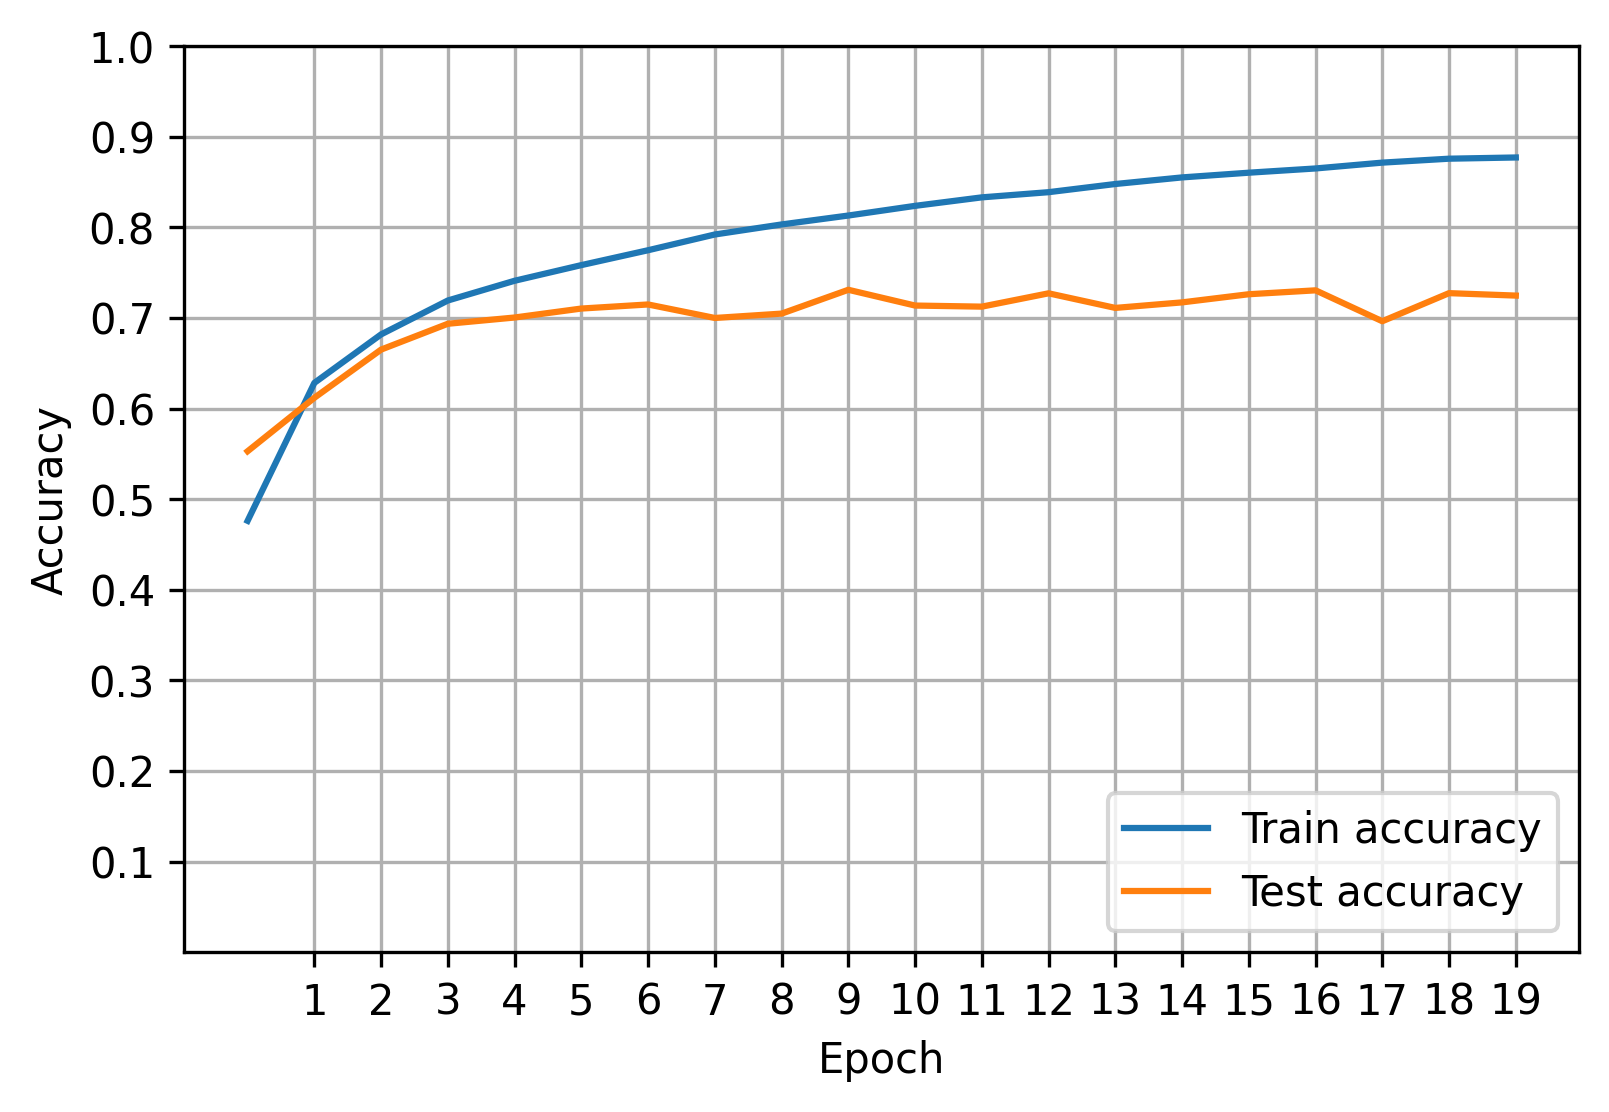

In [ ]:
model, history, test_acc, test_loss = output_train_kernel_normal_no_reg
print(test_acc)
plot_performance(history)
display(history.history)

### Test - neuron



In [ ]:
output_train_neuron_normal_wo_reg = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-normal-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 29s 89ms/step - loss: 1.3079 - accuracy: 0.7181


In [ ]:
model, history, test_acc, test_loss = output_train_neuron_normal_wo_reg
print(test_acc)
plot_performance(history)
display(history.history)

0.7181000113487244


{'accuracy': [0.4633199870586395,
  0.6244800090789795,
  0.6784800291061401,
  0.7140399813652039,
  0.741919994354248,
  0.7597600221633911,
  0.7769200205802917,
  0.7868000268936157,
  0.8042399883270264,
  0.8157600164413452,
  0.8244600296020508,
  0.8364599943161011,
  0.842739999294281,
  0.8496800065040588,
  0.8585399985313416,
  0.8652999997138977,
  0.8683000206947327,
  0.875980019569397,
  0.8817800283432007,
  0.8858799934387207],
 'loss': [1.7430469989776611,
  1.2671221494674683,
  1.1018192768096924,
  0.9985544681549072,
  0.9290995597839355,
  0.8785643577575684,
  0.8415672779083252,
  0.8176231980323792,
  0.780950129032135,
  0.7586303353309631,
  0.7356066703796387,
  0.7138656377792358,
  0.7011427283287048,
  0.6897782683372498,
  0.6727563142776489,
  0.6568462252616882,
  0.6524136066436768,
  0.6396560668945312,
  0.6250655651092529,
  0.620551586151123],
 'val_accuracy': [0.5695000290870667,
  0.6306999921798706,
  0.6692000031471252,
  0.6919000148773193,

## Tests - val data normal - 20 epochs

### Test - layer

In [ ]:
output_val_layer = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-normal-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5377
Training accuracy for epoch: 0.440875
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-01.hdf5

Epoch 2
Step / 625: 0 100 200 400 500 600 625
Validation accuracy for epoch: 0.6171
Training accuracy for epoch: 0.594125
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.619
Training accuracy for epoch: 0.655125
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6468
Training accuracy for epoch: 0.6912
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-04.hdf5

Epoch 5
Step / 625: 0 100 200 300 400 500 6

In [ ]:
model, history, test_acc, test_loss = output_val_layer

### Test - kernel



In [ ]:
output_val_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-kernel-normal-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5513
Training accuracy for epoch: 0.465
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6099
Training accuracy for epoch: 0.6107
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6446
Training accuracy for epoch: 0.664225
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6778
Training accuracy for epoch: 0.69395
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-04.hdf5

Epoch 5
Step / 625: 0 100 200 300 400 

In [ ]:
model, history, test_acc, test_loss = output_val_kernel

### Test - neuron



In [ ]:
output_val_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-neuron-normal-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5389
Training accuracy for epoch: 0.4811
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6087
Training accuracy for epoch: 0.61795
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6567
Training accuracy for epoch: 0.667875
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6672
Training accuracy for epoch: 0.699825
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-04.hdf5

Epoch 5
Step / 625: 0 100 200 300 4

In [ ]:
model, history, test_acc, test_loss = output_val_neuron

## Tests - val data normal - wo dropouts - 20 epochs

### Test - layer

In [ ]:
output_val_layer = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-normal-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5692
Training accuracy for epoch: 0.493225
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-wo-dropouts-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6472
Training accuracy for epoch: 0.650975
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-wo-dropouts-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6745
Training accuracy for epoch: 0.709375
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-wo-dropouts-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6773
Training accuracy for epoch: 0.7469
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-normal-wo-dropouts

In [ ]:
model, history, test_acc, test_loss = output_val_layer

In [ ]:
history

[{'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.48375>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7724359>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.5785>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.642625>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5390208>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6323>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.70535>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4080983>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6694>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.743775>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.315908>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6675>},
 {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.773275>,
  'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2476958>,
  'val_accuracy': <tf.Tensor: shape=(), dtype=float32,

In [ ]:
new_model = prune_model(model, n_act_functions=2, reset_weights=True)

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 layer_activation_29 (LayerA  (None, 30, 30, 32)       2         
 ctivation)                                                      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 layer_activation_30 (LayerA  (None, 13, 13, 64)       2         
 ctivation)                                                      
                                                      

In [ ]:
output_val_layer_wo_dropouts_final = train_model(
    new_model,
    filepath_prefix=models_path, 
    filepath="model-val-layer-wo-dropouts-final-{epoch:02d}.hdf5", 
    epochs=20,
    data=get_cifar10_data(),
    model_train_fn=model_train_regular
)

Epoch 1/20
624/625 [============================>.] - ETA: 0s - loss: 1.9671 - accuracy: 0.3214
Epoch 00001: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-val-layer-wo-dropouts-final-01.hdf5
625/625 [==============================] - 16s 24ms/step - loss: 1.9667 - accuracy: 0.3216 - val_loss: 1.7319 - val_accuracy: 0.4060
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 1.6591 - accuracy: 0.4387
Epoch 00002: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-val-layer-wo-dropouts-final-02.hdf5
625/625 [==============================] - 14s 22ms/step - loss: 1.6591 - accuracy: 0.4387 - val_loss: 1.6072 - val_accuracy: 0.4591
Epoch 3/20
623/625 [============================>.] - ETA: 0s - loss: 1.5652 - accuracy: 0.4757
Epoch 00003: saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1/model-val-layer-wo-dropouts-final-03.hdf5
625/625 [==============================] - 27s 43ms/s

### Test - kernel



In [ ]:
output_val_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-kernel-normal-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5681
Training accuracy for epoch: 0.4803
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-wo-dropouts-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6377
Training accuracy for epoch: 0.6481
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-wo-dropouts-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6599
Training accuracy for epoch: 0.706325
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-wo-dropouts-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6837
Training accuracy for epoch: 0.744525
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-normal-wo-dropou

### Test - neuron



In [ ]:
output_val_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-neuron-normal-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

170508288/170498071 [==============================] - 3s 0us/step
Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5714
Training accuracy for epoch: 0.502875
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-wo-dropouts-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6379
Training accuracy for epoch: 0.6581
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-wo-dropouts-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6718
Training accuracy for epoch: 0.716125
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-normal-wo-dropouts-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6819
Training accuracy for epoch: 0.748275
Saving model to drive/MyDrive/master-thes

## Tests - train data all - 20 epochs

### Test - layer

In [ ]:
output_train_layer_all = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-all-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 29s 88ms/step - loss: 0.9596 - accuracy: 0.7482


0.748199999332428


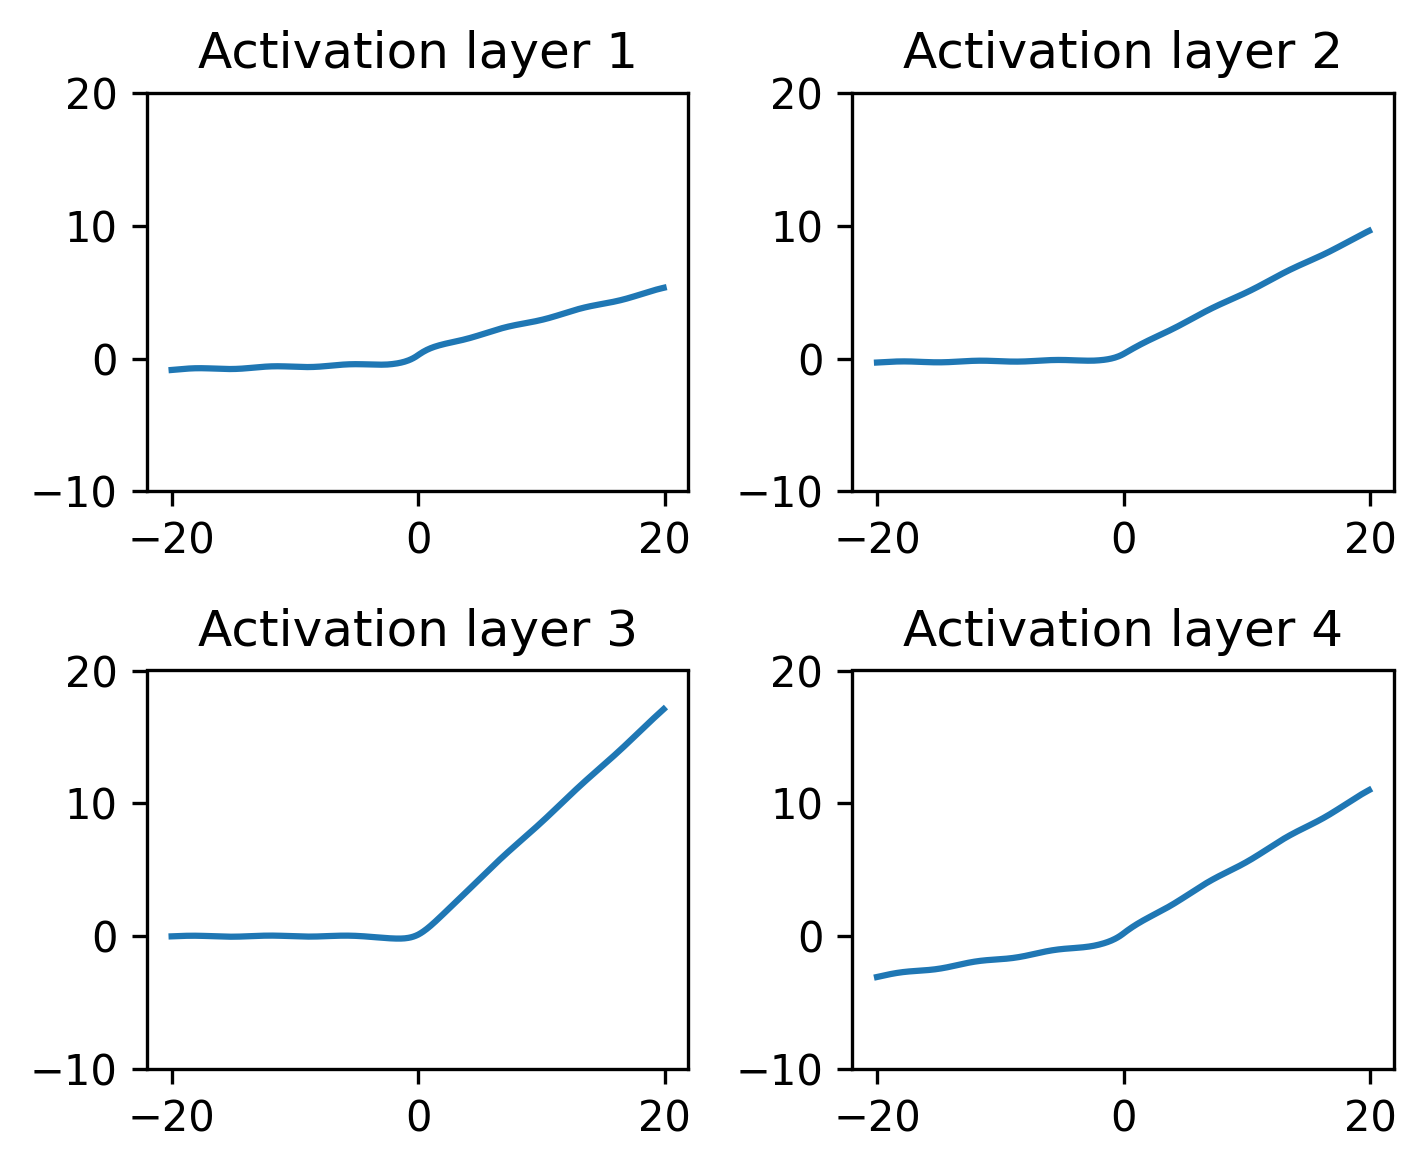

{'accuracy': [0.4203200042247772,
  0.5713000297546387,
  0.6251199841499329,
  0.6526399850845337,
  0.6757400035858154,
  0.6909800171852112,
  0.7079600095748901,
  0.7170600295066833,
  0.728380024433136,
  0.7370200157165527,
  0.7419000267982483,
  0.7473000288009644,
  0.7537400126457214,
  0.7597399950027466,
  0.7632799744606018,
  0.7688199877738953,
  0.7686200141906738,
  0.7743800282478333,
  0.7749800086021423,
  0.7792199850082397],
 'loss': [1.836200475692749,
  1.4020498991012573,
  1.2497305870056152,
  1.1742117404937744,
  1.114205241203308,
  1.0708262920379639,
  1.038131833076477,
  1.012734055519104,
  0.993614673614502,
  0.9723005294799805,
  0.9630110859870911,
  0.9499484896659851,
  0.9393813014030457,
  0.9208589792251587,
  0.9202407598495483,
  0.8995908498764038,
  0.9052450656890869,
  0.89683997631073,
  0.8915318846702576,
  0.8845173716545105],
 'val_accuracy': [0.5519999861717224,
  0.6116999983787537,
  0.6740000247955322,
  0.6801000237464905,
  

In [ ]:
model, history, test_acc, test_loss = output_train_layer_all
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=6, height=1.5, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history.history)

### Test - kernel



In [ ]:
output_train_kernel_all = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-all-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 32s 99ms/step - loss: 0.9671 - accuracy: 0.7489


0.7488999962806702


{'accuracy': [0.43244001269340515,
  0.5827400088310242,
  0.6296600103378296,
  0.6553999781608582,
  0.6758400201797485,
  0.6938999891281128,
  0.7082800269126892,
  0.7156800031661987,
  0.7268400192260742,
  0.73471999168396,
  0.7418400049209595,
  0.744979977607727,
  0.751800000667572,
  0.7592599987983704,
  0.7566400170326233,
  0.7640399932861328,
  0.7692599892616272,
  0.7697200179100037,
  0.7731599807739258,
  0.7742400169372559],
 'loss': [1.8006268739700317,
  1.3764723539352417,
  1.2444069385528564,
  1.1658267974853516,
  1.1089167594909668,
  1.062933325767517,
  1.0381726026535034,
  1.0183228254318237,
  0.991661548614502,
  0.9782056212425232,
  0.9629151821136475,
  0.9566836953163147,
  0.9448936581611633,
  0.9287826418876648,
  0.9317896366119385,
  0.9181175231933594,
  0.9030627608299255,
  0.9004874229431152,
  0.9014922380447388,
  0.891832172870636],
 'val_accuracy': [0.5626000165939331,
  0.6449999809265137,
  0.6669999957084656,
  0.6959999799728394,


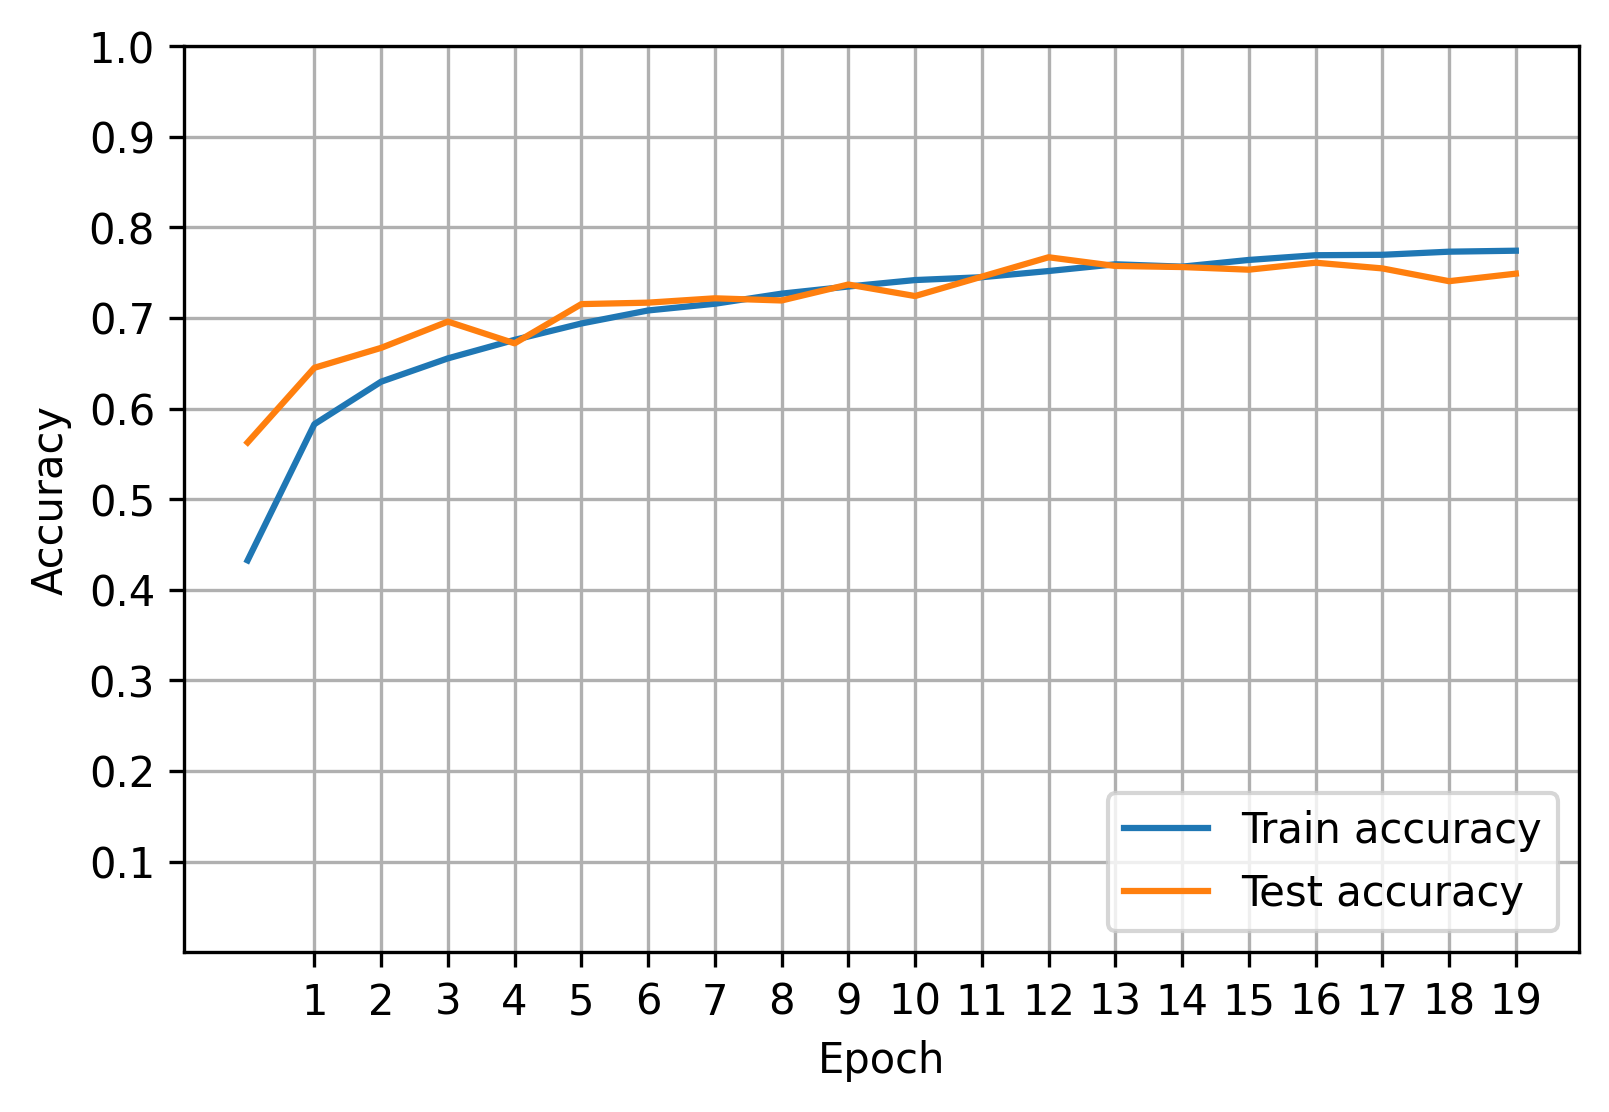

In [ ]:
model, history, test_acc, test_loss = output_train_kernel_all
print(test_acc)
plot_performance(history)
display(history.history)

### Test - neuron



In [ ]:
output_train_neuron_all = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-all-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 36s 113ms/step - loss: 0.9347 - accuracy: 0.7637


0.763700008392334


{'accuracy': [0.43285998702049255,
  0.5830399990081787,
  0.6340799927711487,
  0.6628199815750122,
  0.677079975605011,
  0.698639988899231,
  0.7091799974441528,
  0.7183600068092346,
  0.7278800010681152,
  0.7372199892997742,
  0.745419979095459,
  0.7523400187492371,
  0.7553799748420715,
  0.7630400061607361,
  0.7650399804115295,
  0.7710800170898438,
  0.7745599746704102,
  0.7769799828529358,
  0.7813000082969666,
  0.7797999978065491],
 'loss': [1.7917929887771606,
  1.3713703155517578,
  1.2317813634872437,
  1.1512051820755005,
  1.104413628578186,
  1.0587910413742065,
  1.0288043022155762,
  1.0077729225158691,
  0.986694872379303,
  0.9645689129829407,
  0.9495929479598999,
  0.9327614307403564,
  0.9189873933792114,
  0.90973299741745,
  0.9017620086669922,
  0.8832056522369385,
  0.8797078728675842,
  0.8769601583480835,
  0.8682599067687988,
  0.8660111427307129],
 'val_accuracy': [0.5903000235557556,
  0.6358000040054321,
  0.6830999851226807,
  0.6920999884605408,


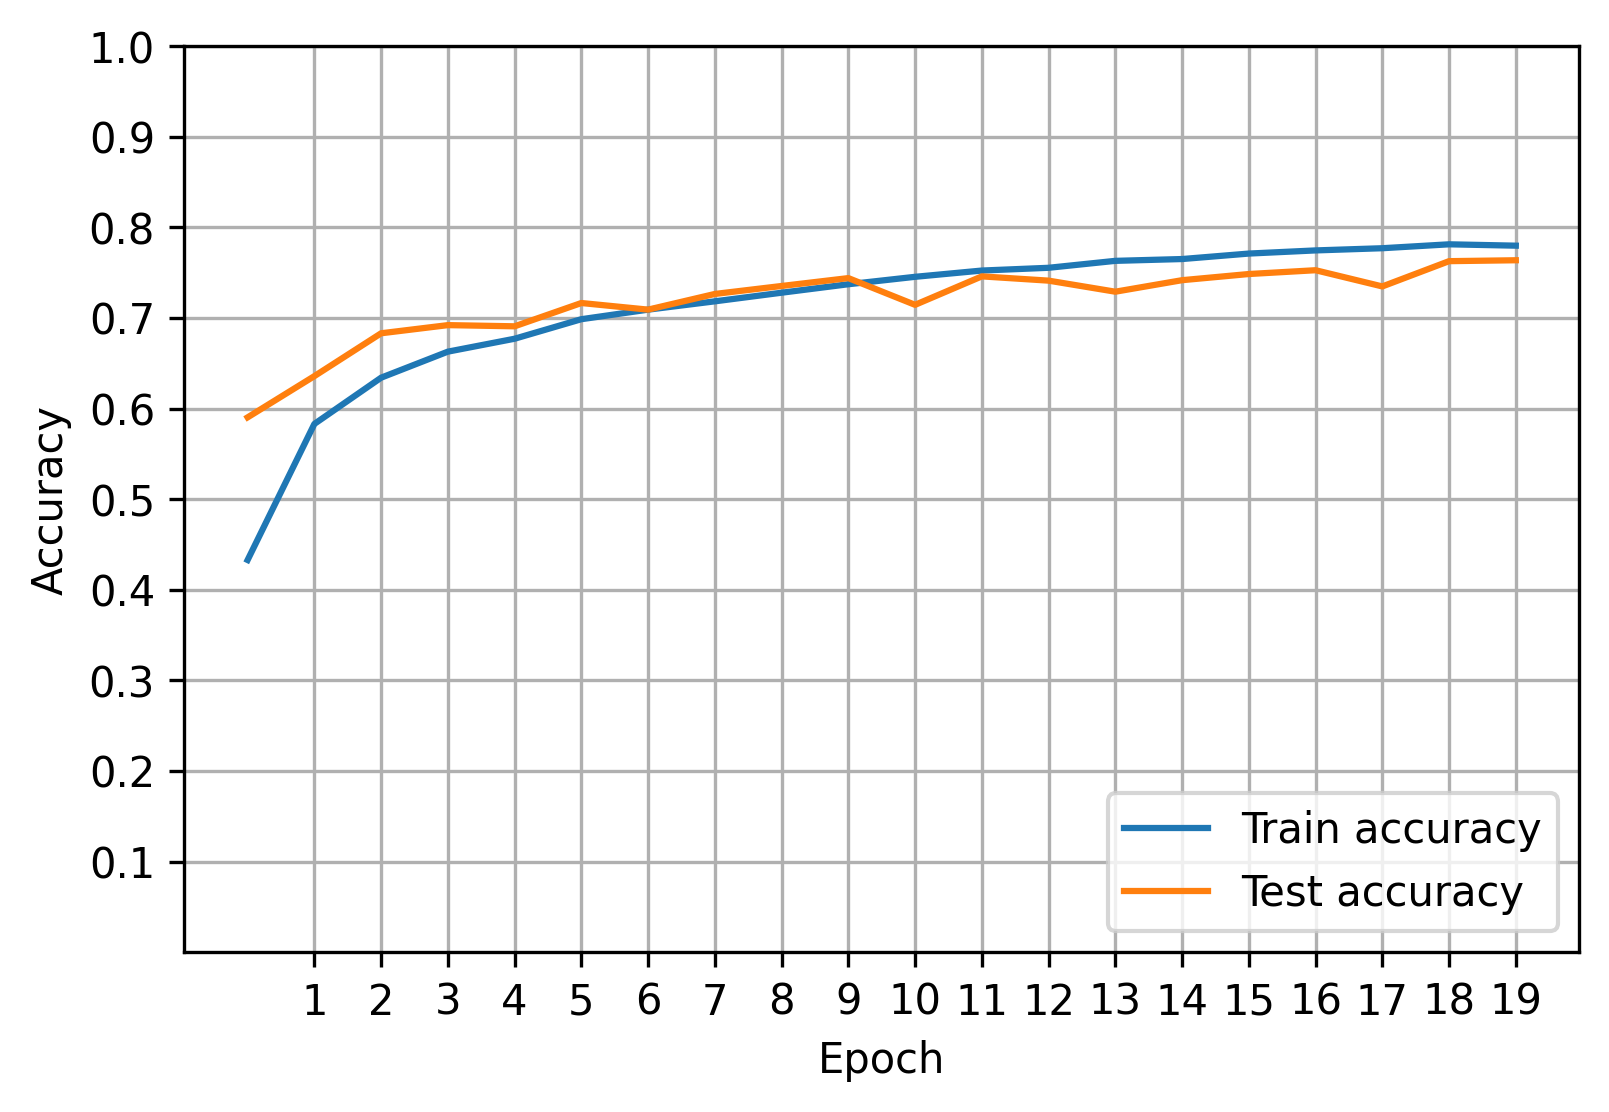

In [ ]:
model, history, test_acc, test_loss = output_train_neuron_all
print(test_acc)
plot_performance(history)
display(history.history)

## Tests - train data all - wo dropouts - 20 epochs

### Test - layer

In [ ]:
output_train_layer_all_wo_reg = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-all-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file


None


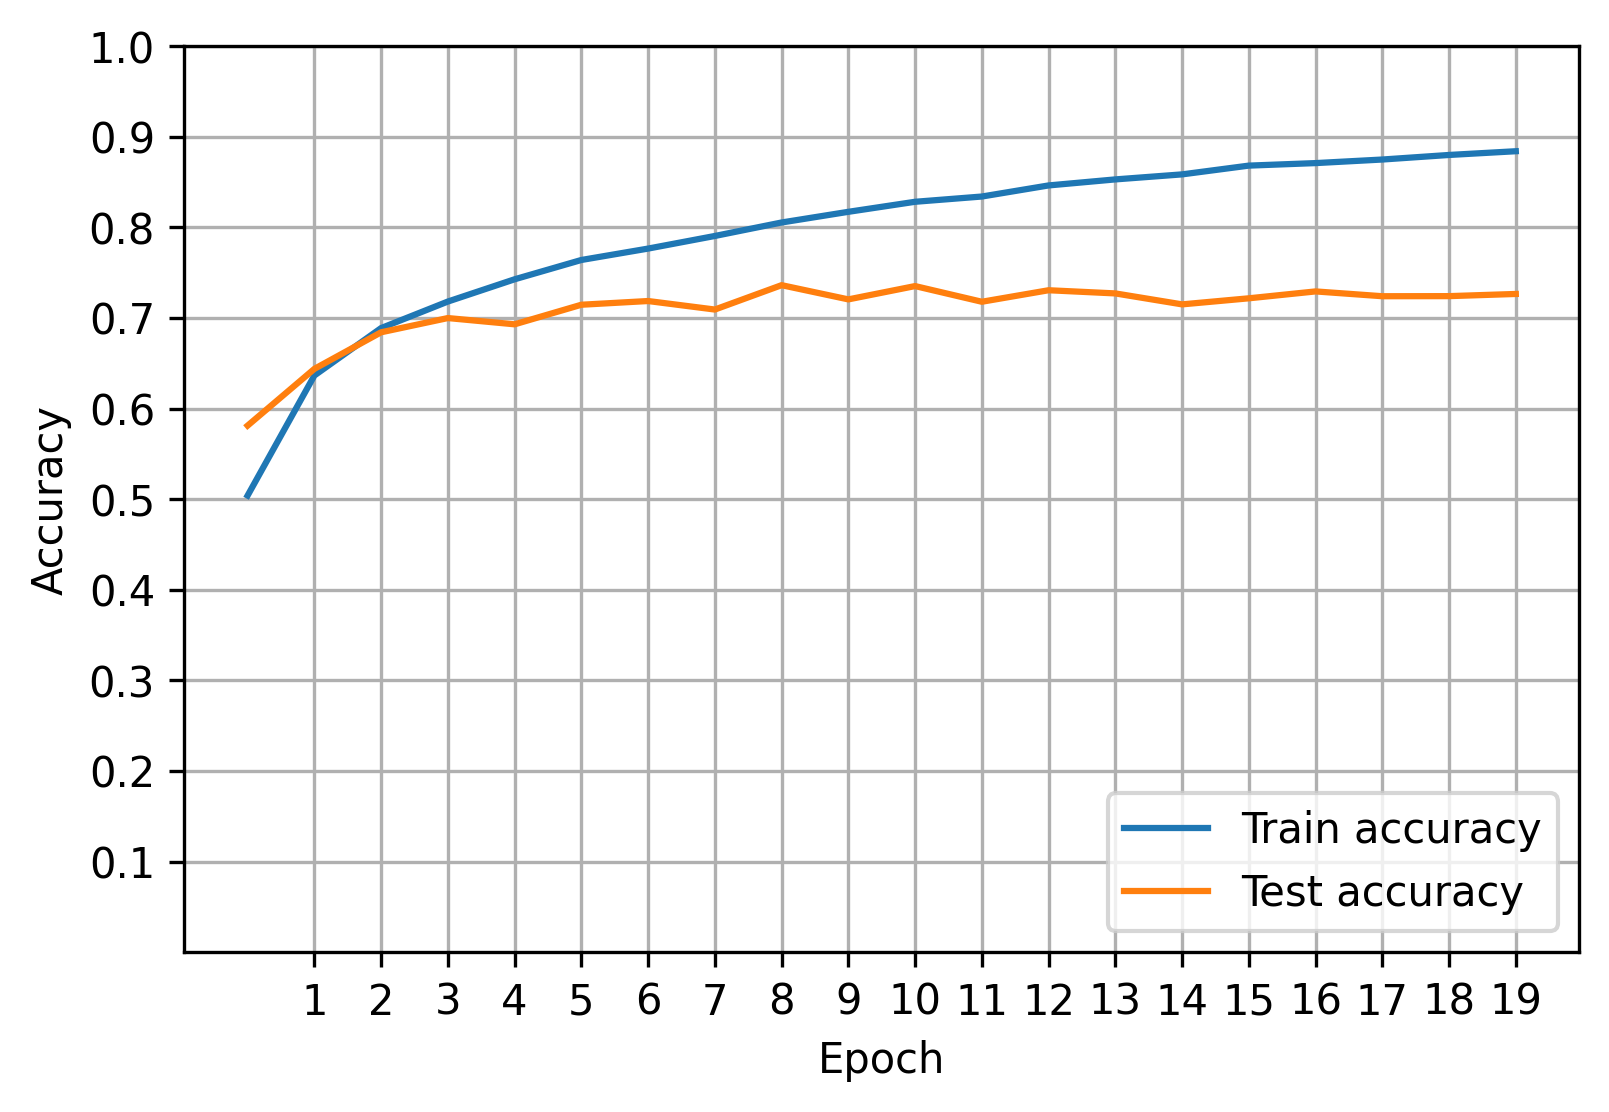

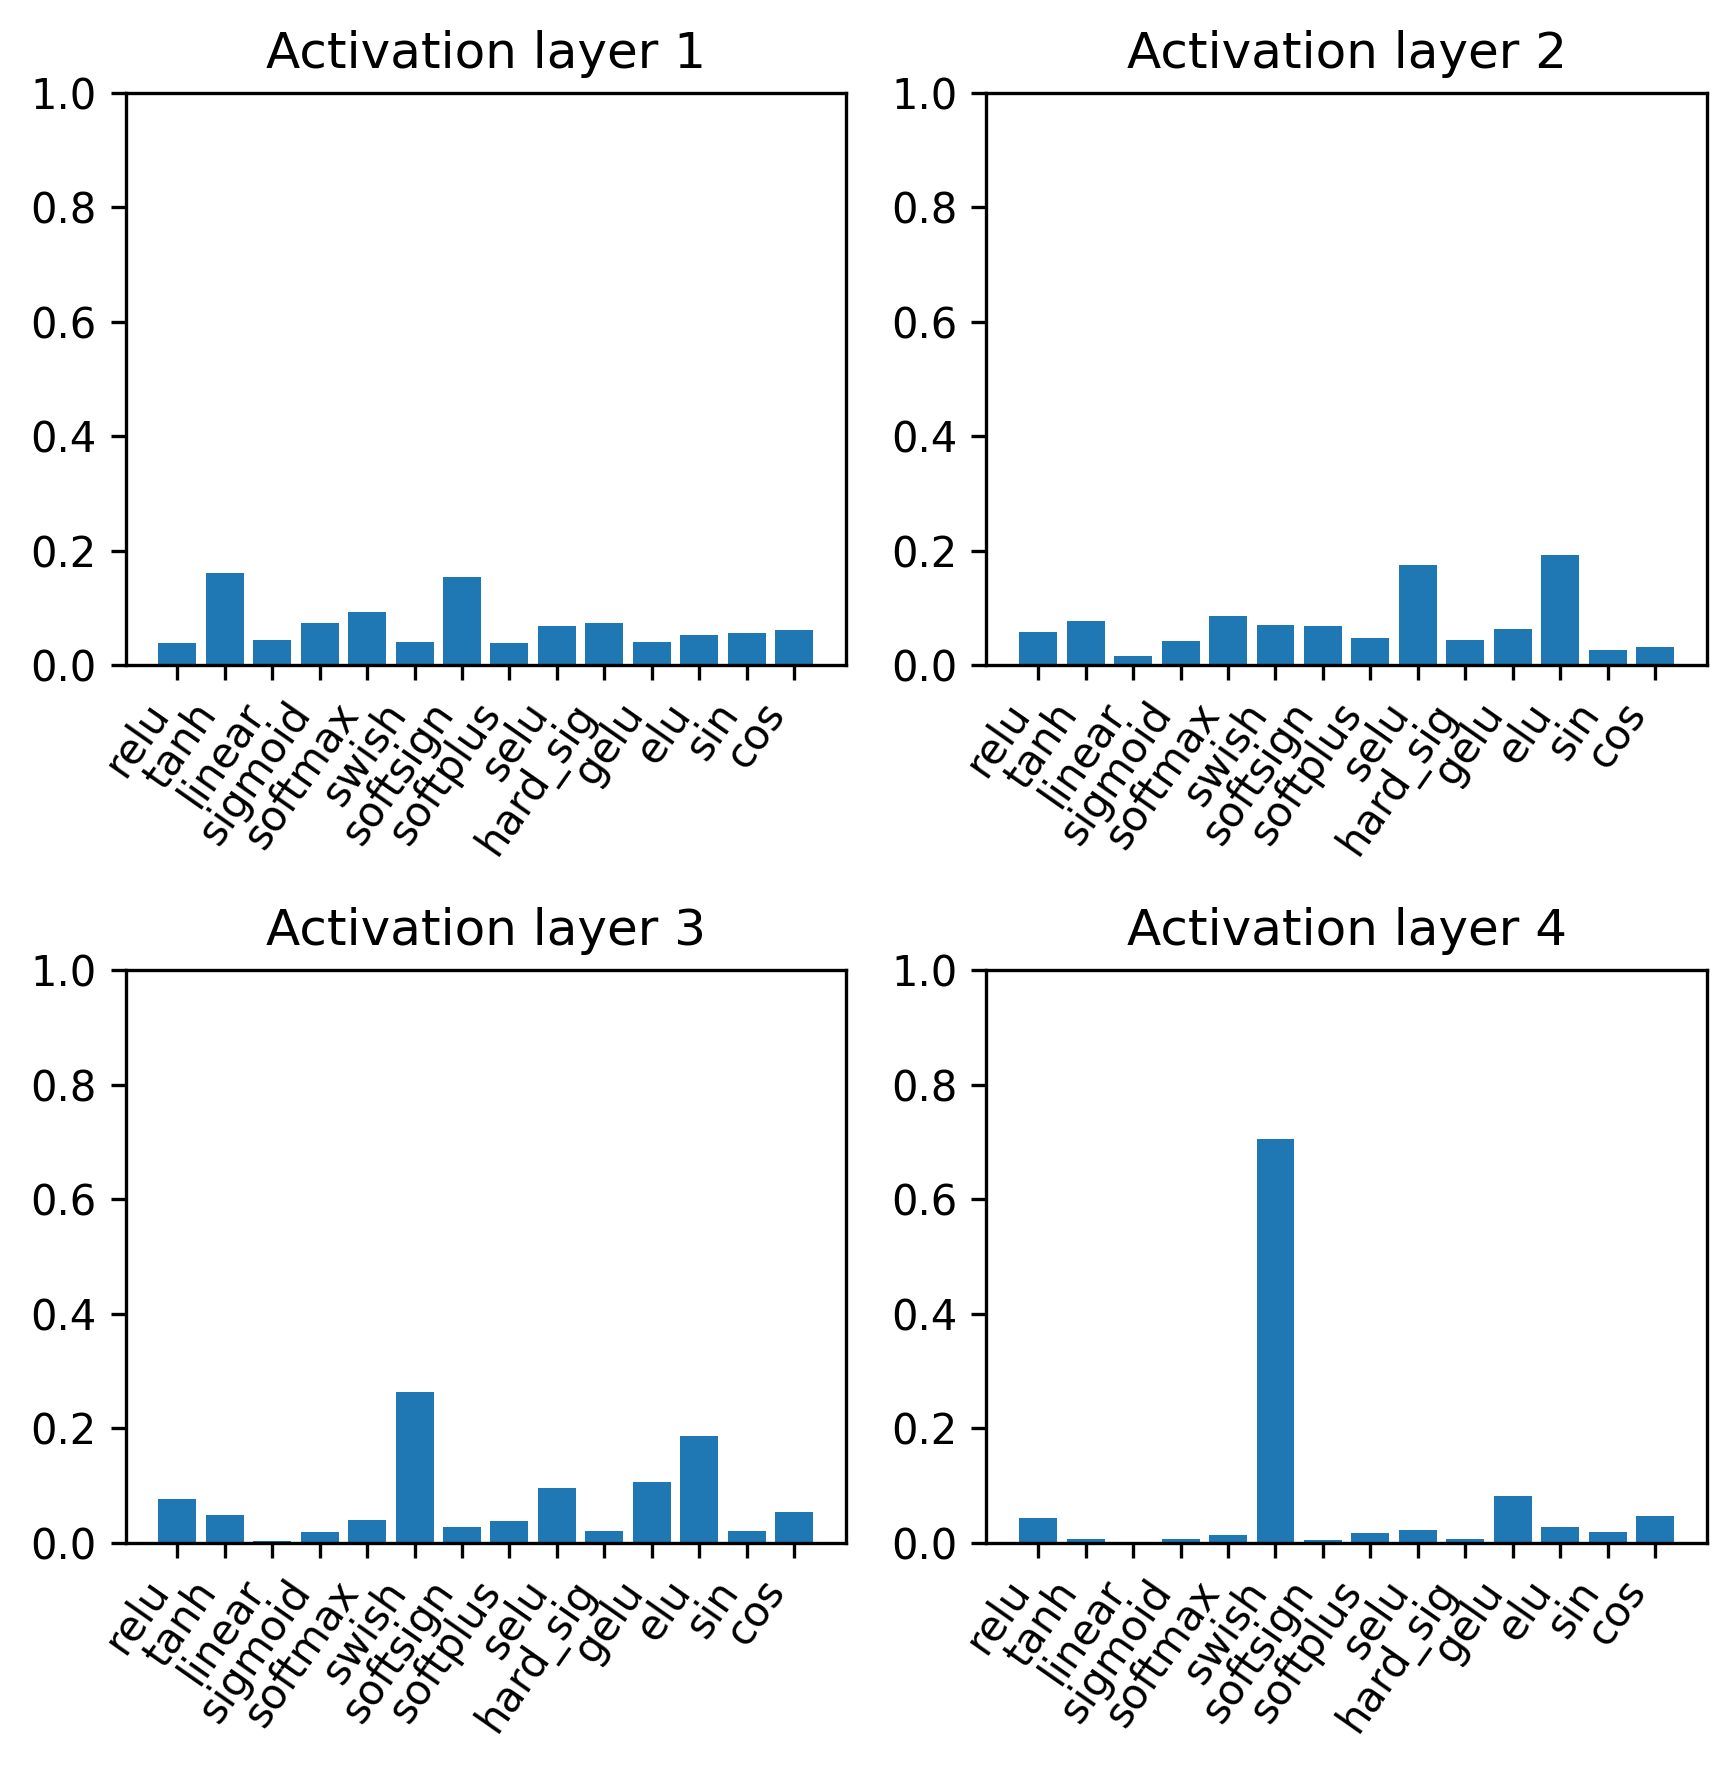

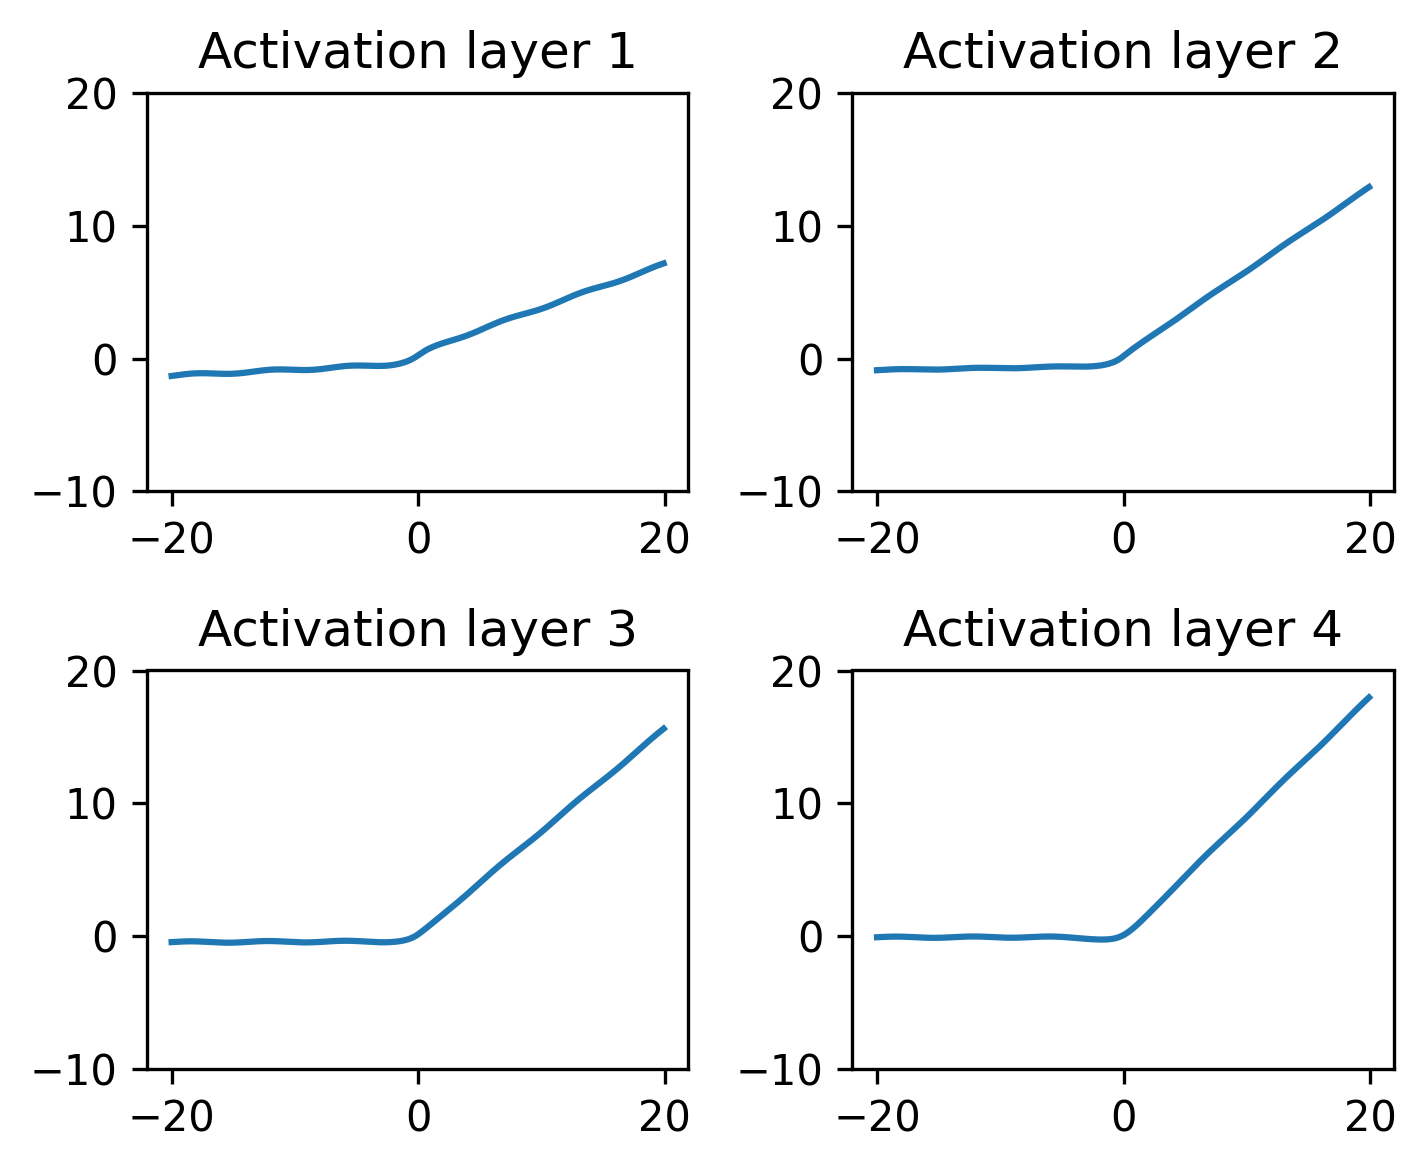

{'accuracy': [0.5040000081062317,
  0.6364799737930298,
  0.6888399720191956,
  0.7181199789047241,
  0.742680013179779,
  0.7639999985694885,
  0.7765799760818481,
  0.7904999852180481,
  0.8053799867630005,
  0.8171600103378296,
  0.8282399773597717,
  0.8340399861335754,
  0.8462799787521362,
  0.852940022945404,
  0.8584799766540527,
  0.8681600093841553,
  0.8709400296211243,
  0.8748800158500671,
  0.8799200057983398,
  0.8840399980545044],
 'loss': [1.5973596572875977,
  1.2189046144485474,
  1.0683919191360474,
  0.9867761731147766,
  0.9276479482650757,
  0.8801175951957703,
  0.8489534258842468,
  0.8240143656730652,
  0.7908046841621399,
  0.7646216154098511,
  0.7448368668556213,
  0.7312582731246948,
  0.7068316340446472,
  0.6976977586746216,
  0.6896458864212036,
  0.6683993935585022,
  0.6617721915245056,
  0.6569223403930664,
  0.6480485796928406,
  0.6424583196640015],
 'val_accuracy': [0.5812000036239624,
  0.6438000202178955,
  0.6841999888420105,
  0.69989997148513

In [ ]:
model, history, test_acc, test_loss = output_train_layer_all_wo_reg
print(test_acc)
plot_performance(history)
plot_activation_functions_bars([model], width=6, height=1.5, mode='grid')
plot_activation_functions([model], width=5, height=1, mode='grid')
display(history.history)

### Test - kernel



In [ ]:
output_train_kernel_all_no_reg = train_or_read(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-kernel-all-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 32s 100ms/step - loss: 1.2817 - accuracy: 0.7170


0.7170000076293945


{'accuracy': [0.4793800115585327,
  0.6361799836158752,
  0.6852800250053406,
  0.7213600277900696,
  0.7433000206947327,
  0.76146000623703,
  0.7795799970626831,
  0.7895799875259399,
  0.8016200065612793,
  0.8152400255203247,
  0.822700023651123,
  0.8307600021362305,
  0.8398600220680237,
  0.844539999961853,
  0.8545799851417542,
  0.8586400151252747,
  0.8665800094604492,
  0.8669800162315369,
  0.8763599991798401,
  0.8801199793815613],
 'loss': [1.6651582717895508,
  1.2249733209609985,
  1.077789545059204,
  0.982403039932251,
  0.9275795221328735,
  0.8852682709693909,
  0.8447177410125732,
  0.8186149001121521,
  0.7955072522163391,
  0.7718678712844849,
  0.7519599795341492,
  0.738117516040802,
  0.7206279039382935,
  0.7095164656639099,
  0.6949217319488525,
  0.6847770810127258,
  0.6712182760238647,
  0.6729365587234497,
  0.6519206762313843,
  0.6495238542556763],
 'val_accuracy': [0.5582000017166138,
  0.6578999757766724,
  0.6897000074386597,
  0.6937000155448914,
 

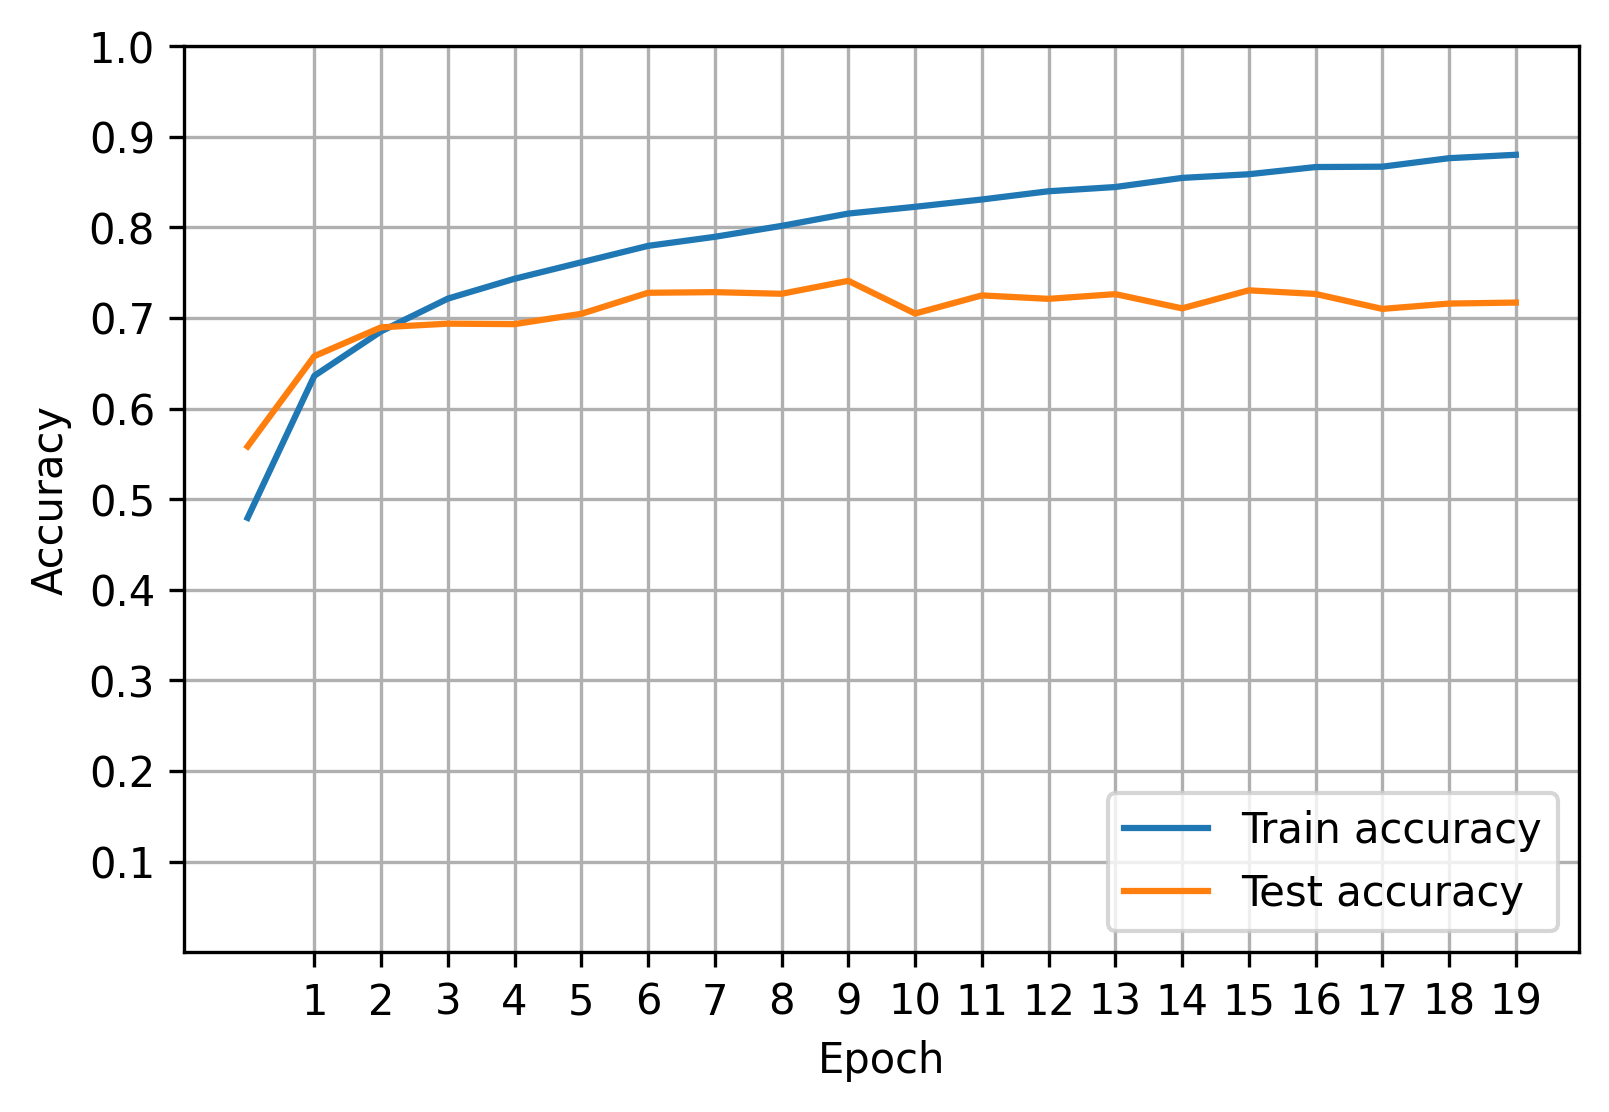

In [ ]:
model, history, test_acc, test_loss = output_train_kernel_all_no_reg
print(test_acc)
plot_performance(history)
display(history.history)

### Test - neuron



In [ ]:
output_train_neuron_all_wo_reg = train_or_read(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-neuron-all-wo-dropouts-{epoch:02d}.model.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_regular,
    use_test_as_val=True
)

Reading model from file
313/313 [==============================] - 31s 96ms/step - loss: 1.3270 - accuracy: 0.7224


In [ ]:
model, history, test_acc, test_loss = output_train_neuron_all_wo_reg
print(test_acc)
plot_performance(history)
display(history.history)

0.7224000096321106


{'accuracy': [0.5142599940299988,
  0.6460000276565552,
  0.6960200071334839,
  0.7252600193023682,
  0.749459981918335,
  0.7682200074195862,
  0.7856799960136414,
  0.7965400218963623,
  0.8121799826622009,
  0.8222399950027466,
  0.8307999968528748,
  0.8434200286865234,
  0.8525999784469604,
  0.8612200021743774,
  0.866320013999939,
  0.872160017490387,
  0.8765000104904175,
  0.8836600184440613,
  0.8864200115203857,
  0.8928200006484985],
 'loss': [1.5820060968399048,
  1.197859525680542,
  1.0503816604614258,
  0.9620641469955444,
  0.9030183553695679,
  0.8588900566101074,
  0.8253905177116394,
  0.7983300089836121,
  0.7604450583457947,
  0.7373700737953186,
  0.7225298285484314,
  0.6980696320533752,
  0.6775221824645996,
  0.6562764644622803,
  0.648205041885376,
  0.6374988555908203,
  0.6269182562828064,
  0.6157740354537964,
  0.6087121367454529,
  0.5932618379592896],
 'val_accuracy': [0.595300018787384,
  0.5805000066757202,
  0.6741999983787537,
  0.7056000232696533,


## Tests - val data all - 20 epochs

### Test - layer

In [ ]:
output_val_layer = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-all-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5542
Training accuracy for epoch: 0.4812
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6213
Training accuracy for epoch: 0.62675
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6659
Training accuracy for epoch: 0.674775
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6888
Training accuracy for epoch: 0.709675
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-04.hdf5

Epoch 5
Step / 625: 0 100 200 300 400 500 600 625
V

### Test - kernel



In [ ]:
output_val_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-kernel-all-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5761
Training accuracy for epoch: 0.47845
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.617
Training accuracy for epoch: 0.615975
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6554
Training accuracy for epoch: 0.6677
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.677
Training accuracy for epoch: 0.696025
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-04.hdf5

Epoch 5
Step / 625: 0 100 200 300 400 500 600 625

### Test - neuron



In [ ]:
output_val_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-neuron-all-{epoch:02d}.hdf5", 
    epochs=20,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5562
Training accuracy for epoch: 0.491525
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-all-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6254
Training accuracy for epoch: 0.625375
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-all-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6442
Training accuracy for epoch: 0.67145
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-all-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6778
Training accuracy for epoch: 0.7023
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-neuron-all-04.hdf5

Epoch 5
Step / 625: 0 100 200 300 400 500 600 6

## Tests - val data all - wo dropouts - 20 epochs

### Test - layer

In [ ]:
output_val_layer = train(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-layer-all-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6064
Training accuracy for epoch: 0.52055
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-wo-dropouts-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6494
Training accuracy for epoch: 0.664
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-wo-dropouts-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6738
Training accuracy for epoch: 0.72
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-wo-dropouts-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6882
Training accuracy for epoch: 0.75295
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-layer-all-wo-dropouts-04.hdf5

Epoch 5
S

### Test - kernel



In [ ]:
output_val_kernel = train(
    activation_function=lambda: KernelActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-kernel-all-wo-dropouts-{epoch:02d}.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)

Using given val data
16
Epoch 1
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.5817
Training accuracy for epoch: 0.5083
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-wo-dropouts-01.hdf5

Epoch 2
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6453
Training accuracy for epoch: 0.65965
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-wo-dropouts-02.hdf5

Epoch 3
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6681
Training accuracy for epoch: 0.7136
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-wo-dropouts-03.hdf5

Epoch 4
Step / 625: 0 100 200 300 400 500 600 625
Validation accuracy for epoch: 0.6783
Training accuracy for epoch: 0.750825
Saving model to drive/MyDrive/master-thesis/models/experiments-comparison-1//model-val-kernel-all-wo-dropouts-04.hdf5

E

### Test - neuron



In [ ]:
output_val_neuron = train(
    activation_function=lambda: NeuronActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-val-neuron-all-wo-dropouts-{epoch:02d}.model.hdf5", 
    epochs=20,
    get_model_fn=get_model_wo_dropouts,
    get_data_fn=get_cifar10_data,
    model_train_fn=model_train_val,
    use_test_as_val=True
)